# Natural Language Understanding

For choosing my dataset, I was choosing between:
* Customer Support on Twitter https://www.kaggle.com/thoughtvector/customer-support-on-twitter
* Ubuntu Dialogue Corpus https://www.kaggle.com/rtatman/ubuntu-dialogue-corpus
* Relational Services in Customer Service (RSICS) https://nextit-public.s3-us-west-2.amazonaws.com/rsics.html

Example end-to-end projects:
* [A Transformer Chatbot Tutorial with TensorFlow 2.0](https://medium.com/tensorflow/a-transformer-chatbot-tutorial-with-tensorflow-2-0-88bf59e66fe2)
* [Google Colaboratory](https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/transformer_chatbot.ipynb#scrollTo=dYRx7YzCW4bu)
* [Messenger Chatbot from Scratch] (https://github.com/daoudclarke/chatbot-from-scratch)


Since I am making a chatbot for helping with application problems, the following block defines the intents I want to classify:

In [1]:
# Making a dictionary to store intents and the predefined responses 
intents = {"Greeting": ["Hi there!","Hello"], 
 "Closing":"Thanks for talking", 
 "Promotion":"",
           "Scenarios": {'Last payment': "", "Account details":"", 
                         "Account confirmation": ""},
    "Location": ""
}

In [217]:
%%capture
print("Versions")
# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")
# Deep Learning 
import tensorflow as tf
print(f"Tensorflow: {tf.__version__}")
from tensorflow import keras
print(f"Keras: {keras.__version__}")
import sklearn
print(f"Sklearn: {sklearn.__version__}")
# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
# Regular Expressions
import re
print(f're: {re.__version__}')
# Preprocessing
import spacy
print(f'spaCy: {spacy.__version__}')
import nltk
print(f'nltk: {nltk.__version__}')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import casual_tokenize
from nltk.stem import WordNetLemmatizer 
# Emoji analysis
from spacymoji import Emoji
# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

# Twitter
Notes about dataset:
* It's from 2017 to 2018

In [3]:
sample = pd.read_csv('data/4133-8841-bundle-archive/sample.csv')

Seeing the number of authors for all the data. From another Kernel I saw that AmazonSupport contained the most tweets, and amazingly, it turns out, not all of the tweets are in English!

In [4]:
%%time
# Reading in all the Twitter data
all_data = pd.read_csv('data/4133-8841-bundle-archive/twcs.csv')

CPU times: user 9.07 s, sys: 2.29 s, total: 11.4 s
Wall time: 12.6 s


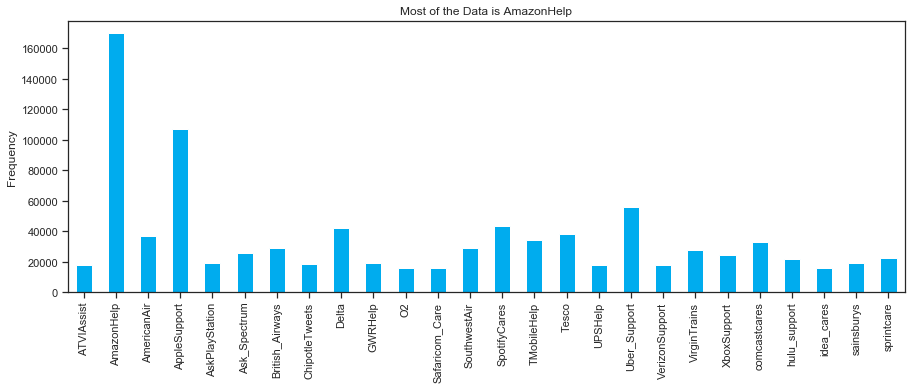

In [5]:
# Finding the distribution of all authors
count = all_data.groupby("author_id")["text"].count()
# Showing only the authors that appear more than 15000 times
c = count[count>15000].plot(kind='bar',figsize=(15, 5), color='#00acee')
c.set_xlabel('')
c.set_ylabel('Frequency')
plt.title('Most of the Data is AmazonHelp')
plt.show()

## Data Dictionary:
* Tweet_id: The unique ID for this tweet
* Author_id: The unique ID for this tweet author (anonymized for non-company users)
* Inbound: Whether or not the tweet was sent (inbound) to a company
* Created_at: When the tweet was created
* Text: The text content of the tweet
* Response_tweet_id: The tweet that responded to this one, if any
* In_response_to_tweet_id: The tweet this tweet was in response to, if any

In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB


In [7]:
# Converting columns to the right datatypes
all_data['text'] = all_data['text'].astype('string')
all_data['author_id'] = all_data['author_id'].astype('string')

In [8]:
all_data.head()

tweet_id   author_id  inbound                      created_at  \
0         1  sprintcare    False  Tue Oct 31 22:10:47 +0000 2017   
1         2      115712     True  Tue Oct 31 22:11:45 +0000 2017   
2         3      115712     True  Tue Oct 31 22:08:27 +0000 2017   
3         4  sprintcare    False  Tue Oct 31 21:54:49 +0000 2017   
4         5      115712     True  Tue Oct 31 21:49:35 +0000 2017   

                                                text response_tweet_id  \
0  @115712 I understand. I would like to assist y...                 2   
1      @sprintcare and how do you propose we do that               NaN   
2  @sprintcare I have sent several private messag...                 1   
3  @115712 Please send us a Private Message so th...                 3   
4                                 @sprintcare I did.                 4   

   in_response_to_tweet_id  
0                      3.0  
1                      1.0  
2                      4.0  
3                      5.0  
4                      6.0

In [9]:
# There are 108 unique authors that are companies and 702669 customers
authors_count = (len(all_data[all_data.inbound == False].author_id.unique()), len(all_data[all_data.inbound == True].author_id.unique()))
authors_count

(108, 702669)

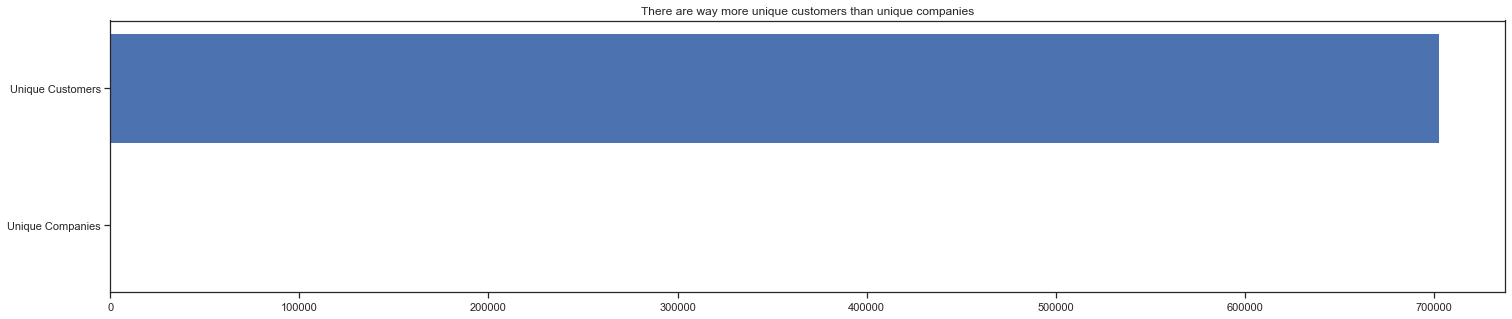

In [10]:
plt.figure(figsize =(25,5))
x = ['Unique Companies','Unique Customers']
ax = plt.barh(x, authors_count)
plt.title('There are way more unique customers than unique companies');

# Data wrangling
Since the first step I want to achieve is intent classification and to figure out what the customer is saying to the company, I only want data that goes from the customer to the company (inbound data). My first modeling step is to do some form of clustering to classify the intents for each of these tweets, doing so might be easier and more fruitful if I narrow the data to just the apple data because they will be in a somewhat similar domain. I can expand this over to other datasets.

In [11]:
apple_data = all_data[all_data['author_id'] == 'AppleSupport']
apple_data.shape
# There is 106860 apple data, which is 3.8 percent of the entire data

(106860, 7)

In [12]:
apple_data.head()

tweet_id     author_id  inbound                      created_at  \
396       696  AppleSupport    False  Tue Oct 31 22:27:49 +0000 2017   
398       699  AppleSupport    False  Tue Oct 31 22:36:27 +0000 2017   
401       701  AppleSupport    False  Tue Oct 31 22:26:49 +0000 2017   
403       703  AppleSupport    False  Tue Oct 31 22:09:52 +0000 2017   
405       705  AppleSupport    False  Tue Oct 31 21:57:00 +0000 2017   

                                                  text response_tweet_id  \
396  @115854 We're here for you. Which version of t...               697   
398  @115854 Lets take a closer look into this issu...               NaN   
401  @115855 Let's go to DM for the next steps. DM ...               NaN   
403  @115855 Any steps tried since it started last ...               702   
405  @115855 That's great it has iOS 11.1 as we can...           706,704   

     in_response_to_tweet_id  
396                    698.0  
398                    697.0  
401                    702.0  
403                    704.0  
405                    707.0

These are all data from Apple to a customer, I want the data from the customer to Apple for each of these Apple customer service responses, and this can be found in the reponse_tweet_id.

In [13]:
len(apple_data)

106860

Dropping the rows with a NaN value for the in response to tweet id column, meaning that the original customer inquiry was not available for that interaction

In [14]:
apple_data.dropna(subset = ['in_response_to_tweet_id'],inplace = True)

/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Nice, it seems like we still have plenty of data to work with (106719 rows)

In [15]:
apple_data.shape

(106719, 7)

Now I want to find all the original tweets from the customer to Apple Support and return them as a text in the Dataframe as opposed to an ID.

In [16]:
# Converting the IDs to integers to match the tweet_id column for joining
apple_data.in_response_to_tweet_id = apple_data.in_response_to_tweet_id.astype('int64')

/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [17]:
# Doing an inner join to get the respective tweets back from the all_data from and get the response texts
apple_data = pd.merge(all_data[['tweet_id','text']],apple_data,left_on='tweet_id', right_on='in_response_to_tweet_id')

In [18]:
# Dropping the columns that doesn't encode useful information and renaming the columns nicely for intepretability
apple_data.drop(['tweet_id_x','tweet_id_y','in_response_to_tweet_id','inbound'], axis = 1, inplace = True)

In [19]:
apple_data.rename(columns = {'text_x':'inbound_text','text_y':'outbound_text'},inplace = True)

In [20]:
# Showing results of data wrangling
apple_data.head()

inbound_text     author_id  \
0  @AppleSupport The newest update. I️ made sure ...  AppleSupport   
1             @AppleSupport  https://t.co/NV0yucs0lB  AppleSupport   
2  @AppleSupport Tried resetting my settings .. r...  AppleSupport   
3  @AppleSupport This is what it looks like https...  AppleSupport   
4  @AppleSupport I️ have an iPhone 7 Plus and yes...  AppleSupport   

                       created_at  \
0  Tue Oct 31 22:36:27 +0000 2017   
1  Tue Oct 31 22:27:49 +0000 2017   
2  Tue Oct 31 22:26:49 +0000 2017   
3  Tue Oct 31 22:09:52 +0000 2017   
4  Tue Oct 31 21:57:00 +0000 2017   

                                       outbound_text response_tweet_id  
0  @115854 Lets take a closer look into this issu...               NaN  
1  @115854 We're here for you. Which version of t...               697  
2  @115855 Let's go to DM for the next steps. DM ...               NaN  
3  @115855 Any steps tried since it started last ...               702  
4  @115855 That's great it has iOS 11.1 as we can...           706,704

Sweet. So now we are going to build off apple_data from this point on.

# Unseen Data: Train Test Split
Making sure to split into train and test before all the preprocessing steps. Since we have no y, we will just split X into train and test. Applying this concept of unseen data to have measures of overfitting and better model evaluation.

In [21]:
from sklearn.model_selection import train_test_split
# Focusing on the inbound text
X_train, X_test = train_test_split(apple_data['inbound_text'],test_size = 0.33, random_state = 25)

In [22]:
# Set a third of the data to be in test
len(X_train), len(X_test)

(71454, 35194)

### Checking if all the data is English
Just making sure since I saw in another kernel that the Amazon data had non-english data. I will use the document level language detection for printing, which basically checks if the entire tweet is mostly English as kind of a progress bar. But for the check, I will use the sentence level to filter out if any sentence in my data is not english.

See what the langdetector was trained on.

In [ ]:
# Trying on sample first


In [63]:
import spacy
from spacy_langdetect import LanguageDetector

nlp = spacy.load('en')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

languages = []
not_english = []
# This is used for the masking by index
indexes_to_drop = []

# This will take a while because spaCy's language detection takes a while, using tqdm to track the progress
for tweet in tqdm(X_train):
    doc = nlp(tweet)
    # document level language detection. Think of it like average language of the document!
    print(doc._.language)
    # sentence level language detection
    for i, sent in enumerate(doc.sents):
        languages.append(sent._.language)
        # Filtering out the sentence if it is not English
        if sent._.language['language']  != 'en':
            not_english.append((sent, sent._.language))
            indexes_to_drop.append(i)

/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


{'language': 'en', 'score': 0.9999980851256258}
{'language': 'en', 'score': 0.9999971022965687}
{'language': 'en', 'score': 0.9999973570966858}
{'language': 'en', 'score': 0.9999972503117521}
{'language': 'en', 'score': 0.9999973865601215}
{'language': 'en', 'score': 0.9999960761962898}
{'language': 'en', 'score': 0.9999967826902431}
{'language': 'en', 'score': 0.9999957263335928}
{'language': 'en', 'score': 0.9999965513567147}
{'language': 'en', 'score': 0.9999969456924427}
{'language': 'en', 'score': 0.999996840877938}
{'language': 'en', 'score': 0.9999950053448783}
{'language': 'en', 'score': 0.9999973829724043}
{'language': 'en', 'score': 0.9999976597491331}
{'language': 'en', 'score': 0.9999979563353906}
{'language': 'en', 'score': 0.9999964578794056}
{'language': 'en', 'score': 0.9999966352384896}
{'language': 'en', 'score': 0.9999969458826713}
{'language': 'en', 'score': 0.9999977529956751}
{'language': 'en', 'score': 0.9999965248564234}
{'language': 'en', 'score': 0.99999649884

{'language': 'en', 'score': 0.9999957392387957}
{'language': 'en', 'score': 0.9999961024377153}
{'language': 'en', 'score': 0.9999978456881298}
{'language': 'fr', 'score': 0.9999964515663238}
{'language': 'en', 'score': 0.9999974003167414}
{'language': 'en', 'score': 0.9999969311378143}
{'language': 'en', 'score': 0.9999964242689514}
{'language': 'en', 'score': 0.9999963488982595}
{'language': 'en', 'score': 0.9999969551002882}
{'language': 'en', 'score': 0.9999957929897788}
{'language': 'en', 'score': 0.999997159361056}
{'language': 'en', 'score': 0.9999988030568614}
{'language': 'en', 'score': 0.9999968665857225}
{'language': 'en', 'score': 0.9999958082460698}
{'language': 'en', 'score': 0.9999963745506977}
{'language': 'en', 'score': 0.9999955379549152}
{'language': 'en', 'score': 0.9999959695137797}
{'language': 'en', 'score': 0.9999970035759411}
{'language': 'en', 'score': 0.9999954240852198}
{'language': 'en', 'score': 0.9999972629853557}
{'language': 'en', 'score': 0.99999752928

{'language': 'en', 'score': 0.9999972638411693}
{'language': 'en', 'score': 0.9999936339263676}
{'language': 'en', 'score': 0.9999970153055082}
{'language': 'en', 'score': 0.9999979842849421}
{'language': 'en', 'score': 0.9999986537778314}
{'language': 'en', 'score': 0.9999973197458487}
{'language': 'en', 'score': 0.9999980416506895}
{'language': 'en', 'score': 0.9999948932574667}
{'language': 'en', 'score': 0.9999953630508279}
{'language': 'en', 'score': 0.99999650194048}
{'language': 'en', 'score': 0.9999956632821346}
{'language': 'en', 'score': 0.9999979315213797}
{'language': 'en', 'score': 0.9999969907232709}
{'language': 'en', 'score': 0.9999963830001977}
{'language': 'en', 'score': 0.9999980884952695}
{'language': 'en', 'score': 0.9999973089451878}
{'language': 'en', 'score': 0.9999972758019299}
{'language': 'en', 'score': 0.9999960971995527}
{'language': 'en', 'score': 0.9999984472461385}
{'language': 'en', 'score': 0.9999982258227974}
{'language': 'en', 'score': 0.999995435263

{'language': 'en', 'score': 0.9999972844694764}
{'language': 'en', 'score': 0.9999970585182343}
{'language': 'en', 'score': 0.9999956009363582}
{'language': 'en', 'score': 0.999997259346365}
{'language': 'en', 'score': 0.9999940829639302}
{'language': 'en', 'score': 0.999996247625815}
{'language': 'en', 'score': 0.9999963385126647}
{'language': 'en', 'score': 0.999996238196261}
{'language': 'en', 'score': 0.9999971860706559}
{'language': 'en', 'score': 0.9999988172535464}
{'language': 'en', 'score': 0.9999959694813553}
{'language': 'en', 'score': 0.9999969492643137}
{'language': 'en', 'score': 0.9999978556614821}
{'language': 'en', 'score': 0.9999958620924039}
{'language': 'en', 'score': 0.9999952676992342}
{'language': 'en', 'score': 0.9999963443927676}
{'language': 'en', 'score': 0.999997893757232}
{'language': 'en', 'score': 0.9999986697422292}
{'language': 'en', 'score': 0.857141879449451}
{'language': 'en', 'score': 0.9999961664468637}
{'language': 'en', 'score': 0.999996354303482

{'language': 'en', 'score': 0.9999976621951571}
{'language': 'en', 'score': 0.9999976158475037}
{'language': 'en', 'score': 0.9999956736967346}
{'language': 'en', 'score': 0.9999962996342748}
{'language': 'en', 'score': 0.999995850445349}
{'language': 'en', 'score': 0.9999966280002923}
{'language': 'en', 'score': 0.9999961094016312}
{'language': 'en', 'score': 0.9999932912560767}
{'language': 'en', 'score': 0.999997861648751}
{'language': 'en', 'score': 0.9999949361090394}
{'language': 'en', 'score': 0.9999970110682572}
{'language': 'en', 'score': 0.999992491392781}
{'language': 'en', 'score': 0.9999964661411385}
{'language': 'en', 'score': 0.999997315736838}
{'language': 'en', 'score': 0.9999979845429837}
{'language': 'en', 'score': 0.9999962864396928}
{'language': 'en', 'score': 0.9999974639839708}
{'language': 'en', 'score': 0.9999976652602703}
{'language': 'en', 'score': 0.9999970728566299}
{'language': 'en', 'score': 0.9999951872334298}
{'language': 'en', 'score': 0.99999660951465

{'language': 'en', 'score': 0.9999967563003201}
{'language': 'en', 'score': 0.9999973277388245}
{'language': 'en', 'score': 0.9999972360521799}
{'language': 'en', 'score': 0.9999950510063695}
{'language': 'en', 'score': 0.9999946086870988}
{'language': 'en', 'score': 0.9999961399129409}
{'language': 'pt', 'score': 0.9999991357909093}
{'language': 'en', 'score': 0.9999965750870938}
{'language': 'en', 'score': 0.9999965013445193}
{'language': 'en', 'score': 0.9999973210700739}
{'language': 'en', 'score': 0.9999967639492835}
{'language': 'en', 'score': 0.9999958065040724}
{'language': 'en', 'score': 0.9999960936444263}
{'language': 'en', 'score': 0.9999982307544165}
{'language': 'en', 'score': 0.9999978072611421}
{'language': 'en', 'score': 0.9999966701720343}
{'language': 'en', 'score': 0.999997112094959}
{'language': 'en', 'score': 0.9999956915689858}
{'language': 'en', 'score': 0.9999965466716286}
{'language': 'en', 'score': 0.999994705572824}
{'language': 'en', 'score': 0.999997701794

{'language': 'en', 'score': 0.9999962844068735}
{'language': 'en', 'score': 0.9999978780928072}
{'language': 'en', 'score': 0.9999968607851966}
{'language': 'en', 'score': 0.9999933434375864}
{'language': 'en', 'score': 0.9999966227934921}
{'language': 'en', 'score': 0.9999960690944147}
{'language': 'en', 'score': 0.999997264382658}
{'language': 'en', 'score': 0.9999971831510684}
{'language': 'en', 'score': 0.9999971711638629}
{'language': 'en', 'score': 0.999996683800107}
{'language': 'en', 'score': 0.9999976893608955}
{'language': 'en', 'score': 0.9999959024750119}
{'language': 'en', 'score': 0.9999973740635453}
{'language': 'fr', 'score': 0.9999950930937186}
{'language': 'en', 'score': 0.9999964932876391}
{'language': 'en', 'score': 0.9999965741592559}
{'language': 'en', 'score': 0.9999958676914249}
{'language': 'en', 'score': 0.9999940037300237}
{'language': 'en', 'score': 0.9999975793148788}
{'language': 'en', 'score': 0.9999961237432323}
{'language': 'en', 'score': 0.999996131126

{'language': 'en', 'score': 0.9999954697692551}
{'language': 'en', 'score': 0.9999952187648766}
{'language': 'en', 'score': 0.9999961777484889}
{'language': 'en', 'score': 0.9999963280075526}
{'language': 'en', 'score': 0.9999961639733936}
{'language': 'en', 'score': 0.9999971854807127}
{'language': 'en', 'score': 0.9999973222929043}
{'language': 'en', 'score': 0.9999955629754873}
{'language': 'en', 'score': 0.9999980492998314}
{'language': 'en', 'score': 0.9999964142355738}
{'language': 'en', 'score': 0.9999956163526837}
{'language': 'en', 'score': 0.9999960632346432}
{'language': 'en', 'score': 0.9999970817163317}
{'language': 'en', 'score': 0.9999945979044513}
{'language': 'en', 'score': 0.999995550336861}
{'language': 'en', 'score': 0.9999964966641324}
{'language': 'en', 'score': 0.9999971307898283}
{'language': 'en', 'score': 0.9999959298695512}
{'language': 'en', 'score': 0.9999953129381944}
{'language': 'en', 'score': 0.9999959141267936}
{'language': 'en', 'score': 0.99999684696

{'language': 'en', 'score': 0.9999954740960854}
{'language': 'en', 'score': 0.9999955342790254}
{'language': 'en', 'score': 0.9999972372850123}
{'language': 'en', 'score': 0.9999972656374971}
{'language': 'en', 'score': 0.9999959266938896}
{'language': 'en', 'score': 0.9999964102877632}
{'language': 'en', 'score': 0.999996834500424}
{'language': 'en', 'score': 0.7142851596721467}
{'language': 'en', 'score': 0.9999968250171672}
{'language': 'en', 'score': 0.9999968795413653}
{'language': 'en', 'score': 0.9999960574666992}
{'language': 'en', 'score': 0.9999963083755283}
{'language': 'en', 'score': 0.999995927128509}
{'language': 'en', 'score': 0.9999939956613682}
{'language': 'fr', 'score': 0.9999947374852541}
{'language': 'en', 'score': 0.9999935911848384}
{'language': 'en', 'score': 0.9999966178564141}
{'language': 'it', 'score': 0.7142827549565508}
{'language': 'en', 'score': 0.9999963298868605}
{'language': 'en', 'score': 0.9999966487593771}
{'language': 'en', 'score': 0.999997164443

{'language': 'en', 'score': 0.999999184667021}
{'language': 'en', 'score': 0.9999942968013829}
{'language': 'en', 'score': 0.9999977977039358}
{'language': 'en', 'score': 0.9999970335280679}
{'language': 'pt', 'score': 0.9999960996369177}
{'language': 'en', 'score': 0.9999987343645921}
{'language': 'en', 'score': 0.9999976760169186}
{'language': 'en', 'score': 0.9999967847084791}
{'language': 'en', 'score': 0.9999967343797546}
{'language': 'en', 'score': 0.9999963259866929}
{'language': 'en', 'score': 0.9999941666407185}
{'language': 'en', 'score': 0.9999951724946559}
{'language': 'en', 'score': 0.9999975712242756}
{'language': 'en', 'score': 0.9999954988616808}
{'language': 'en', 'score': 0.9999976550726392}
{'language': 'en', 'score': 0.999996004591863}
{'language': 'en', 'score': 0.5714289819467465}
{'language': 'en', 'score': 0.999996446698584}
{'language': 'en', 'score': 0.9999970365331252}
{'language': 'en', 'score': 0.999997278514506}
{'language': 'en', 'score': 0.99999620299305

{'language': 'en', 'score': 0.9999959602746671}
{'language': 'en', 'score': 0.9999979141681271}
{'language': 'en', 'score': 0.9999965313292175}
{'language': 'en', 'score': 0.9999966167271928}
{'language': 'en', 'score': 0.9999966877917386}
{'language': 'en', 'score': 0.9999962998402535}
{'language': 'en', 'score': 0.9999960951445243}
{'language': 'en', 'score': 0.9999980075174527}
{'language': 'en', 'score': 0.9999934944675901}
{'language': 'en', 'score': 0.9999972858243851}
{'language': 'en', 'score': 0.9999965211817834}
{'language': 'en', 'score': 0.7142857769897127}
{'language': 'en', 'score': 0.9999967220736765}
{'language': 'en', 'score': 0.9999975400917076}
{'language': 'en', 'score': 0.9999980019233413}
{'language': 'en', 'score': 0.9999972026960728}
{'language': 'en', 'score': 0.9999954609446593}
{'language': 'en', 'score': 0.9999957890579503}
{'language': 'en', 'score': 0.9999967073858154}
{'language': 'en', 'score': 0.9999949673918755}
{'language': 'en', 'score': 0.9999966851

{'language': 'en', 'score': 0.999995912150712}
{'language': 'en', 'score': 0.9999963213586871}
{'language': 'en', 'score': 0.9999966733713708}
{'language': 'en', 'score': 0.9999959639297293}
{'language': 'en', 'score': 0.8571382912348284}
{'language': 'en', 'score': 0.9999970023631506}
{'language': 'en', 'score': 0.9999967032876181}
{'language': 'en', 'score': 0.9999979171944433}
{'language': 'en', 'score': 0.9999949496402794}
{'language': 'en', 'score': 0.9999967779789771}
{'language': 'en', 'score': 0.9999978489870521}
{'language': 'en', 'score': 0.9999972780996444}
{'language': 'en', 'score': 0.9999961811520047}
{'language': 'en', 'score': 0.9999978324940693}
{'language': 'en', 'score': 0.9999960350880511}
{'language': 'en', 'score': 0.9999949198276934}
{'language': 'en', 'score': 0.9999971951136454}
{'language': 'en', 'score': 0.8571374092512769}
{'language': 'en', 'score': 0.9999964952849472}
{'language': 'en', 'score': 0.9999974826447908}
{'language': 'en', 'score': 0.99999650505

{'language': 'en', 'score': 0.9999942194502}
{'language': 'en', 'score': 0.9999980534412546}
{'language': 'en', 'score': 0.9999979781601085}
{'language': 'en', 'score': 0.9999942869724954}
{'language': 'en', 'score': 0.8571399350691699}
{'language': 'en', 'score': 0.9999954857611845}
{'language': 'en', 'score': 0.999995832688756}
{'language': 'en', 'score': 0.9999989121485248}
{'language': 'en', 'score': 0.9999962089488873}
{'language': 'en', 'score': 0.5714260204027151}
{'language': 'en', 'score': 0.9999976652193648}
{'language': 'en', 'score': 0.9999962996935075}
{'language': 'en', 'score': 0.9999955790685013}
{'language': 'en', 'score': 0.9999942458785597}
{'language': 'en', 'score': 0.9999975952388478}
{'language': 'en', 'score': 0.9999961676748453}
{'language': 'en', 'score': 0.9999961250151093}
{'language': 'en', 'score': 0.9999982057492206}
{'language': 'en', 'score': 0.9999967418025087}
{'language': 'en', 'score': 0.9999959227641015}
{'language': 'en', 'score': 0.99999657327693

{'language': 'en', 'score': 0.9999975159588879}
{'language': 'en', 'score': 0.9999956386972055}
{'language': 'en', 'score': 0.9999947168512572}
{'language': 'en', 'score': 0.99999650287583}
{'language': 'en', 'score': 0.9999952077438579}
{'language': 'en', 'score': 0.999997216647814}
{'language': 'en', 'score': 0.9999974043798063}
{'language': 'en', 'score': 0.999996624425564}
{'language': 'en', 'score': 0.9999987077614878}
{'language': 'en', 'score': 0.9999970934245892}
{'language': 'en', 'score': 0.8571412156777726}
{'language': 'sv', 'score': 0.9999943534519221}
{'language': 'en', 'score': 0.9999960082630405}
{'language': 'nl', 'score': 0.9999954817038015}
{'language': 'en', 'score': 0.99999574997885}
{'language': 'en', 'score': 0.9999980009782994}
{'language': 'en', 'score': 0.9999942417287523}
{'language': 'en', 'score': 0.9999952261745564}
{'language': 'en', 'score': 0.9999974416925328}
{'language': 'en', 'score': 0.9999963352092291}
{'language': 'en', 'score': 0.9999963587850613

{'language': 'en', 'score': 0.99999570493038}
{'language': 'en', 'score': 0.9999971753703186}
{'language': 'en', 'score': 0.9999951334148037}
{'language': 'en', 'score': 0.9999983577383579}
{'language': 'en', 'score': 0.9999956119821749}
{'language': 'en', 'score': 0.9999965003896696}
{'language': 'en', 'score': 0.9999989864252632}
{'language': 'en', 'score': 0.9999965338513801}
{'language': 'en', 'score': 0.9999960694221128}
{'language': 'en', 'score': 0.9999961408754596}
{'language': 'en', 'score': 0.9999953073084024}
{'language': 'en', 'score': 0.999995899775244}
{'language': 'en', 'score': 0.9999978208413239}
{'language': 'en', 'score': 0.9999970552269544}
{'language': 'en', 'score': 0.999994059037457}
{'language': 'en', 'score': 0.9999973876764282}
{'language': 'en', 'score': 0.9999969226834265}
{'language': 'en', 'score': 0.9999983730216739}
{'language': 'en', 'score': 0.9999971907434311}
{'language': 'en', 'score': 0.9999970133022008}
{'language': 'en', 'score': 0.99999732054109

{'language': 'en', 'score': 0.9999955710481111}
{'language': 'en', 'score': 0.9999960006751447}
{'language': 'en', 'score': 0.9999953454018803}
{'language': 'en', 'score': 0.9999961301287379}
{'language': 'en', 'score': 0.9999961008128205}
{'language': 'en', 'score': 0.9999958038886992}
{'language': 'en', 'score': 0.9999966738577821}
{'language': 'en', 'score': 0.9999939953898571}
{'language': 'en', 'score': 0.9999980093704658}
{'language': 'en', 'score': 0.999994069954815}
{'language': 'en', 'score': 0.9999961842522781}
{'language': 'en', 'score': 0.9999977972640268}
{'language': 'en', 'score': 0.9999963881586241}
{'language': 'en', 'score': 0.9999969093643198}
{'language': 'en', 'score': 0.9999942828292266}
{'language': 'en', 'score': 0.9999964352770938}
{'language': 'en', 'score': 0.9999974247736622}
{'language': 'en', 'score': 0.9999951738351127}
{'language': 'en', 'score': 0.999996235149665}
{'language': 'en', 'score': 0.9999964154831973}
{'language': 'en', 'score': 0.999995924634

{'language': 'en', 'score': 0.9999973429537801}
{'language': 'en', 'score': 0.9999964116027186}
{'language': 'es', 'score': 0.9999984947888044}
{'language': 'en', 'score': 0.9999970705293415}
{'language': 'en', 'score': 0.9999951194812752}
{'language': 'en', 'score': 0.9999979093696016}
{'language': 'en', 'score': 0.9999954946170967}
{'language': 'en', 'score': 0.9999947923572177}
{'language': 'en', 'score': 0.9999958420264906}
{'language': 'en', 'score': 0.9999975437474934}
{'language': 'en', 'score': 0.9999971943480399}
{'language': 'en', 'score': 0.9999969409227933}
{'language': 'en', 'score': 0.9999953165994061}
{'language': 'en', 'score': 0.9999960602942417}
{'language': 'en', 'score': 0.9999973196949685}
{'language': 'en', 'score': 0.5714282518692094}
{'language': 'en', 'score': 0.9999974537475991}
{'language': 'en', 'score': 0.9999955309871342}
{'language': 'en', 'score': 0.9999987268806477}
{'language': 'en', 'score': 0.9999965708596649}
{'language': 'en', 'score': 0.9999955542

{'language': 'en', 'score': 0.9999973058434738}
{'language': 'en', 'score': 0.9450660545961818}
{'language': 'en', 'score': 0.999995479938891}
{'language': 'en', 'score': 0.9999958322911003}
{'language': 'en', 'score': 0.9999971352122577}
{'language': 'en', 'score': 0.9999962004167735}
{'language': 'en', 'score': 0.999997584120323}
{'language': 'en', 'score': 0.9999975134123756}
{'language': 'en', 'score': 0.9999979045742143}
{'language': 'en', 'score': 0.9999972613293614}
{'language': 'en', 'score': 0.999997397620921}
{'language': 'en', 'score': 0.9999972946292877}
{'language': 'en', 'score': 0.9999959257863448}
{'language': 'en', 'score': 0.9999954575949075}
{'language': 'en', 'score': 0.999995986392088}
{'language': 'en', 'score': 0.9999951737459564}
{'language': 'en', 'score': 0.9999945167350996}
{'language': 'en', 'score': 0.5714279803071298}
{'language': 'en', 'score': 0.9999967952046409}
{'language': 'en', 'score': 0.999997591653719}
{'language': 'en', 'score': 0.999994857997678

{'language': 'en', 'score': 0.9999951667847671}
{'language': 'en', 'score': 0.9999973089611841}
{'language': 'en', 'score': 0.9999965685474247}
{'language': 'en', 'score': 0.9999972249577013}
{'language': 'en', 'score': 0.9999965120610967}
{'language': 'en', 'score': 0.9999964193775157}
{'language': 'en', 'score': 0.9999970622730412}
{'language': 'en', 'score': 0.9999981594819987}
{'language': 'en', 'score': 0.999997020900467}
{'language': 'en', 'score': 0.9999948993262866}
{'language': 'en', 'score': 0.9999980273209602}
{'language': 'en', 'score': 0.9999977219831466}
{'language': 'en', 'score': 0.9999944661504117}
{'language': 'en', 'score': 0.9999968378116919}
{'language': 'en', 'score': 0.9999973650019596}
{'language': 'en', 'score': 0.9999976249452944}
{'language': 'en', 'score': 0.9999959679832523}
{'language': 'en', 'score': 0.999996381292056}
{'language': 'en', 'score': 0.9999961285182385}
{'language': 'en', 'score': 0.9999973385905302}
{'language': 'en', 'score': 0.999998202675

{'language': 'en', 'score': 0.999996104209063}
{'language': 'en', 'score': 0.9999966663863876}
{'language': 'en', 'score': 0.9999962511580245}
{'language': 'en', 'score': 0.9999988401926209}
{'language': 'en', 'score': 0.9999949540347945}
{'language': 'en', 'score': 0.99999747390027}
{'language': 'en', 'score': 0.9999946241532038}
{'language': 'en', 'score': 0.9999962541935774}
{'language': 'en', 'score': 0.999996970723637}
{'language': 'en', 'score': 0.9999947551567645}
{'language': 'fr', 'score': 0.8571393461339225}
{'language': 'en', 'score': 0.9999950590654639}
{'language': 'en', 'score': 0.9999947760608694}
{'language': 'en', 'score': 0.9999971848235183}
{'language': 'en', 'score': 0.9999980130851372}
{'language': 'en', 'score': 0.9999968410960037}
{'language': 'en', 'score': 0.9999952314887663}
{'language': 'en', 'score': 0.9999970371317183}
{'language': 'en', 'score': 0.9999977155989175}
{'language': 'en', 'score': 0.9999943783451565}
{'language': 'en', 'score': 0.99999678358392

{'language': 'en', 'score': 0.9999980707106262}
{'language': 'en', 'score': 0.9999979697399382}
{'language': 'en', 'score': 0.9999961962139957}
{'language': 'en', 'score': 0.9999976516300282}
{'language': 'en', 'score': 0.9999964329010034}
{'language': 'en', 'score': 0.9999968008473188}
{'language': 'en', 'score': 0.9999966233205573}
{'language': 'en', 'score': 0.9999961689275636}
{'language': 'en', 'score': 0.9999971419079954}
{'language': 'en', 'score': 0.9999981153773572}
{'language': 'en', 'score': 0.9999970813388852}
{'language': 'en', 'score': 0.9999970757583097}
{'language': 'en', 'score': 0.9999927039674934}
{'language': 'en', 'score': 0.9999955943377549}
{'language': 'en', 'score': 0.9999974478767505}
{'language': 'en', 'score': 0.9999959488029576}
{'language': 'tl', 'score': 0.999998312459461}
{'language': 'en', 'score': 0.9999970689377373}
{'language': 'en', 'score': 0.9999987584484785}
{'language': 'en', 'score': 0.9999985886303784}
{'language': 'en', 'score': 0.99999529231

{'language': 'en', 'score': 0.9999958349440131}
{'language': 'en', 'score': 0.9999970871881114}
{'language': 'en', 'score': 0.9999958254424605}
{'language': 'en', 'score': 0.9999989836311707}
{'language': 'en', 'score': 0.9999957380349754}
{'language': 'en', 'score': 0.9999978316473256}
{'language': 'en', 'score': 0.8571383913590608}
{'language': 'en', 'score': 0.9999975104575753}
{'language': 'en', 'score': 0.9999962316580464}
{'language': 'en', 'score': 0.9999936609137257}
{'language': 'en', 'score': 0.999995905612659}
{'language': 'en', 'score': 0.9999974710746153}
{'language': 'en', 'score': 0.9999976402797057}
{'language': 'en', 'score': 0.9999975304183706}
{'language': 'en', 'score': 0.9999962807755576}
{'language': 'en', 'score': 0.9999956952472804}
{'language': 'en', 'score': 0.9999951944960197}
{'language': 'en', 'score': 0.9999955765604374}
{'language': 'en', 'score': 0.999995817856046}
{'language': 'en', 'score': 0.9999951419393156}
{'language': 'en', 'score': 0.857139430176

{'language': 'en', 'score': 0.9999963324277094}
{'language': 'en', 'score': 0.9999970122536532}
{'language': 'en', 'score': 0.9999988557752669}
{'language': 'en', 'score': 0.9999956659398255}
{'language': 'pt', 'score': 0.9999962496177758}
{'language': 'en', 'score': 0.9999965543584064}
{'language': 'en', 'score': 0.9999960517882107}
{'language': 'en', 'score': 0.9999958855227242}
{'language': 'en', 'score': 0.9999978867360151}
{'language': 'en', 'score': 0.999998111051129}
{'language': 'en', 'score': 0.9999985294045426}
{'language': 'en', 'score': 0.9999966703465863}
{'language': 'en', 'score': 0.99999650878835}
{'language': 'en', 'score': 0.9999977113455965}
{'language': 'en', 'score': 0.9999959028276841}
{'language': 'en', 'score': 0.9999955618467726}
{'language': 'pt', 'score': 0.9999969959444567}
{'language': 'en', 'score': 0.9999971726944878}
{'language': 'en', 'score': 0.9999975563274264}
{'language': 'en', 'score': 0.9999966101921977}
{'language': 'en', 'score': 0.9999982313982

{'language': 'en', 'score': 0.9999977135719611}
{'language': 'en', 'score': 0.9999977108217901}
{'language': 'en', 'score': 0.9999978290181528}
{'language': 'en', 'score': 0.9999976025679739}
{'language': 'en', 'score': 0.9999959146112484}
{'language': 'en', 'score': 0.9999971367121607}
{'language': 'en', 'score': 0.9999978937169016}
{'language': 'en', 'score': 0.9999958452349575}
{'language': 'en', 'score': 0.999997027718228}
{'language': 'en', 'score': 0.9999978301933802}
{'language': 'en', 'score': 0.999996424003271}
{'language': 'en', 'score': 0.9999980156447724}
{'language': 'en', 'score': 0.9999975925287742}
{'language': 'en', 'score': 0.9999939325546512}
{'language': 'en', 'score': 0.9999968677881697}
{'language': 'en', 'score': 0.9999963565470638}
{'language': 'en', 'score': 0.9999960042782535}
{'language': 'en', 'score': 0.9999985234462189}
{'language': 'en', 'score': 0.9999980203331232}
{'language': 'en', 'score': 0.9999974260582465}
{'language': 'fr', 'score': 0.999995644595

{'language': 'en', 'score': 0.9999958376687569}
{'language': 'en', 'score': 0.9999978298648935}
{'language': 'en', 'score': 0.9999957602729975}
{'language': 'en', 'score': 0.999996779053148}
{'language': 'en', 'score': 0.9999964522374843}
{'language': 'fr', 'score': 0.9999945718996011}
{'language': 'en', 'score': 0.9999968174106929}
{'language': 'en', 'score': 0.9999968056401838}
{'language': 'en', 'score': 0.9999963122163973}
{'language': 'en', 'score': 0.9999949755395545}
{'language': 'en', 'score': 0.9999981624330028}
{'language': 'en', 'score': 0.9999963950076263}
{'language': 'en', 'score': 0.9999964474221441}
{'language': 'en', 'score': 0.999997662071721}
{'language': 'en', 'score': 0.9999975785112558}
{'language': 'en', 'score': 0.9999969209361397}
{'language': 'en', 'score': 0.9999979605613808}
{'language': 'en', 'score': 0.9999977494424921}
{'language': 'en', 'score': 0.9999941896306458}
{'language': 'en', 'score': 0.9999983381399905}
{'language': 'en', 'score': 0.999996718453

{'language': 'en', 'score': 0.9999959847975872}
{'language': 'en', 'score': 0.9999956297987477}
{'language': 'en', 'score': 0.9999969062252347}
{'language': 'en', 'score': 0.9999965134903488}
{'language': 'en', 'score': 0.9999972347205298}
{'language': 'en', 'score': 0.9999949341118219}
{'language': 'en', 'score': 0.9999976934485026}
{'language': 'en', 'score': 0.9999968025027973}
{'language': 'en', 'score': 0.9999986908769833}
{'language': 'en', 'score': 0.9999961406219454}
{'language': 'en', 'score': 0.9999981028940906}
{'language': 'en', 'score': 0.9999972828866267}
{'language': 'en', 'score': 0.9999975413855504}
{'language': 'en', 'score': 0.9999969361739328}
{'language': 'en', 'score': 0.9999948763764067}
{'language': 'en', 'score': 0.9999964101338711}
{'language': 'en', 'score': 0.9999969892178227}
{'language': 'en', 'score': 0.9999955612674658}
{'language': 'en', 'score': 0.9999961195873789}
{'language': 'en', 'score': 0.9999961123451944}
{'language': 'en', 'score': 0.9999974801

{'language': 'en', 'score': 0.9999965552768943}
{'language': 'en', 'score': 0.9999989533877698}
{'language': 'en', 'score': 0.9999979772921133}
{'language': 'en', 'score': 0.9999971504250424}
{'language': 'en', 'score': 0.9999964306840938}
{'language': 'en', 'score': 0.9999977711584647}
{'language': 'en', 'score': 0.9999976157378023}
{'language': 'en', 'score': 0.9999973180004682}
{'language': 'en', 'score': 0.9999967639906228}
{'language': 'en', 'score': 0.9999950312207782}
{'language': 'en', 'score': 0.9999969419609436}
{'language': 'en', 'score': 0.9999966226091004}
{'language': 'en', 'score': 0.9999971225117045}
{'language': 'en', 'score': 0.9999975107351982}
{'language': 'en', 'score': 0.9999957923453813}
{'language': 'en', 'score': 0.999997226769967}
{'language': 'en', 'score': 0.9999933048932396}
{'language': 'en', 'score': 0.9999963277913229}
{'language': 'en', 'score': 0.9999960717903577}
{'language': 'en', 'score': 0.9999967125105655}
{'language': 'en', 'score': 0.99999516564

{'language': 'en', 'score': 0.9999969055824863}
{'language': 'en', 'score': 0.9999971334788254}
{'language': 'en', 'score': 0.9999992746321001}
{'language': 'en', 'score': 0.9999953308039538}
{'language': 'en', 'score': 0.9999979163905889}
{'language': 'en', 'score': 0.999998192600085}
{'language': 'en', 'score': 0.9999966344940237}
{'language': 'en', 'score': 0.9999979081657622}
{'language': 'fr', 'score': 0.9999951687148798}
{'language': 'en', 'score': 0.9999967948261025}
{'language': 'en', 'score': 0.9999951718055151}
{'language': 'en', 'score': 0.9999966597776501}
{'language': 'en', 'score': 0.9999977508779889}
{'language': 'en', 'score': 0.9999981027801399}
{'language': 'en', 'score': 0.999996866182681}
{'language': 'en', 'score': 0.9999973847246426}
{'language': 'en', 'score': 0.9999972447945913}
{'language': 'en', 'score': 0.9999968046146972}
{'language': 'en', 'score': 0.9999928642194964}
{'language': 'en', 'score': 0.9999980098480603}
{'language': 'en', 'score': 0.999997891955

{'language': 'en', 'score': 0.999995990654615}
{'language': 'en', 'score': 0.9999963841193316}
{'language': 'en', 'score': 0.9999977806180962}
{'language': 'en', 'score': 0.9999963991765223}
{'language': 'en', 'score': 0.9999941903862911}
{'language': 'en', 'score': 0.9999976488491233}
{'language': 'en', 'score': 0.9999957005080711}
{'language': 'ko', 'score': 0.9999973824393652}
{'language': 'en', 'score': 0.9999952591391111}
{'language': 'en', 'score': 0.9999961837849773}
{'language': 'en', 'score': 0.9999962030702145}
{'language': 'en', 'score': 0.9999977833852876}
{'language': 'en', 'score': 0.9999969095470644}
{'language': 'en', 'score': 0.999995079135804}
{'language': 'en', 'score': 0.9999958095694179}
{'language': 'en', 'score': 0.999994685587585}
{'language': 'en', 'score': 0.99999398648359}
{'language': 'en', 'score': 0.9999975087045343}
{'language': 'en', 'score': 0.854074967644521}
{'language': 'en', 'score': 0.9999948577301512}
{'language': 'en', 'score': 0.9999961299093068

{'language': 'en', 'score': 0.9999945003609576}
{'language': 'en', 'score': 0.9999956822680676}
{'language': 'en', 'score': 0.999995269799061}
{'language': 'en', 'score': 0.9999960518592885}
{'language': 'en', 'score': 0.9999967186183609}
{'language': 'en', 'score': 0.9999936459136991}
{'language': 'en', 'score': 0.9999969582634418}
{'language': 'en', 'score': 0.9999961726039197}
{'language': 'en', 'score': 0.9999952392463505}
{'language': 'en', 'score': 0.9999963457562859}
{'language': 'en', 'score': 0.999997798238224}
{'language': 'en', 'score': 0.9999955017281348}
{'language': 'en', 'score': 0.9999969929943519}
{'language': 'en', 'score': 0.9999963877796224}
{'language': 'en', 'score': 0.9999966431624404}
{'language': 'en', 'score': 0.9999966322040482}
{'language': 'en', 'score': 0.9999960792002057}
{'language': 'en', 'score': 0.9999975808969503}
{'language': 'en', 'score': 0.9999976128049759}
{'language': 'en', 'score': 0.9999960117929176}
{'language': 'en', 'score': 0.999995451883

{'language': 'en', 'score': 0.9999948454566759}
{'language': 'en', 'score': 0.9999964946552508}
{'language': 'en', 'score': 0.9999977986569663}
{'language': 'en', 'score': 0.999996688869631}
{'language': 'en', 'score': 0.9999946231402905}
{'language': 'en', 'score': 0.9999966539834442}
{'language': 'en', 'score': 0.9999992072073856}
{'language': 'en', 'score': 0.9999974900068832}
{'language': 'en', 'score': 0.9999943451314568}
{'language': 'en', 'score': 0.9999966767558204}
{'language': 'en', 'score': 0.999996444278189}
{'language': 'en', 'score': 0.9999973344517499}
{'language': 'en', 'score': 0.9999962328245208}
{'language': 'en', 'score': 0.9999959089860435}
{'language': 'en', 'score': 0.9999965343341035}
{'language': 'en', 'score': 0.9999955313869779}
{'language': 'en', 'score': 0.9999987750785988}
{'language': 'en', 'score': 0.9999962446322912}
{'language': 'en', 'score': 0.9999958339540068}
{'language': 'en', 'score': 0.9999981991523278}
{'language': 'en', 'score': 0.999995908746

{'language': 'af', 'score': 0.5714287024975324}
{'language': 'en', 'score': 0.9999964388215349}
{'language': 'en', 'score': 0.9999974546818204}
{'language': 'en', 'score': 0.9999958613989992}
{'language': 'en', 'score': 0.9999957645139228}
{'language': 'en', 'score': 0.9999954999860611}
{'language': 'en', 'score': 0.999997623136023}
{'language': 'en', 'score': 0.7142847048348653}
{'language': 'en', 'score': 0.9999953902777299}
{'language': 'en', 'score': 0.9999980569020082}
{'language': 'en', 'score': 0.999995438427106}
{'language': 'en', 'score': 0.9999959357646815}
{'language': 'en', 'score': 0.9999977779342146}
{'language': 'en', 'score': 0.9999959644874239}
{'language': 'en', 'score': 0.9999968013202744}
{'language': 'en', 'score': 0.9999966566865641}
{'language': 'en', 'score': 0.9999969097666526}
{'language': 'en', 'score': 0.9999964020546297}
{'language': 'en', 'score': 0.9999950968101836}
{'language': 'en', 'score': 0.9999977515277467}
{'language': 'en', 'score': 0.999997421229

{'language': 'en', 'score': 0.9999955575189066}
{'language': 'en', 'score': 0.9999962032596028}
{'language': 'en', 'score': 0.9999993344938574}
{'language': 'en', 'score': 0.999997174990328}
{'language': 'en', 'score': 0.9999976286626105}
{'language': 'en', 'score': 0.9999953766213734}
{'language': 'en', 'score': 0.9999983678404125}
{'language': 'en', 'score': 0.9999980559236369}
{'language': 'en', 'score': 0.999996837305821}
{'language': 'en', 'score': 0.9999986572084979}
{'language': 'en', 'score': 0.9999961561797253}
{'language': 'en', 'score': 0.9999955617091454}
{'language': 'en', 'score': 0.9999980723455044}
{'language': 'en', 'score': 0.9999976515715057}
{'language': 'en', 'score': 0.9999952690719291}
{'language': 'en', 'score': 0.9999950564904092}
{'language': 'en', 'score': 0.9999971001125352}
{'language': 'en', 'score': 0.8571397533640683}
{'language': 'pt', 'score': 0.9999960434956363}
{'language': 'en', 'score': 0.9999964707521887}
{'language': 'en', 'score': 0.999995950000

{'language': 'en', 'score': 0.999994533452218}
{'language': 'en', 'score': 0.9999988638267926}
{'language': 'en', 'score': 0.9999957653033817}
{'language': 'en', 'score': 0.999995365130275}
{'language': 'en', 'score': 0.9999973155841322}
{'language': 'en', 'score': 0.9999963274648056}
{'language': 'en', 'score': 0.9999977650457825}
{'language': 'en', 'score': 0.9999967144601305}
{'language': 'en', 'score': 0.9999977814768983}
{'language': 'pt', 'score': 0.9999958083945515}
{'language': 'en', 'score': 0.9999976181304526}
{'language': 'en', 'score': 0.9999955531408251}
{'language': 'en', 'score': 0.9999969431978051}
{'language': 'en', 'score': 0.9999954235443077}
{'language': 'en', 'score': 0.9999957857858255}
{'language': 'en', 'score': 0.9999976892793814}
{'language': 'en', 'score': 0.9999975066533082}
{'language': 'en', 'score': 0.9999979151017232}
{'language': 'en', 'score': 0.9999960064033497}
{'language': 'en', 'score': 0.9999968956235984}
{'language': 'en', 'score': 0.999997024864

{'language': 'en', 'score': 0.9999957506404109}
{'language': 'en', 'score': 0.999995555200172}
{'language': 'en', 'score': 0.9999958697989795}
{'language': 'en', 'score': 0.9999953935368168}
{'language': 'en', 'score': 0.9999990114913863}
{'language': 'en', 'score': 0.9999948802106496}
{'language': 'en', 'score': 0.9999952688985326}
{'language': 'en', 'score': 0.9999975857541312}
{'language': 'en', 'score': 0.9999960924384563}
{'language': 'en', 'score': 0.9999973621893474}
{'language': 'en', 'score': 0.8571408131883943}
{'language': 'en', 'score': 0.7142849253144173}
{'language': 'en', 'score': 0.9999952255780524}
{'language': 'en', 'score': 0.9999964719397472}
{'language': 'en', 'score': 0.9999954019743882}
{'language': 'en', 'score': 0.9999951879962481}
{'language': 'en', 'score': 0.9999957499717782}
{'language': 'en', 'score': 0.9999948801263212}
{'language': 'en', 'score': 0.999996972242948}
{'language': 'en', 'score': 0.9999961365084212}
{'language': 'en', 'score': 0.999995549789

{'language': 'en', 'score': 0.9999942631908953}
{'language': 'en', 'score': 0.9999966795322157}
{'language': 'en', 'score': 0.9999954159714397}
{'language': 'en', 'score': 0.9999965244472262}
{'language': 'en', 'score': 0.9999964841795812}
{'language': 'en', 'score': 0.9999949658931627}
{'language': 'en', 'score': 0.9999961732277873}
{'language': 'en', 'score': 0.9999980402386306}
{'language': 'en', 'score': 0.9999960524779139}
{'language': 'en', 'score': 0.9999984995656189}
{'language': 'en', 'score': 0.9999960572665769}
{'language': 'en', 'score': 0.9999963011179236}
{'language': 'en', 'score': 0.5714288908994949}
{'language': 'en', 'score': 0.9999975057732303}
{'language': 'en', 'score': 0.9999956463231481}
{'language': 'en', 'score': 0.9999953955910649}
{'language': 'en', 'score': 0.9999955732760288}
{'language': 'en', 'score': 0.9999951727011496}
{'language': 'en', 'score': 0.9999962450005462}
{'language': 'en', 'score': 0.9999973579413735}
{'language': 'en', 'score': 0.9999975458

{'language': 'en', 'score': 0.9999963721348939}
{'language': 'en', 'score': 0.9999951682534782}
{'language': 'en', 'score': 0.9999975692623201}
{'language': 'en', 'score': 0.9999995973829934}
{'language': 'en', 'score': 0.9999933674233533}
{'language': 'en', 'score': 0.9999979052657144}
{'language': 'en', 'score': 0.9999976502685213}
{'language': 'en', 'score': 0.9999975799915641}
{'language': 'en', 'score': 0.9999973201241443}
{'language': 'en', 'score': 0.999995616251814}
{'language': 'en', 'score': 0.9999977440944986}
{'language': 'en', 'score': 0.9999973481162963}
{'language': 'en', 'score': 0.999997055196072}
{'language': 'en', 'score': 0.9999961958405246}
{'language': 'es', 'score': 0.999996988322589}
{'language': 'en', 'score': 0.8571410635472984}
{'language': 'en', 'score': 0.9999943407243668}
{'language': 'en', 'score': 0.9999986950798607}
{'language': 'en', 'score': 0.9999968648987759}
{'language': 'en', 'score': 0.999994643070298}
{'language': 'en', 'score': 0.99999502681020

{'language': 'en', 'score': 0.9999940514464685}
{'language': 'en', 'score': 0.99999729991702}
{'language': 'en', 'score': 0.9999970237882412}
{'language': 'en', 'score': 0.9999968391904173}
{'language': 'en', 'score': 0.9999978110631063}
{'language': 'en', 'score': 0.8571417505143496}
{'language': 'en', 'score': 0.9999959643247643}
{'language': 'fr', 'score': 0.999996751460603}
{'language': 'en', 'score': 0.9999968772331045}
{'language': 'en', 'score': 0.9999975850620072}
{'language': 'en', 'score': 0.9999946479674862}
{'language': 'en', 'score': 0.9999943672797569}
{'language': 'en', 'score': 0.9999970127969533}
{'language': 'en', 'score': 0.9999961330160314}
{'language': 'en', 'score': 0.9999981864078712}
{'language': 'en', 'score': 0.9999989837928007}
{'language': 'en', 'score': 0.9999989766675386}
{'language': 'en', 'score': 0.9999956030822041}
{'language': 'en', 'score': 0.999996011817295}
{'language': 'en', 'score': 0.9999955910654457}
{'language': 'en', 'score': 0.99999696932329

{'language': 'en', 'score': 0.9999944909403429}
{'language': 'en', 'score': 0.9999947248693498}
{'language': 'en', 'score': 0.9999955540919601}
{'language': 'en', 'score': 0.9999981052272356}
{'language': 'en', 'score': 0.9999963992877545}
{'language': 'en', 'score': 0.9999957866693003}
{'language': 'fr', 'score': 0.5714281080152287}
{'language': 'en', 'score': 0.9999977955146065}
{'language': 'pt', 'score': 0.999995760271096}
{'language': 'en', 'score': 0.9999951880411014}
{'language': 'en', 'score': 0.9999959721308425}
{'language': 'en', 'score': 0.5821096271487768}
{'language': 'en', 'score': 0.9999960947666728}
{'language': 'en', 'score': 0.9999991796203006}
{'language': 'en', 'score': 0.9999958841303442}
{'language': 'en', 'score': 0.999998118081894}
{'language': 'en', 'score': 0.9999958851257083}
{'language': 'en', 'score': 0.9999982358721484}
{'language': 'en', 'score': 0.9999976777676169}
{'language': 'en', 'score': 0.9999970016725812}
{'language': 'en', 'score': 0.999998227253

{'language': 'en', 'score': 0.8571397795711768}
{'language': 'en', 'score': 0.9999972198681336}
{'language': 'en', 'score': 0.9999967295095272}
{'language': 'en', 'score': 0.9999982877799947}
{'language': 'en', 'score': 0.999997465034836}
{'language': 'en', 'score': 0.9999970043121469}
{'language': 'en', 'score': 0.9999979817843428}
{'language': 'en', 'score': 0.999998310905412}
{'language': 'en', 'score': 0.9999949674241869}
{'language': 'en', 'score': 0.9999988473205724}
{'language': 'en', 'score': 0.9999965979604419}
{'language': 'en', 'score': 0.9999975322376103}
{'language': 'en', 'score': 0.9999947874476705}
{'language': 'en', 'score': 0.999996121772712}
{'language': 'en', 'score': 0.9999980132087294}
{'language': 'en', 'score': 0.9999961725026941}
{'language': 'en', 'score': 0.9999960862900542}
{'language': 'en', 'score': 0.9999979752418685}
{'language': 'en', 'score': 0.9999974837135492}
{'language': 'en', 'score': 0.8571386690102505}
{'language': 'en', 'score': 0.9999973006649

{'language': 'en', 'score': 0.9999957540825052}
{'language': 'en', 'score': 0.9999965844036236}
{'language': 'en', 'score': 0.9999974872506353}
{'language': 'en', 'score': 0.9999973338693644}
{'language': 'en', 'score': 0.9999981142160987}
{'language': 'en', 'score': 0.9999965380123446}
{'language': 'en', 'score': 0.9999965054855735}
{'language': 'en', 'score': 0.9999965206561238}
{'language': 'en', 'score': 0.9999970428888383}
{'language': 'en', 'score': 0.9999963038174734}
{'language': 'en', 'score': 0.9999963386115791}
{'language': 'en', 'score': 0.9999980849923098}
{'language': 'en', 'score': 0.9999955101956214}
{'language': 'en', 'score': 0.9999960748524516}
{'language': 'en', 'score': 0.9999987847168255}
{'language': 'en', 'score': 0.9999968877308131}
{'language': 'en', 'score': 0.999994843281984}
{'language': 'en', 'score': 0.9999959151321687}
{'language': 'en', 'score': 0.9999972877423478}
{'language': 'en', 'score': 0.9999967726802181}
{'language': 'en', 'score': 0.99999403016

{'language': 'cy', 'score': 0.8571413068289034}
{'language': 'fr', 'score': 0.559189304323865}
{'language': 'en', 'score': 0.9999967788770474}
{'language': 'en', 'score': 0.9999971097100435}
{'language': 'en', 'score': 0.9999967066080745}
{'language': 'en', 'score': 0.9999955839483748}
{'language': 'en', 'score': 0.9999976301728175}
{'language': 'en', 'score': 0.9999987044234979}
{'language': 'en', 'score': 0.9999972009229072}
{'language': 'en', 'score': 0.999996815235559}
{'language': 'en', 'score': 0.9999962559965634}
{'language': 'en', 'score': 0.9999968542707474}
{'language': 'en', 'score': 0.9999960910761916}
{'language': 'en', 'score': 0.9999971662481995}
{'language': 'en', 'score': 0.9999971445994327}
{'language': 'en', 'score': 0.9999977535007999}
{'language': 'no', 'score': 0.8571392743112813}
{'language': 'en', 'score': 0.9999986938695402}
{'language': 'en', 'score': 0.999995937891963}
{'language': 'en', 'score': 0.9999970399816832}
{'language': 'en', 'score': 0.9999960065429

{'language': 'en', 'score': 0.9999968748142489}
{'language': 'en', 'score': 0.9999953883370827}
{'language': 'en', 'score': 0.9999968413119383}
{'language': 'en', 'score': 0.9999969050060179}
{'language': 'en', 'score': 0.9999946763378242}
{'language': 'en', 'score': 0.9999951525193873}
{'language': 'en', 'score': 0.9999976904066844}
{'language': 'en', 'score': 0.9999962060499303}
{'language': 'en', 'score': 0.9999972953767622}
{'language': 'en', 'score': 0.9999974856920664}
{'language': 'en', 'score': 0.9999956882338527}
{'language': 'en', 'score': 0.7142815429073488}
{'language': 'en', 'score': 0.9999956984511471}
{'language': 'en', 'score': 0.9999979175037315}
{'language': 'en', 'score': 0.9999952215316787}
{'language': 'en', 'score': 0.9999955426906506}
{'language': 'en', 'score': 0.9999955975096076}
{'language': 'en', 'score': 0.9999968615644503}
{'language': 'en', 'score': 0.9999972051943455}
{'language': 'en', 'score': 0.9999957612399899}
{'language': 'en', 'score': 0.9999982076

{'language': 'en', 'score': 0.9999947605795816}
{'language': 'en', 'score': 0.9999956413558058}
{'language': 'en', 'score': 0.9999971013686645}
{'language': 'en', 'score': 0.999995812984307}
{'language': 'en', 'score': 0.9999972983794263}
{'language': 'en', 'score': 0.9999979534261272}
{'language': 'en', 'score': 0.999996370462281}
{'language': 'en', 'score': 0.9999953746299187}
{'language': 'en', 'score': 0.9999980092335801}
{'language': 'en', 'score': 0.9999967291050643}
{'language': 'en', 'score': 0.9999962223487537}
{'language': 'en', 'score': 0.9999953337312477}
{'language': 'en', 'score': 0.9999972583123382}
{'language': 'es', 'score': 0.9999976341220387}
{'language': 'en', 'score': 0.9999950633761913}
{'language': 'en', 'score': 0.9999968345055155}
{'language': 'en', 'score': 0.9999981717805365}
{'language': 'en', 'score': 0.9999951176932855}
{'language': 'en', 'score': 0.9999965062030425}
{'language': 'en', 'score': 0.999997219970465}
{'language': 'en', 'score': 0.9999982668233

{'language': 'en', 'score': 0.9999971788222005}
{'language': 'en', 'score': 0.9999956269350047}
{'language': 'en', 'score': 0.9999961391368136}
{'language': 'en', 'score': 0.9999956259367311}
{'language': 'en', 'score': 0.9999946242590134}
{'language': 'en', 'score': 0.9999942709082573}
{'language': 'en', 'score': 0.9999964013066093}
{'language': 'en', 'score': 0.9999941505094169}
{'language': 'en', 'score': 0.9999967843866808}
{'language': 'en', 'score': 0.9999977055124306}
{'language': 'en', 'score': 0.9999982772901217}
{'language': 'en', 'score': 0.9999978916438659}
{'language': 'en', 'score': 0.8571383508439647}
{'language': 'en', 'score': 0.9999957519269214}
{'language': 'en', 'score': 0.9999972912309846}
{'language': 'en', 'score': 0.9999957389957808}
{'language': 'en', 'score': 0.9999966128308051}
{'language': 'en', 'score': 0.9999968868446082}
{'language': 'en', 'score': 0.9999958979729224}
{'language': 'en', 'score': 0.9999950487966686}
{'language': 'en', 'score': 0.9999968221

{'language': 'en', 'score': 0.9999952459127832}
{'language': 'en', 'score': 0.9999970856509668}
{'language': 'en', 'score': 0.9999961585573655}
{'language': 'en', 'score': 0.999995949294002}
{'language': 'en', 'score': 0.9999965105040528}
{'language': 'en', 'score': 0.9999970993366718}
{'language': 'en', 'score': 0.8571377248055925}
{'language': 'en', 'score': 0.9999947209412384}
{'language': 'en', 'score': 0.9999960465998573}
{'language': 'en', 'score': 0.9999971648050824}
{'language': 'en', 'score': 0.9999968425324245}
{'language': 'en', 'score': 0.9999968126227372}
{'language': 'en', 'score': 0.9999976411846605}
{'language': 'en', 'score': 0.9999951217427643}
{'language': 'en', 'score': 0.9999974988921442}
{'language': 'en', 'score': 0.9999969096787612}
{'language': 'en', 'score': 0.9999989466737418}
{'language': 'en', 'score': 0.9999969440727443}
{'language': 'en', 'score': 0.9999960982513147}
{'language': 'en', 'score': 0.999994431073512}
{'language': 'en', 'score': 0.999995492164

{'language': 'en', 'score': 0.9999971736492477}
{'language': 'en', 'score': 0.9999967147620565}
{'language': 'en', 'score': 0.9999945807536378}
{'language': 'en', 'score': 0.8571411241527747}
{'language': 'en', 'score': 0.9999966115558426}
{'language': 'en', 'score': 0.9999961475690116}
{'language': 'en', 'score': 0.9999951130599445}
{'language': 'en', 'score': 0.9999959876656093}
{'language': 'en', 'score': 0.9999948671453052}
{'language': 'en', 'score': 0.9999969696770569}
{'language': 'en', 'score': 0.9999969513087851}
{'language': 'en', 'score': 0.9999955645242296}
{'language': 'en', 'score': 0.9999973956990842}
{'language': 'en', 'score': 0.9999947298227041}
{'language': 'en', 'score': 0.9999958666562133}
{'language': 'en', 'score': 0.9999964051592496}
{'language': 'en', 'score': 0.9999953046386807}
{'language': 'en', 'score': 0.9999954252363602}
{'language': 'en', 'score': 0.9999967283611985}
{'language': 'en', 'score': 0.9999977475712574}
{'language': 'fr', 'score': 0.9999976516

{'language': 'en', 'score': 0.9999973491144063}
{'language': 'en', 'score': 0.9999966479373105}
{'language': 'en', 'score': 0.9999978166411476}
{'language': 'en', 'score': 0.9999950025172417}
{'language': 'en', 'score': 0.9999978959823914}
{'language': 'en', 'score': 0.9999957196963478}
{'language': 'en', 'score': 0.9999955611732851}
{'language': 'en', 'score': 0.9999967795854225}
{'language': 'en', 'score': 0.9999964889737532}
{'language': 'de', 'score': 0.9999952021853435}
{'language': 'en', 'score': 0.9999960368924679}
{'language': 'en', 'score': 0.9999969315695489}
{'language': 'en', 'score': 0.9999965147637755}
{'language': 'en', 'score': 0.9999972963010879}
{'language': 'en', 'score': 0.999996475689659}
{'language': 'en', 'score': 0.9999953655528151}
{'language': 'en', 'score': 0.9999973519635249}
{'language': 'en', 'score': 0.99999692418322}
{'language': 'en', 'score': 0.9999974907118812}
{'language': 'en', 'score': 0.9999976061141594}
{'language': 'en', 'score': 0.9999958719294

{'language': 'en', 'score': 0.9999963898757931}
{'language': 'cy', 'score': 0.9999966899821313}
{'language': 'en', 'score': 0.999993251920599}
{'language': 'en', 'score': 0.9999963757254883}
{'language': 'en', 'score': 0.9999963483458276}
{'language': 'en', 'score': 0.9999967930207574}
{'language': 'en', 'score': 0.999996829086206}
{'language': 'en', 'score': 0.99999740550118}
{'language': 'en', 'score': 0.9999964866267829}
{'language': 'en', 'score': 0.9999974957567004}
{'language': 'en', 'score': 0.9999968301042166}
{'language': 'en', 'score': 0.9999965423369533}
{'language': 'en', 'score': 0.999995732846622}
{'language': 'en', 'score': 0.9999972329469059}
{'language': 'en', 'score': 0.9999967227285222}
{'language': 'en', 'score': 0.9999974410875444}
{'language': 'en', 'score': 0.9999955299812499}
{'language': 'es', 'score': 0.9999949418019279}
{'language': 'en', 'score': 0.9999971866930937}
{'language': 'en', 'score': 0.8571414819887411}
{'language': 'en', 'score': 0.999997170651428

{'language': 'en', 'score': 0.9999970690815092}
{'language': 'en', 'score': 0.9999954937997884}
{'language': 'en', 'score': 0.9999980809148545}
{'language': 'en', 'score': 0.9999969610632056}
{'language': 'en', 'score': 0.9999946973209302}
{'language': 'en', 'score': 0.9999975062921281}
{'language': 'en', 'score': 0.9999981868467802}
{'language': 'en', 'score': 0.9999964650303087}
{'language': 'en', 'score': 0.9999966699752703}
{'language': 'en', 'score': 0.9999946770889662}
{'language': 'en', 'score': 0.9999954239532045}
{'language': 'en', 'score': 0.9999965810502232}
{'language': 'tr', 'score': 0.9999990284151603}
{'language': 'en', 'score': 0.9999963172530562}
{'language': 'en', 'score': 0.9999960171293054}
{'language': 'en', 'score': 0.9999968382571439}
{'language': 'en', 'score': 0.9999977884353308}
{'language': 'en', 'score': 0.9999973043563989}
{'language': 'en', 'score': 0.9999971925643081}
{'language': 'en', 'score': 0.9999975503448923}
{'language': 'en', 'score': 0.9999968631

{'language': 'en', 'score': 0.9999969979093126}
{'language': 'en', 'score': 0.9999971613334103}
{'language': 'en', 'score': 0.9999961032798923}
{'language': 'en', 'score': 0.999996490172493}
{'language': 'fr', 'score': 0.999994314557725}
{'language': 'en', 'score': 0.9999948934486046}
{'language': 'en', 'score': 0.9999965285690414}
{'language': 'en', 'score': 0.9999974314889107}
{'language': 'en', 'score': 0.999997092008736}
{'language': 'en', 'score': 0.9999964277703892}
{'language': 'en', 'score': 0.9999961085573907}
{'language': 'en', 'score': 0.9999962916817957}
{'language': 'en', 'score': 0.9999960196584868}
{'language': 'en', 'score': 0.999996454848961}
{'language': 'en', 'score': 0.9999973415749559}
{'language': 'en', 'score': 0.9999961455264079}
{'language': 'en', 'score': 0.9999954670349652}
{'language': 'en', 'score': 0.9999954552322103}
{'language': 'fr', 'score': 0.7142830879617569}
{'language': 'en', 'score': 0.9999965536975822}
{'language': 'en', 'score': 0.99999743235639

{'language': 'es', 'score': 0.9999947223979955}
{'language': 'en', 'score': 0.999998259795243}
{'language': 'en', 'score': 0.9999965854779207}
{'language': 'en', 'score': 0.9999954521196769}
{'language': 'en', 'score': 0.9999963674652798}
{'language': 'fr', 'score': 0.7142856724373332}
{'language': 'en', 'score': 0.9999960288417402}
{'language': 'en', 'score': 0.9999965884666999}
{'language': 'en', 'score': 0.9999970802641954}
{'language': 'en', 'score': 0.9999959285712414}
{'language': 'en', 'score': 0.9999956097145412}
{'language': 'en', 'score': 0.9999955265655213}
{'language': 'en', 'score': 0.9999974005379467}
{'language': 'en', 'score': 0.9999969324347705}
{'language': 'en', 'score': 0.9999967472810785}
{'language': 'en', 'score': 0.9999969927284994}
{'language': 'en', 'score': 0.9999979304257771}
{'language': 'en', 'score': 0.9999954857550495}
{'language': 'en', 'score': 0.9999973235510693}
{'language': 'en', 'score': 0.9999971250059347}
{'language': 'en', 'score': 0.99999733108

{'language': 'en', 'score': 0.9999958858870142}
{'language': 'en', 'score': 0.9999965364762184}
{'language': 'en', 'score': 0.9999981870146453}
{'language': 'en', 'score': 0.9999960277580646}
{'language': 'en', 'score': 0.9999955361852142}
{'language': 'en', 'score': 0.9999945053600824}
{'language': 'en', 'score': 0.9999979602410921}
{'language': 'en', 'score': 0.9999972762624165}
{'language': 'en', 'score': 0.999995151564873}
{'language': 'en', 'score': 0.9999957731382139}
{'language': 'en', 'score': 0.9999987505124831}
{'language': 'en', 'score': 0.9999950424262708}
{'language': 'en', 'score': 0.9999975065793357}
{'language': 'en', 'score': 0.9999970085527179}
{'language': 'en', 'score': 0.9999955085856977}
{'language': 'en', 'score': 0.9999965961571051}
{'language': 'en', 'score': 0.9999961835328309}
{'language': 'en', 'score': 0.9999990502112712}
{'language': 'en', 'score': 0.9999965045463413}
{'language': 'en', 'score': 0.9999949392563858}
{'language': 'en', 'score': 0.85713909084

{'language': 'en', 'score': 0.9999963859971164}
{'language': 'en', 'score': 0.9999946254697105}
{'language': 'en', 'score': 0.9999961147669187}
{'language': 'en', 'score': 0.9999977823148527}
{'language': 'en', 'score': 0.9999952638400711}
{'language': 'en', 'score': 0.99999683564329}
{'language': 'en', 'score': 0.9999982119991586}
{'language': 'en', 'score': 0.9999987410561852}
{'language': 'en', 'score': 0.999995621768862}
{'language': 'en', 'score': 0.9999957627724306}
{'language': 'en', 'score': 0.9999963637704726}
{'language': 'en', 'score': 0.9999963099737843}
{'language': 'en', 'score': 0.9999961028136819}
{'language': 'en', 'score': 0.9999939523446519}
{'language': 'en', 'score': 0.9999962141386958}
{'language': 'en', 'score': 0.999996624740961}
{'language': 'en', 'score': 0.9999963650520164}
{'language': 'en', 'score': 0.9999958059714165}
{'language': 'en', 'score': 0.9999960117955107}
{'language': 'en', 'score': 0.9999977784802063}
{'language': 'en', 'score': 0.99999931423577

{'language': 'en', 'score': 0.9999948121047937}
{'language': 'en', 'score': 0.9999948640604321}
{'language': 'pt', 'score': 0.9999969270618412}
{'language': 'en', 'score': 0.9999976275863478}
{'language': 'en', 'score': 0.9999973082247677}
{'language': 'en', 'score': 0.9999965686872551}
{'language': 'en', 'score': 0.9999972791834952}
{'language': 'en', 'score': 0.9999963670289788}
{'language': 'en', 'score': 0.9999969299707766}
{'language': 'en', 'score': 0.9999948142747687}
{'language': 'en', 'score': 0.9999970654340504}
{'language': 'en', 'score': 0.9999962638294956}
{'language': 'en', 'score': 0.9999990850811222}
{'language': 'en', 'score': 0.9999973775116392}
{'language': 'en', 'score': 0.9999965481100248}
{'language': 'en', 'score': 0.9999968593619761}
{'language': 'en', 'score': 0.99999759195248}
{'language': 'en', 'score': 0.9999983150036351}
{'language': 'en', 'score': 0.9999962556333192}
{'language': 'en', 'score': 0.9999978422734526}
{'language': 'en', 'score': 0.999995003289

{'language': 'en', 'score': 0.9999964679230284}
{'language': 'en', 'score': 0.9999981025657392}
{'language': 'en', 'score': 0.9999980315522174}
{'language': 'en', 'score': 0.9999936349897276}
{'language': 'en', 'score': 0.999998297694108}
{'language': 'en', 'score': 0.9999964103313834}
{'language': 'en', 'score': 0.9999952542544455}
{'language': 'en', 'score': 0.9999982477576606}
{'language': 'en', 'score': 0.9999973520349641}
{'language': 'en', 'score': 0.8571402082565971}
{'language': 'en', 'score': 0.999996801866697}
{'language': 'en', 'score': 0.9999977808639201}
{'language': 'en', 'score': 0.9999973210235711}
{'language': 'en', 'score': 0.9999952201628062}
{'language': 'en', 'score': 0.9999954542494676}
{'language': 'en', 'score': 0.9999956724569661}
{'language': 'en', 'score': 0.999997544467392}
{'language': 'en', 'score': 0.9999972070969835}
{'language': 'en', 'score': 0.9999957640574441}
{'language': 'en', 'score': 0.5714263090011467}
{'language': 'en', 'score': 0.9999944018700

{'language': 'en', 'score': 0.9999986995326715}
{'language': 'en', 'score': 0.9999963033535616}
{'language': 'en', 'score': 0.9999966796089861}
{'language': 'en', 'score': 0.9999953496576863}
{'language': 'en', 'score': 0.8571398004961908}
{'language': 'en', 'score': 0.9999970678857049}
{'language': 'en', 'score': 0.9999971368511966}
{'language': 'en', 'score': 0.9999961578982816}
{'language': 'en', 'score': 0.9999980992181463}
{'language': 'en', 'score': 0.9999962950475707}
{'language': 'en', 'score': 0.9999953522978735}
{'language': 'en', 'score': 0.9999963260020871}
{'language': 'en', 'score': 0.9999957653491529}
{'language': 'en', 'score': 0.9999971042044762}
{'language': 'en', 'score': 0.9999957086927311}
{'language': 'en', 'score': 0.999997414345239}
{'language': 'en', 'score': 0.9999976386637108}
{'language': 'en', 'score': 0.9999967545890577}
{'language': 'en', 'score': 0.5714271949378312}
{'language': 'en', 'score': 0.9999961560519295}
{'language': 'en', 'score': 0.99999628145

{'language': 'en', 'score': 0.9999972733045801}
{'language': 'en', 'score': 0.9999952417834311}
{'language': 'en', 'score': 0.9999981221273637}
{'language': 'en', 'score': 0.9999968724719421}
{'language': 'en', 'score': 0.9999951728557632}
{'language': 'en', 'score': 0.9999961462816136}
{'language': 'en', 'score': 0.9999937559825626}
{'language': 'en', 'score': 0.9999942281557435}
{'language': 'en', 'score': 0.9999961573869485}
{'language': 'en', 'score': 0.9999971229712457}
{'language': 'en', 'score': 0.8545942082679004}
{'language': 'en', 'score': 0.9999941635411391}
{'language': 'en', 'score': 0.9999953283719012}
{'language': 'en', 'score': 0.9999949098036294}
{'language': 'en', 'score': 0.9999985124311768}
{'language': 'en', 'score': 0.9999980275543927}
{'language': 'en', 'score': 0.9999972207053373}
{'language': 'en', 'score': 0.9999950077313691}
{'language': 'en', 'score': 0.9999972250089837}
{'language': 'en', 'score': 0.9999950877666044}
{'language': 'en', 'score': 0.9999954473

{'language': 'en', 'score': 0.9999962123809557}
{'language': 'en', 'score': 0.9999930260331273}
{'language': 'en', 'score': 0.9999950199718085}
{'language': 'pt', 'score': 0.9999955556508571}
{'language': 'en', 'score': 0.9999970068134446}
{'language': 'en', 'score': 0.9999971421196342}
{'language': 'en', 'score': 0.9999988044077722}
{'language': 'en', 'score': 0.9999977924514342}
{'language': 'en', 'score': 0.9999969823745891}
{'language': 'en', 'score': 0.9999975092938639}
{'language': 'en', 'score': 0.9999976456042436}
{'language': 'en', 'score': 0.9999962754773811}
{'language': 'cy', 'score': 0.999995110928102}
{'language': 'en', 'score': 0.9999972358028092}
{'language': 'en', 'score': 0.9999974359172065}
{'language': 'en', 'score': 0.9999981177418116}
{'language': 'en', 'score': 0.9999968046183706}
{'language': 'en', 'score': 0.9999982088427206}
{'language': 'en', 'score': 0.9999964983282104}
{'language': 'en', 'score': 0.9999959316783904}
{'language': 'en', 'score': 0.99999288007

{'language': 'en', 'score': 0.9999962588578211}
{'language': 'en', 'score': 0.9999957060332116}
{'language': 'en', 'score': 0.9999959922482795}
{'language': 'en', 'score': 0.9999938666104331}
{'language': 'en', 'score': 0.9999965553313988}
{'language': 'en', 'score': 0.9999953811369101}
{'language': 'it', 'score': 0.8571380033519921}
{'language': 'en', 'score': 0.9999971156880237}
{'language': 'en', 'score': 0.9999978286593474}
{'language': 'en', 'score': 0.9999976552078056}
{'language': 'en', 'score': 0.9999967580936235}
{'language': 'en', 'score': 0.9999954724791613}
{'language': 'en', 'score': 0.999997402557935}
{'language': 'en', 'score': 0.9999948946585967}
{'language': 'en', 'score': 0.9999970053564546}
{'language': 'en', 'score': 0.999997466327122}
{'language': 'en', 'score': 0.9999954216321052}
{'language': 'en', 'score': 0.9999964217930258}
{'language': 'en', 'score': 0.9999983957138082}
{'language': 'en', 'score': 0.9999957036043885}
{'language': 'en', 'score': 0.999995728610

{'language': 'en', 'score': 0.9999961452449772}
{'language': 'en', 'score': 0.9999953875790424}
{'language': 'en', 'score': 0.9999958313908728}
{'language': 'en', 'score': 0.9999958258250068}
{'language': 'en', 'score': 0.9999972917446143}
{'language': 'en', 'score': 0.999996592123987}
{'language': 'en', 'score': 0.9999966457921754}
{'language': 'en', 'score': 0.9999978269489707}
{'language': 'en', 'score': 0.9999975941326746}
{'language': 'en', 'score': 0.9999965265326811}
{'language': 'en', 'score': 0.9999970777445227}
{'language': 'en', 'score': 0.9999946346013154}
{'language': 'en', 'score': 0.9999965666197499}
{'language': 'en', 'score': 0.8571393905524332}
{'language': 'en', 'score': 0.9999962904258921}
{'language': 'en', 'score': 0.999996860833852}
{'language': 'en', 'score': 0.999996645781882}
{'language': 'en', 'score': 0.999998079743718}
{'language': 'en', 'score': 0.9999972477491859}
{'language': 'en', 'score': 0.9999975330482902}
{'language': 'en', 'score': 0.99999701184574

{'language': 'en', 'score': 0.9999948311423739}
{'language': 'en', 'score': 0.857139874075442}
{'language': 'en', 'score': 0.9999947810732511}
{'language': 'en', 'score': 0.9999976991404336}
{'language': 'en', 'score': 0.9999986161570764}
{'language': 'en', 'score': 0.9999951596429263}
{'language': 'en', 'score': 0.9999970156414177}
{'language': 'en', 'score': 0.999997672959184}
{'language': 'en', 'score': 0.9999963433608019}
{'language': 'en', 'score': 0.9999960716131311}
{'language': 'en', 'score': 0.9999973431279324}
{'language': 'en', 'score': 0.9999971629319723}
{'language': 'en', 'score': 0.999997098909876}
{'language': 'en', 'score': 0.9999961565409181}
{'language': 'en', 'score': 0.9999955146046837}
{'language': 'en', 'score': 0.9999966525318515}
{'language': 'en', 'score': 0.9999955945661895}
{'language': 'en', 'score': 0.9999969422242665}
{'language': 'en', 'score': 0.9999967596385411}
{'language': 'en', 'score': 0.9999943483657162}
{'language': 'en', 'score': 0.9999975080274

{'language': 'en', 'score': 0.9999978536110312}
{'language': 'en', 'score': 0.9999966402399183}
{'language': 'en', 'score': 0.9999977503137436}
{'language': 'en', 'score': 0.9999953574676448}
{'language': 'en', 'score': 0.9999966640570117}
{'language': 'en', 'score': 0.9999963523590356}
{'language': 'en', 'score': 0.9999955820097985}
{'language': 'en', 'score': 0.9999963513860309}
{'language': 'en', 'score': 0.9999963684358671}
{'language': 'en', 'score': 0.9999972936842337}
{'language': 'en', 'score': 0.9999967456974658}
{'language': 'en', 'score': 0.9999965234621953}
{'language': 'en', 'score': 0.9999973238715516}
{'language': 'en', 'score': 0.9999974446994006}
{'language': 'en', 'score': 0.9999958568701915}
{'language': 'en', 'score': 0.9999963469995659}
{'language': 'en', 'score': 0.9999952408599783}
{'language': 'en', 'score': 0.9999958482702502}
{'language': 'en', 'score': 0.999996505289733}
{'language': 'en', 'score': 0.9999972459679806}
{'language': 'en', 'score': 0.99999688005

{'language': 'en', 'score': 0.9999966107823977}
{'language': 'en', 'score': 0.9999972238850068}
{'language': 'en', 'score': 0.9999937810051337}
{'language': 'en', 'score': 0.9999960820103233}
{'language': 'en', 'score': 0.9999965705184836}
{'language': 'en', 'score': 0.9999944937008214}
{'language': 'fr', 'score': 0.9999967544668195}
{'language': 'en', 'score': 0.9999985183693731}
{'language': 'en', 'score': 0.9999961211237559}
{'language': 'en', 'score': 0.8571410476112863}
{'language': 'en', 'score': 0.9999968615350715}
{'language': 'en', 'score': 0.999996690981875}
{'language': 'en', 'score': 0.9999957130645423}
{'language': 'en', 'score': 0.9999958917842636}
{'language': 'en', 'score': 0.9999966293112439}
{'language': 'en', 'score': 0.9999948588771619}
{'language': 'en', 'score': 0.9999964543659977}
{'language': 'en', 'score': 0.9999963852278456}
{'language': 'en', 'score': 0.999996056082731}
{'language': 'en', 'score': 0.9999954175163085}
{'language': 'en', 'score': 0.999995416290

{'language': 'en', 'score': 0.9999960902425789}
{'language': 'en', 'score': 0.9999985699050968}
{'language': 'en', 'score': 0.9999974391927046}
{'language': 'en', 'score': 0.9999960208692195}
{'language': 'en', 'score': 0.999997833981792}
{'language': 'en', 'score': 0.9999972294622869}
{'language': 'en', 'score': 0.9999947773424954}
{'language': 'en', 'score': 0.9999965945773188}
{'language': 'en', 'score': 0.9999968556478883}
{'language': 'en', 'score': 0.999998436819967}
{'language': 'en', 'score': 0.9999963402718945}
{'language': 'en', 'score': 0.9999960473876508}
{'language': 'en', 'score': 0.9999956489691122}
{'language': 'en', 'score': 0.9999972245813694}
{'language': 'en', 'score': 0.99999747851227}
{'language': 'en', 'score': 0.9999969107594056}
{'language': 'en', 'score': 0.9999982405532397}
{'language': 'en', 'score': 0.999995811605878}
{'language': 'en', 'score': 0.9999952346236013}
{'language': 'en', 'score': 0.9999955709819511}
{'language': 'en', 'score': 0.999997555737282

{'language': 'en', 'score': 0.9999941687519287}
{'language': 'en', 'score': 0.9999969921713434}
{'language': 'en', 'score': 0.9999932965700056}
{'language': 'en', 'score': 0.9999977104839953}
{'language': 'en', 'score': 0.999997600464021}
{'language': 'en', 'score': 0.9999976876579137}
{'language': 'en', 'score': 0.9999972572652457}
{'language': 'ca', 'score': 0.5714270370213123}
{'language': 'en', 'score': 0.9999942035494377}
{'language': 'en', 'score': 0.9999972654158057}
{'language': 'en', 'score': 0.9999974258150296}
{'language': 'en', 'score': 0.9999964708307014}
{'language': 'en', 'score': 0.9999963278336724}
{'language': 'en', 'score': 0.9999973248660322}
{'language': 'en', 'score': 0.9999958273075755}
{'language': 'en', 'score': 0.9999964585194391}
{'language': 'en', 'score': 0.9999966852931884}
{'language': 'en', 'score': 0.9999983047308989}
{'language': 'en', 'score': 0.9999960571923894}
{'language': 'en', 'score': 0.9999975219398729}
{'language': 'en', 'score': 0.99999766280

{'language': 'en', 'score': 0.9999985699697838}
{'language': 'en', 'score': 0.9999977775781222}
{'language': 'en', 'score': 0.9999953623802469}
{'language': 'en', 'score': 0.9999980355503311}
{'language': 'en', 'score': 0.9999972903787435}
{'language': 'en', 'score': 0.999996606081419}
{'language': 'en', 'score': 0.9999975982215001}
{'language': 'en', 'score': 0.999994080147612}
{'language': 'en', 'score': 0.999997503559312}
{'language': 'en', 'score': 0.9999980166109281}
{'language': 'en', 'score': 0.9999987413646482}
{'language': 'en', 'score': 0.9999957168816939}
{'language': 'en', 'score': 0.9999979249786384}
{'language': 'en', 'score': 0.9999965546890213}
{'language': 'en', 'score': 0.9999962117454912}
{'language': 'en', 'score': 0.999996631693537}
{'language': 'en', 'score': 0.999997057794368}
{'language': 'en', 'score': 0.9999962875205972}
{'language': 'en', 'score': 0.999996528861512}
{'language': 'en', 'score': 0.9999974129624379}
{'language': 'en', 'score': 0.999997624669654}

{'language': 'en', 'score': 0.9999945992732024}
{'language': 'en', 'score': 0.9999945189731063}
{'language': 'en', 'score': 0.9999972609890954}
{'language': 'en', 'score': 0.9999987414098569}
{'language': 'en', 'score': 0.9999962339142232}
{'language': 'en', 'score': 0.9999964661020702}
{'language': 'en', 'score': 0.9999946461581237}
{'language': 'en', 'score': 0.9999967925474839}
{'language': 'en', 'score': 0.9999966055613742}
{'language': 'en', 'score': 0.8571407140724809}
{'language': 'en', 'score': 0.999997861426802}
{'language': 'en', 'score': 0.9999958565205003}
{'language': 'en', 'score': 0.9999960503312975}
{'language': 'en', 'score': 0.9999959881302651}
{'language': 'en', 'score': 0.9999959968599106}
{'language': 'en', 'score': 0.9999976510932972}
{'language': 'en', 'score': 0.9999974615096914}
{'language': 'en', 'score': 0.9999974493910397}
{'language': 'en', 'score': 0.9999969831226142}
{'language': 'en', 'score': 0.9999993125903803}
{'language': 'en', 'score': 0.99999543498

{'language': 'en', 'score': 0.999997990757546}
{'language': 'en', 'score': 0.9999950884007027}
{'language': 'en', 'score': 0.9999960482566937}
{'language': 'en', 'score': 0.9999960658355179}
{'language': 'en', 'score': 0.999996226137351}
{'language': 'en', 'score': 0.999996781155806}
{'language': 'en', 'score': 0.9999959530139809}
{'language': 'en', 'score': 0.99999661253878}
{'language': 'en', 'score': 0.9999970815809482}
{'language': 'en', 'score': 0.9999956636975418}
{'language': 'en', 'score': 0.9999968084074754}
{'language': 'en', 'score': 0.9999970347183489}
{'language': 'en', 'score': 0.9999983419408744}
{'language': 'en', 'score': 0.9999968016588607}
{'language': 'en', 'score': 0.99999781974289}
{'language': 'en', 'score': 0.9999962996711576}
{'language': 'en', 'score': 0.9999956291920121}
{'language': 'en', 'score': 0.9999968994262008}
{'language': 'en', 'score': 0.9999959980479665}
{'language': 'en', 'score': 0.9999966475240089}
{'language': 'en', 'score': 0.9999940174637898}

{'language': 'en', 'score': 0.9999975664336951}
{'language': 'en', 'score': 0.9999981339928945}
{'language': 'en', 'score': 0.9999973578290833}
{'language': 'it', 'score': 0.9999966942893714}
{'language': 'en', 'score': 0.9999958629910879}
{'language': 'en', 'score': 0.9999994291183256}
{'language': 'en', 'score': 0.999997895521406}
{'language': 'en', 'score': 0.9999966135764652}
{'language': 'en', 'score': 0.9999992705212986}
{'language': 'en', 'score': 0.9999926126674881}
{'language': 'fr', 'score': 0.8571392307043302}
{'language': 'es', 'score': 0.9999961071762555}
{'language': 'en', 'score': 0.9999967654469537}
{'language': 'en', 'score': 0.9999964176566681}
{'language': 'en', 'score': 0.9999974725843267}
{'language': 'en', 'score': 0.9999975999755731}
{'language': 'en', 'score': 0.9999975032171499}
{'language': 'en', 'score': 0.9999957995041149}
{'language': 'en', 'score': 0.9999954006028254}
{'language': 'en', 'score': 0.999996511821012}
{'language': 'en', 'score': 0.999997087770

{'language': 'en', 'score': 0.9999978152371756}
{'language': 'fr', 'score': 0.9999956031901567}
{'language': 'en', 'score': 0.9999974573911405}
{'language': 'en', 'score': 0.9999987281580389}
{'language': 'en', 'score': 0.9999965188541822}
{'language': 'en', 'score': 0.9999943548773373}
{'language': 'en', 'score': 0.9999986973913562}
{'language': 'en', 'score': 0.9999947037323708}
{'language': 'en', 'score': 0.9999981926659463}
{'language': 'en', 'score': 0.9999973274996231}
{'language': 'en', 'score': 0.9999967633457278}
{'language': 'en', 'score': 0.9999957119130527}
{'language': 'en', 'score': 0.7142830342248593}
{'language': 'en', 'score': 0.9999930414178262}
{'language': 'en', 'score': 0.9999959620697687}
{'language': 'en', 'score': 0.9999978454180589}
{'language': 'en', 'score': 0.9999952418118467}
{'language': 'en', 'score': 0.9999960625157572}
{'language': 'en', 'score': 0.9999942457331226}
{'language': 'en', 'score': 0.9999953163069413}
{'language': 'en', 'score': 0.9999981654

{'language': 'en', 'score': 0.9999977637216394}
{'language': 'en', 'score': 0.9999978776099131}
{'language': 'en', 'score': 0.9999966539926886}
{'language': 'en', 'score': 0.9999971370270537}
{'language': 'en', 'score': 0.9999960636368355}
{'language': 'en', 'score': 0.9999971048681051}
{'language': 'en', 'score': 0.9999978633609355}
{'language': 'en', 'score': 0.9999964456137778}
{'language': 'en', 'score': 0.9999963652978365}
{'language': 'en', 'score': 0.9999973776255626}
{'language': 'en', 'score': 0.8571377880995062}
{'language': 'en', 'score': 0.9999974771322511}
{'language': 'en', 'score': 0.9999963807919614}
{'language': 'en', 'score': 0.9999962217577765}
{'language': 'en', 'score': 0.9999963802146705}
{'language': 'en', 'score': 0.9999958355326344}
{'language': 'en', 'score': 0.9999977263393263}
{'language': 'en', 'score': 0.9999943499109929}
{'language': 'en', 'score': 0.9999962108799705}
{'language': 'en', 'score': 0.9999973578795902}
{'language': 'en', 'score': 0.9999979509

{'language': 'en', 'score': 0.9999970537685933}
{'language': 'en', 'score': 0.9999945566868957}
{'language': 'en', 'score': 0.9999971651036919}
{'language': 'en', 'score': 0.9999972566681283}
{'language': 'en', 'score': 0.9999975855706974}
{'language': 'en', 'score': 0.9999959550015051}
{'language': 'en', 'score': 0.9999965812381432}
{'language': 'en', 'score': 0.9999986878556332}
{'language': 'en', 'score': 0.9999964894575667}
{'language': 'en', 'score': 0.9999973200294535}
{'language': 'en', 'score': 0.999997695113455}
{'language': 'en', 'score': 0.9999953130136535}
{'language': 'en', 'score': 0.9999990844609552}
{'language': 'en', 'score': 0.9999961171491295}
{'language': 'en', 'score': 0.9999977644991267}
{'language': 'en', 'score': 0.999996763048421}
{'language': 'en', 'score': 0.999997261240705}
{'language': 'en', 'score': 0.999996496460108}
{'language': 'en', 'score': 0.999996189130153}
{'language': 'fr', 'score': 0.9999974433630272}
{'language': 'en', 'score': 0.999998647539772

{'language': 'en', 'score': 0.9999964173180107}
{'language': 'en', 'score': 0.9999963549183029}
{'language': 'en', 'score': 0.9999958631698705}
{'language': 'en', 'score': 0.9999955734617949}
{'language': 'en', 'score': 0.9999985144201236}
{'language': 'en', 'score': 0.9999960912419891}
{'language': 'en', 'score': 0.9999965645467509}
{'language': 'en', 'score': 0.9999959235309639}
{'language': 'it', 'score': 0.9999952243834092}
{'language': 'en', 'score': 0.9999981731600589}
{'language': 'en', 'score': 0.9999959628331957}
{'language': 'en', 'score': 0.9999983439257687}
{'language': 'en', 'score': 0.999996094253971}
{'language': 'en', 'score': 0.9999956669365679}
{'language': 'en', 'score': 0.9999974470289293}
{'language': 'en', 'score': 0.9999962627685611}
{'language': 'en', 'score': 0.9999977544901903}
{'language': 'en', 'score': 0.9999977799456692}
{'language': 'en', 'score': 0.9999973917096783}
{'language': 'en', 'score': 0.9999970914859087}
{'language': 'en', 'score': 0.99999747741

{'language': 'en', 'score': 0.9999969163540301}
{'language': 'en', 'score': 0.9999959361742256}
{'language': 'en', 'score': 0.9999952262848668}
{'language': 'en', 'score': 0.9999958653440534}
{'language': 'en', 'score': 0.9999974146096651}
{'language': 'en', 'score': 0.9999979099615525}
{'language': 'en', 'score': 0.9999982021373666}
{'language': 'en', 'score': 0.9999966301001644}
{'language': 'en', 'score': 0.9999956968503567}
{'language': 'en', 'score': 0.9999945509970116}
{'language': 'en', 'score': 0.857140007835473}
{'language': 'en', 'score': 0.9999970529098499}
{'language': 'en', 'score': 0.9999976842474331}
{'language': 'en', 'score': 0.9999988111266518}
{'language': 'en', 'score': 0.9999946507893319}
{'language': 'en', 'score': 0.9999977005341198}
{'language': 'en', 'score': 0.9999960661769502}
{'language': 'en', 'score': 0.9999974753013064}
{'language': 'en', 'score': 0.9999947440504457}
{'language': 'en', 'score': 0.9999971990339921}
{'language': 'en', 'score': 0.99999707775

{'language': 'en', 'score': 0.9999961363512426}
{'language': 'en', 'score': 0.9999982073891771}
{'language': 'en', 'score': 0.9999953058872606}
{'language': 'en', 'score': 0.9999965410031377}
{'language': 'en', 'score': 0.9999963056946639}
{'language': 'en', 'score': 0.6515174996353537}
{'language': 'en', 'score': 0.999997147141464}
{'language': 'en', 'score': 0.9999975481765551}
{'language': 'en', 'score': 0.9999959886349515}
{'language': 'en', 'score': 0.9999955147669406}
{'language': 'en', 'score': 0.9999970115930759}
{'language': 'en', 'score': 0.9999976187951718}
{'language': 'en', 'score': 0.9999976707203695}
{'language': 'en', 'score': 0.9999966339370515}
{'language': 'ja', 'score': 0.9999999978997486}
{'language': 'en', 'score': 0.9999980536722791}
{'language': 'en', 'score': 0.9999976029655089}
{'language': 'en', 'score': 0.9999968219403783}
{'language': 'en', 'score': 0.999997184547736}
{'language': 'en', 'score': 0.9999966529461921}
{'language': 'en', 'score': 0.999997889246

{'language': 'en', 'score': 0.9999954830409201}
{'language': 'en', 'score': 0.9999976221426782}
{'language': 'en', 'score': 0.9999983378290682}
{'language': 'en', 'score': 0.9999951210850497}
{'language': 'en', 'score': 0.9999959817412793}
{'language': 'en', 'score': 0.9999977020970401}
{'language': 'en', 'score': 0.9999961996704345}
{'language': 'en', 'score': 0.9999978567809782}
{'language': 'en', 'score': 0.9999964288060519}
{'language': 'en', 'score': 0.9999971851881421}
{'language': 'en', 'score': 0.9999965520423368}
{'language': 'en', 'score': 0.9999974193296061}
{'language': 'en', 'score': 0.9999951093108498}
{'language': 'en', 'score': 0.9999975686380687}
{'language': 'en', 'score': 0.999996438361181}
{'language': 'en', 'score': 0.9999965356593181}
{'language': 'en', 'score': 0.9999976778386459}
{'language': 'en', 'score': 0.8571400307798753}
{'language': 'en', 'score': 0.9999967339540665}
{'language': 'en', 'score': 0.9999956675174739}
{'language': 'en', 'score': 0.99999704359

{'language': 'en', 'score': 0.9999949773111726}
{'language': 'en', 'score': 0.9999964923253147}
{'language': 'en', 'score': 0.9999940266457847}
{'language': 'en', 'score': 0.9999949932697353}
{'language': 'en', 'score': 0.9999977012870074}
{'language': 'en', 'score': 0.9999970571981707}
{'language': 'it', 'score': 0.571428443833773}
{'language': 'en', 'score': 0.9999950462780826}
{'language': 'en', 'score': 0.9999947753132108}
{'language': 'en', 'score': 0.9999971935578265}
{'language': 'en', 'score': 0.9999961070886793}
{'language': 'en', 'score': 0.9999951264397848}
{'language': 'fr', 'score': 0.9999972112524587}
{'language': 'en', 'score': 0.9999976858867367}
{'language': 'en', 'score': 0.85714022241827}
{'language': 'en', 'score': 0.999996788626141}
{'language': 'en', 'score': 0.9999952271035417}
{'language': 'en', 'score': 0.9999980178690836}
{'language': 'en', 'score': 0.999996910447514}
{'language': 'en', 'score': 0.9999977159214921}
{'language': 'en', 'score': 0.999997425220362

{'language': 'en', 'score': 0.9999961162366011}
{'language': 'en', 'score': 0.9999948608054741}
{'language': 'en', 'score': 0.9999970806031344}
{'language': 'en', 'score': 0.9999974043442832}
{'language': 'en', 'score': 0.9999954187658786}
{'language': 'en', 'score': 0.9999964398886132}
{'language': 'en', 'score': 0.9999973132752304}
{'language': 'en', 'score': 0.9999974955595348}
{'language': 'en', 'score': 0.999997286751665}
{'language': 'en', 'score': 0.9999971013719224}
{'language': 'en', 'score': 0.9999970626458501}
{'language': 'es', 'score': 0.9999973742972064}
{'language': 'en', 'score': 0.9999973567147327}
{'language': 'en', 'score': 0.9999999215096557}
{'language': 'en', 'score': 0.9999957253863216}
{'language': 'en', 'score': 0.999998064511856}
{'language': 'en', 'score': 0.9999958584329661}
{'language': 'en', 'score': 0.999997609934921}
{'language': 'en', 'score': 0.9999954964982449}
{'language': 'en', 'score': 0.9999955914006102}
{'language': 'en', 'score': 0.9999957323760

{'language': 'en', 'score': 0.9999971129238083}
{'language': 'en', 'score': 0.9999978404648971}
{'language': 'en', 'score': 0.9999984808284526}
{'language': 'en', 'score': 0.9999956701280452}
{'language': 'en', 'score': 0.9999957559707302}
{'language': 'en', 'score': 0.999996371286162}
{'language': 'en', 'score': 0.9999963212258756}
{'language': 'en', 'score': 0.9999968635078826}
{'language': 'en', 'score': 0.9999962401062953}
{'language': 'en', 'score': 0.9999972502350847}
{'language': 'en', 'score': 0.9999971426749008}
{'language': 'en', 'score': 0.9999972915972859}
{'language': 'en', 'score': 0.9999964243302928}
{'language': 'en', 'score': 0.9999973380746852}
{'language': 'en', 'score': 0.9999952178697274}
{'language': 'en', 'score': 0.99999692974507}
{'language': 'en', 'score': 0.9999960978582618}
{'language': 'en', 'score': 0.9999966137531066}
{'language': 'en', 'score': 0.9999974564839667}
{'language': 'en', 'score': 0.9999975192188794}
{'language': 'en', 'score': 0.9999949266584

{'language': 'en', 'score': 0.9999957910978868}
{'language': 'en', 'score': 0.9999969024720818}
{'language': 'en', 'score': 0.999998263798665}
{'language': 'en', 'score': 0.9999973730906611}
{'language': 'en', 'score': 0.9999982840304469}
{'language': 'en', 'score': 0.9999971784701782}
{'language': 'en', 'score': 0.999996549371555}
{'language': 'it', 'score': 0.8571402282564412}
{'language': 'en', 'score': 0.9999930280996633}
{'language': 'en', 'score': 0.8571393938079603}
{'language': 'en', 'score': 0.9999969320505653}
{'language': 'en', 'score': 0.9999959524228159}
{'language': 'en', 'score': 0.9999968701550209}
{'language': 'en', 'score': 0.9999984958368302}
{'language': 'en', 'score': 0.999997307354958}
{'language': 'en', 'score': 0.9999974830509677}
{'language': 'en', 'score': 0.9999961450446957}
{'language': 'en', 'score': 0.9999952194777115}
{'language': 'en', 'score': 0.9999949489076594}
{'language': 'en', 'score': 0.9999964305340291}
{'language': 'en', 'score': 0.9999968230514

{'language': 'en', 'score': 0.9999958570260654}
{'language': 'en', 'score': 0.9999954828295358}
{'language': 'en', 'score': 0.9999976957938437}
{'language': 'en', 'score': 0.999997315354361}
{'language': 'en', 'score': 0.9999973367087732}
{'language': 'en', 'score': 0.9999947426115722}
{'language': 'en', 'score': 0.9999970690942389}
{'language': 'en', 'score': 0.9999954032254732}
{'language': 'en', 'score': 0.999994864119635}
{'language': 'en', 'score': 0.9999972538405629}
{'language': 'en', 'score': 0.9999959925092248}
{'language': 'en', 'score': 0.9999947607641531}
{'language': 'no', 'score': 0.9999949939037772}
{'language': 'en', 'score': 0.9999967302611397}
{'language': 'en', 'score': 0.9999960762553793}
{'language': 'en', 'score': 0.9999974039484175}
{'language': 'en', 'score': 0.9999967693940869}
{'language': 'en', 'score': 0.9999974255054662}
{'language': 'en', 'score': 0.9999969896400791}
{'language': 'en', 'score': 0.9999958516384545}
{'language': 'en', 'score': 0.999998211052

{'language': 'en', 'score': 0.9999959087884577}
{'language': 'en', 'score': 0.9999967742596823}
{'language': 'en', 'score': 0.9999946062454605}
{'language': 'en', 'score': 0.9999955641130056}
{'language': 'en', 'score': 0.9999963510348917}
{'language': 'en', 'score': 0.9999950214138553}
{'language': 'en', 'score': 0.9999950262273342}
{'language': 'en', 'score': 0.9999964320290724}
{'language': 'en', 'score': 0.9999973125954353}
{'language': 'en', 'score': 0.9999990129120173}
{'language': 'en', 'score': 0.9999940642806697}
{'language': 'en', 'score': 0.9999959085267411}
{'language': 'en', 'score': 0.9999977883265974}
{'language': 'en', 'score': 0.9999968288913504}
{'language': 'en', 'score': 0.999998420522588}
{'language': 'en', 'score': 0.999995851160812}
{'language': 'en', 'score': 0.9999956022626243}
{'language': 'en', 'score': 0.9999966126135864}
{'language': 'en', 'score': 0.857140172280988}
{'language': 'en', 'score': 0.9999967041666409}
{'language': 'en', 'score': 0.9999963398404

{'language': 'en', 'score': 0.9999977158453044}
{'language': 'en', 'score': 0.999994843812431}
{'language': 'en', 'score': 0.9999976420446395}
{'language': 'en', 'score': 0.9999952522578914}
{'language': 'en', 'score': 0.9999977232466721}
{'language': 'en', 'score': 0.9999968643901718}
{'language': 'en', 'score': 0.9999980788628475}
{'language': 'en', 'score': 0.9999975022123805}
{'language': 'en', 'score': 0.9999991668169737}
{'language': 'en', 'score': 0.9999977013182311}
{'language': 'en', 'score': 0.9999969006409618}
{'language': 'en', 'score': 0.9999951730160199}
{'language': 'en', 'score': 0.9999985260892674}
{'language': 'en', 'score': 0.9999969468852838}
{'language': 'en', 'score': 0.9999975057078331}
{'language': 'en', 'score': 0.9999940251667645}
{'language': 'en', 'score': 0.9999960031730115}
{'language': 'en', 'score': 0.9999962252269076}
{'language': 'en', 'score': 0.9999953518423395}
{'language': 'en', 'score': 0.9999942649522976}
{'language': 'en', 'score': 0.99999716364

{'language': 'en', 'score': 0.9999956602909956}
{'language': 'en', 'score': 0.9999959536588368}
{'language': 'en', 'score': 0.8571399847270929}
{'language': 'en', 'score': 0.9999958470081765}
{'language': 'en', 'score': 0.9999963764254198}
{'language': 'en', 'score': 0.9999954173212691}
{'language': 'en', 'score': 0.9999943822184244}
{'language': 'en', 'score': 0.9999981039175568}
{'language': 'en', 'score': 0.99999722895202}
{'language': 'en', 'score': 0.9999975897648389}
{'language': 'en', 'score': 0.9999968785547043}
{'language': 'en', 'score': 0.9999949542826327}
{'language': 'en', 'score': 0.999999060419398}
{'language': 'en', 'score': 0.9999967543455794}
{'language': 'no', 'score': 0.9999954367036925}
{'language': 'en', 'score': 0.7142832584123675}
{'language': 'en', 'score': 0.9999968770835588}
{'language': 'en', 'score': 0.999996691478167}
{'language': 'en', 'score': 0.999997327418314}
{'language': 'en', 'score': 0.9999967090937965}
{'language': 'en', 'score': 0.999998191527634

{'language': 'en', 'score': 0.8571389067288137}
{'language': 'en', 'score': 0.9999959189356565}
{'language': 'en', 'score': 0.9999970346485623}
{'language': 'en', 'score': 0.9999988392836583}
{'language': 'en', 'score': 0.9999977920575321}
{'language': 'en', 'score': 0.999996156381129}
{'language': 'en', 'score': 0.9999966283288535}
{'language': 'en', 'score': 0.9999972745649255}
{'language': 'en', 'score': 0.9999973829354301}
{'language': 'fr', 'score': 0.9999954292919009}
{'language': 'en', 'score': 0.9999948302430361}
{'language': 'en', 'score': 0.9999971364903498}
{'language': 'en', 'score': 0.9999980090716916}
{'language': 'en', 'score': 0.9999942318865194}
{'language': 'en', 'score': 0.9999955851173548}
{'language': 'en', 'score': 0.9999961135581473}
{'language': 'en', 'score': 0.9999985129771751}
{'language': 'en', 'score': 0.8571396791556025}
{'language': 'en', 'score': 0.9999979250034507}
{'language': 'en', 'score': 0.99999644518958}
{'language': 'en', 'score': 0.9999958222662

{'language': 'en', 'score': 0.9999967011308211}
{'language': 'en', 'score': 0.9999964501482326}
{'language': 'en', 'score': 0.9999957555116392}
{'language': 'en', 'score': 0.9999963519156105}
{'language': 'en', 'score': 0.9999959257792344}
{'language': 'en', 'score': 0.999995557105349}
{'language': 'en', 'score': 0.999994478415368}
{'language': 'en', 'score': 0.8571409312223249}
{'language': 'en', 'score': 0.9999959810123549}
{'language': 'en', 'score': 0.99999891431329}
{'language': 'en', 'score': 0.9999963393304933}
{'language': 'en', 'score': 0.9999960644833651}
{'language': 'en', 'score': 0.9999990495377086}
{'language': 'en', 'score': 0.9999955323930243}
{'language': 'en', 'score': 0.9999980438673406}
{'language': 'en', 'score': 0.9999968122787097}
{'language': 'en', 'score': 0.999997410445145}
{'language': 'tr', 'score': 0.99999864919155}
{'language': 'en', 'score': 0.9999954478657344}
{'language': 'en', 'score': 0.9999972413563039}
{'language': 'en', 'score': 0.999997222465113}


{'language': 'en', 'score': 0.9999980477687243}
{'language': 'en', 'score': 0.9999978052392459}
{'language': 'en', 'score': 0.9999953889841158}
{'language': 'en', 'score': 0.9999948005875473}
{'language': 'en', 'score': 0.9999974094984294}
{'language': 'en', 'score': 0.9999979404966266}
{'language': 'en', 'score': 0.857139505617749}
{'language': 'en', 'score': 0.9999953253355498}
{'language': 'en', 'score': 0.9999982971243069}
{'language': 'en', 'score': 0.9999966098690423}
{'language': 'fr', 'score': 0.9999958711435877}
{'language': 'en', 'score': 0.9999939462288593}
{'language': 'en', 'score': 0.9999942623079799}
{'language': 'en', 'score': 0.9999949370517561}
{'language': 'en', 'score': 0.9999983646671852}
{'language': 'en', 'score': 0.999998588634988}
{'language': 'en', 'score': 0.999996219081053}
{'language': 'en', 'score': 0.9999957221473678}
{'language': 'en', 'score': 0.9999955562152438}
{'language': 'en', 'score': 0.9999957668864787}
{'language': 'en', 'score': 0.9999974021002

{'language': 'en', 'score': 0.9999973962087274}
{'language': 'en', 'score': 0.9999968500001383}
{'language': 'en', 'score': 0.9999956885129277}
{'language': 'en', 'score': 0.9999984658892971}
{'language': 'en', 'score': 0.9999948613006211}
{'language': 'en', 'score': 0.999996170419715}
{'language': 'en', 'score': 0.9999937529566314}
{'language': 'en', 'score': 0.9999985088617068}
{'language': 'en', 'score': 0.9999974659038091}
{'language': 'en', 'score': 0.9999945382521891}
{'language': 'en', 'score': 0.9999950933752362}
{'language': 'en', 'score': 0.9999969824898854}
{'language': 'en', 'score': 0.9999962716133821}
{'language': 'en', 'score': 0.8571390479937208}
{'language': 'en', 'score': 0.9999985437255304}
{'language': 'en', 'score': 0.9999953124890207}
{'language': 'en', 'score': 0.9999961014644273}
{'language': 'en', 'score': 0.9999953117257283}
{'language': 'en', 'score': 0.9999948051508432}
{'language': 'en', 'score': 0.9999973564194692}
{'language': 'en', 'score': 0.99999672616

{'language': 'en', 'score': 0.9999980252270027}
{'language': 'en', 'score': 0.9999981357625607}
{'language': 'en', 'score': 0.9999978784595991}
{'language': 'en', 'score': 0.9999970602090864}
{'language': 'en', 'score': 0.9999966783531524}
{'language': 'en', 'score': 0.9999980901141267}
{'language': 'en', 'score': 0.9999966495958733}
{'language': 'en', 'score': 0.9999962114398857}
{'language': 'fr', 'score': 0.999996306833322}
{'language': 'en', 'score': 0.9999963236693575}
{'language': 'en', 'score': 0.9999975021951137}
{'language': 'en', 'score': 0.9999975115819255}
{'language': 'en', 'score': 0.9999980348177673}
{'language': 'en', 'score': 0.9999962226612553}
{'language': 'en', 'score': 0.9999964674706983}
{'language': 'en', 'score': 0.9999953118511078}
{'language': 'en', 'score': 0.9999972611461874}
{'language': 'en', 'score': 0.9999963119552654}
{'language': 'en', 'score': 0.9999957063426227}
{'language': 'en', 'score': 0.9999963897561104}
{'language': 'en', 'score': 0.99999587503

{'language': 'en', 'score': 0.9999957356853791}
{'language': 'en', 'score': 0.9999954347072402}
{'language': 'en', 'score': 0.9999964056274981}
{'language': 'en', 'score': 0.9999972905921959}
{'language': 'en', 'score': 0.9999950023015354}
{'language': 'en', 'score': 0.9999982828069037}
{'language': 'en', 'score': 0.9999961731226359}
{'language': 'en', 'score': 0.9999950781339078}
{'language': 'en', 'score': 0.9999974300244833}
{'language': 'en', 'score': 0.9999982912662488}
{'language': 'en', 'score': 0.9999959265656561}
{'language': 'en', 'score': 0.9999966583860384}
{'language': 'en', 'score': 0.9999971313005763}
{'language': 'en', 'score': 0.9999973446675902}
{'language': 'en', 'score': 0.9999954366915915}
{'language': 'en', 'score': 0.9999966316864862}
{'language': 'en', 'score': 0.99999836581}
{'language': 'en', 'score': 0.9999976047953758}
{'language': 'en', 'score': 0.9999967035413595}
{'language': 'en', 'score': 0.9999990941893324}
{'language': 'en', 'score': 0.999995920121103

{'language': 'en', 'score': 0.9999953125791393}
{'language': 'en', 'score': 0.999998441072106}
{'language': 'en', 'score': 0.9999977096165877}
{'language': 'en', 'score': 0.9999963083384158}
{'language': 'af', 'score': 0.7142820636812578}
{'language': 'en', 'score': 0.9999961973221252}
{'language': 'en', 'score': 0.9999957180080086}
{'language': 'en', 'score': 0.9999967709208493}
{'language': 'en', 'score': 0.9999983300341935}
{'language': 'en', 'score': 0.9999975831116054}
{'language': 'en', 'score': 0.9999985512146682}
{'language': 'en', 'score': 0.9999972526257229}
{'language': 'en', 'score': 0.9999976753881434}
{'language': 'en', 'score': 0.9999965485479329}
{'language': 'en', 'score': 0.9999956761258064}
{'language': 'en', 'score': 0.9999971798353265}
{'language': 'en', 'score': 0.9999974648239102}
{'language': 'en', 'score': 0.9999981377274396}
{'language': 'en', 'score': 0.999997793879919}
{'language': 'en', 'score': 0.999996807826551}
{'language': 'en', 'score': 0.9999966432071

{'language': 'pt', 'score': 0.9999940292430334}
{'language': 'en', 'score': 0.9999943420139964}
{'language': 'en', 'score': 0.9999966064137304}
{'language': 'en', 'score': 0.999997363376708}
{'language': 'en', 'score': 0.9999970577056925}
{'language': 'en', 'score': 0.9999973576817986}
{'language': 'en', 'score': 0.9999967602048563}
{'language': 'en', 'score': 0.9999965481317791}
{'language': 'en', 'score': 0.9999963619496738}
{'language': 'en', 'score': 0.9999978487316934}
{'language': 'en', 'score': 0.999996956256425}
{'language': 'en', 'score': 0.999997231213888}
{'language': 'en', 'score': 0.9999963703528691}
{'language': 'en', 'score': 0.9999953014328608}
{'language': 'en', 'score': 0.9999954989481256}
{'language': 'en', 'score': 0.9999967618047708}
{'language': 'en', 'score': 0.9999982121528552}
{'language': 'en', 'score': 0.9999951383639969}
{'language': 'en', 'score': 0.9999972502603924}
{'language': 'en', 'score': 0.9999958307567228}
{'language': 'en', 'score': 0.9999947915625

{'language': 'en', 'score': 0.9999961395541977}
{'language': 'en', 'score': 0.9999988114395173}
{'language': 'en', 'score': 0.9999966307815472}
{'language': 'en', 'score': 0.9999961134494391}
{'language': 'en', 'score': 0.9999969911887713}
{'language': 'en', 'score': 0.9999953690890484}
{'language': 'en', 'score': 0.9999965066444219}
{'language': 'en', 'score': 0.9999980014433769}
{'language': 'en', 'score': 0.9999960094128958}
{'language': 'en', 'score': 0.99999528327004}
{'language': 'en', 'score': 0.9999965648919064}
{'language': 'en', 'score': 0.9999963285870987}
{'language': 'en', 'score': 0.9999960376418917}
{'language': 'en', 'score': 0.9999959920412871}
{'language': 'en', 'score': 0.9999960294600719}
{'language': 'en', 'score': 0.999995618889565}
{'language': 'en', 'score': 0.9999959925786203}
{'language': 'en', 'score': 0.999995153374464}
{'language': 'en', 'score': 0.9999968707416094}
{'language': 'en', 'score': 0.9999966297062356}
{'language': 'en', 'score': 0.99999731629013

{'language': 'en', 'score': 0.9999953964202309}
{'language': 'en', 'score': 0.9999947511209893}
{'language': 'en', 'score': 0.9999968365271913}
{'language': 'es', 'score': 0.9999977707870126}
{'language': 'en', 'score': 0.9999967499819798}
{'language': 'en', 'score': 0.9999981436515661}
{'language': 'en', 'score': 0.9999970803121471}
{'language': 'en', 'score': 0.9999983963655311}
{'language': 'en', 'score': 0.9999970552417254}
{'language': 'en', 'score': 0.9999958135240606}
{'language': 'en', 'score': 0.999996824730691}
{'language': 'en', 'score': 0.9999974072483409}
{'language': 'de', 'score': 0.5714274039443837}
{'language': 'en', 'score': 0.9999967034260262}
{'language': 'en', 'score': 0.9999963000824431}
{'language': 'en', 'score': 0.999997880126676}
{'language': 'en', 'score': 0.9999961267561567}
{'language': 'en', 'score': 0.9999953755037102}
{'language': 'en', 'score': 0.9999974126031218}
{'language': 'en', 'score': 0.9999930760154823}
{'language': 'en', 'score': 0.999996936707

{'language': 'en', 'score': 0.9999958797837446}
{'language': 'en', 'score': 0.999996422859215}
{'language': 'en', 'score': 0.9999953333202607}
{'language': 'en', 'score': 0.9999984392563704}
{'language': 'en', 'score': 0.9999960494246756}
{'language': 'en', 'score': 0.999997467595956}
{'language': 'en', 'score': 0.9999980763298245}
{'language': 'en', 'score': 0.9999964852317934}
{'language': 'en', 'score': 0.999996591167467}
{'language': 'en', 'score': 0.9999956736433151}
{'language': 'en', 'score': 0.9999960088826438}
{'language': 'en', 'score': 0.9999966041958329}
{'language': 'en', 'score': 0.999997375278489}
{'language': 'en', 'score': 0.9999976572702556}
{'language': 'en', 'score': 0.9999959162497751}
{'language': 'en', 'score': 0.9999955226274287}
{'language': 'en', 'score': 0.9999967809886545}
{'language': 'en', 'score': 0.9999982614351556}
{'language': 'en', 'score': 0.9999943983414394}
{'language': 'en', 'score': 0.9999978711810548}
{'language': 'en', 'score': 0.99999910477193

{'language': 'en', 'score': 0.9999981716238607}
{'language': 'en', 'score': 0.9999968649888279}
{'language': 'en', 'score': 0.9999956981220691}
{'language': 'en', 'score': 0.9999949747361104}
{'language': 'en', 'score': 0.857138422609953}
{'language': 'en', 'score': 0.9999963437440906}
{'language': 'en', 'score': 0.999997492429932}
{'language': 'en', 'score': 0.9999977692333738}
{'language': 'en', 'score': 0.9999961532007668}
{'language': 'en', 'score': 0.9999978696891569}
{'language': 'en', 'score': 0.9999969028366198}
{'language': 'en', 'score': 0.9999947190513363}
{'language': 'en', 'score': 0.9999970489496773}
{'language': 'en', 'score': 0.7196652455716269}
{'language': 'en', 'score': 0.9999962366639382}
{'language': 'en', 'score': 0.9999967911405158}
{'language': 'en', 'score': 0.99999716057632}
{'language': 'en', 'score': 0.9999945431367319}
{'language': 'en', 'score': 0.9999969920169416}
{'language': 'en', 'score': 0.9999975122331037}
{'language': 'en', 'score': 0.99999661878537

{'language': 'en', 'score': 0.9999951122700732}
{'language': 'en', 'score': 0.999997340807663}
{'language': 'en', 'score': 0.8571421473927067}
{'language': 'en', 'score': 0.9999973495993506}
{'language': 'en', 'score': 0.9999975026927517}
{'language': 'en', 'score': 0.9999951972935839}
{'language': 'en', 'score': 0.9999979132294434}
{'language': 'en', 'score': 0.9999978625319735}
{'language': 'en', 'score': 0.9999962589464152}
{'language': 'en', 'score': 0.9999961842944638}
{'language': 'en', 'score': 0.9999978212412381}
{'language': 'en', 'score': 0.9999985740450246}
{'language': 'en', 'score': 0.9999956408995372}
{'language': 'en', 'score': 0.9999971233896551}
{'language': 'nl', 'score': 0.8571374108742782}
{'language': 'en', 'score': 0.9999946509804583}
{'language': 'en', 'score': 0.9999974734744573}
{'language': 'en', 'score': 0.9999956431659214}
{'language': 'en', 'score': 0.9999966034493767}
{'language': 'en', 'score': 0.999996119076664}
{'language': 'en', 'score': 0.999995312118

{'language': 'en', 'score': 0.9999949220281338}
{'language': 'en', 'score': 0.9999964095699905}
{'language': 'en', 'score': 0.9999946005672792}
{'language': 'en', 'score': 0.9999969783769641}
{'language': 'en', 'score': 0.9999957759548803}
{'language': 'en', 'score': 0.9999933222482659}
{'language': 'en', 'score': 0.8571412605066578}
{'language': 'en', 'score': 0.9999944205632101}
{'language': 'en', 'score': 0.9999961937466467}
{'language': 'en', 'score': 0.9999955112010377}
{'language': 'en', 'score': 0.9999958791254375}
{'language': 'en', 'score': 0.8571369609651673}
{'language': 'en', 'score': 0.9999973891228509}
{'language': 'en', 'score': 0.9999961967454807}
{'language': 'en', 'score': 0.9999958167856886}
{'language': 'en', 'score': 0.9999981728994645}
{'language': 'en', 'score': 0.999997762443543}
{'language': 'en', 'score': 0.9999956902745866}
{'language': 'en', 'score': 0.9999969868066605}
{'language': 'en', 'score': 0.999998379766584}
{'language': 'en', 'score': 0.857137669632

{'language': 'en', 'score': 0.9999954132491476}
{'language': 'en', 'score': 0.9999970421579505}
{'language': 'en', 'score': 0.9999955363305822}
{'language': 'en', 'score': 0.9999976271924647}
{'language': 'en', 'score': 0.9999958473776009}
{'language': 'en', 'score': 0.9999964186050403}
{'language': 'en', 'score': 0.999995573693862}
{'language': 'en', 'score': 0.9999948801090175}
{'language': 'en', 'score': 0.9999960028442256}
{'language': 'en', 'score': 0.9999969126106859}
{'language': 'en', 'score': 0.9999960251264841}
{'language': 'en', 'score': 0.9999966944032809}
{'language': 'en', 'score': 0.9999975307824702}
{'language': 'en', 'score': 0.9999940380850658}
{'language': 'es', 'score': 0.9999968183908713}
{'language': 'en', 'score': 0.9999949510759645}
{'language': 'en', 'score': 0.9999966912853425}
{'language': 'en', 'score': 0.9999979405125243}
{'language': 'en', 'score': 0.9999967392417863}
{'language': 'en', 'score': 0.999996834047136}
{'language': 'en', 'score': 0.999996311163

{'language': 'en', 'score': 0.9999963521912237}
{'language': 'en', 'score': 0.9999956533593103}
{'language': 'en', 'score': 0.9999967297966661}
{'language': 'en', 'score': 0.9999981328320476}
{'language': 'en', 'score': 0.9999972392920766}
{'language': 'en', 'score': 0.9999968957206138}
{'language': 'en', 'score': 0.9999962747913019}
{'language': 'en', 'score': 0.9999955172776176}
{'language': 'en', 'score': 0.9999993607969817}
{'language': 'en', 'score': 0.9999972424550383}
{'language': 'en', 'score': 0.9999949647338794}
{'language': 'en', 'score': 0.9999991896215711}
{'language': 'en', 'score': 0.9999984751918887}
{'language': 'en', 'score': 0.999996951938289}
{'language': 'en', 'score': 0.9999975276562865}
{'language': 'en', 'score': 0.9999971385684179}
{'language': 'en', 'score': 0.9999967862455165}
{'language': 'en', 'score': 0.9999971839749502}
{'language': 'en', 'score': 0.9999967939490789}
{'language': 'en', 'score': 0.9999951507034213}
{'language': 'en', 'score': 0.99999614044

{'language': 'en', 'score': 0.9999957898009598}
{'language': 'en', 'score': 0.9999972886704134}
{'language': 'en', 'score': 0.9999980536109896}
{'language': 'en', 'score': 0.857138557179516}
{'language': 'en', 'score': 0.9999979495103766}
{'language': 'en', 'score': 0.9999955335045296}
{'language': 'en', 'score': 0.9999982906931876}
{'language': 'en', 'score': 0.9999980316008001}
{'language': 'en', 'score': 0.9999975806065129}
{'language': 'en', 'score': 0.9999981888686601}
{'language': 'en', 'score': 0.9999972527007026}
{'language': 'en', 'score': 0.9999975898079545}
{'language': 'fr', 'score': 0.9999964916404035}
{'language': 'en', 'score': 0.999995997532145}
{'language': 'en', 'score': 0.9999965366334637}
{'language': 'en', 'score': 0.9999960945295562}
{'language': 'en', 'score': 0.9999977150492441}
{'language': 'en', 'score': 0.9999973181518437}
{'language': 'en', 'score': 0.9999951345010899}
{'language': 'en', 'score': 0.9999968213638365}
{'language': 'en', 'score': 0.999996372162

{'language': 'tr', 'score': 0.7142828725845957}
{'language': 'en', 'score': 0.9999972591091444}
{'language': 'en', 'score': 0.9999970580300026}
{'language': 'en', 'score': 0.999997391443239}
{'language': 'en', 'score': 0.9999977810758254}
{'language': 'en', 'score': 0.9999972918040481}
{'language': 'en', 'score': 0.9999965103786357}
{'language': 'en', 'score': 0.9999965083370681}
{'language': 'en', 'score': 0.9999953453351805}
{'language': 'en', 'score': 0.9999968089052982}
{'language': 'en', 'score': 0.999995515385437}
{'language': 'en', 'score': 0.999996676401727}
{'language': 'en', 'score': 0.999997358339318}
{'language': 'en', 'score': 0.9999967728913741}
{'language': 'en', 'score': 0.9999957405583451}
{'language': 'en', 'score': 0.9999978230658286}
{'language': 'en', 'score': 0.9999950122318726}
{'language': 'en', 'score': 0.9999946517462336}
{'language': 'en', 'score': 0.9999956189927588}
{'language': 'en', 'score': 0.9999962058811611}
{'language': 'en', 'score': 0.99999561131788

{'language': 'en', 'score': 0.999997873472386}
{'language': 'en', 'score': 0.9999958080724615}
{'language': 'en', 'score': 0.857138174127689}
{'language': 'en', 'score': 0.9999980335368002}
{'language': 'en', 'score': 0.9999979837091131}
{'language': 'en', 'score': 0.5733096811389669}
{'language': 'en', 'score': 0.9999964251864684}
{'language': 'en', 'score': 0.9999958406436035}
{'language': 'en', 'score': 0.9999960363657457}
{'language': 'en', 'score': 0.9999973758350197}
{'language': 'en', 'score': 0.9999971032431065}
{'language': 'en', 'score': 0.9999964607498479}
{'language': 'en', 'score': 0.9999962043724813}
{'language': 'af', 'score': 0.5714276970084844}
{'language': 'en', 'score': 0.9999986769187322}
{'language': 'en', 'score': 0.9999951934340174}
{'language': 'en', 'score': 0.9999966333776262}
{'language': 'en', 'score': 0.9999956377141648}
{'language': 'en', 'score': 0.9999966583755929}
{'language': 'en', 'score': 0.9999968718758215}
{'language': 'en', 'score': 0.999997263517

{'language': 'en', 'score': 0.9999958966881578}
{'language': 'en', 'score': 0.999997761747387}
{'language': 'en', 'score': 0.999994843356284}
{'language': 'en', 'score': 0.999995606415735}
{'language': 'it', 'score': 0.9999964375315856}
{'language': 'en', 'score': 0.9999970795387184}
{'language': 'en', 'score': 0.9999976182101449}
{'language': 'en', 'score': 0.9999972332564953}
{'language': 'en', 'score': 0.9999971780080805}
{'language': 'en', 'score': 0.9999959960145962}
{'language': 'en', 'score': 0.9999936782552957}
{'language': 'en', 'score': 0.9999971336380655}
{'language': 'en', 'score': 0.9999965788824419}
{'language': 'en', 'score': 0.9999975673891216}
{'language': 'en', 'score': 0.999996778541985}
{'language': 'en', 'score': 0.8571394432270603}
{'language': 'en', 'score': 0.9999957173802725}
{'language': 'en', 'score': 0.9999972764138045}
{'language': 'en', 'score': 0.9999972068513754}
{'language': 'en', 'score': 0.9999974469118648}
{'language': 'en', 'score': 0.99999784200377

{'language': 'en', 'score': 0.9999942653776267}
{'language': 'en', 'score': 0.9999982839209869}
{'language': 'en', 'score': 0.9999980107713365}
{'language': 'en', 'score': 0.999995837368989}
{'language': 'en', 'score': 0.9999949392649334}
{'language': 'en', 'score': 0.9999988160199725}
{'language': 'en', 'score': 0.9999954873965651}
{'language': 'en', 'score': 0.9999985789323298}
{'language': 'en', 'score': 0.9999963427963305}
{'language': 'en', 'score': 0.9999972387792466}
{'language': 'en', 'score': 0.999996481531563}
{'language': 'en', 'score': 0.9999978805157096}
{'language': 'en', 'score': 0.9999951917533203}
{'language': 'en', 'score': 0.9999969751573237}
{'language': 'en', 'score': 0.9999964013571492}
{'language': 'en', 'score': 0.9999981800960951}
{'language': 'en', 'score': 0.9999970493004278}
{'language': 'en', 'score': 0.999996194897177}
{'language': 'en', 'score': 0.9999981584334319}
{'language': 'en', 'score': 0.9999937415276835}
{'language': 'en', 'score': 0.9999970846857

{'language': 'en', 'score': 0.9999969317244793}
{'language': 'en', 'score': 0.9999985505587872}
{'language': 'en', 'score': 0.9999960757105111}
{'language': 'en', 'score': 0.9999969847603913}
{'language': 'en', 'score': 0.9999956667798713}
{'language': 'en', 'score': 0.9999976999912115}
{'language': 'en', 'score': 0.9999961978769791}
{'language': 'en', 'score': 0.9999933865027961}
{'language': 'en', 'score': 0.9999960697827661}
{'language': 'en', 'score': 0.9999973804154252}
{'language': 'en', 'score': 0.9999976500819387}
{'language': 'en', 'score': 0.9999952931610394}
{'language': 'en', 'score': 0.9999959151273898}
{'language': 'en', 'score': 0.9999962194097551}
{'language': 'en', 'score': 0.9999959197092919}
{'language': 'en', 'score': 0.9999964694661841}
{'language': 'en', 'score': 0.9999956022224544}
{'language': 'en', 'score': 0.9999968028005486}
{'language': 'en', 'score': 0.999997671902224}
{'language': 'en', 'score': 0.9999970860499872}
{'language': 'en', 'score': 0.99999597987

{'language': 'en', 'score': 0.9999973404350962}
{'language': 'en', 'score': 0.999995686322884}
{'language': 'en', 'score': 0.9999968181468946}
{'language': 'en', 'score': 0.9999964724291316}
{'language': 'en', 'score': 0.9999966657526428}
{'language': 'en', 'score': 0.9999979140954173}
{'language': 'en', 'score': 0.999993624090513}
{'language': 'en', 'score': 0.9999952997410456}
{'language': 'en', 'score': 0.9999978006322361}
{'language': 'en', 'score': 0.9999977852893867}
{'language': 'en', 'score': 0.9999962471815398}
{'language': 'en', 'score': 0.9999946557509192}
{'language': 'en', 'score': 0.9999938981496911}
{'language': 'en', 'score': 0.9999987405631612}
{'language': 'pt', 'score': 0.9999985486922851}
{'language': 'en', 'score': 0.9999935727303213}
{'language': 'en', 'score': 0.9999933167900784}
{'language': 'en', 'score': 0.9999975136286021}
{'language': 'en', 'score': 0.9999979784511188}
{'language': 'ar', 'score': 0.9999989279911112}
{'language': 'en', 'score': 0.999996745451

{'language': 'en', 'score': 0.9999945991975573}
{'language': 'en', 'score': 0.9999983430356334}
{'language': 'en', 'score': 0.9999957533954988}
{'language': 'en', 'score': 0.9999975114545503}
{'language': 'en', 'score': 0.9999983351731347}
{'language': 'en', 'score': 0.9999957990460807}
{'language': 'en', 'score': 0.9999958910798639}
{'language': 'en', 'score': 0.9999962950175181}
{'language': 'en', 'score': 0.9999969700125669}
{'language': 'en', 'score': 0.999997237034405}
{'language': 'en', 'score': 0.9999969353403833}
{'language': 'en', 'score': 0.9999975326517443}
{'language': 'en', 'score': 0.9999955065712027}
{'language': 'en', 'score': 0.999998624733964}
{'language': 'en', 'score': 0.9999963340966007}
{'language': 'en', 'score': 0.9999966750079383}
{'language': 'en', 'score': 0.9999957057238584}
{'language': 'en', 'score': 0.9999967207399194}
{'language': 'en', 'score': 0.9999954558649964}
{'language': 'en', 'score': 0.5714285974910362}
{'language': 'en', 'score': 0.999994228755

{'language': 'af', 'score': 0.5714292317029166}
{'language': 'en', 'score': 0.999996011259957}
{'language': 'en', 'score': 0.9999962725683895}
{'language': 'en', 'score': 0.9999963063730675}
{'language': 'en', 'score': 0.8571395434205372}
{'language': 'en', 'score': 0.8571390418271786}
{'language': 'en', 'score': 0.9999976216542232}
{'language': 'en', 'score': 0.9999978748703411}
{'language': 'en', 'score': 0.9999965651745003}
{'language': 'en', 'score': 0.9999979733109298}
{'language': 'en', 'score': 0.9999972693361333}
{'language': 'en', 'score': 0.9999969616776956}
{'language': 'en', 'score': 0.9999964623733424}
{'language': 'en', 'score': 0.9999976059698371}
{'language': 'en', 'score': 0.9999952451293759}
{'language': 'en', 'score': 0.9999984052056747}
{'language': 'en', 'score': 0.9999967244689217}
{'language': 'en', 'score': 0.9999956035327058}
{'language': 'en', 'score': 0.9999974495416761}
{'language': 'en', 'score': 0.9999974590258708}
{'language': 'en', 'score': 0.99999653953

{'language': 'en', 'score': 0.9999985758220115}
{'language': 'en', 'score': 0.9999979054307907}
{'language': 'en', 'score': 0.9999987516607198}
{'language': 'en', 'score': 0.9999952642242016}
{'language': 'en', 'score': 0.9999971588270689}
{'language': 'en', 'score': 0.9999952615443514}
{'language': 'en', 'score': 0.9999934463559568}
{'language': 'en', 'score': 0.999996350854742}
{'language': 'en', 'score': 0.999995590803265}
{'language': 'en', 'score': 0.9999969101688768}
{'language': 'en', 'score': 0.9999968747818192}
{'language': 'en', 'score': 0.9999965982041822}
{'language': 'en', 'score': 0.9999974597888119}
{'language': 'en', 'score': 0.9999967249639796}
{'language': 'en', 'score': 0.9999968839683464}
{'language': 'en', 'score': 0.9999967701612096}
{'language': 'en', 'score': 0.9999966758930782}
{'language': 'en', 'score': 0.9999967834503689}
{'language': 'en', 'score': 0.9999972018844107}
{'language': 'en', 'score': 0.9999964798521295}
{'language': 'en', 'score': 0.999996224925

{'language': 'en', 'score': 0.9999950620415358}
{'language': 'en', 'score': 0.9999965916321962}
{'language': 'en', 'score': 0.9999962940347871}
{'language': 'en', 'score': 0.9999967984955334}
{'language': 'en', 'score': 0.9999977500314385}
{'language': 'en', 'score': 0.9999958035944922}
{'language': 'en', 'score': 0.9999970664859655}
{'language': 'en', 'score': 0.9999945958642251}
{'language': 'en', 'score': 0.9999955334799072}
{'language': 'en', 'score': 0.999995707688907}
{'language': 'en', 'score': 0.9999979653115931}
{'language': 'en', 'score': 0.9999955854344045}
{'language': 'en', 'score': 0.9999972715988539}
{'language': 'en', 'score': 0.9999974379133184}
{'language': 'en', 'score': 0.9999968415555265}
{'language': 'en', 'score': 0.9999968105456201}
{'language': 'en', 'score': 0.9999970193766636}
{'language': 'en', 'score': 0.9999958819580128}
{'language': 'en', 'score': 0.999998232744505}
{'language': 'en', 'score': 0.9999972509723567}
{'language': 'en', 'score': 0.999997362342

{'language': 'es', 'score': 0.9999966326165892}
{'language': 'en', 'score': 0.9999951260563652}
{'language': 'en', 'score': 0.9999951792285814}
{'language': 'fr', 'score': 0.9999954490139187}
{'language': 'en', 'score': 0.9999953904929708}
{'language': 'en', 'score': 0.9999975580645116}
{'language': 'en', 'score': 0.9999959132316112}
{'language': 'en', 'score': 0.9999955293077764}
{'language': 'en', 'score': 0.9999983792834938}
{'language': 'en', 'score': 0.999998209872921}
{'language': 'en', 'score': 0.9999940753239297}
{'language': 'en', 'score': 0.9999971174415413}
{'language': 'en', 'score': 0.9999966767689963}
{'language': 'fr', 'score': 0.9999940904579129}
{'language': 'en', 'score': 0.9999970919424925}
{'language': 'en', 'score': 0.999996724784072}
{'language': 'it', 'score': 0.857139288384042}
{'language': 'en', 'score': 0.9999960547935309}
{'language': 'en', 'score': 0.9999975002699427}
{'language': 'en', 'score': 0.9999939956392563}
{'language': 'en', 'score': 0.9999962043801

{'language': 'en', 'score': 0.9999971185535792}
{'language': 'en', 'score': 0.9999982974618753}
{'language': 'en', 'score': 0.9999974189148227}
{'language': 'en', 'score': 0.9999962471850197}
{'language': 'en', 'score': 0.9999980562547931}
{'language': 'en', 'score': 0.9999962679880228}
{'language': 'en', 'score': 0.9999960478102217}
{'language': 'en', 'score': 0.9999974336339764}
{'language': 'en', 'score': 0.999996135572357}
{'language': 'en', 'score': 0.9999970188718512}
{'language': 'en', 'score': 0.9999971272881948}
{'language': 'en', 'score': 0.999996743507519}
{'language': 'en', 'score': 0.9999947399257827}
{'language': 'en', 'score': 0.9999959414883475}
{'language': 'tr', 'score': 0.999997779381091}
{'language': 'en', 'score': 0.9999984172079835}
{'language': 'en', 'score': 0.9999963462423088}
{'language': 'en', 'score': 0.9999969858288119}
{'language': 'en', 'score': 0.9999985990988651}
{'language': 'en', 'score': 0.999994770436245}
{'language': 'en', 'score': 0.99999954615859

{'language': 'en', 'score': 0.9999965405033726}
{'language': 'en', 'score': 0.99999471858635}
{'language': 'en', 'score': 0.9999963028294738}
{'language': 'en', 'score': 0.9999962475063008}
{'language': 'en', 'score': 0.9999957537926096}
{'language': 'en', 'score': 0.9999961234585726}
{'language': 'en', 'score': 0.9999964896172162}
{'language': 'en', 'score': 0.9999937985901484}
{'language': 'en', 'score': 0.9999990079796273}
{'language': 'en', 'score': 0.9999961139103632}
{'language': 'en', 'score': 0.9999973279471805}
{'language': 'en', 'score': 0.9999972875723322}
{'language': 'en', 'score': 0.9999955268612627}
{'language': 'en', 'score': 0.9999958312190664}
{'language': 'en', 'score': 0.9999969133798922}
{'language': 'en', 'score': 0.9999985117502339}
{'language': 'en', 'score': 0.999997634098594}
{'language': 'en', 'score': 0.9999969421338721}
{'language': 'en', 'score': 0.9999965108636812}
{'language': 'en', 'score': 0.9999978585789708}
{'language': 'en', 'score': 0.9999956040726

{'language': 'en', 'score': 0.9999981345344998}
{'language': 'en', 'score': 0.9999976083317801}
{'language': 'en', 'score': 0.9999944735034456}
{'language': 'en', 'score': 0.9999968641503842}
{'language': 'en', 'score': 0.9999948450276328}
{'language': 'en', 'score': 0.9999944739782674}
{'language': 'en', 'score': 0.9999969962786928}
{'language': 'en', 'score': 0.9999966834262926}
{'language': 'en', 'score': 0.9999944111495044}
{'language': 'en', 'score': 0.9999972343971891}
{'language': 'en', 'score': 0.9999956570820187}
{'language': 'en', 'score': 0.9999967441496522}
{'language': 'en', 'score': 0.9999980408855016}
{'language': 'en', 'score': 0.9999955894442863}
{'language': 'en', 'score': 0.9999964951051175}
{'language': 'en', 'score': 0.9999949789718611}
{'language': 'en', 'score': 0.9999963247175663}
{'language': 'en', 'score': 0.9999966239771345}
{'language': 'en', 'score': 0.999998650445189}
{'language': 'en', 'score': 0.999997157182765}
{'language': 'en', 'score': 0.999996061025

{'language': 'en', 'score': 0.9999963206243125}
{'language': 'es', 'score': 0.9999951586399723}
{'language': 'en', 'score': 0.9999949148618126}
{'language': 'en', 'score': 0.9999977281388778}
{'language': 'en', 'score': 0.999997177177372}
{'language': 'en', 'score': 0.9999974985120389}
{'language': 'en', 'score': 0.999994480970051}
{'language': 'en', 'score': 0.9999969673032465}
{'language': 'en', 'score': 0.9999972026857684}
{'language': 'en', 'score': 0.9999955048114226}
{'language': 'en', 'score': 0.9999964255018426}
{'language': 'es', 'score': 0.9999969833832184}
{'language': 'en', 'score': 0.999996785199095}
{'language': 'en', 'score': 0.9999958994706897}
{'language': 'en', 'score': 0.9999986134860165}
{'language': 'en', 'score': 0.99999749826608}
{'language': 'en', 'score': 0.9999972398064344}
{'language': 'en', 'score': 0.9999981356057328}
{'language': 'en', 'score': 0.9999970666177703}
{'language': 'en', 'score': 0.9999957362406943}
{'language': 'en', 'score': 0.999995736703246

{'language': 'en', 'score': 0.9999952360089338}
{'language': 'en', 'score': 0.9999964261619549}
{'language': 'en', 'score': 0.9999963178363958}
{'language': 'en', 'score': 0.9999976715759502}
{'language': 'nl', 'score': 0.5714278792952004}
{'language': 'en', 'score': 0.9999973517214651}
{'language': 'en', 'score': 0.9999965041386554}
{'language': 'en', 'score': 0.9999972380721202}
{'language': 'en', 'score': 0.9999956594025248}
{'language': 'en', 'score': 0.9999984923077536}
{'language': 'en', 'score': 0.9999973841403087}
{'language': 'en', 'score': 0.9999954284328473}
{'language': 'en', 'score': 0.9999963949615861}
{'language': 'en', 'score': 0.9999968797820905}
{'language': 'en', 'score': 0.999995701643134}
{'language': 'en', 'score': 0.9999960481239378}
{'language': 'en', 'score': 0.9999957433591733}
{'language': 'en', 'score': 0.9999951101231861}
{'language': 'en', 'score': 0.999997562582823}
{'language': 'en', 'score': 0.9999987563579709}
{'language': 'en', 'score': 0.999996075939

{'language': 'en', 'score': 0.9999957197456251}
{'language': 'en', 'score': 0.9999970723791862}
{'language': 'en', 'score': 0.9999973509561135}
{'language': 'en', 'score': 0.9999978808147529}
{'language': 'en', 'score': 0.9999969127870778}
{'language': 'en', 'score': 0.9999974745607674}
{'language': 'en', 'score': 0.9999975787270092}
{'language': 'en', 'score': 0.9999978953741342}
{'language': 'en', 'score': 0.9999960133929142}
{'language': 'en', 'score': 0.9999976605894874}
{'language': 'en', 'score': 0.8571377532489625}
{'language': 'en', 'score': 0.7142846912371126}
{'language': 'en', 'score': 0.9999963295266895}
{'language': 'en', 'score': 0.9999986603737074}
{'language': 'en', 'score': 0.999996807850645}
{'language': 'en', 'score': 0.9999970891114356}
{'language': 'en', 'score': 0.9999959831469729}
{'language': 'en', 'score': 0.99999674523692}
{'language': 'en', 'score': 0.9999955000144407}
{'language': 'en', 'score': 0.9999977943372853}
{'language': 'en', 'score': 0.9999961113249

{'language': 'en', 'score': 0.9999954728038415}
{'language': 'en', 'score': 0.9999958149756043}
{'language': 'en', 'score': 0.999995468238752}
{'language': 'en', 'score': 0.9999961143240373}
{'language': 'en', 'score': 0.9999973621394217}
{'language': 'en', 'score': 0.9999977701096933}
{'language': 'en', 'score': 0.9999963710904487}
{'language': 'pt', 'score': 0.714284039932603}
{'language': 'en', 'score': 0.999995721708426}
{'language': 'en', 'score': 0.9999977754033633}
{'language': 'en', 'score': 0.9999959315161402}
{'language': 'en', 'score': 0.9999959673149419}
{'language': 'en', 'score': 0.9999981367385055}
{'language': 'en', 'score': 0.9999966881027222}
{'language': 'en', 'score': 0.9999973088592337}
{'language': 'en', 'score': 0.9999966494909979}
{'language': 'en', 'score': 0.9999971921203444}
{'language': 'en', 'score': 0.9999966732024491}
{'language': 'en', 'score': 0.9999983098382684}
{'language': 'en', 'score': 0.9999975132507877}
{'language': 'en', 'score': 0.9999967550645

{'language': 'en', 'score': 0.9999959360158526}
{'language': 'en', 'score': 0.9999959669908453}
{'language': 'en', 'score': 0.9999987259615001}
{'language': 'en', 'score': 0.9999972840362108}
{'language': 'en', 'score': 0.9999946199312268}
{'language': 'en', 'score': 0.9999962446734839}
{'language': 'en', 'score': 0.9999963143544167}
{'language': 'en', 'score': 0.9999975053295632}
{'language': 'en', 'score': 0.9999969758993478}
{'language': 'en', 'score': 0.9999954365050177}
{'language': 'en', 'score': 0.9999954271657182}
{'language': 'en', 'score': 0.9999962334633473}
{'language': 'en', 'score': 0.9999968238285143}
{'language': 'en', 'score': 0.9999976284082315}
{'language': 'en', 'score': 0.9999959287937419}
{'language': 'en', 'score': 0.857137969551675}
{'language': 'en', 'score': 0.9999953211412829}
{'language': 'en', 'score': 0.9999975978717957}
{'language': 'en', 'score': 0.9999971319365196}
{'language': 'en', 'score': 0.999997856957151}
{'language': 'en', 'score': 0.999995326136

{'language': 'en', 'score': 0.9999983930263099}
{'language': 'en', 'score': 0.9999970382720653}
{'language': 'en', 'score': 0.9999968082186684}
{'language': 'en', 'score': 0.9999959877160889}
{'language': 'en', 'score': 0.999994685266419}
{'language': 'en', 'score': 0.9999958671786275}
{'language': 'en', 'score': 0.9999969124692573}
{'language': 'en', 'score': 0.9999968227418393}
{'language': 'en', 'score': 0.9999979598693496}
{'language': 'en', 'score': 0.9999988555229389}
{'language': 'en', 'score': 0.9999989509061341}
{'language': 'en', 'score': 0.9999977149194276}
{'language': 'en', 'score': 0.9999972978675311}
{'language': 'en', 'score': 0.9999973909834011}
{'language': 'en', 'score': 0.9999961905016868}
{'language': 'en', 'score': 0.999996191635204}
{'language': 'en', 'score': 0.9999968108854118}
{'language': 'en', 'score': 0.9999956820332455}
{'language': 'en', 'score': 0.9999972150467437}
{'language': 'en', 'score': 0.99999667768774}
{'language': 'en', 'score': 0.85713948588014

{'language': 'en', 'score': 0.9999987036918219}
{'language': 'en', 'score': 0.9999958800072883}
{'language': 'en', 'score': 0.9999976316451946}
{'language': 'en', 'score': 0.9999961310395369}
{'language': 'it', 'score': 0.5714246479947638}
{'language': 'en', 'score': 0.9999964051389321}
{'language': 'en', 'score': 0.9999962105446022}
{'language': 'en', 'score': 0.9999967582583175}
{'language': 'en', 'score': 0.99999765647009}
{'language': 'en', 'score': 0.9999961304629745}
{'language': 'en', 'score': 0.9999979719587901}
{'language': 'en', 'score': 0.9999969611083568}
{'language': 'en', 'score': 0.99999604619238}
{'language': 'en', 'score': 0.9999965290906903}
{'language': 'en', 'score': 0.9999969686388765}
{'language': 'en', 'score': 0.9999962985003784}
{'language': 'en', 'score': 0.9999963785649022}
{'language': 'en', 'score': 0.9999944734815085}
{'language': 'en', 'score': 0.9999973047917928}
{'language': 'en', 'score': 0.9999943582199234}
{'language': 'en', 'score': 0.99999738493728

{'language': 'en', 'score': 0.9999952565026735}
{'language': 'en', 'score': 0.9999970936304338}
{'language': 'en', 'score': 0.9999963304059644}
{'language': 'en', 'score': 0.9999970062956045}
{'language': 'en', 'score': 0.9999981100316785}
{'language': 'en', 'score': 0.9999976279585607}
{'language': 'en', 'score': 0.9999962314933155}
{'language': 'en', 'score': 0.9999966189337064}
{'language': 'en', 'score': 0.9999946777905319}
{'language': 'en', 'score': 0.9999967975406925}
{'language': 'en', 'score': 0.9999966199019943}
{'language': 'en', 'score': 0.9999971119660052}
{'language': 'en', 'score': 0.9999967749651189}
{'language': 'en', 'score': 0.9999958060143528}
{'language': 'en', 'score': 0.9999951111132284}
{'language': 'en', 'score': 0.9999956590890682}
{'language': 'en', 'score': 0.9999973557843902}
{'language': 'en', 'score': 0.9999950242676187}
{'language': 'en', 'score': 0.9999971690247016}
{'language': 'en', 'score': 0.9999979118876043}
{'language': 'en', 'score': 0.9999963290

{'language': 'en', 'score': 0.9999935827044756}
{'language': 'en', 'score': 0.9999972841054332}
{'language': 'en', 'score': 0.9999966489495}
{'language': 'en', 'score': 0.9999963228175743}
{'language': 'en', 'score': 0.9999949817683618}
{'language': 'en', 'score': 0.9999945393183594}
{'language': 'en', 'score': 0.9999960814600862}
{'language': 'en', 'score': 0.9999967302163295}
{'language': 'en', 'score': 0.9999974489257226}
{'language': 'en', 'score': 0.9999962548572894}
{'language': 'en', 'score': 0.9999970543568861}
{'language': 'en', 'score': 0.9999976051024555}
{'language': 'en', 'score': 0.9999951121633661}
{'language': 'en', 'score': 0.9999962274392551}
{'language': 'en', 'score': 0.9999980177678826}
{'language': 'en', 'score': 0.9999963650884018}
{'language': 'en', 'score': 0.9999991964612722}
{'language': 'en', 'score': 0.999995123633887}
{'language': 'en', 'score': 0.9999972785252403}
{'language': 'en', 'score': 0.9999966583425413}
{'language': 'en', 'score': 0.99999666365210

{'language': 'en', 'score': 0.9999949635491749}
{'language': 'en', 'score': 0.9999966939641738}
{'language': 'en', 'score': 0.9999976068874964}
{'language': 'en', 'score': 0.9999977582915776}
{'language': 'en', 'score': 0.9999980365895886}
{'language': 'en', 'score': 0.9999962323854121}
{'language': 'en', 'score': 0.9999968603933089}
{'language': 'en', 'score': 0.9999967774512747}
{'language': 'en', 'score': 0.9999970400992261}
{'language': 'en', 'score': 0.9999977450547547}
{'language': 'en', 'score': 0.9999941233759229}
{'language': 'en', 'score': 0.9999983724226972}
{'language': 'en', 'score': 0.9999974554631307}
{'language': 'en', 'score': 0.9999951694300513}
{'language': 'de', 'score': 0.9999985650083474}
{'language': 'en', 'score': 0.9999964382933153}
{'language': 'en', 'score': 0.9999963314071203}
{'language': 'en', 'score': 0.9999950952116158}
{'language': 'en', 'score': 0.9999966086897589}
{'language': 'en', 'score': 0.9999968475045429}
{'language': 'en', 'score': 0.9999981076

{'language': 'en', 'score': 0.9999959011092843}
{'language': 'en', 'score': 0.9999984606507748}
{'language': 'en', 'score': 0.9999976171404248}
{'language': 'en', 'score': 0.9999985636541185}
{'language': 'en', 'score': 0.9999962070422681}
{'language': 'en', 'score': 0.9999981163849615}
{'language': 'en', 'score': 0.9999970067256286}
{'language': 'en', 'score': 0.9999954637252544}
{'language': 'en', 'score': 0.9999970636670333}
{'language': 'en', 'score': 0.9999968231233465}
{'language': 'en', 'score': 0.9999964897120418}
{'language': 'en', 'score': 0.9999951397328777}
{'language': 'en', 'score': 0.9999950100877064}
{'language': 'en', 'score': 0.999998154113204}
{'language': 'en', 'score': 0.9999969568054095}
{'language': 'en', 'score': 0.9999956246547483}
{'language': 'en', 'score': 0.9999960111698225}
{'language': 'en', 'score': 0.9999967626739388}
{'language': 'en', 'score': 0.9999972632967119}
{'language': 'en', 'score': 0.9999953423824715}
{'language': 'en', 'score': 0.99999567268

{'language': 'en', 'score': 0.9999959443955327}
{'language': 'en', 'score': 0.9999976176014349}
{'language': 'en', 'score': 0.9999964628937544}
{'language': 'en', 'score': 0.9999962354547146}
{'language': 'en', 'score': 0.9999962078042439}
{'language': 'en', 'score': 0.9999960098799118}
{'language': 'en', 'score': 0.9999966618067511}
{'language': 'en', 'score': 0.9999972112254992}
{'language': 'en', 'score': 0.9999961132951171}
{'language': 'en', 'score': 0.9999966287985504}
{'language': 'en', 'score': 0.9999959896251253}
{'language': 'en', 'score': 0.9999984399003772}
{'language': 'en', 'score': 0.9999981037690615}
{'language': 'en', 'score': 0.9999968007643982}
{'language': 'en', 'score': 0.9999963757430704}
{'language': 'en', 'score': 0.9999946044458454}
{'language': 'fr', 'score': 0.5714279261425541}
{'language': 'en', 'score': 0.9999941283563585}
{'language': 'en', 'score': 0.999998103932705}
{'language': 'en', 'score': 0.99999839194582}
{'language': 'en', 'score': 0.9999981252602

{'language': 'no', 'score': 0.8571372098593284}
{'language': 'en', 'score': 0.9999973997582233}
{'language': 'en', 'score': 0.9999985758135377}
{'language': 'en', 'score': 0.9999955527851463}
{'language': 'en', 'score': 0.9999980242674211}
{'language': 'en', 'score': 0.9999965732658345}
{'language': 'en', 'score': 0.999997020828878}
{'language': 'en', 'score': 0.999993995046123}
{'language': 'en', 'score': 0.9999956089537251}
{'language': 'en', 'score': 0.9999974545911512}
{'language': 'en', 'score': 0.9999958142603377}
{'language': 'en', 'score': 0.9999980037353537}
{'language': 'en', 'score': 0.9999967974611256}
{'language': 'en', 'score': 0.9999946417586447}
{'language': 'en', 'score': 0.9999980623504452}
{'language': 'en', 'score': 0.9999968242213116}
{'language': 'en', 'score': 0.9999979300951689}
{'language': 'en', 'score': 0.9999958328105973}
{'language': 'en', 'score': 0.9999982171735337}
{'language': 'en', 'score': 0.9999964106234397}
{'language': 'en', 'score': 0.999995094524

{'language': 'en', 'score': 0.9999968447499141}
{'language': 'en', 'score': 0.9999961292000115}
{'language': 'en', 'score': 0.9999976996896938}
{'language': 'en', 'score': 0.9999953511377299}
{'language': 'en', 'score': 0.999998082021794}
{'language': 'en', 'score': 0.8571408429778746}
{'language': 'en', 'score': 0.9999966054443418}
{'language': 'en', 'score': 0.9999955876131849}
{'language': 'en', 'score': 0.9999948835389981}
{'language': 'en', 'score': 0.999996848820836}
{'language': 'en', 'score': 0.9999976284465348}
{'language': 'en', 'score': 0.999996652897317}
{'language': 'en', 'score': 0.999996934695611}
{'language': 'en', 'score': 0.9999982864473618}
{'language': 'en', 'score': 0.9999944584558873}
{'language': 'en', 'score': 0.9999977505480255}
{'language': 'en', 'score': 0.9999966797877273}
{'language': 'en', 'score': 0.9999975735527564}
{'language': 'en', 'score': 0.9999960298313152}
{'language': 'it', 'score': 0.7142826741263852}
{'language': 'en', 'score': 0.99999647391287

{'language': 'en', 'score': 0.9999951256129419}
{'language': 'en', 'score': 0.9999973093502723}
{'language': 'en', 'score': 0.9999967015977942}
{'language': 'en', 'score': 0.9999953308397893}
{'language': 'en', 'score': 0.9999965801920456}
{'language': 'en', 'score': 0.9999983230774085}
{'language': 'en', 'score': 0.9999951378267629}
{'language': 'en', 'score': 0.9999965039807208}
{'language': 'en', 'score': 0.9999956084267536}
{'language': 'en', 'score': 0.9999954857585558}
{'language': 'en', 'score': 0.9999957105067805}
{'language': 'en', 'score': 0.9999964782631208}
{'language': 'en', 'score': 0.9999978433761836}
{'language': 'en', 'score': 0.9999960517072084}
{'language': 'en', 'score': 0.9999960421282919}
{'language': 'en', 'score': 0.9999970061886627}
{'language': 'en', 'score': 0.9999977112870435}
{'language': 'en', 'score': 0.9999965389678149}
{'language': 'en', 'score': 0.9999966965685798}
{'language': 'en', 'score': 0.9999961549527923}
{'language': 'es', 'score': 0.9999961045

{'language': 'en', 'score': 0.9999962375867855}
{'language': 'en', 'score': 0.9999980107273748}
{'language': 'en', 'score': 0.999996108760258}
{'language': 'en', 'score': 0.9999941409311173}
{'language': 'en', 'score': 0.999994817223131}
{'language': 'en', 'score': 0.9999978702559068}
{'language': 'en', 'score': 0.999997339980177}
{'language': 'en', 'score': 0.9999963311518768}
{'language': 'en', 'score': 0.9999969679212846}
{'language': 'en', 'score': 0.9999962701323494}
{'language': 'en', 'score': 0.9999958688611821}
{'language': 'en', 'score': 0.9999960675729602}
{'language': 'en', 'score': 0.9999960458523067}
{'language': 'en', 'score': 0.9999973784060825}
{'language': 'en', 'score': 0.99999315456416}
{'language': 'en', 'score': 0.9999976597970309}
{'language': 'en', 'score': 0.9999959361476791}
{'language': 'en', 'score': 0.9999976711788704}
{'language': 'en', 'score': 0.9999963783238438}
{'language': 'en', 'score': 0.9999991401964803}
{'language': 'en', 'score': 0.714283803553769

{'language': 'en', 'score': 0.9999959220595593}
{'language': 'en', 'score': 0.9999956637617903}
{'language': 'en', 'score': 0.9999946300175817}
{'language': 'en', 'score': 0.9999991302222767}
{'language': 'en', 'score': 0.999998209921293}
{'language': 'en', 'score': 0.9999975362673865}
{'language': 'en', 'score': 0.9999947327861514}
{'language': 'en', 'score': 0.9999961770235855}
{'language': 'en', 'score': 0.9999978207504374}
{'language': 'en', 'score': 0.9999969013754954}
{'language': 'en', 'score': 0.9999979073086767}
{'language': 'es', 'score': 0.9999949499421102}
{'language': 'en', 'score': 0.9999965017664514}
{'language': 'en', 'score': 0.999996028889986}
{'language': 'en', 'score': 0.999993184536953}
{'language': 'en', 'score': 0.9999959815492279}
{'language': 'en', 'score': 0.999996745792116}
{'language': 'en', 'score': 0.9999965187660468}
{'language': 'en', 'score': 0.999996850673116}
{'language': 'en', 'score': 0.9999963077876257}
{'language': 'en', 'score': 0.999995442963905

{'language': 'en', 'score': 0.9999966134212073}
{'language': 'en', 'score': 0.9999958939756238}
{'language': 'en', 'score': 0.999997329311922}
{'language': 'en', 'score': 0.9999980128772951}
{'language': 'en', 'score': 0.9999962628261703}
{'language': 'en', 'score': 0.9999965755631348}
{'language': 'en', 'score': 0.9999973506195514}
{'language': 'pt', 'score': 0.9999965194104115}
{'language': 'en', 'score': 0.9999950261248585}
{'language': 'en', 'score': 0.9999956042305536}
{'language': 'en', 'score': 0.9999975849043947}
{'language': 'en', 'score': 0.999994422865378}
{'language': 'en', 'score': 0.999995287217333}
{'language': 'en', 'score': 0.9999960062274569}
{'language': 'en', 'score': 0.9999955633401681}
{'language': 'en', 'score': 0.9999956216069734}
{'language': 'en', 'score': 0.9999958354844838}
{'language': 'en', 'score': 0.999999420489934}
{'language': 'en', 'score': 0.9999977761364774}
{'language': 'en', 'score': 0.9999947816171942}
{'language': 'en', 'score': 0.99999775713484

{'language': 'en', 'score': 0.9999967562912419}
{'language': 'en', 'score': 0.9999951766851009}
{'language': 'en', 'score': 0.999996202503692}
{'language': 'en', 'score': 0.9999942249075343}
{'language': 'en', 'score': 0.9999974636694037}
{'language': 'en', 'score': 0.9999952382611874}
{'language': 'en', 'score': 0.9999963928818155}
{'language': 'en', 'score': 0.9999953813111612}
{'language': 'en', 'score': 0.9999963889196218}
{'language': 'en', 'score': 0.9999990701490955}
{'language': 'en', 'score': 0.9999975603058753}
{'language': 'en', 'score': 0.9999961245825935}
{'language': 'en', 'score': 0.9999944739658189}
{'language': 'en', 'score': 0.9999968692832757}
{'language': 'en', 'score': 0.9999967149414998}
{'language': 'en', 'score': 0.9999977731466242}
{'language': 'es', 'score': 0.9999951846767714}
{'language': 'en', 'score': 0.9999977221330095}
{'language': 'zh-cn', 'score': 0.714283303618976}
{'language': 'en', 'score': 0.9999971450108442}
{'language': 'en', 'score': 0.999998248

{'language': 'en', 'score': 0.9999958222140737}
{'language': 'en', 'score': 0.9999969482325837}
{'language': 'en', 'score': 0.9999973163817046}
{'language': 'en', 'score': 0.9999974088440197}
{'language': 'en', 'score': 0.9999960674440623}
{'language': 'en', 'score': 0.9999957702143607}
{'language': 'en', 'score': 0.7142828369535499}
{'language': 'en', 'score': 0.9999961349454891}
{'language': 'en', 'score': 0.9999987096933775}
{'language': 'en', 'score': 0.857140014259943}
{'language': 'en', 'score': 0.999997174685998}
{'language': 'en', 'score': 0.9999971927142076}
{'language': 'en', 'score': 0.9999946803013527}
{'language': 'en', 'score': 0.9999958538868586}
{'language': 'en', 'score': 0.9999964814324173}
{'language': 'en', 'score': 0.999995928801042}
{'language': 'en', 'score': 0.9999967332845792}
{'language': 'en', 'score': 0.9999972832490565}
{'language': 'en', 'score': 0.9999958631398211}
{'language': 'en', 'score': 0.9999950909259339}
{'language': 'en', 'score': 0.9999949636006

{'language': 'en', 'score': 0.9999964457447481}
{'language': 'en', 'score': 0.9999963431773186}
{'language': 'en', 'score': 0.9999964207643671}
{'language': 'en', 'score': 0.9999973112944474}
{'language': 'en', 'score': 0.9995919372469744}
{'language': 'en', 'score': 0.9999977510800235}
{'language': 'en', 'score': 0.9999938759702363}
{'language': 'en', 'score': 0.9999978794523248}
{'language': 'en', 'score': 0.999996131649652}
{'language': 'en', 'score': 0.9999958171222794}
{'language': 'en', 'score': 0.999997744336875}
{'language': 'en', 'score': 0.999997736873082}
{'language': 'en', 'score': 0.9999981781648503}
{'language': 'en', 'score': 0.857141049260011}
{'language': 'en', 'score': 0.9999929261221581}
{'language': 'en', 'score': 0.9999963673253383}
{'language': 'en', 'score': 0.9999952706584148}
{'language': 'en', 'score': 0.9999976182033077}
{'language': 'en', 'score': 0.9999984596375411}
{'language': 'en', 'score': 0.9999967202465624}
{'language': 'en', 'score': 0.99999658812799

{'language': 'en', 'score': 0.9999980268503903}
{'language': 'en', 'score': 0.9999984156783761}
{'language': 'en', 'score': 0.9999964383286268}
{'language': 'en', 'score': 0.999994941089559}
{'language': 'en', 'score': 0.9999971055040923}
{'language': 'en', 'score': 0.9999980590796573}
{'language': 'pt', 'score': 0.9999973690656316}
{'language': 'en', 'score': 0.9999987498426031}
{'language': 'en', 'score': 0.9999959235358808}
{'language': 'en', 'score': 0.9999973370268092}
{'language': 'en', 'score': 0.9999984081622667}
{'language': 'en', 'score': 0.999993629890863}
{'language': 'en', 'score': 0.9999975807929494}
{'language': 'en', 'score': 0.9999947951712433}
{'language': 'en', 'score': 0.9999974141211952}
{'language': 'en', 'score': 0.9999975813652404}
{'language': 'en', 'score': 0.9999975906800116}
{'language': 'en', 'score': 0.999996302303222}
{'language': 'en', 'score': 0.9999962939699522}
{'language': 'en', 'score': 0.9999977639739985}
{'language': 'en', 'score': 0.9999963816266

{'language': 'en', 'score': 0.9999956476985351}
{'language': 'en', 'score': 0.999996052882542}
{'language': 'en', 'score': 0.999997909030089}
{'language': 'en', 'score': 0.9999972597171399}
{'language': 'en', 'score': 0.9999964015447947}
{'language': 'en', 'score': 0.9999944393120127}
{'language': 'en', 'score': 0.9999954158886233}
{'language': 'en', 'score': 0.9999943011816275}
{'language': 'en', 'score': 0.9999961956720551}
{'language': 'en', 'score': 0.9999948428028557}
{'language': 'en', 'score': 0.9999976997920987}
{'language': 'en', 'score': 0.99999678515684}
{'language': 'en', 'score': 0.9999973667050047}
{'language': 'en', 'score': 0.9999964546859872}
{'language': 'en', 'score': 0.9999968901660976}
{'language': 'en', 'score': 0.9999964809177698}
{'language': 'en', 'score': 0.9999943771165634}
{'language': 'en', 'score': 0.9999978384990575}
{'language': 'en', 'score': 0.9999966310808547}
{'language': 'en', 'score': 0.9999970594099572}
{'language': 'en', 'score': 0.99999564604899

{'language': 'en', 'score': 0.9999978465259314}
{'language': 'en', 'score': 0.9999952958129035}
{'language': 'en', 'score': 0.9999956776473288}
{'language': 'en', 'score': 0.9999978501531858}
{'language': 'en', 'score': 0.9999977742313441}
{'language': 'en', 'score': 0.9999990300161974}
{'language': 'en', 'score': 0.999995938621908}
{'language': 'en', 'score': 0.9999976254914169}
{'language': 'en', 'score': 0.9999961603728322}
{'language': 'en', 'score': 0.9999987050874002}
{'language': 'en', 'score': 0.999998589627734}
{'language': 'en', 'score': 0.9999978146390635}
{'language': 'en', 'score': 0.9999979942150687}
{'language': 'en', 'score': 0.9999946928448253}
{'language': 'en', 'score': 0.9999949080904554}
{'language': 'en', 'score': 0.9999974428122383}
{'language': 'en', 'score': 0.999994379905792}
{'language': 'en', 'score': 0.9999966338906734}
{'language': 'en', 'score': 0.999995472672258}
{'language': 'en', 'score': 0.9999973240024753}
{'language': 'en', 'score': 0.99999826487888

{'language': 'en', 'score': 0.9999942286470039}
{'language': 'en', 'score': 0.9999986401574745}
{'language': 'en', 'score': 0.9999977643776012}
{'language': 'en', 'score': 0.9999958163698575}
{'language': 'en', 'score': 0.9999975515867295}
{'language': 'en', 'score': 0.9999965249195392}
{'language': 'en', 'score': 0.9999977938747667}
{'language': 'en', 'score': 0.9999979460108862}
{'language': 'en', 'score': 0.9999968152866245}
{'language': 'en', 'score': 0.9999981781802317}
{'language': 'en', 'score': 0.999998584477352}
{'language': 'en', 'score': 0.9999958931414964}
{'language': 'en', 'score': 0.999997602143706}
{'language': 'en', 'score': 0.9999972324600697}
{'language': 'en', 'score': 0.5714277804492716}
{'language': 'en', 'score': 0.9999986624514399}
{'language': 'en', 'score': 0.9999977650148193}
{'language': 'en', 'score': 0.9999974475392533}
{'language': 'en', 'score': 0.9999971643444104}
{'language': 'en', 'score': 0.9999946719222514}
{'language': 'en', 'score': 0.999995152149

{'language': 'en', 'score': 0.9999981960304152}
{'language': 'en', 'score': 0.9999975688406432}
{'language': 'en', 'score': 0.9999970667382707}
{'language': 'de', 'score': 0.9999964091994973}
{'language': 'en', 'score': 0.9999947400440163}
{'language': 'en', 'score': 0.9999983490660362}
{'language': 'en', 'score': 0.9999974348773464}
{'language': 'en', 'score': 0.9999965528559575}
{'language': 'en', 'score': 0.9999957231616606}
{'language': 'en', 'score': 0.9999956154531005}
{'language': 'en', 'score': 0.9999974202818549}
{'language': 'en', 'score': 0.9999968973314854}
{'language': 'en', 'score': 0.9999963456284047}
{'language': 'en', 'score': 0.9999949257574012}
{'language': 'en', 'score': 0.999993773161779}
{'language': 'en', 'score': 0.9999978030880557}
{'language': 'en', 'score': 0.9999960403334739}
{'language': 'en', 'score': 0.9999970013702746}
{'language': 'en', 'score': 0.9999962794275183}
{'language': 'en', 'score': 0.999998048165921}
{'language': 'en', 'score': 0.999995128799

{'language': 'en', 'score': 0.9999956738972154}
{'language': 'en', 'score': 0.9999979701959211}
{'language': 'en', 'score': 0.99999745364474}
{'language': 'en', 'score': 0.9999969126313485}
{'language': 'en', 'score': 0.9999945230131969}
{'language': 'en', 'score': 0.9999968325205344}
{'language': 'en', 'score': 0.9999961660880506}
{'language': 'en', 'score': 0.9999955437401266}
{'language': 'en', 'score': 0.9999959570411819}
{'language': 'en', 'score': 0.9999981439158983}
{'language': 'en', 'score': 0.9999949866412965}
{'language': 'en', 'score': 0.9999972514692587}
{'language': 'en', 'score': 0.999996686186709}
{'language': 'en', 'score': 0.9999965436429469}
{'language': 'en', 'score': 0.9999967409209043}
{'language': 'en', 'score': 0.999998203191404}
{'language': 'en', 'score': 0.9999961192115366}
{'language': 'en', 'score': 0.999996097579692}
{'language': 'en', 'score': 0.9999974394656552}
{'language': 'en', 'score': 0.9999970391822959}
{'language': 'en', 'score': 0.999996893588633

{'language': 'en', 'score': 0.9999964893330974}
{'language': 'en', 'score': 0.9999970052025196}
{'language': 'en', 'score': 0.9999943923634814}
{'language': 'en', 'score': 0.9999979859487927}
{'language': 'en', 'score': 0.9999970554297621}
{'language': 'en', 'score': 0.9999947724089575}
{'language': 'en', 'score': 0.9999958949476667}
{'language': 'en', 'score': 0.9999971078070078}
{'language': 'en', 'score': 0.9999981609357673}
{'language': 'en', 'score': 0.9999966948883476}
{'language': 'en', 'score': 0.9999995121234282}
{'language': 'en', 'score': 0.999998127213795}
{'language': 'en', 'score': 0.9999951691828282}
{'language': 'en', 'score': 0.9999978326573845}
{'language': 'en', 'score': 0.9999969126389329}
{'language': 'en', 'score': 0.9999965717049432}
{'language': 'en', 'score': 0.9999978955669602}
{'language': 'en', 'score': 0.9999976649726348}
{'language': 'en', 'score': 0.9999950815057106}
{'language': 'en', 'score': 0.9999948688252503}
{'language': 'en', 'score': 0.99999805135

{'language': 'en', 'score': 0.999997778067742}
{'language': 'en', 'score': 0.9999961380975526}
{'language': 'en', 'score': 0.9999966112902823}
{'language': 'en', 'score': 0.9999962543458099}
{'language': 'en', 'score': 0.9999977826896818}
{'language': 'fr', 'score': 0.9999953281964701}
{'language': 'en', 'score': 0.999995422683198}
{'language': 'en', 'score': 0.9999968232473266}
{'language': 'en', 'score': 0.9999973767579948}
{'language': 'en', 'score': 0.9999964369491643}
{'language': 'en', 'score': 0.9999978971171772}
{'language': 'en', 'score': 0.8571400446012023}
{'language': 'en', 'score': 0.9999967720602503}
{'language': 'en', 'score': 0.9999958069358802}
{'language': 'en', 'score': 0.7142828747101448}
{'language': 'en', 'score': 0.9999947526948744}
{'language': 'en', 'score': 0.9999974480435209}
{'language': 'en', 'score': 0.9999951593345049}
{'language': 'en', 'score': 0.999996399283421}
{'language': 'en', 'score': 0.9999931001307452}
{'language': 'en', 'score': 0.9999957300394

{'language': 'en', 'score': 0.9999975861834101}
{'language': 'en', 'score': 0.999995757148919}
{'language': 'en', 'score': 0.9999975982527716}
{'language': 'en', 'score': 0.9999966109076597}
{'language': 'en', 'score': 0.9999967256750194}
{'language': 'en', 'score': 0.9999974598494874}
{'language': 'en', 'score': 0.9999975078518211}
{'language': 'en', 'score': 0.9999968482227469}
{'language': 'en', 'score': 0.9999967900206927}
{'language': 'en', 'score': 0.9999986311237535}
{'language': 'en', 'score': 0.9999953682575313}
{'language': 'en', 'score': 0.9999971821471424}
{'language': 'en', 'score': 0.9999967145923572}
{'language': 'en', 'score': 0.9999967578695379}
{'language': 'en', 'score': 0.9999979206344154}
{'language': 'en', 'score': 0.9999965737513312}
{'language': 'en', 'score': 0.9999971602756714}
{'language': 'en', 'score': 0.9999944606423233}
{'language': 'en', 'score': 0.999996040540142}
{'language': 'en', 'score': 0.9999954837062758}
{'language': 'en', 'score': 0.999995312139

{'language': 'en', 'score': 0.9999976023280379}
{'language': 'fr', 'score': 0.9999970114455426}
{'language': 'en', 'score': 0.9999975962259375}
{'language': 'en', 'score': 0.9999973602868534}
{'language': 'en', 'score': 0.9999956066825055}
{'language': 'en', 'score': 0.9999965386922768}
{'language': 'en', 'score': 0.9999984598813045}
{'language': 'en', 'score': 0.9999977954536519}
{'language': 'en', 'score': 0.999996628482297}
{'language': 'en', 'score': 0.5714269682014925}
{'language': 'en', 'score': 0.9999978260219794}
{'language': 'en', 'score': 0.9999962181362494}
{'language': 'en', 'score': 0.9999978667032535}
{'language': 'en', 'score': 0.9999949409251598}
{'language': 'en', 'score': 0.9999975508635154}
{'language': 'en', 'score': 0.9999977128375315}
{'language': 'en', 'score': 0.9999971528131895}
{'language': 'en', 'score': 0.999995646117687}
{'language': 'en', 'score': 0.9999964460119268}
{'language': 'en', 'score': 0.999993336676197}
{'language': 'en', 'score': 0.9999978617214

{'language': 'en', 'score': 0.9999974935009464}
{'language': 'en', 'score': 0.9999973125044738}
{'language': 'en', 'score': 0.9999972117269619}
{'language': 'en', 'score': 0.8571401458925302}
{'language': 'en', 'score': 0.9999989482680088}
{'language': 'en', 'score': 0.9999955261262979}
{'language': 'en', 'score': 0.9999941470234703}
{'language': 'en', 'score': 0.9999969008822509}
{'language': 'en', 'score': 0.9999959246297617}
{'language': 'en', 'score': 0.9999966241081373}
{'language': 'en', 'score': 0.9999955917395674}
{'language': 'en', 'score': 0.9999953603956635}
{'language': 'en', 'score': 0.9999975505300318}
{'language': 'en', 'score': 0.9999960431352614}
{'language': 'en', 'score': 0.9999984992488253}
{'language': 'en', 'score': 0.9999978620741204}
{'language': 'en', 'score': 0.999994251841111}
{'language': 'en', 'score': 0.9999971220160512}
{'language': 'en', 'score': 0.9999956040624735}
{'language': 'en', 'score': 0.9999971869402544}
{'language': 'en', 'score': 0.99999724715

{'language': 'en', 'score': 0.9999953881444505}
{'language': 'en', 'score': 0.9999967258271492}
{'language': 'en', 'score': 0.9999936796967787}
{'language': 'en', 'score': 0.9999964799898784}
{'language': 'en', 'score': 0.9999952790029631}
{'language': 'en', 'score': 0.9999962842966271}
{'language': 'en', 'score': 0.9999966801164946}
{'language': 'en', 'score': 0.9999943166268358}
{'language': 'en', 'score': 0.9999974920115442}
{'language': 'en', 'score': 0.9999957563710372}
{'language': 'en', 'score': 0.9999960354989432}
{'language': 'en', 'score': 0.9999969875299533}
{'language': 'en', 'score': 0.9999938956115475}
{'language': 'en', 'score': 0.9999963233884579}
{'language': 'en', 'score': 0.999998468679282}
{'language': 'en', 'score': 0.9999968854297125}
{'language': 'en', 'score': 0.9999965140164749}
{'language': 'en', 'score': 0.9999975787306024}
{'language': 'sv', 'score': 0.9999970696093483}
{'language': 'en', 'score': 0.999996351874377}
{'language': 'en', 'score': 0.999994852810

{'language': 'en', 'score': 0.9999964349769614}
{'language': 'en', 'score': 0.9999971667623977}
{'language': 'en', 'score': 0.9999975942046642}
{'language': 'en', 'score': 0.9999960827035824}
{'language': 'en', 'score': 0.9999968259261279}
{'language': 'en', 'score': 0.9999974313093043}
{'language': 'en', 'score': 0.9999972984535022}
{'language': 'en', 'score': 0.9999974778085186}
{'language': 'en', 'score': 0.9999954345507418}
{'language': 'en', 'score': 0.9999950012456597}
{'language': 'en', 'score': 0.9999967660405051}
{'language': 'en', 'score': 0.9999956595538428}
{'language': 'en', 'score': 0.9999961211860486}
{'language': 'en', 'score': 0.9999951610443403}
{'language': 'en', 'score': 0.9999950024227964}
{'language': 'en', 'score': 0.9999977905036056}
{'language': 'en', 'score': 0.9999955069292746}
{'language': 'en', 'score': 0.9999965144907792}
{'language': 'en', 'score': 0.9999958547979457}
{'language': 'en', 'score': 0.9999950736328458}
{'language': 'en', 'score': 0.9999971549

{'language': 'en', 'score': 0.9999970794902959}
{'language': 'en', 'score': 0.9999923498411136}
{'language': 'en', 'score': 0.9999980197884837}
{'language': 'en', 'score': 0.999999064643952}
{'language': 'en', 'score': 0.999997447787053}
{'language': 'en', 'score': 0.9999978534824484}
{'language': 'en', 'score': 0.8571411357205482}
{'language': 'en', 'score': 0.9999973480773636}
{'language': 'en', 'score': 0.9999980655425831}
{'language': 'en', 'score': 0.9999962333086139}
{'language': 'en', 'score': 0.9999966933956923}
{'language': 'es', 'score': 0.999995522728979}
{'language': 'en', 'score': 0.9999960468679171}
{'language': 'en', 'score': 0.9999949969351428}
{'language': 'en', 'score': 0.9999964945040624}
{'language': 'en', 'score': 0.9999961570548138}
{'language': 'en', 'score': 0.9999975808222226}
{'language': 'en', 'score': 0.9999978620344983}
{'language': 'en', 'score': 0.999996334247073}
{'language': 'en', 'score': 0.9999964068863368}
{'language': 'en', 'score': 0.99999648472559

{'language': 'en', 'score': 0.9999968275713527}
{'language': 'en', 'score': 0.999995850663295}
{'language': 'en', 'score': 0.9999973494542986}
{'language': 'en', 'score': 0.9999969284790806}
{'language': 'en', 'score': 0.999997999923681}
{'language': 'en', 'score': 0.9999982587788094}
{'language': 'en', 'score': 0.9999952496897253}
{'language': 'it', 'score': 0.9999948863473911}
{'language': 'en', 'score': 0.999994976355012}
{'language': 'en', 'score': 0.99999897638259}
{'language': 'en', 'score': 0.999996609947997}
{'language': 'en', 'score': 0.9999973103010332}
{'language': 'en', 'score': 0.9999957128911371}
{'language': 'en', 'score': 0.9999957301840926}
{'language': 'en', 'score': 0.9999970092952355}
{'language': 'en', 'score': 0.9999943945520993}
{'language': 'en', 'score': 0.9999957525442335}
{'language': 'en', 'score': 0.9999977722866364}
{'language': 'en', 'score': 0.9999963190592912}
{'language': 'en', 'score': 0.999997900866826}
{'language': 'en', 'score': 0.9999978027920291}

{'language': 'en', 'score': 0.9999988430840527}
{'language': 'en', 'score': 0.9999978356895529}
{'language': 'en', 'score': 0.9999975327516285}
{'language': 'en', 'score': 0.9999975757016452}
{'language': 'en', 'score': 0.999997527199628}
{'language': 'en', 'score': 0.9999959603022507}
{'language': 'en', 'score': 0.9999973803118336}
{'language': 'en', 'score': 0.8571399556606399}
{'language': 'en', 'score': 0.9999970661686576}
{'language': 'en', 'score': 0.9999939186837568}
{'language': 'en', 'score': 0.999998271346998}
{'language': 'en', 'score': 0.999995782583528}
{'language': 'en', 'score': 0.9999980491175502}
{'language': 'en', 'score': 0.999996762064997}
{'language': 'en', 'score': 0.9999977970831501}
{'language': 'en', 'score': 0.9999955431592866}
{'language': 'en', 'score': 0.9999965285673639}
{'language': 'en', 'score': 0.999996155654978}
{'language': 'en', 'score': 0.9999976395565442}
{'language': 'en', 'score': 0.9999967354495157}
{'language': 'en', 'score': 0.857140053399601

{'language': 'en', 'score': 0.9999971108822592}
{'language': 'en', 'score': 0.9999988896795843}
{'language': 'en', 'score': 0.9999971445797101}
{'language': 'en', 'score': 0.9999956702388887}
{'language': 'en', 'score': 0.9999965989249504}
{'language': 'en', 'score': 0.9999966018255876}
{'language': 'en', 'score': 0.9999952504856887}
{'language': 'en', 'score': 0.9999950587179667}
{'language': 'en', 'score': 0.9999979299383777}
{'language': 'en', 'score': 0.9999969549329675}
{'language': 'en', 'score': 0.9999949025774626}
{'language': 'en', 'score': 0.999995840302246}
{'language': 'en', 'score': 0.999996899601904}
{'language': 'en', 'score': 0.9999960140769949}
{'language': 'en', 'score': 0.9999962398853061}
{'language': 'en', 'score': 0.9999964445425554}
{'language': 'en', 'score': 0.9999980501031965}
{'language': 'en', 'score': 0.9999984551713136}
{'language': 'en', 'score': 0.9999971784632262}
{'language': 'en', 'score': 0.9999964632726407}
{'language': 'en', 'score': 0.999997082731

{'language': 'en', 'score': 0.9999959203397457}
{'language': 'en', 'score': 0.9999976645927364}
{'language': 'en', 'score': 0.9999963804679894}
{'language': 'en', 'score': 0.9999953527025899}
{'language': 'en', 'score': 0.9999944812781199}
{'language': 'en', 'score': 0.9999968951141166}
{'language': 'en', 'score': 0.9999961918884163}
{'language': 'en', 'score': 0.9999982612052709}
{'language': 'en', 'score': 0.9999948004679463}
{'language': 'en', 'score': 0.9999964110195487}
{'language': 'en', 'score': 0.9999962213389921}
{'language': 'en', 'score': 0.9999961321580587}
{'language': 'en', 'score': 0.9999968396367411}
{'language': 'en', 'score': 0.9999948602759186}
{'language': 'en', 'score': 0.9999958044820233}
{'language': 'en', 'score': 0.8571397312154638}
{'language': 'en', 'score': 0.9999951949496299}
{'language': 'en', 'score': 0.9999970876467631}
{'language': 'en', 'score': 0.999997072130754}
{'language': 'en', 'score': 0.9999962732457053}
{'language': 'en', 'score': 0.99999550126

{'language': 'en', 'score': 0.9999954718878523}
{'language': 'en', 'score': 0.9999968620042601}
{'language': 'en', 'score': 0.9999960628658727}
{'language': 'en', 'score': 0.99999833474297}
{'language': 'pt', 'score': 0.999997350274677}
{'language': 'en', 'score': 0.999995507540299}
{'language': 'en', 'score': 0.9999949499182236}
{'language': 'en', 'score': 0.9999969038638226}
{'language': 'en', 'score': 0.9999971911065628}
{'language': 'en', 'score': 0.9999968554042199}
{'language': 'pt', 'score': 0.9999963317031556}
{'language': 'en', 'score': 0.9999963684659433}
{'language': 'en', 'score': 0.9999963976196193}
{'language': 'en', 'score': 0.9999962770873111}
{'language': 'en', 'score': 0.9999968092735573}
{'language': 'en', 'score': 0.9999968125315551}
{'language': 'en', 'score': 0.9999974953079772}
{'language': 'en', 'score': 0.9999979355574602}
{'language': 'en', 'score': 0.8571397257954192}
{'language': 'en', 'score': 0.9999975872222256}
{'language': 'en', 'score': 0.99999653515884

{'language': 'en', 'score': 0.9999970148091153}
{'language': 'en', 'score': 0.9999972516642668}
{'language': 'en', 'score': 0.9999988534875556}
{'language': 'en', 'score': 0.9999970951894275}
{'language': 'en', 'score': 0.9999950411143933}
{'language': 'en', 'score': 0.9999980388385641}
{'language': 'en', 'score': 0.9999971636950816}
{'language': 'en', 'score': 0.9999975637494659}
{'language': 'en', 'score': 0.9999966029450971}
{'language': 'en', 'score': 0.9999958002258731}
{'language': 'en', 'score': 0.99999684656629}
{'language': 'en', 'score': 0.9999943412679311}
{'language': 'en', 'score': 0.9999954714770817}
{'language': 'en', 'score': 0.9999949593627421}
{'language': 'en', 'score': 0.999997078158001}
{'language': 'en', 'score': 0.9999976242072883}
{'language': 'en', 'score': 0.999995199914054}
{'language': 'en', 'score': 0.9999975797313005}
{'language': 'en', 'score': 0.9999981065242253}
{'language': 'en', 'score': 0.9999963014751764}
{'language': 'en', 'score': 0.99999664252557

{'language': 'en', 'score': 0.9999945956331927}
{'language': 'en', 'score': 0.9999962700663609}
{'language': 'en', 'score': 0.9999965766132789}
{'language': 'en', 'score': 0.9999983047429073}
{'language': 'en', 'score': 0.9999956737423433}
{'language': 'en', 'score': 0.9999960374201508}
{'language': 'en', 'score': 0.9999971043104082}
{'language': 'en', 'score': 0.9999946000156837}
{'language': 'en', 'score': 0.8571394707524564}
{'language': 'en', 'score': 0.9999978942905446}
{'language': 'en', 'score': 0.9999972324363433}
{'language': 'en', 'score': 0.9999969090223689}
{'language': 'en', 'score': 0.999996090432947}
{'language': 'en', 'score': 0.9999942468992313}
{'language': 'en', 'score': 0.9999952126696965}
{'language': 'en', 'score': 0.9999982633730516}
{'language': 'en', 'score': 0.9999968110566546}
{'language': 'en', 'score': 0.9999965122910057}
{'language': 'en', 'score': 0.9999949509434839}
{'language': 'en', 'score': 0.9999962618256101}
{'language': 'en', 'score': 0.99999490373

{'language': 'en', 'score': 0.9999937444407339}
{'language': 'en', 'score': 0.999994819185388}
{'language': 'en', 'score': 0.9999936369072326}
{'language': 'en', 'score': 0.9999960213070221}
{'language': 'en', 'score': 0.9999972565025061}
{'language': 'en', 'score': 0.9999972735661776}
{'language': 'en', 'score': 0.9999962189181941}
{'language': 'en', 'score': 0.9999965662992414}
{'language': 'en', 'score': 0.9999960402496687}
{'language': 'en', 'score': 0.9999970903743044}
{'language': 'en', 'score': 0.8571407087469969}
{'language': 'en', 'score': 0.9999973770699124}
{'language': 'en', 'score': 0.9999979560613924}
{'language': 'en', 'score': 0.8571408309774642}
{'language': 'en', 'score': 0.9999987169460274}
{'language': 'en', 'score': 0.9999974458231405}
{'language': 'en', 'score': 0.9999974066242119}
{'language': 'en', 'score': 0.9999960914891309}
{'language': 'en', 'score': 0.9999980601450544}
{'language': 'en', 'score': 0.9999971743686559}
{'language': 'en', 'score': 0.85713703948

{'language': 'en', 'score': 0.9999967886294524}
{'language': 'en', 'score': 0.999997101471144}
{'language': 'en', 'score': 0.999996872686373}
{'language': 'en', 'score': 0.9999967556233847}
{'language': 'en', 'score': 0.9999977894549847}
{'language': 'en', 'score': 0.9999969968872762}
{'language': 'en', 'score': 0.9999978770122598}
{'language': 'en', 'score': 0.9999968910793929}
{'language': 'en', 'score': 0.9999966219044524}
{'language': 'en', 'score': 0.9999963776902271}
{'language': 'en', 'score': 0.999998315875807}
{'language': 'en', 'score': 0.9999936787482979}
{'language': 'en', 'score': 0.9999970532900736}
{'language': 'en', 'score': 0.999996186535118}
{'language': 'en', 'score': 0.9999995124104708}
{'language': 'en', 'score': 0.9999982551974839}
{'language': 'pt', 'score': 0.9999949382781228}
{'language': 'en', 'score': 0.9999963566724108}
{'language': 'en', 'score': 0.9999956532225495}
{'language': 'en', 'score': 0.9999983183389374}
{'language': 'en', 'score': 0.99999596252734

{'language': 'en', 'score': 0.9999975552743885}
{'language': 'en', 'score': 0.9999968877967169}
{'language': 'pt', 'score': 0.9999971408753109}
{'language': 'en', 'score': 0.9999979811596151}
{'language': 'en', 'score': 0.9999942788778027}
{'language': 'en', 'score': 0.9999955795284396}
{'language': 'en', 'score': 0.9999954457118202}
{'language': 'en', 'score': 0.999995466738212}
{'language': 'en', 'score': 0.9999979208382775}
{'language': 'en', 'score': 0.999996581149182}
{'language': 'nl', 'score': 0.9999989058791501}
{'language': 'en', 'score': 0.9999961205109549}
{'language': 'en', 'score': 0.9999965957799538}
{'language': 'it', 'score': 0.9999949209517375}
{'language': 'en', 'score': 0.9999964912558319}
{'language': 'en', 'score': 0.9999968109672619}
{'language': 'en', 'score': 0.9999958783336403}
{'language': 'en', 'score': 0.9999964761207137}
{'language': 'en', 'score': 0.9999970937837602}
{'language': 'en', 'score': 0.9999961039571349}
{'language': 'en', 'score': 0.999998277265

{'language': 'en', 'score': 0.9999962388177008}
{'language': 'en', 'score': 0.9999973590597945}
{'language': 'en', 'score': 0.9999961270904283}
{'language': 'en', 'score': 0.999997274147098}
{'language': 'en', 'score': 0.9999958469562777}
{'language': 'en', 'score': 0.9999929488772691}
{'language': 'en', 'score': 0.9999964984646385}
{'language': 'en', 'score': 0.9999978163230273}
{'language': 'en', 'score': 0.9999947906973146}
{'language': 'en', 'score': 0.9999960473102}
{'language': 'en', 'score': 0.9999963437401689}
{'language': 'en', 'score': 0.9999958197352428}
{'language': 'en', 'score': 0.9999960452995491}
{'language': 'en', 'score': 0.999996999002565}
{'language': 'en', 'score': 0.9999958534529051}
{'language': 'en', 'score': 0.9999957493941248}
{'language': 'en', 'score': 0.9999965445785728}
{'language': 'en', 'score': 0.9999959275048218}
{'language': 'en', 'score': 0.9999967728395649}
{'language': 'en', 'score': 0.999996878005974}
{'language': 'en', 'score': 0.9999967032662279

{'language': 'de', 'score': 0.9999947971097322}
{'language': 'en', 'score': 0.999996950347338}
{'language': 'en', 'score': 0.999997471785011}
{'language': 'en', 'score': 0.9999947968493653}
{'language': 'en', 'score': 0.9999959624173289}
{'language': 'en', 'score': 0.9999967895171715}
{'language': 'en', 'score': 0.9999972803553714}
{'language': 'en', 'score': 0.9999961280576283}
{'language': 'en', 'score': 0.7142841978868284}
{'language': 'en', 'score': 0.9999973088004042}
{'language': 'en', 'score': 0.999996844172716}
{'language': 'en', 'score': 0.9999958028091323}
{'language': 'en', 'score': 0.9999957501364125}
{'language': 'en', 'score': 0.9999977073213273}
{'language': 'en', 'score': 0.9999974671724714}
{'language': 'en', 'score': 0.9999981263304436}
{'language': 'en', 'score': 0.9999942920411049}
{'language': 'en', 'score': 0.9999978822142138}
{'language': 'en', 'score': 0.9999969383599829}
{'language': 'en', 'score': 0.9999961781093785}
{'language': 'en', 'score': 0.9999982440216

{'language': 'en', 'score': 0.9999980303744516}
{'language': 'en', 'score': 0.9999957769410991}
{'language': 'en', 'score': 0.9999955721308089}
{'language': 'en', 'score': 0.9999956522142717}
{'language': 'en', 'score': 0.9999957947805949}
{'language': 'en', 'score': 0.9999955796565521}
{'language': 'en', 'score': 0.9999957413210426}
{'language': 'en', 'score': 0.9999977897546919}
{'language': 'en', 'score': 0.9999962118134902}
{'language': 'en', 'score': 0.9999963461689291}
{'language': 'en', 'score': 0.9999940071223833}
{'language': 'en', 'score': 0.9999976388680779}
{'language': 'en', 'score': 0.999995440275402}
{'language': 'en', 'score': 0.9999964300383011}
{'language': 'en', 'score': 0.9999966044719567}
{'language': 'en', 'score': 0.9999975143971397}
{'language': 'en', 'score': 0.9999981568703113}
{'language': 'en', 'score': 0.999995787894026}
{'language': 'en', 'score': 0.9999980935403431}
{'language': 'en', 'score': 0.9999967998081127}
{'language': 'en', 'score': 0.999996342323

{'language': 'en', 'score': 0.9999994071887333}
{'language': 'en', 'score': 0.9999964282264102}
{'language': 'en', 'score': 0.9999978115718164}
{'language': 'pt', 'score': 0.9999974387127674}
{'language': 'en', 'score': 0.9999961151164447}
{'language': 'en', 'score': 0.9999977094959669}
{'language': 'en', 'score': 0.9999947343216639}
{'language': 'en', 'score': 0.999997782856675}
{'language': 'en', 'score': 0.9999972629142152}
{'language': 'en', 'score': 0.9999970364946844}
{'language': 'en', 'score': 0.9999969106707727}
{'language': 'en', 'score': 0.999996829052985}
{'language': 'en', 'score': 0.9999955717298062}
{'language': 'en', 'score': 0.9999966901851296}
{'language': 'en', 'score': 0.9999959864302612}
{'language': 'en', 'score': 0.9999956358317684}
{'language': 'en', 'score': 0.9999966540994323}
{'language': 'en', 'score': 0.9999953940011246}
{'language': 'en', 'score': 0.9999971898562627}
{'language': 'en', 'score': 0.9999963387438648}
{'language': 'en', 'score': 0.999996303655

{'language': 'en', 'score': 0.9999959515115392}
{'language': 'en', 'score': 0.9999958033395946}
{'language': 'en', 'score': 0.9999972032054805}
{'language': 'en', 'score': 0.9999952741240756}
{'language': 'en', 'score': 0.9999960670259043}
{'language': 'en', 'score': 0.9999962198590441}
{'language': 'en', 'score': 0.9999965565288449}
{'language': 'en', 'score': 0.9999978934980854}
{'language': 'en', 'score': 0.9999957783809204}
{'language': 'en', 'score': 0.9999972565230383}
{'language': 'en', 'score': 0.9999969849329259}
{'language': 'en', 'score': 0.9999962009926885}
{'language': 'en', 'score': 0.9999961987028558}
{'language': 'en', 'score': 0.9999971734735614}
{'language': 'en', 'score': 0.9999969890925064}
{'language': 'en', 'score': 0.9999958783919963}
{'language': 'en', 'score': 0.9999972301847819}
{'language': 'en', 'score': 0.9999957157679604}
{'language': 'en', 'score': 0.9999978691910032}
{'language': 'en', 'score': 0.9999987222562008}
{'language': 'en', 'score': 0.9999980973

{'language': 'id', 'score': 0.9999926013192049}
{'language': 'en', 'score': 0.999995051956879}
{'language': 'en', 'score': 0.9999964774540033}
{'language': 'en', 'score': 0.9999963802517577}
{'language': 'en', 'score': 0.9999955535354611}
{'language': 'en', 'score': 0.9999974513784629}
{'language': 'en', 'score': 0.9999965303669032}
{'language': 'en', 'score': 0.9999965898059637}
{'language': 'en', 'score': 0.9999978868991986}
{'language': 'en', 'score': 0.99999550047532}
{'language': 'en', 'score': 0.9999970614264511}
{'language': 'en', 'score': 0.9999967350756895}
{'language': 'en', 'score': 0.9999970485725588}
{'language': 'en', 'score': 0.9999971569233242}
{'language': 'en', 'score': 0.9999990704949817}
{'language': 'en', 'score': 0.9999951213876286}
{'language': 'en', 'score': 0.9999983834214208}
{'language': 'en', 'score': 0.9999963918989424}
{'language': 'en', 'score': 0.9999966333177535}
{'language': 'en', 'score': 0.9999964571533029}
{'language': 'en', 'score': 0.9999968620323

{'language': 'en', 'score': 0.9999958514661116}
{'language': 'en', 'score': 0.9999966768022839}
{'language': 'en', 'score': 0.9999969541989899}
{'language': 'en', 'score': 0.9999983527704355}
{'language': 'en', 'score': 0.9999976421848789}
{'language': 'en', 'score': 0.999997386498092}
{'language': 'en', 'score': 0.9999967849995647}
{'language': 'en', 'score': 0.9999993695828694}
{'language': 'en', 'score': 0.9999972094257036}
{'language': 'en', 'score': 0.9999978304137452}
{'language': 'en', 'score': 0.9999971201899149}
{'language': 'en', 'score': 0.999996610702226}
{'language': 'en', 'score': 0.9999968734810212}
{'language': 'en', 'score': 0.9999949067497111}
{'language': 'en', 'score': 0.9999974048444742}
{'language': 'en', 'score': 0.9999990162313861}
{'language': 'en', 'score': 0.9999979856773573}
{'language': 'en', 'score': 0.9999975362915126}
{'language': 'tr', 'score': 0.9999973276654694}
{'language': 'en', 'score': 0.9999983750003002}
{'language': 'en', 'score': 0.999995004061

{'language': 'en', 'score': 0.9999968291296872}
{'language': 'en', 'score': 0.9999935921978913}
{'language': 'en', 'score': 0.9999983836285689}
{'language': 'en', 'score': 0.9999979757434727}
{'language': 'en', 'score': 0.999997699137058}
{'language': 'en', 'score': 0.9999959043457964}
{'language': 'en', 'score': 0.9999975820310856}
{'language': 'en', 'score': 0.9999942104754533}
{'language': 'en', 'score': 0.9999951888736864}
{'language': 'en', 'score': 0.9999955291419473}
{'language': 'en', 'score': 0.9999951978492672}
{'language': 'en', 'score': 0.9999976335744756}
{'language': 'en', 'score': 0.9999967970605363}
{'language': 'en', 'score': 0.9999968629579987}
{'language': 'en', 'score': 0.999995784328473}
{'language': 'en', 'score': 0.9999989893558862}
{'language': 'en', 'score': 0.9999974835016538}
{'language': 'en', 'score': 0.9999958221423149}
{'language': 'en', 'score': 0.9999954974603962}
{'language': 'en', 'score': 0.9999971028401842}
{'language': 'en', 'score': 0.999997325313

{'language': 'en', 'score': 0.9999980727436639}
{'language': 'en', 'score': 0.9999951322729249}
{'language': 'en', 'score': 0.999995576473369}
{'language': 'en', 'score': 0.9999971784314634}
{'language': 'en', 'score': 0.9999974693759474}
{'language': 'en', 'score': 0.9999926368971214}
{'language': 'en', 'score': 0.9999974761918982}
{'language': 'en', 'score': 0.9999975358155407}
{'language': 'en', 'score': 0.999998414063682}
{'language': 'en', 'score': 0.9999983356233797}
{'language': 'en', 'score': 0.9999971705937876}
{'language': 'en', 'score': 0.9999947216554793}
{'language': 'en', 'score': 0.9999968921926831}
{'language': 'en', 'score': 0.9999945227195244}
{'language': 'en', 'score': 0.9999965460751987}
{'language': 'en', 'score': 0.9999956762567184}
{'language': 'en', 'score': 0.9999978435956695}
{'language': 'en', 'score': 0.9999968178866563}
{'language': 'en', 'score': 0.9999950954885659}
{'language': 'en', 'score': 0.9999983123848231}
{'language': 'en', 'score': 0.999996954649

{'language': 'en', 'score': 0.9999963801835997}
{'language': 'en', 'score': 0.9999964295293354}
{'language': 'en', 'score': 0.9999972229647558}
{'language': 'en', 'score': 0.9999975428138046}
{'language': 'es', 'score': 0.8571390388122493}
{'language': 'en', 'score': 0.9999979027774882}
{'language': 'en', 'score': 0.9999958633562092}
{'language': 'it', 'score': 0.9999948802182559}
{'language': 'en', 'score': 0.9999973292364391}
{'language': 'en', 'score': 0.999996937366245}
{'language': 'en', 'score': 0.9999962888644494}
{'language': 'en', 'score': 0.9999958989120161}
{'language': 'en', 'score': 0.9999993918743071}
{'language': 'en', 'score': 0.9999973739989056}
{'language': 'en', 'score': 0.9999958046511175}
{'language': 'en', 'score': 0.9999957084275348}
{'language': 'en', 'score': 0.999998220702767}
{'language': 'en', 'score': 0.9999979594052397}
{'language': 'en', 'score': 0.9999970913082016}
{'language': 'en', 'score': 0.9999977428370083}
{'language': 'en', 'score': 0.999996776620

{'language': 'en', 'score': 0.9999978830288205}
{'language': 'en', 'score': 0.9999965799504602}
{'language': 'en', 'score': 0.9999972746015828}
{'language': 'en', 'score': 0.9999977431496114}
{'language': 'en', 'score': 0.9999956502396026}
{'language': 'en', 'score': 0.9999975944244777}
{'language': 'en', 'score': 0.9999976160285434}
{'language': 'en', 'score': 0.9999967937343082}
{'language': 'en', 'score': 0.9999984527765684}
{'language': 'en', 'score': 0.9999959510905387}
{'language': 'en', 'score': 0.9999967025914678}
{'language': 'en', 'score': 0.9999959602923363}
{'language': 'en', 'score': 0.9999948382247925}
{'language': 'en', 'score': 0.9999959876606401}
{'language': 'en', 'score': 0.9999957511590583}
{'language': 'en', 'score': 0.9999973155626096}
{'language': 'en', 'score': 0.999997508439745}
{'language': 'en', 'score': 0.9999968669460048}
{'language': 'en', 'score': 0.9999985017701304}
{'language': 'en', 'score': 0.9999971593914724}
{'language': 'en', 'score': 0.99999634688

{'language': 'en', 'score': 0.9999971075244704}
{'language': 'mk', 'score': 0.9999948166979653}
{'language': 'en', 'score': 0.9999956502186749}
{'language': 'en', 'score': 0.9999952396482021}
{'language': 'en', 'score': 0.999997832086952}
{'language': 'en', 'score': 0.9999956030668569}
{'language': 'en', 'score': 0.999998315735647}
{'language': 'en', 'score': 0.9999950101225861}
{'language': 'en', 'score': 0.9999960006092837}
{'language': 'en', 'score': 0.9999972163620701}
{'language': 'en', 'score': 0.9999973665265404}
{'language': 'en', 'score': 0.9999973915058582}
{'language': 'en', 'score': 0.999996905025461}
{'language': 'en', 'score': 0.9999967825989727}
{'language': 'en', 'score': 0.9999980478671462}
{'language': 'en', 'score': 0.9999956877844922}
{'language': 'en', 'score': 0.9999945143674371}
{'language': 'en', 'score': 0.9999970747204819}
{'language': 'en', 'score': 0.9999944487138852}
{'language': 'en', 'score': 0.9999952452908092}
{'language': 'en', 'score': 0.9999963741292

{'language': 'en', 'score': 0.9999955650312092}
{'language': 'en', 'score': 0.999996396494907}
{'language': 'en', 'score': 0.9999969928587323}
{'language': 'en', 'score': 0.9999977855977136}
{'language': 'en', 'score': 0.9999961346291495}
{'language': 'en', 'score': 0.9999971809292139}
{'language': 'en', 'score': 0.9999964422195505}
{'language': 'en', 'score': 0.9999934181832348}
{'language': 'en', 'score': 0.9999944606547715}
{'language': 'en', 'score': 0.9999973315476927}
{'language': 'en', 'score': 0.999996020730215}
{'language': 'de', 'score': 0.9999959981883683}
{'language': 'en', 'score': 0.9999981875243124}
{'language': 'en', 'score': 0.9999952712063449}
{'language': 'en', 'score': 0.9999955077455741}
{'language': 'en', 'score': 0.9999976411010936}
{'language': 'en', 'score': 0.9999972201858479}
{'language': 'en', 'score': 0.9999960251490456}
{'language': 'en', 'score': 0.9999967107919087}
{'language': 'en', 'score': 0.9999950352332372}
{'language': 'en', 'score': 0.999996549381

{'language': 'en', 'score': 0.9999955591303137}
{'language': 'en', 'score': 0.9999939554375641}
{'language': 'en', 'score': 0.9999968989401636}
{'language': 'en', 'score': 0.9999970160226068}
{'language': 'en', 'score': 0.999997074277307}
{'language': 'en', 'score': 0.9999980076514239}
{'language': 'en', 'score': 0.9999952058912032}
{'language': 'en', 'score': 0.9999948095271949}
{'language': 'en', 'score': 0.9999957577954285}
{'language': 'en', 'score': 0.9999968732398152}
{'language': 'en', 'score': 0.9999970517474852}
{'language': 'en', 'score': 0.9999966851718094}
{'language': 'en', 'score': 0.9999972634151043}
{'language': 'en', 'score': 0.9999968015853611}
{'language': 'en', 'score': 0.9999977641365237}
{'language': 'en', 'score': 0.999997383756926}
{'language': 'en', 'score': 0.9999966840104881}
{'language': 'en', 'score': 0.9999960275993214}
{'language': 'en', 'score': 0.9999975404234624}
{'language': 'en', 'score': 0.9999973168253359}
{'language': 'en', 'score': 0.999997734647

{'language': 'en', 'score': 0.999995899742484}
{'language': 'en', 'score': 0.9999984921278551}
{'language': 'en', 'score': 0.9999965158969973}
{'language': 'en', 'score': 0.9999962183408195}
{'language': 'en', 'score': 0.999998028807697}
{'language': 'en', 'score': 0.9999974449452484}
{'language': 'en', 'score': 0.9999965918565583}
{'language': 'en', 'score': 0.9999971040481995}
{'language': 'en', 'score': 0.99999590590588}
{'language': 'es', 'score': 0.9999965111098739}
{'language': 'en', 'score': 0.9999964496133762}
{'language': 'en', 'score': 0.999996115329638}
{'language': 'en', 'score': 0.9999956782213718}
{'language': 'en', 'score': 0.9999979161700786}
{'language': 'tr', 'score': 0.9999976646801649}
{'language': 'en', 'score': 0.9999964785412179}
{'language': 'en', 'score': 0.9999980832509403}
{'language': 'en', 'score': 0.999996934302364}
{'language': 'en', 'score': 0.9999963568996924}
{'language': 'en', 'score': 0.9999951807541647}
{'language': 'en', 'score': 0.7142833302242693

{'language': 'en', 'score': 0.9999964714705083}
{'language': 'en', 'score': 0.9999967919586625}
{'language': 'en', 'score': 0.9999978888951677}
{'language': 'en', 'score': 0.9999958840832985}
{'language': 'en', 'score': 0.9999966183122779}
{'language': 'en', 'score': 0.8571403376643771}
{'language': 'en', 'score': 0.9999964574599096}
{'language': 'en', 'score': 0.999995723110731}
{'language': 'en', 'score': 0.9999979313322093}
{'language': 'en', 'score': 0.9999951793816966}
{'language': 'en', 'score': 0.9999959020325562}
{'language': 'en', 'score': 0.9999981853106141}
{'language': 'nl', 'score': 0.9999974370702879}
{'language': 'en', 'score': 0.9999960019907718}
{'language': 'en', 'score': 0.99999663901986}
{'language': 'en', 'score': 0.9999985787160934}
{'language': 'en', 'score': 0.9999966897307686}
{'language': 'en', 'score': 0.9999949502951199}
{'language': 'en', 'score': 0.9999975361987667}
{'language': 'en', 'score': 0.9999952526625892}
{'language': 'en', 'score': 0.9999986279183

{'language': 'en', 'score': 0.999997235621423}
{'language': 'en', 'score': 0.9999969210906421}
{'language': 'en', 'score': 0.9999979006298602}
{'language': 'en', 'score': 0.99999609490212}
{'language': 'en', 'score': 0.9999940926180023}
{'language': 'en', 'score': 0.9999965129860559}
{'language': 'en', 'score': 0.7142827743342544}
{'language': 'en', 'score': 0.9999976411140487}
{'language': 'en', 'score': 0.9999965927080678}
{'language': 'en', 'score': 0.999997094687635}
{'language': 'en', 'score': 0.9999942547632689}
{'language': 'en', 'score': 0.9999968950883661}
{'language': 'en', 'score': 0.8571382636471453}
{'language': 'en', 'score': 0.9999967660798907}
{'language': 'en', 'score': 0.999995965641272}
{'language': 'en', 'score': 0.99999723668523}
{'language': 'en', 'score': 0.9999967063096613}
{'language': 'en', 'score': 0.9999958452748037}
{'language': 'en', 'score': 0.9999960033331312}
{'language': 'en', 'score': 0.999997003594241}
{'language': 'en', 'score': 0.9999952959887732}


{'language': 'en', 'score': 0.9999965813937379}
{'language': 'en', 'score': 0.999996783706051}
{'language': 'en', 'score': 0.999994463177317}
{'language': 'en', 'score': 0.9999964011802531}
{'language': 'en', 'score': 0.9999975433715483}
{'language': 'en', 'score': 0.9999978407422617}
{'language': 'en', 'score': 0.9999986681364859}
{'language': 'en', 'score': 0.9999972153977367}
{'language': 'en', 'score': 0.9999983526155881}
{'language': 'en', 'score': 0.8571429804552637}
{'language': 'en', 'score': 0.9999973530840427}
{'language': 'en', 'score': 0.9999970032942138}
{'language': 'en', 'score': 0.9999941865482204}
{'language': 'en', 'score': 0.9999976432232425}
{'language': 'en', 'score': 0.9999953918678849}
{'language': 'en', 'score': 0.9999973232637243}
{'language': 'en', 'score': 0.9999977551585276}
{'language': 'en', 'score': 0.9999967581346576}
{'language': 'en', 'score': 0.9999951861239956}
{'language': 'en', 'score': 0.9999960924350926}
{'language': 'en', 'score': 0.999998309634

{'language': 'fr', 'score': 0.9999955243131058}
{'language': 'en', 'score': 0.9999963845087892}
{'language': 'en', 'score': 0.9999951831875329}
{'language': 'en', 'score': 0.9999944124503849}
{'language': 'en', 'score': 0.9999940753477871}
{'language': 'fr', 'score': 0.5714255379127127}
{'language': 'en', 'score': 0.9999984334130749}
{'language': 'en', 'score': 0.9999969224259424}
{'language': 'en', 'score': 0.9999985201863758}
{'language': 'en', 'score': 0.9999977088529752}
{'language': 'en', 'score': 0.999995723516776}
{'language': 'en', 'score': 0.9999975740804046}
{'language': 'en', 'score': 0.9999981304970655}
{'language': 'en', 'score': 0.9999980035189175}
{'language': 'en', 'score': 0.9999980665899726}
{'language': 'en', 'score': 0.9999961167166919}
{'language': 'en', 'score': 0.9999962585149804}
{'language': 'en', 'score': 0.9999965561760371}
{'language': 'en', 'score': 0.9999943642976491}
{'language': 'en', 'score': 0.9999980068657921}
{'language': 'en', 'score': 0.99999864786

{'language': 'en', 'score': 0.9999951941076686}
{'language': 'en', 'score': 0.9999943623263218}
{'language': 'en', 'score': 0.9999976420115577}
{'language': 'en', 'score': 0.9999968431424286}
{'language': 'en', 'score': 0.9999942132500139}
{'language': 'it', 'score': 0.9999961330385866}
{'language': 'en', 'score': 0.999996832798485}
{'language': 'en', 'score': 0.9999952701250947}
{'language': 'en', 'score': 0.999998121967966}
{'language': 'en', 'score': 0.9999977795177836}
{'language': 'fr', 'score': 0.9999938212122963}
{'language': 'en', 'score': 0.9999990474609576}
{'language': 'en', 'score': 0.9999970138162657}
{'language': 'en', 'score': 0.9999949094608954}
{'language': 'en', 'score': 0.9999942934940471}
{'language': 'en', 'score': 0.9999969107329766}
{'language': 'en', 'score': 0.9999960848536842}
{'language': 'en', 'score': 0.9999965890595439}
{'language': 'en', 'score': 0.9999971835419911}
{'language': 'en', 'score': 0.9999969945004891}
{'language': 'en', 'score': 0.999995782452

{'language': 'en', 'score': 0.99999765930123}
{'language': 'en', 'score': 0.999996080265037}
{'language': 'en', 'score': 0.9999986672025463}
{'language': 'en', 'score': 0.9999951248503692}
{'language': 'en', 'score': 0.9999959785612045}
{'language': 'ca', 'score': 0.8571391169753984}
{'language': 'en', 'score': 0.9999977666121241}
{'language': 'en', 'score': 0.9999966999098765}
{'language': 'en', 'score': 0.9999983156461969}
{'language': 'en', 'score': 0.9999969337422365}
{'language': 'en', 'score': 0.9999973363468353}
{'language': 'en', 'score': 0.9999995836167135}
{'language': 'en', 'score': 0.9999978967500625}
{'language': 'en', 'score': 0.9999956929959448}
{'language': 'en', 'score': 0.9999941218550956}
{'language': 'en', 'score': 0.8571391241523636}
{'language': 'en', 'score': 0.999997456227327}
{'language': 'en', 'score': 0.9999985444471309}
{'language': 'en', 'score': 0.9999961472674869}
{'language': 'en', 'score': 0.9999964119133882}
{'language': 'en', 'score': 0.99999400253021

{'language': 'en', 'score': 0.9999970250324577}
{'language': 'en', 'score': 0.9999967559438212}
{'language': 'en', 'score': 0.9999972602049338}
{'language': 'en', 'score': 0.9999954526075263}
{'language': 'en', 'score': 0.9999945623651958}
{'language': 'pt', 'score': 0.9999974079852261}
{'language': 'en', 'score': 0.9999958533988695}
{'language': 'en', 'score': 0.999998437129819}
{'language': 'en', 'score': 0.999999125150663}
{'language': 'en', 'score': 0.9999986407713992}
{'language': 'en', 'score': 0.9999963428178462}
{'language': 'en', 'score': 0.9999960518149664}
{'language': 'en', 'score': 0.9999960375513152}
{'language': 'en', 'score': 0.9999968091025611}
{'language': 'en', 'score': 0.9999948695545413}
{'language': 'en', 'score': 0.9999973373913396}
{'language': 'en', 'score': 0.9999987529610062}
{'language': 'en', 'score': 0.9999957996088301}
{'language': 'en', 'score': 0.9999969826419001}
{'language': 'en', 'score': 0.9999973153888901}
{'language': 'en', 'score': 0.999996207865

{'language': 'en', 'score': 0.9999955278707715}
{'language': 'en', 'score': 0.9999962359769823}
{'language': 'en', 'score': 0.9999966404553562}
{'language': 'en', 'score': 0.9999977129633177}
{'language': 'en', 'score': 0.9999976220907792}
{'language': 'en', 'score': 0.9999955894620887}
{'language': 'en', 'score': 0.9999970938133815}
{'language': 'en', 'score': 0.9999972864921367}
{'language': 'en', 'score': 0.9999949513946724}
{'language': 'en', 'score': 0.9999967076619508}
{'language': 'en', 'score': 0.9999959406883593}
{'language': 'en', 'score': 0.9999972527538336}
{'language': 'en', 'score': 0.9999977891712841}
{'language': 'en', 'score': 0.9999965907023497}
{'language': 'en', 'score': 0.9999961986027772}
{'language': 'en', 'score': 0.8552706534997401}
{'language': 'en', 'score': 0.9999964632801693}
{'language': 'en', 'score': 0.9999971734521951}
{'language': 'en', 'score': 0.9999977112989376}
{'language': 'en', 'score': 0.9999979193585651}
{'language': 'en', 'score': 0.9999958580

{'language': 'en', 'score': 0.9999978459634014}
{'language': 'en', 'score': 0.9999955891570266}
{'language': 'en', 'score': 0.9999954439201568}
{'language': 'en', 'score': 0.9999968048049845}
{'language': 'en', 'score': 0.9999970882267777}
{'language': 'en', 'score': 0.9999962512236055}
{'language': 'en', 'score': 0.9999988451796934}
{'language': 'en', 'score': 0.9999960817244548}
{'language': 'en', 'score': 0.9999979520634956}
{'language': 'en', 'score': 0.999997303860175}
{'language': 'en', 'score': 0.999997260606669}
{'language': 'en', 'score': 0.9999946705086423}
{'language': 'en', 'score': 0.9999978929206236}
{'language': 'en', 'score': 0.9999959476587639}
{'language': 'en', 'score': 0.99999759300593}
{'language': 'en', 'score': 0.9999957435344413}
{'language': 'en', 'score': 0.9999964640218234}
{'language': 'en', 'score': 0.9999977796996938}
{'language': 'en', 'score': 0.9999944464826607}
{'language': 'en', 'score': 0.9999977970217282}
{'language': 'en', 'score': 0.99999669606632

{'language': 'en', 'score': 0.9999962666178401}
{'language': 'en', 'score': 0.9999954792372463}
{'language': 'en', 'score': 0.9999977806751427}
{'language': 'en', 'score': 0.9999957513073936}
{'language': 'en', 'score': 0.9999975882399799}
{'language': 'en', 'score': 0.9999980331463482}
{'language': 'en', 'score': 0.9999988756294951}
{'language': 'en', 'score': 0.9999969524179693}
{'language': 'en', 'score': 0.9999974778467897}
{'language': 'en', 'score': 0.9999972029209624}
{'language': 'en', 'score': 0.9999977536938891}
{'language': 'en', 'score': 0.9999981111278846}
{'language': 'en', 'score': 0.9999953922992745}
{'language': 'en', 'score': 0.9999981231753745}
{'language': 'en', 'score': 0.9999957859034714}
{'language': 'en', 'score': 0.9999968701943283}
{'language': 'en', 'score': 0.999997708563791}
{'language': 'en', 'score': 0.9999960320455785}
{'language': 'en', 'score': 0.999997017432329}
{'language': 'en', 'score': 0.999994655218051}
{'language': 'en', 'score': 0.9999981499078

{'language': 'en', 'score': 0.9999992326028776}
{'language': 'en', 'score': 0.9999969423821342}
{'language': 'en', 'score': 0.9999965503169048}
{'language': 'es', 'score': 0.9999948293717218}
{'language': 'en', 'score': 0.9999982580458936}
{'language': 'en', 'score': 0.999997069356237}
{'language': 'de', 'score': 0.9999970671201523}
{'language': 'en', 'score': 0.9999940986305365}
{'language': 'en', 'score': 0.9999955107534377}
{'language': 'en', 'score': 0.9999966748666603}
{'language': 'en', 'score': 0.999995824245748}
{'language': 'en', 'score': 0.9999961798079158}
{'language': 'en', 'score': 0.9999968393479813}
{'language': 'en', 'score': 0.5714280871909658}
{'language': 'en', 'score': 0.999996706442842}
{'language': 'en', 'score': 0.9999974480508943}
{'language': 'en', 'score': 0.9999944605122771}
{'language': 'en', 'score': 0.9999976534578888}
{'language': 'en', 'score': 0.9999969708146244}
{'language': 'en', 'score': 0.9999950895288282}
{'language': 'en', 'score': 0.9999968606726

{'language': 'en', 'score': 0.9999974498831459}
{'language': 'en', 'score': 0.9999954436816206}
{'language': 'en', 'score': 0.9999946037188036}
{'language': 'en', 'score': 0.9999959621622463}
{'language': 'en', 'score': 0.9999976666257459}
{'language': 'en', 'score': 0.9999954750181426}
{'language': 'en', 'score': 0.9999979580734392}
{'language': 'en', 'score': 0.999994014699028}
{'language': 'en', 'score': 0.9999972058495368}
{'language': 'en', 'score': 0.9999981393374551}
{'language': 'en', 'score': 0.9999953179022711}
{'language': 'en', 'score': 0.9999979392663354}
{'language': 'en', 'score': 0.9999955445655679}
{'language': 'en', 'score': 0.9999973274952001}
{'language': 'en', 'score': 0.999996426823953}
{'language': 'en', 'score': 0.9999974565074179}
{'language': 'en', 'score': 0.9999977188568171}
{'language': 'en', 'score': 0.9999975403915359}
{'language': 'en', 'score': 0.9999965767132748}
{'language': 'en', 'score': 0.999997150269949}
{'language': 'en', 'score': 0.9999961271777

{'language': 'en', 'score': 0.999996405311936}
{'language': 'en', 'score': 0.9999965561015961}
{'language': 'en', 'score': 0.9999949614723512}
{'language': 'en', 'score': 0.9999975892007746}
{'language': 'en', 'score': 0.99999637225364}
{'language': 'en', 'score': 0.9999978690302556}
{'language': 'en', 'score': 0.9999974571190121}
{'language': 'en', 'score': 0.9999949732648865}
{'language': 'en', 'score': 0.9999974971866652}
{'language': 'en', 'score': 0.9999959146536036}
{'language': 'en', 'score': 0.9999941935645037}
{'language': 'en', 'score': 0.999997836305265}
{'language': 'en', 'score': 0.9999979751714934}
{'language': 'en', 'score': 0.9999964473964464}
{'language': 'en', 'score': 0.9999973428134014}
{'language': 'en', 'score': 0.9999968375656164}
{'language': 'en', 'score': 0.999996544960166}
{'language': 'en', 'score': 0.999996617913889}
{'language': 'en', 'score': 0.9999949372017716}
{'language': 'en', 'score': 0.9999946087123762}
{'language': 'en', 'score': 0.9999946740770987

{'language': 'en', 'score': 0.9999959033463878}
{'language': 'en', 'score': 0.999997171138409}
{'language': 'en', 'score': 0.9999968681174625}
{'language': 'en', 'score': 0.9999969293746531}
{'language': 'en', 'score': 0.9999954637027513}
{'language': 'en', 'score': 0.9999962525474019}
{'language': 'en', 'score': 0.9999964264131546}
{'language': 'en', 'score': 0.9999964254839222}
{'language': 'en', 'score': 0.9999967512425824}
{'language': 'en', 'score': 0.9999980390930676}
{'language': 'en', 'score': 0.9999968164504347}
{'language': 'en', 'score': 0.9999970846773916}
{'language': 'de', 'score': 0.9999946416130729}
{'language': 'en', 'score': 0.8571425281479406}
{'language': 'en', 'score': 0.9999931803043269}
{'language': 'en', 'score': 0.9999971631678602}
{'language': 'en', 'score': 0.9999952104579543}
{'language': 'en', 'score': 0.9999974035840542}
{'language': 'en', 'score': 0.9999967933591078}
{'language': 'en', 'score': 0.9999957197793103}
{'language': 'en', 'score': 0.99999570343

{'language': 'en', 'score': 0.9999945011463387}
{'language': 'en', 'score': 0.9999961640727725}
{'language': 'en', 'score': 0.9999963305898325}
{'language': 'en', 'score': 0.9999951949732365}
{'language': 'en', 'score': 0.9999953310419294}
{'language': 'en', 'score': 0.9999961724524591}
{'language': 'en', 'score': 0.999996639100935}
{'language': 'en', 'score': 0.9999966192299086}
{'language': 'en', 'score': 0.9999979438803506}
{'language': 'en', 'score': 0.999993515920441}
{'language': 'en', 'score': 0.9999963381713444}
{'language': 'en', 'score': 0.7142832168460627}
{'language': 'en', 'score': 0.9999972983626028}
{'language': 'en', 'score': 0.9999978772755813}
{'language': 'en', 'score': 0.9999967409586863}
{'language': 'en', 'score': 0.9999963812759822}
{'language': 'en', 'score': 0.9999955106665779}
{'language': 'en', 'score': 0.9999954253674372}
{'language': 'en', 'score': 0.9999952621302566}
{'language': 'en', 'score': 0.999997366096663}
{'language': 'en', 'score': 0.9999980430898

{'language': 'en', 'score': 0.9999986035147799}
{'language': 'en', 'score': 0.9999980545109486}
{'language': 'en', 'score': 0.8571412788066959}
{'language': 'en', 'score': 0.9999970509337819}
{'language': 'en', 'score': 0.9999950095129837}
{'language': 'en', 'score': 0.9999978691373566}
{'language': 'pt', 'score': 0.9999950402906326}
{'language': 'en', 'score': 0.9999949695684882}
{'language': 'en', 'score': 0.9999982710619515}
{'language': 'en', 'score': 0.9999964608182712}
{'language': 'en', 'score': 0.9999957108500965}
{'language': 'en', 'score': 0.9999980778682882}
{'language': 'en', 'score': 0.9999959117185964}
{'language': 'en', 'score': 0.9999958739298899}
{'language': 'en', 'score': 0.9999923408648987}
{'language': 'en', 'score': 0.9999973219887746}
{'language': 'en', 'score': 0.9999966116264349}
{'language': 'en', 'score': 0.999998132151996}
{'language': 'en', 'score': 0.9999956719842459}
{'language': 'en', 'score': 0.999996327419629}
{'language': 'en', 'score': 0.999995798743

{'language': 'en', 'score': 0.9999967903058993}
{'language': 'en', 'score': 0.9999948646700579}
{'language': 'en', 'score': 0.9999977457945215}
{'language': 'en', 'score': 0.999996149682355}
{'language': 'en', 'score': 0.9999971065361579}
{'language': 'en', 'score': 0.999997903970436}
{'language': 'en', 'score': 0.999995485930335}
{'language': 'en', 'score': 0.9999940708003828}
{'language': 'en', 'score': 0.9999967319474934}
{'language': 'en', 'score': 0.9999974340179394}
{'language': 'en', 'score': 0.9999960690133847}
{'language': 'en', 'score': 0.9999982543042902}
{'language': 'en', 'score': 0.9999944382064864}
{'language': 'pt', 'score': 0.9999980376487627}
{'language': 'en', 'score': 0.999996165323605}
{'language': 'en', 'score': 0.9999983334736079}
{'language': 'en', 'score': 0.9999967238855341}
{'language': 'en', 'score': 0.9999971056724681}
{'language': 'en', 'score': 0.9999948344144116}
{'language': 'en', 'score': 0.9999960236113435}
{'language': 'en', 'score': 0.99999730285128

{'language': 'en', 'score': 0.9999962353064091}
{'language': 'en', 'score': 0.999997116458972}
{'language': 'en', 'score': 0.9999980364558865}
{'language': 'en', 'score': 0.9999958952459769}
{'language': 'en', 'score': 0.999996464295169}
{'language': 'en', 'score': 0.9999958819241381}
{'language': 'en', 'score': 0.9999984297222801}
{'language': 'en', 'score': 0.9999949151162167}
{'language': 'en', 'score': 0.9999979964090802}
{'language': 'en', 'score': 0.9999971004941827}
{'language': 'en', 'score': 0.9999965344043976}
{'language': 'en', 'score': 0.9999987264235678}
{'language': 'en', 'score': 0.9999986019836776}
{'language': 'en', 'score': 0.9999958496101431}
{'language': 'en', 'score': 0.9999954416202301}
{'language': 'en', 'score': 0.9999968912347987}
{'language': 'en', 'score': 0.9999977214845176}
{'language': 'en', 'score': 0.9999962079104786}
{'language': 'en', 'score': 0.9999972648228971}
{'language': 'en', 'score': 0.999996094208129}
{'language': 'en', 'score': 0.9999951071441

{'language': 'en', 'score': 0.9999965259754465}
{'language': 'en', 'score': 0.9999962333550452}
{'language': 'nl', 'score': 0.4285761825179506}
{'language': 'en', 'score': 0.9999978570126172}
{'language': 'en', 'score': 0.9999977178939323}
{'language': 'en', 'score': 0.9999968468609283}
{'language': 'en', 'score': 0.9999973427516039}
{'language': 'en', 'score': 0.9999967208141145}
{'language': 'en', 'score': 0.9999988856445488}
{'language': 'en', 'score': 0.9999970357431976}
{'language': 'en', 'score': 0.9999976321329077}
{'language': 'en', 'score': 0.9999962431087209}
{'language': 'en', 'score': 0.9999935953953194}
{'language': 'en', 'score': 0.9999967561509139}
{'language': 'en', 'score': 0.9999972437750406}
{'language': 'en', 'score': 0.9999954118593386}
{'language': 'en', 'score': 0.999997097494415}
{'language': 'en', 'score': 0.9999984850976146}
{'language': 'en', 'score': 0.9999959803192673}
{'language': 'en', 'score': 0.999996496741592}
{'language': 'en', 'score': 0.999997129200

{'language': 'en', 'score': 0.9999980012660477}
{'language': 'en', 'score': 0.8571418551854961}
{'language': 'en', 'score': 0.9999961145639229}
{'language': 'en', 'score': 0.9999966198086265}
{'language': 'en', 'score': 0.9999961580745436}
{'language': 'en', 'score': 0.9999970978450464}
{'language': 'en', 'score': 0.9999989733627289}
{'language': 'en', 'score': 0.9999957046431741}
{'language': 'en', 'score': 0.999995356314071}
{'language': 'en', 'score': 0.9999972955161741}
{'language': 'en', 'score': 0.9999957316561213}
{'language': 'en', 'score': 0.9999955776327161}
{'language': 'en', 'score': 0.9999985183870319}
{'language': 'en', 'score': 0.9999962725688909}
{'language': 'en', 'score': 0.9999979203420308}
{'language': 'en', 'score': 0.9999964885704223}
{'language': 'en', 'score': 0.9999987979636001}
{'language': 'en', 'score': 0.9999945000213437}
{'language': 'en', 'score': 0.9999988503740518}
{'language': 'en', 'score': 0.9999978013789936}
{'language': 'en', 'score': 0.99999672523

{'language': 'en', 'score': 0.9999980253493175}
{'language': 'en', 'score': 0.9999978077817813}
{'language': 'en', 'score': 0.9999964119198249}
{'language': 'en', 'score': 0.999996464541073}
{'language': 'en', 'score': 0.9999961831419457}
{'language': 'en', 'score': 0.9999965569528624}
{'language': 'en', 'score': 0.9999981286825395}
{'language': 'en', 'score': 0.9999975250982065}
{'language': 'en', 'score': 0.9999957943562474}
{'language': 'en', 'score': 0.9999975435053716}
{'language': 'en', 'score': 0.9999969680738339}
{'language': 'en', 'score': 0.5714256800337322}
{'language': 'en', 'score': 0.99999684302457}
{'language': 'en', 'score': 0.9999953158760262}
{'language': 'en', 'score': 0.9999969190986926}
{'language': 'en', 'score': 0.9999972121307537}
{'language': 'en', 'score': 0.9999939270288472}
{'language': 'en', 'score': 0.8571384500219843}
{'language': 'en', 'score': 0.9999948712180222}
{'language': 'en', 'score': 0.9999976944427811}
{'language': 'en', 'score': 0.9999961940230

{'language': 'en', 'score': 0.9999959396923905}
{'language': 'en', 'score': 0.999998733523996}
{'language': 'en', 'score': 0.9999970644901099}
{'language': 'en', 'score': 0.9999977314305252}
{'language': 'en', 'score': 0.9999964744367049}
{'language': 'en', 'score': 0.9999971759022871}
{'language': 'en', 'score': 0.9999948096819604}
{'language': 'en', 'score': 0.9999971928390011}
{'language': 'en', 'score': 0.9999957885407305}
{'language': 'en', 'score': 0.9999992394255215}
{'language': 'en', 'score': 0.999996383845009}
{'language': 'en', 'score': 0.9999962600368273}
{'language': 'en', 'score': 0.9999968439239224}
{'language': 'en', 'score': 0.9999967548180315}
{'language': 'en', 'score': 0.9999971153172945}
{'language': 'en', 'score': 0.9999975327275156}
{'language': 'en', 'score': 0.999997916095257}
{'language': 'en', 'score': 0.9999978774800173}
{'language': 'en', 'score': 0.9999951694155567}
{'language': 'en', 'score': 0.9999956787258147}
{'language': 'en', 'score': 0.9999960808682

{'language': 'en', 'score': 0.9999975842861513}
{'language': 'en', 'score': 0.9999965537636918}
{'language': 'en', 'score': 0.9999979219161043}
{'language': 'en', 'score': 0.9999953841249449}
{'language': 'en', 'score': 0.9999964770183453}
{'language': 'en', 'score': 0.9999950884521726}
{'language': 'en', 'score': 0.9999976862453888}
{'language': 'en', 'score': 0.9999964285349255}
{'language': 'en', 'score': 0.9999964595315084}
{'language': 'en', 'score': 0.999997287180409}
{'language': 'en', 'score': 0.9999979915542634}
{'language': 'en', 'score': 0.9999991046820826}
{'language': 'en', 'score': 0.9999967975535515}
{'language': 'en', 'score': 0.9999966989929806}
{'language': 'en', 'score': 0.9999979081240962}
{'language': 'en', 'score': 0.9999959695975742}
{'language': 'en', 'score': 0.9999981583441645}
{'language': 'en', 'score': 0.9999981880356241}
{'language': 'en', 'score': 0.9999927003757378}
{'language': 'en', 'score': 0.8571402928992727}
{'language': 'en', 'score': 0.99999724640

{'language': 'en', 'score': 0.9999960229352082}
{'language': 'en', 'score': 0.9999974254661184}
{'language': 'en', 'score': 0.9999961739190686}
{'language': 'en', 'score': 0.9999979778119519}
{'language': 'en', 'score': 0.9999961381149436}
{'language': 'en', 'score': 0.9999985948708152}
{'language': 'en', 'score': 0.9999975158980445}
{'language': 'en', 'score': 0.99999806733356}
{'language': 'ko', 'score': 0.9999994010837814}
{'language': 'fr', 'score': 0.9999960983969345}
{'language': 'en', 'score': 0.9999961931083643}
{'language': 'en', 'score': 0.9999982555154368}
{'language': 'en', 'score': 0.9999953083965708}
{'language': 'en', 'score': 0.9999959985730723}
{'language': 'en', 'score': 0.9999945722094391}
{'language': 'en', 'score': 0.9999954021787509}
{'language': 'en', 'score': 0.9999960170524925}
{'language': 'en', 'score': 0.9999982565249222}
{'language': 'en', 'score': 0.9999961940548843}
{'language': 'en', 'score': 0.9999963553280214}
{'language': 'en', 'score': 0.999997294858

{'language': 'en', 'score': 0.9999968614712073}
{'language': 'en', 'score': 0.9999979543279545}
{'language': 'en', 'score': 0.8571397783524132}
{'language': 'en', 'score': 0.9999982943229873}
{'language': 'en', 'score': 0.9999966614812195}
{'language': 'en', 'score': 0.9999973289053832}
{'language': 'en', 'score': 0.9999953169644947}
{'language': 'en', 'score': 0.9999966322570881}
{'language': 'en', 'score': 0.9999933409256387}
{'language': 'en', 'score': 0.9999968655137844}
{'language': 'en', 'score': 0.9999956608231835}
{'language': 'en', 'score': 0.9999969572071701}
{'language': 'en', 'score': 0.9999955506362563}
{'language': 'en', 'score': 0.9999977895475696}
{'language': 'en', 'score': 0.999996337403527}
{'language': 'en', 'score': 0.9999977287413822}
{'language': 'en', 'score': 0.999996251682934}
{'language': 'en', 'score': 0.9999946808213196}
{'language': 'en', 'score': 0.999997608438415}
{'language': 'en', 'score': 0.9999960806246881}
{'language': 'en', 'score': 0.9999962141439

{'language': 'en', 'score': 0.9999961237078618}
{'language': 'en', 'score': 0.9999973226094736}
{'language': 'en', 'score': 0.999996253491086}
{'language': 'en', 'score': 0.9999964354729785}
{'language': 'en', 'score': 0.9999951491800853}
{'language': 'en', 'score': 0.9999952818943341}
{'language': 'en', 'score': 0.9999968748637686}
{'language': 'en', 'score': 0.999998697558274}
{'language': 'en', 'score': 0.9999984191089986}
{'language': 'en', 'score': 0.9999981398701432}
{'language': 'en', 'score': 0.9999944747006427}
{'language': 'en', 'score': 0.9999976558248325}
{'language': 'en', 'score': 0.8571412986181188}
{'language': 'en', 'score': 0.9999968840070409}
{'language': 'en', 'score': 0.9999977387238743}
{'language': 'en', 'score': 0.9999962207109481}
{'language': 'en', 'score': 0.9999965565880164}
{'language': 'en', 'score': 0.9999951905497344}
{'language': 'en', 'score': 0.9999976212405057}
{'language': 'en', 'score': 0.9999965362308972}
{'language': 'en', 'score': 0.999996610107

{'language': 'en', 'score': 0.9999972908212854}
{'language': 'en', 'score': 0.9999979787732111}
{'language': 'en', 'score': 0.9999962826458372}
{'language': 'en', 'score': 0.9999946052007438}
{'language': 'en', 'score': 0.9999967550652571}
{'language': 'en', 'score': 0.9999964488605083}
{'language': 'en', 'score': 0.9999965116274712}
{'language': 'en', 'score': 0.999997029525699}
{'language': 'en', 'score': 0.9999975145732598}
{'language': 'en', 'score': 0.9999958331775953}
{'language': 'en', 'score': 0.999995964188169}
{'language': 'en', 'score': 0.999996373131461}
{'language': 'en', 'score': 0.9999961318767084}
{'language': 'en', 'score': 0.9999978822489103}
{'language': 'en', 'score': 0.9999968965586782}
{'language': 'en', 'score': 0.9999972375920273}
{'language': 'en', 'score': 0.9999953397248135}
{'language': 'en', 'score': 0.9999986917115071}
{'language': 'en', 'score': 0.9999966024326624}
{'language': 'en', 'score': 0.9999968228085805}
{'language': 'en', 'score': 0.9999976546160

{'language': 'en', 'score': 0.9999956641655738}
{'language': 'en', 'score': 0.9999955343466909}
{'language': 'en', 'score': 0.9999980105244767}
{'language': 'en', 'score': 0.9999974058929997}
{'language': 'en', 'score': 0.7142853624112802}
{'language': 'en', 'score': 0.9999949179833487}
{'language': 'en', 'score': 0.9999977355561883}
{'language': 'en', 'score': 0.999995163704963}
{'language': 'en', 'score': 0.9999976858656289}
{'language': 'en', 'score': 0.9999988823634739}
{'language': 'en', 'score': 0.9999967983452954}
{'language': 'en', 'score': 0.999998700107927}
{'language': 'en', 'score': 0.9999959293060522}
{'language': 'en', 'score': 0.9999959099363962}
{'language': 'en', 'score': 0.9999986412353182}
{'language': 'en', 'score': 0.9999977864888466}
{'language': 'en', 'score': 0.9999974807101013}
{'language': 'es', 'score': 0.9999937914142505}
{'language': 'en', 'score': 0.8571396824003829}
{'language': 'en', 'score': 0.9999991285797543}
{'language': 'en', 'score': 0.999997709225

{'language': 'en', 'score': 0.9999976788482515}
{'language': 'en', 'score': 0.9999959149330004}
{'language': 'cy', 'score': 0.5714269669496774}
{'language': 'en', 'score': 0.9999962813525852}
{'language': 'en', 'score': 0.9999973571665057}
{'language': 'en', 'score': 0.9999951914215806}
{'language': 'en', 'score': 0.9999962438757739}
{'language': 'en', 'score': 0.9999974008852625}
{'language': 'en', 'score': 0.9999981781407861}
{'language': 'en', 'score': 0.9999988758109434}
{'language': 'en', 'score': 0.9999972030416109}
{'language': 'en', 'score': 0.9999952457611465}
{'language': 'en', 'score': 0.9999958519521821}
{'language': 'en', 'score': 0.9999964429434806}
{'language': 'en', 'score': 0.9999979701071662}
{'language': 'en', 'score': 0.9999969413410483}
{'language': 'en', 'score': 0.9999968391285934}
{'language': 'en', 'score': 0.9999958193978851}
{'language': 'en', 'score': 0.9999980954818908}
{'language': 'en', 'score': 0.9999964946949118}
{'language': 'en', 'score': 0.7142836727

{'language': 'en', 'score': 0.9999963151556417}
{'language': 'en', 'score': 0.9999972609648142}
{'language': 'en', 'score': 0.999998209734988}
{'language': 'en', 'score': 0.999996950187589}
{'language': 'en', 'score': 0.9999987230707041}
{'language': 'en', 'score': 0.9999961507763805}
{'language': 'en', 'score': 0.9999947894467461}
{'language': 'en', 'score': 0.9999962821081212}
{'language': 'en', 'score': 0.9999973013645566}
{'language': 'en', 'score': 0.9999974048162696}
{'language': 'en', 'score': 0.999997520851088}
{'language': 'en', 'score': 0.9999972593396702}
{'language': 'en', 'score': 0.9999976106362692}
{'language': 'en', 'score': 0.9999958415080634}
{'language': 'en', 'score': 0.9999962949092178}
{'language': 'en', 'score': 0.9999962207506358}
{'language': 'en', 'score': 0.9999975699444976}
{'language': 'en', 'score': 0.9999962547864397}
{'language': 'en', 'score': 0.9999963555479148}
{'language': 'en', 'score': 0.9999959320194821}
{'language': 'en', 'score': 0.8571383402515

{'language': 'en', 'score': 0.9999952697292456}
{'language': 'en', 'score': 0.9999942617427506}
{'language': 'en', 'score': 0.9999984816119096}
{'language': 'en', 'score': 0.9999953606924863}
{'language': 'en', 'score': 0.9999966231623599}
{'language': 'en', 'score': 0.9999979157819208}
{'language': 'en', 'score': 0.9999974818764235}
{'language': 'en', 'score': 0.9999956087450499}
{'language': 'en', 'score': 0.9999959434341988}
{'language': 'en', 'score': 0.9999963905972274}
{'language': 'en', 'score': 0.9999962102750093}
{'language': 'en', 'score': 0.9999981277341728}
{'language': 'en', 'score': 0.8571381292449859}
{'language': 'en', 'score': 0.9999966644123434}
{'language': 'en', 'score': 0.9999974348931775}
{'language': 'en', 'score': 0.9999964679210858}
{'language': 'en', 'score': 0.857138471953858}
{'language': 'en', 'score': 0.999996115831992}
{'language': 'en', 'score': 0.9999977163072518}
{'language': 'en', 'score': 0.7142841237031579}
{'language': 'en', 'score': 0.999999221461

{'language': 'en', 'score': 0.999995314737018}
{'language': 'en', 'score': 0.9999947523897986}
{'language': 'en', 'score': 0.9999975387905423}
{'language': 'en', 'score': 0.9999975265137308}
{'language': 'en', 'score': 0.8571415971144423}
{'language': 'en', 'score': 0.9999969849408714}
{'language': 'en', 'score': 0.9999943429717952}
{'language': 'en', 'score': 0.9999971751678268}
{'language': 'en', 'score': 0.9999963381040077}
{'language': 'en', 'score': 0.99999650791211}
{'language': 'en', 'score': 0.9999971605675113}
{'language': 'en', 'score': 0.9999977728771372}
{'language': 'en', 'score': 0.9999958797069206}
{'language': 'en', 'score': 0.9999956039895523}
{'language': 'en', 'score': 0.9999973094227}
{'language': 'en', 'score': 0.9999965559917608}
{'language': 'en', 'score': 0.9999956152757571}
{'language': 'en', 'score': 0.9999950324580342}
{'language': 'en', 'score': 0.9999968116020969}
{'language': 'en', 'score': 0.9999944353527983}
{'language': 'en', 'score': 0.9999944106347005

{'language': 'en', 'score': 0.999995449102651}
{'language': 'en', 'score': 0.9999957179425851}
{'language': 'en', 'score': 0.9999951055399571}
{'language': 'en', 'score': 0.9999969443674818}
{'language': 'es', 'score': 0.9999960540697183}
{'language': 'en', 'score': 0.8476252248256919}
{'language': 'en', 'score': 0.9999967617832282}
{'language': 'en', 'score': 0.9999979840984233}
{'language': 'en', 'score': 0.9999961797244786}
{'language': 'en', 'score': 0.9999961710876483}
{'language': 'en', 'score': 0.9999961526181866}
{'language': 'en', 'score': 0.9999955102430129}
{'language': 'en', 'score': 0.9999968680526011}
{'language': 'en', 'score': 0.9999967859509258}
{'language': 'en', 'score': 0.9999952426407854}
{'language': 'en', 'score': 0.9999971292748666}
{'language': 'en', 'score': 0.9999945884276585}
{'language': 'en', 'score': 0.9999965465861387}
{'language': 'id', 'score': 0.9999917134945928}
{'language': 'en', 'score': 0.9999974888329246}
{'language': 'en', 'score': 0.99999646293

{'language': 'en', 'score': 0.5714260876244373}
{'language': 'en', 'score': 0.9999963526120144}
{'language': 'en', 'score': 0.9999975503482771}
{'language': 'en', 'score': 0.9999959354849066}
{'language': 'en', 'score': 0.9999980234145628}
{'language': 'en', 'score': 0.9999961404612445}
{'language': 'en', 'score': 0.9999949831843886}
{'language': 'en', 'score': 0.9999978428383531}
{'language': 'en', 'score': 0.9999967524247185}
{'language': 'en', 'score': 0.9999973249552659}
{'language': 'en', 'score': 0.9999971800821724}
{'language': 'en', 'score': 0.9999962326207055}
{'language': 'en', 'score': 0.9999957671844373}
{'language': 'en', 'score': 0.8571401129165752}
{'language': 'en', 'score': 0.99999472953494}
{'language': 'en', 'score': 0.999994216324063}
{'language': 'en', 'score': 0.999998264205232}
{'language': 'en', 'score': 0.9999981034811464}
{'language': 'en', 'score': 0.9999949013987169}
{'language': 'en', 'score': 0.9999960480500878}
{'language': 'en', 'score': 0.99999699197748

{'language': 'en', 'score': 0.9999957920333942}
{'language': 'en', 'score': 0.9999976351552351}
{'language': 'en', 'score': 0.9999975917028827}
{'language': 'en', 'score': 0.9999963834959479}
{'language': 'en', 'score': 0.9999952650171794}
{'language': 'en', 'score': 0.9999980435015775}
{'language': 'en', 'score': 0.9999943067098935}
{'language': 'en', 'score': 0.9999979697283221}
{'language': 'en', 'score': 0.9999978367065809}
{'language': 'en', 'score': 0.9999967737448551}
{'language': 'en', 'score': 0.9999951359683009}
{'language': 'en', 'score': 0.9999976959048278}
{'language': 'en', 'score': 0.9999957359988153}
{'language': 'en', 'score': 0.9999959363938353}
{'language': 'en', 'score': 0.999997180295499}
{'language': 'en', 'score': 0.9999954659032424}
{'language': 'en', 'score': 0.9999955973005064}
{'language': 'en', 'score': 0.9999944381690211}
{'language': 'en', 'score': 0.9999968419472043}
{'language': 'en', 'score': 0.999997985838516}
{'language': 'en', 'score': 0.999996681486

{'language': 'en', 'score': 0.9999970870868253}
{'language': 'en', 'score': 0.9999969347220886}
{'language': 'en', 'score': 0.9999941992402789}
{'language': 'en', 'score': 0.9999972117731957}
{'language': 'en', 'score': 0.9999961305182015}
{'language': 'en', 'score': 0.9999981796278763}
{'language': 'en', 'score': 0.9999981188272072}
{'language': 'en', 'score': 0.9999957583417751}
{'language': 'en', 'score': 0.9999954375399964}
{'language': 'en', 'score': 0.9999968945574844}
{'language': 'en', 'score': 0.9999972272114765}
{'language': 'en', 'score': 0.9999966112207288}
{'language': 'en', 'score': 0.999996128591514}
{'language': 'en', 'score': 0.9999951150978555}
{'language': 'en', 'score': 0.9999970789278227}
{'language': 'en', 'score': 0.999995256880091}
{'language': 'en', 'score': 0.9999964072328124}
{'language': 'en', 'score': 0.6126956663028305}
{'language': 'en', 'score': 0.8571416631294069}
{'language': 'en', 'score': 0.9999971296032997}
{'language': 'en', 'score': 0.999994589820

{'language': 'en', 'score': 0.9999974055945803}
{'language': 'en', 'score': 0.9999967573242012}
{'language': 'en', 'score': 0.9999964759551715}
{'language': 'en', 'score': 0.9999961780611953}
{'language': 'en', 'score': 0.9999987738232089}
{'language': 'en', 'score': 0.999996974969312}
{'language': 'en', 'score': 0.9999982510091722}
{'language': 'en', 'score': 0.9999956222867002}
{'language': 'en', 'score': 0.999995909974384}
{'language': 'en', 'score': 0.9999978636749085}
{'language': 'en', 'score': 0.9999957725530214}
{'language': 'en', 'score': 0.9999937734816117}
{'language': 'en', 'score': 0.9999983320193466}
{'language': 'en', 'score': 0.9999959586542293}
{'language': 'en', 'score': 0.9999967960039872}
{'language': 'en', 'score': 0.9999966017197294}
{'language': 'en', 'score': 0.9999959242573815}
{'language': 'en', 'score': 0.999996867279618}
{'language': 'en', 'score': 0.9999975047905295}
{'language': 'en', 'score': 0.999995676363297}
{'language': 'en', 'score': 0.99999448108627

{'language': 'en', 'score': 0.9999950356548064}
{'language': 'en', 'score': 0.999997174762037}
{'language': 'en', 'score': 0.9999983069729068}
{'language': 'en', 'score': 0.9999983182440799}
{'language': 'en', 'score': 0.9999959751462082}
{'language': 'en', 'score': 0.9999966068710444}
{'language': 'en', 'score': 0.9999970127732403}
{'language': 'en', 'score': 0.9999953674672423}
{'language': 'en', 'score': 0.9999961503977366}
{'language': 'en', 'score': 0.999996204191984}
{'language': 'en', 'score': 0.9999948270215262}
{'language': 'en', 'score': 0.9999953758289974}
{'language': 'en', 'score': 0.9999977627295435}
{'language': 'en', 'score': 0.9999939835331804}
{'language': 'nl', 'score': 0.9999952897616002}
{'language': 'en', 'score': 0.9999952457601526}
{'language': 'en', 'score': 0.9999972052552383}
{'language': 'nl', 'score': 0.9999937807314998}
{'language': 'en', 'score': 0.9999962876038822}
{'language': 'en', 'score': 0.9999961452122355}
{'language': 'en', 'score': 0.999996141759

{'language': 'en', 'score': 0.9999968540936612}
{'language': 'en', 'score': 0.9999981179080253}
{'language': 'en', 'score': 0.9999972539526425}
{'language': 'en', 'score': 0.9999968186615517}
{'language': 'en', 'score': 0.9999970421922864}
{'language': 'en', 'score': 0.999996692393115}
{'language': 'en', 'score': 0.857141969359807}
{'language': 'en', 'score': 0.9999966014781959}
{'language': 'en', 'score': 0.9999940445010832}
{'language': 'tl', 'score': 0.5714284176668277}
{'language': 'en', 'score': 0.9999962154888816}
{'language': 'en', 'score': 0.9999970261737064}
{'language': 'en', 'score': 0.9999968607861635}
{'language': 'en', 'score': 0.9999980706052101}
{'language': 'en', 'score': 0.9999972361651293}
{'language': 'en', 'score': 0.999998759097542}
{'language': 'en', 'score': 0.9999962838320271}
{'language': 'en', 'score': 0.9999956690730187}
{'language': 'en', 'score': 0.9999967384158897}
{'language': 'en', 'score': 0.9999978093926918}
{'language': 'en', 'score': 0.9999960718369

{'language': 'en', 'score': 0.999997356515577}
{'language': 'en', 'score': 0.9999972514903415}
{'language': 'en', 'score': 0.9999973956278028}
{'language': 'en', 'score': 0.999997210609947}
{'language': 'en', 'score': 0.9999976636371188}
{'language': 'en', 'score': 0.999996208295117}
{'language': 'en', 'score': 0.9999958981600212}
{'language': 'en', 'score': 0.99999744154615}
{'language': 'en', 'score': 0.9999956269993842}
{'language': 'en', 'score': 0.9999962102337661}
{'language': 'en', 'score': 0.9999960984291338}
{'language': 'en', 'score': 0.9999986829564829}
{'language': 'en', 'score': 0.9999974384159858}
{'language': 'en', 'score': 0.9999948945816445}
{'language': 'en', 'score': 0.9999956347278165}
{'language': 'en', 'score': 0.9999978035411805}
{'language': 'en', 'score': 0.999995819360544}
{'language': 'en', 'score': 0.9999956184158194}
{'language': 'en', 'score': 0.9999955705897565}
{'language': 'en', 'score': 0.9999961925410392}
{'language': 'en', 'score': 0.9999949001862278

{'language': 'en', 'score': 0.9999969169108346}
{'language': 'en', 'score': 0.9999959620107246}
{'language': 'en', 'score': 0.9999971590986836}
{'language': 'en', 'score': 0.9999953016541782}
{'language': 'en', 'score': 0.9999967667701447}
{'language': 'en', 'score': 0.9999970873689283}
{'language': 'en', 'score': 0.9999964193491137}
{'language': 'en', 'score': 0.9999962232679703}
{'language': 'en', 'score': 0.9999956159581768}
{'language': 'en', 'score': 0.9999966590899585}
{'language': 'en', 'score': 0.99999622127814}
{'language': 'en', 'score': 0.9999973661410135}
{'language': 'en', 'score': 0.9999975046955644}
{'language': 'en', 'score': 0.9999939688870343}
{'language': 'en', 'score': 0.9999966727174606}
{'language': 'en', 'score': 0.9999954547091746}
{'language': 'en', 'score': 0.9999965589963704}
{'language': 'en', 'score': 0.9999944945667805}
{'language': 'en', 'score': 0.9999976450156447}
{'language': 'en', 'score': 0.9999967648631751}
{'language': 'en', 'score': 0.999997252368

{'language': 'en', 'score': 0.9999972276868988}
{'language': 'en', 'score': 0.9999976289045651}
{'language': 'en', 'score': 0.9999974829625047}
{'language': 'en', 'score': 0.8571393805892289}
{'language': 'en', 'score': 0.9999971250265342}
{'language': 'en', 'score': 0.9999955892827619}
{'language': 'en', 'score': 0.9999971214932017}
{'language': 'en', 'score': 0.999998069170145}
{'language': 'en', 'score': 0.9999972763768266}
{'language': 'en', 'score': 0.9999966192736713}
{'language': 'en', 'score': 0.9999954753685978}
{'language': 'en', 'score': 0.9999956971257682}
{'language': 'en', 'score': 0.999997385620345}
{'language': 'en', 'score': 0.9999980873141571}
{'language': 'en', 'score': 0.9999963571721238}
{'language': 'en', 'score': 0.9999979548326878}
{'language': 'en', 'score': 0.9999956585223749}
{'language': 'en', 'score': 0.9999962246082055}
{'language': 'en', 'score': 0.9999952280185579}
{'language': 'en', 'score': 0.999995983169897}
{'language': 'en', 'score': 0.9999960939171

{'language': 'en', 'score': 0.9999949810766262}
{'language': 'en', 'score': 0.999996160085745}
{'language': 'en', 'score': 0.9999967991660542}
{'language': 'en', 'score': 0.9999954409673382}
{'language': 'en', 'score': 0.9999960957840647}
{'language': 'en', 'score': 0.9999947869124275}
{'language': 'en', 'score': 0.9999978951936959}
{'language': 'en', 'score': 0.999997813950836}
{'language': 'en', 'score': 0.9999930987350726}
{'language': 'en', 'score': 0.9999954203555693}
{'language': 'en', 'score': 0.9999949134545469}
{'language': 'en', 'score': 0.9999974763637941}
{'language': 'en', 'score': 0.9999958484018567}
{'language': 'en', 'score': 0.9999958437780241}
{'language': 'en', 'score': 0.8571394352360986}
{'language': 'en', 'score': 0.857139300033407}
{'language': 'en', 'score': 0.999997840646146}
{'language': 'de', 'score': 0.9999971590266888}
{'language': 'en', 'score': 0.9999966622021255}
{'language': 'en', 'score': 0.9999983404431911}
{'language': 'en', 'score': 0.99999691091551

{'language': 'en', 'score': 0.9999974608557021}
{'language': 'en', 'score': 0.9999961448830194}
{'language': 'en', 'score': 0.9999963089475193}
{'language': 'en', 'score': 0.9999959693891853}
{'language': 'en', 'score': 0.9999950952050962}
{'language': 'en', 'score': 0.9999964248647285}
{'language': 'en', 'score': 0.9999962510495048}
{'language': 'en', 'score': 0.9999970619198764}
{'language': 'en', 'score': 0.9999975192664046}
{'language': 'en', 'score': 0.9999979440378717}
{'language': 'en', 'score': 0.9999970372070432}
{'language': 'en', 'score': 0.9999968270470182}
{'language': 'en', 'score': 0.9999958106162348}
{'language': 'en', 'score': 0.9999963717406934}
{'language': 'en', 'score': 0.9999944195882886}
{'language': 'en', 'score': 0.9999955659448887}
{'language': 'en', 'score': 0.9999950263523237}
{'language': 'en', 'score': 0.9999977190216499}
{'language': 'en', 'score': 0.9999950865614569}
{'language': 'en', 'score': 0.9999957416048874}
{'language': 'en', 'score': 0.9999939669

{'language': 'en', 'score': 0.9999962121111835}
{'language': 'en', 'score': 0.99999808874182}
{'language': 'en', 'score': 0.9999973449250449}
{'language': 'en', 'score': 0.9999968934845108}
{'language': 'en', 'score': 0.9999970424118599}
{'language': 'en', 'score': 0.9999971275798675}
{'language': 'en', 'score': 0.9999977192686557}
{'language': 'en', 'score': 0.9999960767479373}
{'language': 'en', 'score': 0.9999944281976125}
{'language': 'en', 'score': 0.9999973258410876}
{'language': 'en', 'score': 0.7142839176696605}
{'language': 'en', 'score': 0.9999938158711144}
{'language': 'en', 'score': 0.9999957581994797}
{'language': 'en', 'score': 0.999997476701812}
{'language': 'en', 'score': 0.999995063430641}
{'language': 'en', 'score': 0.9999967854896296}
{'language': 'en', 'score': 0.9999985075695661}
{'language': 'en', 'score': 0.9999969565963668}
{'language': 'en', 'score': 0.9999960156402418}
{'language': 'en', 'score': 0.9999951932251402}
{'language': 'en', 'score': 0.99999444228972

{'language': 'en', 'score': 0.9999952193434974}
{'language': 'en', 'score': 0.9999968272140202}
{'language': 'en', 'score': 0.9999961121122471}
{'language': 'en', 'score': 0.999996655632233}
{'language': 'en', 'score': 0.9999950963040625}
{'language': 'en', 'score': 0.9999979878651657}
{'language': 'en', 'score': 0.9999973753227072}
{'language': 'en', 'score': 0.9999980668007751}
{'language': 'en', 'score': 0.9999963630619875}
{'language': 'en', 'score': 0.9999970835882881}
{'language': 'en', 'score': 0.9999971219439322}
{'language': 'en', 'score': 0.9999968615798605}
{'language': 'en', 'score': 0.9999962902309212}
{'language': 'en', 'score': 0.9999956768958368}
{'language': 'en', 'score': 0.7142823029384024}
{'language': 'en', 'score': 0.9999965013191928}
{'language': 'en', 'score': 0.9999958692769535}
{'language': 'en', 'score': 0.8571414414677412}
{'language': 'en', 'score': 0.9999949310436104}
{'language': 'en', 'score': 0.9999960518589235}
{'language': 'en', 'score': 0.99999387080

{'language': 'en', 'score': 0.9999981529897122}
{'language': 'en', 'score': 0.9999973468231547}
{'language': 'en', 'score': 0.9999973101800023}
{'language': 'en', 'score': 0.9999959995330506}
{'language': 'en', 'score': 0.9999957666684877}
{'language': 'en', 'score': 0.9999950525574381}
{'language': 'en', 'score': 0.9999967521191919}
{'language': 'en', 'score': 0.9999977608906603}
{'language': 'en', 'score': 0.9999981670916842}
{'language': 'en', 'score': 0.9999950481934445}
{'language': 'en', 'score': 0.9999968830965561}
{'language': 'en', 'score': 0.9999970654801371}
{'language': 'en', 'score': 0.9999972475763785}
{'language': 'en', 'score': 0.9999961559583059}
{'language': 'en', 'score': 0.9999969847827999}
{'language': 'en', 'score': 0.999995942280935}
{'language': 'en', 'score': 0.9999956747216471}
{'language': 'en', 'score': 0.9999951115385783}
{'language': 'en', 'score': 0.9999970373634335}
{'language': 'en', 'score': 0.9999968537071187}
{'language': 'en', 'score': 0.99999790155

{'language': 'en', 'score': 0.9999941345426332}
{'language': 'en', 'score': 0.9999971722930088}
{'language': 'en', 'score': 0.8571392540140617}
{'language': 'en', 'score': 0.9999959762766085}
{'language': 'en', 'score': 0.999999253384442}
{'language': 'en', 'score': 0.9999966469494564}
{'language': 'en', 'score': 0.9999982320961135}
{'language': 'en', 'score': 0.9999959168560271}
{'language': 'en', 'score': 0.9999937378908634}
{'language': 'en', 'score': 0.9999979432834699}
{'language': 'es', 'score': 0.9999971925571971}
{'language': 'en', 'score': 0.9999953485878619}
{'language': 'nl', 'score': 0.999998373787318}
{'language': 'en', 'score': 0.9999975673038425}
{'language': 'en', 'score': 0.999997305931303}
{'language': 'en', 'score': 0.9999942867934852}
{'language': 'en', 'score': 0.999995893504795}
{'language': 'en', 'score': 0.9999974181892115}
{'language': 'en', 'score': 0.999998867203105}
{'language': 'en', 'score': 0.999997209920485}
{'language': 'en', 'score': 0.9999945963575779

{'language': 'en', 'score': 0.99999674422632}
{'language': 'en', 'score': 0.9999964477608526}
{'language': 'en', 'score': 0.9999958850171058}
{'language': 'es', 'score': 0.8571366215322096}
{'language': 'en', 'score': 0.9999966487015515}
{'language': 'en', 'score': 0.9999944906317666}
{'language': 'en', 'score': 0.999997992033441}
{'language': 'en', 'score': 0.9999948029714356}
{'language': 'en', 'score': 0.9999952267911292}
{'language': 'en', 'score': 0.9999960679025874}
{'language': 'en', 'score': 0.9999950457902204}
{'language': 'en', 'score': 0.9999967791368363}
{'language': 'en', 'score': 0.9999963112454804}
{'language': 'en', 'score': 0.9999970996412959}
{'language': 'en', 'score': 0.9999948092883857}
{'language': 'en', 'score': 0.9999958882889752}
{'language': 'en', 'score': 0.9999962866539851}
{'language': 'en', 'score': 0.999997778897058}
{'language': 'en', 'score': 0.9999976976618622}
{'language': 'en', 'score': 0.9999976337119985}
{'language': 'en', 'score': 0.99999548334352

{'language': 'en', 'score': 0.999997778516778}
{'language': 'en', 'score': 0.9999972184926361}
{'language': 'en', 'score': 0.9999969018450032}
{'language': 'en', 'score': 0.99999845688471}
{'language': 'en', 'score': 0.9999970840922638}
{'language': 'en', 'score': 0.9999963677348103}
{'language': 'en', 'score': 0.9999963854177376}
{'language': 'en', 'score': 0.9999953165678206}
{'language': 'en', 'score': 0.9999973441631069}
{'language': 'en', 'score': 0.9999973226196096}
{'language': 'en', 'score': 0.9999977355483172}
{'language': 'en', 'score': 0.9999960777526316}
{'language': 'en', 'score': 0.9999959383614538}
{'language': 'en', 'score': 0.9999962390844913}
{'language': 'en', 'score': 0.9999958519195512}
{'language': 'en', 'score': 0.9999971503089679}
{'language': 'en', 'score': 0.9999954961358535}
{'language': 'en', 'score': 0.9999978280665991}
{'language': 'en', 'score': 0.9999958061222594}
{'language': 'en', 'score': 0.999996395919234}
{'language': 'en', 'score': 0.85714009465829

{'language': 'en', 'score': 0.9999974311634985}
{'language': 'en', 'score': 0.9999978538290355}
{'language': 'en', 'score': 0.9999970298736063}
{'language': 'en', 'score': 0.9999971512853361}
{'language': 'en', 'score': 0.9999972995398257}
{'language': 'af', 'score': 0.7142841818602241}
{'language': 'en', 'score': 0.9999947504332343}
{'language': 'en', 'score': 0.9999954618043148}
{'language': 'en', 'score': 0.9999961380462988}
{'language': 'en', 'score': 0.9999965940533075}
{'language': 'en', 'score': 0.9999943455959972}
{'language': 'fr', 'score': 0.9999977413425043}
{'language': 'en', 'score': 0.9999952560638621}
{'language': 'en', 'score': 0.9999975017998328}
{'language': 'en', 'score': 0.9999960793068463}
{'language': 'en', 'score': 0.9999952703264012}
{'language': 'en', 'score': 0.9999963587756546}
{'language': 'en', 'score': 0.9999970247224172}
{'language': 'no', 'score': 0.9999952650779279}
{'language': 'en', 'score': 0.9999962526845539}
{'language': 'en', 'score': 0.9999964360

{'language': 'en', 'score': 0.9999966978446388}
{'language': 'en', 'score': 0.9999940994094096}
{'language': 'en', 'score': 0.9999957227751708}
{'language': 'en', 'score': 0.9999941198437003}
{'language': 'en', 'score': 0.9999987188583253}
{'language': 'en', 'score': 0.9999966455421732}
{'language': 'en', 'score': 0.9999953714310043}
{'language': 'en', 'score': 0.9999971549397816}
{'language': 'nl', 'score': 0.9999973971833744}
{'language': 'en', 'score': 0.9979501176704935}
{'language': 'en', 'score': 0.9999973414520458}
{'language': 'en', 'score': 0.9999975053327048}
{'language': 'en', 'score': 0.9999966948621357}
{'language': 'en', 'score': 0.9999968142844864}
{'language': 'en', 'score': 0.9999974464591668}
{'language': 'en', 'score': 0.9999964186488157}
{'language': 'en', 'score': 0.999994214095307}
{'language': 'en', 'score': 0.9999981800942706}
{'language': 'en', 'score': 0.9999971475541385}
{'language': 'en', 'score': 0.9999945222524498}
{'language': 'en', 'score': 0.99999484580

{'language': 'en', 'score': 0.7142829411059275}
{'language': 'en', 'score': 0.9999960019784129}
{'language': 'en', 'score': 0.9999966408989419}
{'language': 'pt', 'score': 0.9999982311012957}
{'language': 'en', 'score': 0.9999965199305226}
{'language': 'en', 'score': 0.999996046632416}
{'language': 'en', 'score': 0.9999958395581486}
{'language': 'en', 'score': 0.9999968404435797}
{'language': 'en', 'score': 0.99999760395798}
{'language': 'en', 'score': 0.9999962709598755}
{'language': 'en', 'score': 0.9999976202290477}
{'language': 'en', 'score': 0.9999968859076303}
{'language': 'en', 'score': 0.9999985549743906}
{'language': 'en', 'score': 0.9999956884067256}
{'language': 'en', 'score': 0.9999970529352384}
{'language': 'en', 'score': 0.999997258044445}
{'language': 'en', 'score': 0.999997751462361}
{'language': 'en', 'score': 0.9999974867025747}
{'language': 'en', 'score': 0.9999991308140558}
{'language': 'en', 'score': 0.9999960763476761}
{'language': 'en', 'score': 0.999995971594833

{'language': 'en', 'score': 0.9999962859502827}
{'language': 'en', 'score': 0.9999967691210705}
{'language': 'en', 'score': 0.9999972693086285}
{'language': 'en', 'score': 0.9999969562657647}
{'language': 'en', 'score': 0.9999953617814388}
{'language': 'en', 'score': 0.9999968859060424}
{'language': 'en', 'score': 0.999997730324387}
{'language': 'en', 'score': 0.9999972376821857}
{'language': 'en', 'score': 0.9999979537802579}
{'language': 'en', 'score': 0.9999955777495508}
{'language': 'en', 'score': 0.9999958738488557}
{'language': 'en', 'score': 0.999996987895701}
{'language': 'en', 'score': 0.9999973347457166}
{'language': 'en', 'score': 0.9999979842305451}
{'language': 'en', 'score': 0.9999972293383605}
{'language': 'en', 'score': 0.9999943288443367}
{'language': 'en', 'score': 0.9999970191170429}
{'language': 'en', 'score': 0.9999964596412858}
{'language': 'en', 'score': 0.9999974865848364}
{'language': 'en', 'score': 0.9999965939695731}
{'language': 'en', 'score': 0.999997354084

{'language': 'en', 'score': 0.999995888861507}
{'language': 'en', 'score': 0.9999947189186831}
{'language': 'en', 'score': 0.9999974005061607}
{'language': 'en', 'score': 0.9999960325389593}
{'language': 'en', 'score': 0.9999988072757059}
{'language': 'en', 'score': 0.9999975606801227}
{'language': 'en', 'score': 0.9999975236357157}
{'language': 'en', 'score': 0.9999963102483785}
{'language': 'en', 'score': 0.9999960598600974}
{'language': 'en', 'score': 0.999997316061543}
{'language': 'en', 'score': 0.9999968840053868}
{'language': 'en', 'score': 0.9999991578606691}
{'language': 'en', 'score': 0.9999985136521079}
{'language': 'en', 'score': 0.9999954243985237}
{'language': 'en', 'score': 0.9999970363700111}
{'language': 'en', 'score': 0.9999965805267816}
{'language': 'en', 'score': 0.9999975583768013}
{'language': 'en', 'score': 0.9999965678224201}
{'language': 'es', 'score': 0.703297248164074}
{'language': 'en', 'score': 0.9999963394676274}
{'language': 'en', 'score': 0.9999972933717

{'language': 'en', 'score': 0.9999959477518787}
{'language': 'pt', 'score': 0.9999946923754407}
{'language': 'en', 'score': 0.9999965323650284}
{'language': 'en', 'score': 0.9999972963591397}
{'language': 'en', 'score': 0.9999965123682188}
{'language': 'en', 'score': 0.9999943954205144}
{'language': 'en', 'score': 0.9999962567013256}
{'language': 'en', 'score': 0.999997904854839}
{'language': 'en', 'score': 0.9999962247439751}
{'language': 'en', 'score': 0.9999961060454292}
{'language': 'en', 'score': 0.999996518548733}
{'language': 'en', 'score': 0.9999984036202496}
{'language': 'en', 'score': 0.9999973962498215}
{'language': 'en', 'score': 0.9999938111119155}
{'language': 'en', 'score': 0.9999968799113538}
{'language': 'en', 'score': 0.999997207940426}
{'language': 'en', 'score': 0.9999974250581095}
{'language': 'en', 'score': 0.9999969376550547}
{'language': 'en', 'score': 0.9999953937844301}
{'language': 'en', 'score': 0.9999952406224623}
{'language': 'de', 'score': 0.8571402956362

{'language': 'en', 'score': 0.9999963940239236}
{'language': 'en', 'score': 0.9999982921127546}
{'language': 'en', 'score': 0.99999683836447}
{'language': 'en', 'score': 0.9999967420504818}
{'language': 'en', 'score': 0.9999960981828827}
{'language': 'en', 'score': 0.9999957141801814}
{'language': 'en', 'score': 0.9999960220428843}
{'language': 'tr', 'score': 0.9999995970936983}
{'language': 'en', 'score': 0.9999946215983164}
{'language': 'en', 'score': 0.9999962894586112}
{'language': 'en', 'score': 0.999997234618835}
{'language': 'en', 'score': 0.9999951187942218}
{'language': 'en', 'score': 0.9999967825636323}
{'language': 'en', 'score': 0.999997674963353}
{'language': 'en', 'score': 0.8571386725649315}
{'language': 'en', 'score': 0.9999973634978327}
{'language': 'en', 'score': 0.9999957491239156}
{'language': 'en', 'score': 0.9999977634269077}
{'language': 'en', 'score': 0.9999974252477439}
{'language': 'en', 'score': 0.9999956741049498}
{'language': 'en', 'score': 0.99999567554552

{'language': 'en', 'score': 0.9999956568523815}
{'language': 'en', 'score': 0.9999974498904357}
{'language': 'en', 'score': 0.9999973264853423}
{'language': 'en', 'score': 0.9999957118614488}
{'language': 'en', 'score': 0.9999965478370988}
{'language': 'en', 'score': 0.9999979383608122}
{'language': 'en', 'score': 0.9999945346232689}
{'language': 'en', 'score': 0.999996540188566}
{'language': 'en', 'score': 0.9999975141769059}
{'language': 'en', 'score': 0.9999964217430504}
{'language': 'en', 'score': 0.999995965280079}
{'language': 'en', 'score': 0.9999972374548816}
{'language': 'en', 'score': 0.9999978603692719}
{'language': 'en', 'score': 0.9999990660401774}
{'language': 'en', 'score': 0.999996833297524}
{'language': 'en', 'score': 0.9999960920840749}
{'language': 'en', 'score': 0.9999981407967873}
{'language': 'en', 'score': 0.9999935584777271}
{'language': 'es', 'score': 0.9999980548466745}
{'language': 'en', 'score': 0.9999961058175455}
{'language': 'en', 'score': 0.9999971099917

{'language': 'en', 'score': 0.9999974730989253}
{'language': 'en', 'score': 0.9999964718592839}
{'language': 'en', 'score': 0.9999967259642544}
{'language': 'en', 'score': 0.9999967845998204}
{'language': 'en', 'score': 0.9999968505221124}
{'language': 'en', 'score': 0.9999966814073931}
{'language': 'en', 'score': 0.9999964234787314}
{'language': 'en', 'score': 0.9999948850845456}
{'language': 'en', 'score': 0.9999981585294224}
{'language': 'en', 'score': 0.999996880688002}
{'language': 'en', 'score': 0.9999959271619074}
{'language': 'en', 'score': 0.9999971447193545}
{'language': 'en', 'score': 0.9999958486096309}
{'language': 'en', 'score': 0.9999969290086268}
{'language': 'en', 'score': 0.9999959038826182}
{'language': 'en', 'score': 0.9999969187429965}
{'language': 'en', 'score': 0.9999977876313417}
{'language': 'en', 'score': 0.9999969493143583}
{'language': 'en', 'score': 0.9999976867899171}
{'language': 'en', 'score': 0.9999970748331759}
{'language': 'en', 'score': 0.99999746113

{'language': 'en', 'score': 0.9999971158376485}
{'language': 'en', 'score': 0.9999978907315838}
{'language': 'en', 'score': 0.9999967402688819}
{'language': 'en', 'score': 0.9999972926018627}
{'language': 'en', 'score': 0.9999971604915688}
{'language': 'en', 'score': 0.9999970362112922}
{'language': 'en', 'score': 0.9999979048354444}
{'language': 'en', 'score': 0.9999967057985935}
{'language': 'en', 'score': 0.9999984874412995}
{'language': 'en', 'score': 0.9999964519112794}
{'language': 'en', 'score': 0.9999958932425005}
{'language': 'en', 'score': 0.9999957493298648}
{'language': 'en', 'score': 0.9999965092053815}
{'language': 'en', 'score': 0.9999982124362804}
{'language': 'en', 'score': 0.9999959907407449}
{'language': 'en', 'score': 0.9999969878615782}
{'language': 'en', 'score': 0.9999954644489547}
{'language': 'en', 'score': 0.9999955204732387}
{'language': 'en', 'score': 0.9999965517958526}
{'language': 'en', 'score': 0.9999981193435623}
{'language': 'it', 'score': 0.8571387723

{'language': 'en', 'score': 0.9999969705697466}
{'language': 'en', 'score': 0.9999975621421748}
{'language': 'en', 'score': 0.9999962630857075}
{'language': 'en', 'score': 0.9999957611523607}
{'language': 'en', 'score': 0.9999969785169096}
{'language': 'en', 'score': 0.9999966837160719}
{'language': 'en', 'score': 0.9999972173727504}
{'language': 'en', 'score': 0.9999971236479297}
{'language': 'en', 'score': 0.9999967369925229}
{'language': 'en', 'score': 0.9999952235636995}
{'language': 'en', 'score': 0.999996960005507}
{'language': 'en', 'score': 0.9999966322050695}
{'language': 'en', 'score': 0.9999961874948398}
{'language': 'en', 'score': 0.9999960620335646}
{'language': 'en', 'score': 0.9999975974444572}
{'language': 'en', 'score': 0.9999974190930268}
{'language': 'en', 'score': 0.999995879058779}
{'language': 'en', 'score': 0.9999989455976138}
{'language': 'en', 'score': 0.9999960193052583}
{'language': 'en', 'score': 0.9999965173549261}
{'language': 'en', 'score': 0.999997348014

{'language': 'en', 'score': 0.9999971105244523}
{'language': 'en', 'score': 0.9999968041106138}
{'language': 'en', 'score': 0.8571415107645881}
{'language': 'en', 'score': 0.9999969195857026}
{'language': 'en', 'score': 0.9999968976858757}
{'language': 'en', 'score': 0.9999988933327144}
{'language': 'en', 'score': 0.9999991065708178}
{'language': 'en', 'score': 0.9999950898546195}
{'language': 'en', 'score': 0.9999978800352729}
{'language': 'de', 'score': 0.9999937485384645}
{'language': 'en', 'score': 0.9999955584780894}
{'language': 'en', 'score': 0.9999969356645388}
{'language': 'en', 'score': 0.9999955956180888}
{'language': 'en', 'score': 0.9999980605806251}
{'language': 'en', 'score': 0.9999963597331358}
{'language': 'en', 'score': 0.9999978919758061}
{'language': 'en', 'score': 0.999996212011585}
{'language': 'en', 'score': 0.999993546358886}
{'language': 'en', 'score': 0.999997936000883}
{'language': 'en', 'score': 0.9999971756543948}
{'language': 'en', 'score': 0.9999964008749

{'language': 'en', 'score': 0.9999934124569857}
{'language': 'en', 'score': 0.9999978302136833}
{'language': 'es', 'score': 0.9999970459573724}
{'language': 'en', 'score': 0.9999980039098384}
{'language': 'en', 'score': 0.9999973876488957}
{'language': 'en', 'score': 0.9999970687324659}
{'language': 'en', 'score': 0.9999963367833531}
{'language': 'en', 'score': 0.9999979992029433}
{'language': 'en', 'score': 0.9999976619583282}
{'language': 'en', 'score': 0.9999977896911626}
{'language': 'en', 'score': 0.999995244602998}
{'language': 'en', 'score': 0.9999966122371762}
{'language': 'en', 'score': 0.9999979246314818}
{'language': 'en', 'score': 0.9999958273833586}
{'language': 'en', 'score': 0.9999963169719014}
{'language': 'en', 'score': 0.9999956680017579}
{'language': 'en', 'score': 0.999996325719512}
{'language': 'en', 'score': 0.9999963676078047}
{'language': 'en', 'score': 0.9999959758746976}
{'language': 'en', 'score': 0.9999950035293733}
{'language': 'en', 'score': 0.999996182497

{'language': 'en', 'score': 0.9999963796078772}
{'language': 'en', 'score': 0.9999976117542603}
{'language': 'en', 'score': 0.9999974295005944}
{'language': 'en', 'score': 0.9999975517206738}
{'language': 'en', 'score': 0.9999945461751578}
{'language': 'en', 'score': 0.9999978531181206}
{'language': 'en', 'score': 0.9999950675940215}
{'language': 'en', 'score': 0.999997754879334}
{'language': 'en', 'score': 0.9999947569267087}
{'language': 'en', 'score': 0.999997083857666}
{'language': 'en', 'score': 0.9999957374199517}
{'language': 'en', 'score': 0.9999970916993597}
{'language': 'en', 'score': 0.9999961917199905}
{'language': 'en', 'score': 0.9999948061955242}
{'language': 'en', 'score': 0.9999966619145726}
{'language': 'en', 'score': 0.9999965996742}
{'language': 'en', 'score': 0.9999976548077404}
{'language': 'en', 'score': 0.9999980567911572}
{'language': 'en', 'score': 0.9999975300516426}
{'language': 'en', 'score': 0.9999978534982048}
{'language': 'en', 'score': 0.999998111578257

{'language': 'en', 'score': 0.9999965517931413}
{'language': 'en', 'score': 0.9999959686143146}
{'language': 'id', 'score': 0.571426497764285}
{'language': 'en', 'score': 0.9999955501956668}
{'language': 'en', 'score': 0.999997552091017}
{'language': 'en', 'score': 0.8571401559992196}
{'language': 'en', 'score': 0.9999954438206387}
{'language': 'en', 'score': 0.999998829913374}
{'language': 'en', 'score': 0.9999970495821424}
{'language': 'en', 'score': 0.9999984411642808}
{'language': 'en', 'score': 0.9999972952344088}
{'language': 'en', 'score': 0.9999968210736191}
{'language': 'en', 'score': 0.9999969736426008}
{'language': 'en', 'score': 0.9999976345846757}
{'language': 'en', 'score': 0.9999989427963556}
{'language': 'en', 'score': 0.9999935919656001}
{'language': 'en', 'score': 0.9999949538078137}
{'language': 'en', 'score': 0.9999949261267047}
{'language': 'en', 'score': 0.9999958592442143}
{'language': 'en', 'score': 0.7142843798456113}
{'language': 'en', 'score': 0.9999978284317

{'language': 'en', 'score': 0.9999988325840383}
{'language': 'en', 'score': 0.9999946237262256}
{'language': 'en', 'score': 0.9999947681411372}
{'language': 'en', 'score': 0.9999946251718319}
{'language': 'en', 'score': 0.9999965472325779}
{'language': 'en', 'score': 0.9999965704117767}
{'language': 'en', 'score': 0.99999706304326}
{'language': 'en', 'score': 0.5714275548265167}
{'language': 'en', 'score': 0.9999979148390041}
{'language': 'en', 'score': 0.9999954345432072}
{'language': 'en', 'score': 0.9999950069442478}
{'language': 'en', 'score': 0.9999964066207195}
{'language': 'en', 'score': 0.9999979999304139}
{'language': 'en', 'score': 0.9999941179735381}
{'language': 'en', 'score': 0.9999970690155459}
{'language': 'en', 'score': 0.9999978417898483}
{'language': 'en', 'score': 0.9999988007621009}
{'language': 'en', 'score': 0.9999969805947997}
{'language': 'en', 'score': 0.9999975551167495}
{'language': 'en', 'score': 0.9999970995810866}
{'language': 'en', 'score': 0.999996998774

{'language': 'en', 'score': 0.999996039486423}
{'language': 'en', 'score': 0.999997313498816}
{'language': 'en', 'score': 0.9999968336767733}
{'language': 'en', 'score': 0.9999959833931408}
{'language': 'en', 'score': 0.999995398642177}
{'language': 'en', 'score': 0.9999968239893201}
{'language': 'en', 'score': 0.9999946518079581}
{'language': 'en', 'score': 0.9999977910071182}
{'language': 'en', 'score': 0.9999970377828505}
{'language': 'en', 'score': 0.9999961497967439}
{'language': 'en', 'score': 0.9999957965255972}
{'language': 'en', 'score': 0.9999967887027287}
{'language': 'en', 'score': 0.7142838055451441}
{'language': 'en', 'score': 0.9999971131696558}
{'language': 'en', 'score': 0.9999961313270057}
{'language': 'en', 'score': 0.9999973620285353}
{'language': 'en', 'score': 0.9999960309346685}
{'language': 'en', 'score': 0.9999957956089223}
{'language': 'en', 'score': 0.9999960236502881}
{'language': 'en', 'score': 0.9999965400317793}
{'language': 'en', 'score': 0.9999949499282

{'language': 'en', 'score': 0.9999972981825441}
{'language': 'en', 'score': 0.9999962726031809}
{'language': 'en', 'score': 0.9999949488778965}
{'language': 'en', 'score': 0.999996439536406}
{'language': 'en', 'score': 0.9999966629405943}
{'language': 'en', 'score': 0.9999970806366386}
{'language': 'en', 'score': 0.8571394458057576}
{'language': 'en', 'score': 0.9999961572729111}
{'language': 'en', 'score': 0.9999965455927107}
{'language': 'en', 'score': 0.999995497372666}
{'language': 'en', 'score': 0.9999967629896527}
{'language': 'en', 'score': 0.9999967983314848}
{'language': 'en', 'score': 0.9999958557910383}
{'language': 'en', 'score': 0.9999962467856611}
{'language': 'en', 'score': 0.9999961282984097}
{'language': 'en', 'score': 0.9999961663406608}
{'language': 'en', 'score': 0.9999958586715688}
{'language': 'en', 'score': 0.9999950847211889}
{'language': 'en', 'score': 0.9999942255227776}
{'language': 'en', 'score': 0.9999926369719826}
{'language': 'en', 'score': 0.999996179760

{'language': 'en', 'score': 0.999995200931239}
{'language': 'fr', 'score': 0.9999960302093334}
{'language': 'en', 'score': 0.9999948477266415}
{'language': 'en', 'score': 0.9999952552194153}
{'language': 'en', 'score': 0.9999966465128758}
{'language': 'en', 'score': 0.9999955733333369}
{'language': 'en', 'score': 0.9999931036171101}
{'language': 'en', 'score': 0.9999953895644904}
{'language': 'en', 'score': 0.9999958607660373}
{'language': 'en', 'score': 0.9999978951830862}
{'language': 'en', 'score': 0.9999979899267185}
{'language': 'en', 'score': 0.9999961858912392}
{'language': 'en', 'score': 0.9999979229659613}
{'language': 'en', 'score': 0.999996172551173}
{'language': 'en', 'score': 0.9999960889726698}
{'language': 'en', 'score': 0.9999966670325462}
{'language': 'en', 'score': 0.9999960587352806}
{'language': 'en', 'score': 0.9999952342108996}
{'language': 'en', 'score': 0.9999959388559275}
{'language': 'en', 'score': 0.9999959655451108}
{'language': 'en', 'score': 0.999996311419

{'language': 'en', 'score': 0.9999985930203814}
{'language': 'en', 'score': 0.9999956396901444}
{'language': 'en', 'score': 0.9999976067728824}
{'language': 'en', 'score': 0.9999972270092653}
{'language': 'en', 'score': 0.9999955128682387}
{'language': 'en', 'score': 0.857141812269906}
{'language': 'en', 'score': 0.9999973736564286}
{'language': 'en', 'score': 0.9999972550994108}
{'language': 'en', 'score': 0.9999968327408777}
{'language': 'en', 'score': 0.9999973234930792}
{'language': 'en', 'score': 0.9999970015682446}
{'language': 'es', 'score': 0.8571380308988024}
{'language': 'en', 'score': 0.9999954366904874}
{'language': 'en', 'score': 0.9999952762954334}
{'language': 'en', 'score': 0.9999978124892401}
{'language': 'en', 'score': 0.9999959390836901}
{'language': 'en', 'score': 0.9999953814595384}
{'language': 'en', 'score': 0.9999965133686329}
{'language': 'en', 'score': 0.9999969640267503}
{'language': 'en', 'score': 0.9999971340162066}
{'language': 'en', 'score': 0.99999913472

{'language': 'en', 'score': 0.9999971709288972}
{'language': 'en', 'score': 0.9999956704479833}
{'language': 'en', 'score': 0.9999961315544931}
{'language': 'en', 'score': 0.9999974078987686}
{'language': 'en', 'score': 0.9999972031621961}
{'language': 'en', 'score': 0.9999968371455844}
{'language': 'en', 'score': 0.9999965530445066}
{'language': 'en', 'score': 0.9999982096326225}
{'language': 'en', 'score': 0.9999970852800033}
{'language': 'en', 'score': 0.9999979685007346}
{'language': 'en', 'score': 0.9999963738930622}
{'language': 'en', 'score': 0.9999978804836033}
{'language': 'en', 'score': 0.8571394228363524}
{'language': 'en', 'score': 0.9999983151672798}
{'language': 'en', 'score': 0.9999979138329732}
{'language': 'en', 'score': 0.999997795930585}
{'language': 'en', 'score': 0.9999975680344676}
{'language': 'en', 'score': 0.9999976957996685}
{'language': 'en', 'score': 0.9999970525775778}
{'language': 'en', 'score': 0.9999984699691774}
{'language': 'en', 'score': 0.99999573050

{'language': 'ar', 'score': 0.9999976999148179}
{'language': 'en', 'score': 0.9999959972550893}
{'language': 'en', 'score': 0.9999960761246252}
{'language': 'en', 'score': 0.9999977354464002}
{'language': 'en', 'score': 0.9999979117171776}
{'language': 'en', 'score': 0.9999948652678281}
{'language': 'en', 'score': 0.9999982406799912}
{'language': 'en', 'score': 0.9999982565470117}
{'language': 'en', 'score': 0.9999964556265479}
{'language': 'en', 'score': 0.9999980871768874}
{'language': 'en', 'score': 0.9999935062676787}
{'language': 'en', 'score': 0.999993187805348}
{'language': 'en', 'score': 0.9999961137791924}
{'language': 'en', 'score': 0.9999983734854485}
{'language': 'en', 'score': 0.9999974936207119}
{'language': 'en', 'score': 0.999996653051282}
{'language': 'en', 'score': 0.9999963576843292}
{'language': 'en', 'score': 0.9999956785850782}
{'language': 'en', 'score': 0.9999977040195683}
{'language': 'en', 'score': 0.9999969163197027}
{'language': 'en', 'score': 0.999996530979

{'language': 'en', 'score': 0.999996755802695}
{'language': 'en', 'score': 0.9999981506751328}
{'language': 'en', 'score': 0.9999960043600626}
{'language': 'en', 'score': 0.999996175482338}
{'language': 'en', 'score': 0.9999938765812542}
{'language': 'en', 'score': 0.9999953532372523}
{'language': 'en', 'score': 0.9999988733040688}
{'language': 'en', 'score': 0.9999964504499148}
{'language': 'en', 'score': 0.9999958219240759}
{'language': 'en', 'score': 0.9999966863520229}
{'language': 'en', 'score': 0.9999976729455992}
{'language': 'en', 'score': 0.9999975020548433}
{'language': 'en', 'score': 0.9999974445723097}
{'language': 'en', 'score': 0.9999979503869427}
{'language': 'en', 'score': 0.9999973288293788}
{'language': 'en', 'score': 0.9999961839053957}
{'language': 'en', 'score': 0.9999964233157268}
{'language': 'en', 'score': 0.9999972071208654}
{'language': 'en', 'score': 0.9999974183132283}
{'language': 'en', 'score': 0.9999962679322073}
{'language': 'en', 'score': 0.999995855873

{'language': 'fr', 'score': 0.9999944102065674}
{'language': 'en', 'score': 0.9999947496871783}
{'language': 'en', 'score': 0.9999968467509889}
{'language': 'en', 'score': 0.9999966406349877}
{'language': 'en', 'score': 0.9999953116933696}
{'language': 'en', 'score': 0.9999972029416062}
{'language': 'en', 'score': 0.9999982561017338}
{'language': 'en', 'score': 0.999997374254625}
{'language': 'en', 'score': 0.9999941457218844}
{'language': 'en', 'score': 0.9999941738027086}
{'language': 'en', 'score': 0.9999973468314161}
{'language': 'en', 'score': 0.9999976473677887}
{'language': 'en', 'score': 0.9999975730033802}
{'language': 'en', 'score': 0.9999939913398415}
{'language': 'en', 'score': 0.9999952948258517}
{'language': 'en', 'score': 0.999999048599988}
{'language': 'en', 'score': 0.9999971210014627}
{'language': 'en', 'score': 0.9999943295736705}
{'language': 'en', 'score': 0.9999973695885443}
{'language': 'en', 'score': 0.9999971925731433}
{'language': 'en', 'score': 0.999996413786

{'language': 'en', 'score': 0.999997042888816}
{'language': 'en', 'score': 0.99999682610727}
{'language': 'en', 'score': 0.9999964740488407}
{'language': 'en', 'score': 0.9999981579738654}
{'language': 'en', 'score': 0.9999980995036608}
{'language': 'en', 'score': 0.9999977907114788}
{'language': 'en', 'score': 0.9999958366253813}
{'language': 'en', 'score': 0.9999975138265944}
{'language': 'en', 'score': 0.9999969837301903}
{'language': 'en', 'score': 0.9999970989471494}
{'language': 'en', 'score': 0.9999967202971806}
{'language': 'en', 'score': 0.9999982391758456}
{'language': 'en', 'score': 0.9999970965032287}
{'language': 'en', 'score': 0.9999981861736509}
{'language': 'en', 'score': 0.9999967184168277}
{'language': 'en', 'score': 0.9999958752919372}
{'language': 'en', 'score': 0.9999956142141639}
{'language': 'en', 'score': 0.9999975086728887}
{'language': 'en', 'score': 0.9999983763502515}
{'language': 'en', 'score': 0.9999955633127521}
{'language': 'en', 'score': 0.9999954411202

{'language': 'en', 'score': 0.9999978478138747}
{'language': 'en', 'score': 0.9999974009864943}
{'language': 'en', 'score': 0.999997368741025}
{'language': 'en', 'score': 0.9999953569211124}
{'language': 'es', 'score': 0.9999971906198557}
{'language': 'en', 'score': 0.9999991799305223}
{'language': 'en', 'score': 0.9999975283564178}
{'language': 'en', 'score': 0.9999957260554575}
{'language': 'en', 'score': 0.999995971563013}
{'language': 'en', 'score': 0.9999961972893773}
{'language': 'en', 'score': 0.9999965218343961}
{'language': 'en', 'score': 0.9999966398698497}
{'language': 'en', 'score': 0.9999967868707293}
{'language': 'en', 'score': 0.9999984443186143}
{'language': 'en', 'score': 0.9999959303969101}
{'language': 'en', 'score': 0.9999953553797234}
{'language': 'en', 'score': 0.9999974897522995}
{'language': 'en', 'score': 0.9999981950005404}
{'language': 'en', 'score': 0.9999966523601823}
{'language': 'en', 'score': 0.9999974350237641}
{'language': 'en', 'score': 0.999997049522

{'language': 'en', 'score': 0.9999973929485471}
{'language': 'en', 'score': 0.9999959484439429}
{'language': 'en', 'score': 0.9999969840766476}
{'language': 'en', 'score': 0.9999978542819837}
{'language': 'en', 'score': 0.9999957676288479}
{'language': 'en', 'score': 0.9999972275417951}
{'language': 'en', 'score': 0.9999956957769929}
{'language': 'en', 'score': 0.9999961356091454}
{'language': 'en', 'score': 0.9999950569310874}
{'language': 'en', 'score': 0.9999948642814966}
{'language': 'en', 'score': 0.9999964757596338}
{'language': 'en', 'score': 0.9999977894968999}
{'language': 'en', 'score': 0.9999970807635857}
{'language': 'en', 'score': 0.9999989780357257}
{'language': 'en', 'score': 0.8571398484659396}
{'language': 'en', 'score': 0.8571400024108521}
{'language': 'en', 'score': 0.9999977906917235}
{'language': 'en', 'score': 0.9999985544385616}
{'language': 'en', 'score': 0.9999943315996771}
{'language': 'en', 'score': 0.9999976484481227}
{'language': 'en', 'score': 0.9999974164

{'language': 'en', 'score': 0.9999970267871008}
{'language': 'en', 'score': 0.9999974278202082}
{'language': 'en', 'score': 0.9999945335386877}
{'language': 'en', 'score': 0.9999974146169394}
{'language': 'en', 'score': 0.9999948931844678}
{'language': 'en', 'score': 0.9999976815770328}
{'language': 'en', 'score': 0.9999961270636624}
{'language': 'en', 'score': 0.9999960760899451}
{'language': 'en', 'score': 0.999995740134676}
{'language': 'en', 'score': 0.9999970355442179}
{'language': 'en', 'score': 0.9999982827406253}
{'language': 'en', 'score': 0.9999966867434871}
{'language': 'en', 'score': 0.9999948192124836}
{'language': 'en', 'score': 0.9999984566771887}
{'language': 'en', 'score': 0.9999960535614159}
{'language': 'en', 'score': 0.9999979780698365}
{'language': 'en', 'score': 0.9999968770256228}
{'language': 'en', 'score': 0.9999972062792116}
{'language': 'en', 'score': 0.9999968427154091}
{'language': 'en', 'score': 0.9999982306131989}
{'language': 'en', 'score': 0.99999691419

{'language': 'en', 'score': 0.9999958630386161}
{'language': 'en', 'score': 0.8571402611370029}
{'language': 'en', 'score': 0.9999969773116167}
{'language': 'en', 'score': 0.9999987831691854}
{'language': 'en', 'score': 0.9999967491803563}
{'language': 'en', 'score': 0.9999962730511149}
{'language': 'en', 'score': 0.9999962587014366}
{'language': 'en', 'score': 0.9999946809142083}
{'language': 'en', 'score': 0.999996771137009}
{'language': 'en', 'score': 0.9999943172614089}
{'language': 'en', 'score': 0.9999957040692049}
{'language': 'en', 'score': 0.999996275749233}
{'language': 'en', 'score': 0.999997031640026}
{'language': 'en', 'score': 0.9999975327290825}
{'language': 'en', 'score': 0.9999967824838019}
{'language': 'en', 'score': 0.9999959120740689}
{'language': 'en', 'score': 0.9999966725598741}
{'language': 'en', 'score': 0.9999954149626095}
{'language': 'en', 'score': 0.999997842835898}
{'language': 'en', 'score': 0.9999958176892682}
{'language': 'en', 'score': 0.99999822412714

{'language': 'en', 'score': 0.9999964873639271}
{'language': 'en', 'score': 0.9999983257575602}
{'language': 'en', 'score': 0.9999958421648616}
{'language': 'en', 'score': 0.9999966879457677}
{'language': 'en', 'score': 0.9999959440660983}
{'language': 'en', 'score': 0.999996172513711}
{'language': 'en', 'score': 0.9999970973529022}
{'language': 'en', 'score': 0.9999984517555076}
{'language': 'en', 'score': 0.9999969843873936}
{'language': 'en', 'score': 0.9999953093607591}
{'language': 'en', 'score': 0.9999963276009876}
{'language': 'en', 'score': 0.9999948338170295}
{'language': 'en', 'score': 0.9999972164824469}
{'language': 'en', 'score': 0.9999967408974643}
{'language': 'en', 'score': 0.9999964657496961}
{'language': 'en', 'score': 0.9999981012986083}
{'language': 'en', 'score': 0.9999952711486959}
{'language': 'en', 'score': 0.9999961776755618}
{'language': 'en', 'score': 0.9999964796985402}
{'language': 'en', 'score': 0.9999962686566413}
{'language': 'en', 'score': 0.99999541847

{'language': 'en', 'score': 0.9999958565088631}
{'language': 'en', 'score': 0.9999976178680207}
{'language': 'en', 'score': 0.9999959089150164}
{'language': 'en', 'score': 0.9999953000795634}
{'language': 'en', 'score': 0.9999957691615866}
{'language': 'en', 'score': 0.9999979527500837}
{'language': 'en', 'score': 0.9999982148452586}
{'language': 'en', 'score': 0.9999968213867462}
{'language': 'en', 'score': 0.9999943478526999}
{'language': 'fr', 'score': 0.999996793624043}
{'language': 'en', 'score': 0.9999970298626821}
{'language': 'en', 'score': 0.9999965263489081}
{'language': 'en', 'score': 0.9999961085390897}
{'language': 'en', 'score': 0.9999974627345436}
{'language': 'en', 'score': 0.9999977820939606}
{'language': 'en', 'score': 0.9999949900948354}
{'language': 'en', 'score': 0.9999946213602889}
{'language': 'en', 'score': 0.9999967585457147}
{'language': 'en', 'score': 0.9999968490058655}
{'language': 'en', 'score': 0.9999958299452477}
{'language': 'en', 'score': 0.99999832640

{'language': 'en', 'score': 0.9999971052498047}
{'language': 'en', 'score': 0.9999954328815057}
{'language': 'en', 'score': 0.9999967561051972}
{'language': 'en', 'score': 0.9999940644667695}
{'language': 'en', 'score': 0.8571422224559007}
{'language': 'en', 'score': 0.9999970518101056}
{'language': 'en', 'score': 0.9999953583420613}
{'language': 'en', 'score': 0.9999962577538396}
{'language': 'en', 'score': 0.9999952032652524}
{'language': 'en', 'score': 0.9999961461208727}
{'language': 'en', 'score': 0.9999976325648023}
{'language': 'en', 'score': 0.9999970654624055}
{'language': 'en', 'score': 0.99999870861019}
{'language': 'en', 'score': 0.9999957109131}
{'language': 'en', 'score': 0.9999959207853534}
{'language': 'en', 'score': 0.9999963494654297}
{'language': 'en', 'score': 0.999996621146266}
{'language': 'en', 'score': 0.999996724197111}
{'language': 'en', 'score': 0.9999959731248307}
{'language': 'en', 'score': 0.999996193653534}
{'language': 'en', 'score': 0.9999970274515939}


{'language': 'en', 'score': 0.9999969128230503}
{'language': 'en', 'score': 0.9999960621054934}
{'language': 'nl', 'score': 0.9999960380766936}
{'language': 'en', 'score': 0.9999956827004214}
{'language': 'en', 'score': 0.9999958121716144}
{'language': 'fr', 'score': 0.9999975352632369}
{'language': 'en', 'score': 0.9999963616732421}
{'language': 'en', 'score': 0.9999971041889723}
{'language': 'en', 'score': 0.9999964009705931}
{'language': 'en', 'score': 0.9999959575372901}
{'language': 'en', 'score': 0.999997401302906}
{'language': 'en', 'score': 0.999994749200254}
{'language': 'fr', 'score': 0.9999973025452951}
{'language': 'en', 'score': 0.9999972804779934}
{'language': 'en', 'score': 0.9999972936161527}
{'language': 'en', 'score': 0.9999957197527674}
{'language': 'en', 'score': 0.9999951867629071}
{'language': 'en', 'score': 0.9999952670650449}
{'language': 'en', 'score': 0.9999964492649827}
{'language': 'en', 'score': 0.9999961039467357}
{'language': 'en', 'score': 0.999995841904

{'language': 'en', 'score': 0.9999960265100595}
{'language': 'en', 'score': 0.9999967348738917}
{'language': 'en', 'score': 0.9999981188477531}
{'language': 'en', 'score': 0.9999969666632025}
{'language': 'en', 'score': 0.999996649911767}
{'language': 'en', 'score': 0.9999977993711281}
{'language': 'en', 'score': 0.9999958812130785}
{'language': 'en', 'score': 0.9999985009036849}
{'language': 'en', 'score': 0.9999965929560026}
{'language': 'en', 'score': 0.9999971217483759}
{'language': 'en', 'score': 0.9999972933186739}
{'language': 'en', 'score': 0.9999973703568295}
{'language': 'en', 'score': 0.9999981073884088}
{'language': 'en', 'score': 0.9999968904748348}
{'language': 'en', 'score': 0.9999968975077909}
{'language': 'en', 'score': 0.9999963712550288}
{'language': 'en', 'score': 0.999997202032077}
{'language': 'en', 'score': 0.9999949109894757}
{'language': 'en', 'score': 0.9999975677351548}
{'language': 'en', 'score': 0.9999965892300846}
{'language': 'en', 'score': 0.999997799150

{'language': 'en', 'score': 0.9999983410827362}
{'language': 'en', 'score': 0.9999968954462055}
{'language': 'en', 'score': 0.999995313336643}
{'language': 'en', 'score': 0.9999955635778691}
{'language': 'en', 'score': 0.9999963488462438}
{'language': 'en', 'score': 0.9999974187111877}
{'language': 'en', 'score': 0.9999939907406417}
{'language': 'en', 'score': 0.9999961323700154}
{'language': 'sv', 'score': 0.8571372023853321}
{'language': 'en', 'score': 0.9999982756235131}
{'language': 'en', 'score': 0.9999963642809597}
{'language': 'en', 'score': 0.9999966543809425}
{'language': 'en', 'score': 0.9999970963886947}
{'language': 'en', 'score': 0.9999960187057088}
{'language': 'en', 'score': 0.9999944176466855}
{'language': 'en', 'score': 0.9999957763815857}
{'language': 'en', 'score': 0.9999971489708578}
{'language': 'en', 'score': 0.9999972434264724}
{'language': 'en', 'score': 0.999997615599307}
{'language': 'es', 'score': 0.9999953883754986}
{'language': 'en', 'score': 0.999996443583

{'language': 'es', 'score': 0.999996344925602}
{'language': 'en', 'score': 0.9999947304869474}
{'language': 'en', 'score': 0.9999971371472007}
{'language': 'en', 'score': 0.9999955613432275}
{'language': 'en', 'score': 0.9999974307137351}
{'language': 'en', 'score': 0.9999970329843537}
{'language': 'en', 'score': 0.9999973262623478}
{'language': 'en', 'score': 0.9999961743973672}
{'language': 'en', 'score': 0.9999966324054296}
{'language': 'ca', 'score': 0.9999960875919716}
{'language': 'en', 'score': 0.9999965380272153}
{'language': 'en', 'score': 0.9999969352771954}
{'language': 'en', 'score': 0.9999974413388955}
{'language': 'en', 'score': 0.9999981503346618}
{'language': 'en', 'score': 0.9999966092180084}
{'language': 'en', 'score': 0.9999958469258896}
{'language': 'en', 'score': 0.9999947570783445}
{'language': 'en', 'score': 0.9999967697662209}
{'language': 'en', 'score': 0.9999974892330735}
{'language': 'en', 'score': 0.9999980142994217}
{'language': 'en', 'score': 0.99999829956

{'language': 'en', 'score': 0.9999967856477712}
{'language': 'en', 'score': 0.9999944860849141}
{'language': 'en', 'score': 0.99999536333123}
{'language': 'en', 'score': 0.9999954784155868}
{'language': 'en', 'score': 0.9999957530470431}
{'language': 'en', 'score': 0.857138994893045}
{'language': 'en', 'score': 0.9999970977744401}
{'language': 'en', 'score': 0.999994979295306}
{'language': 'en', 'score': 0.9999937648716906}
{'language': 'en', 'score': 0.999996039808604}
{'language': 'en', 'score': 0.9999976799981641}
{'language': 'en', 'score': 0.9999962681442607}
{'language': 'en', 'score': 0.9999955973396488}
{'language': 'en', 'score': 0.9999961729912568}
{'language': 'en', 'score': 0.9999963106186882}
{'language': 'en', 'score': 0.9999966915046836}
{'language': 'en', 'score': 0.9999971489903625}
{'language': 'en', 'score': 0.9999968523851197}
{'language': 'en', 'score': 0.9999951976605612}
{'language': 'en', 'score': 0.9999989550097078}
{'language': 'en', 'score': 0.999995554218768

{'language': 'en', 'score': 0.9999951109575365}
{'language': 'en', 'score': 0.9999969878574075}
{'language': 'en', 'score': 0.9999960628101702}
{'language': 'en', 'score': 0.9999974831970334}
{'language': 'en', 'score': 0.9999972419502753}
{'language': 'en', 'score': 0.999997305426762}
{'language': 'en', 'score': 0.9999966074608113}
{'language': 'en', 'score': 0.9999972992229629}
{'language': 'en', 'score': 0.9999963537132356}
{'language': 'en', 'score': 0.9999978631996796}
{'language': 'en', 'score': 0.9999972820999099}
{'language': 'en', 'score': 0.9999989395032116}
{'language': 'en', 'score': 0.999996900218087}
{'language': 'en', 'score': 0.9999972292461246}
{'language': 'en', 'score': 0.9999971304897175}
{'language': 'en', 'score': 0.9999971547294553}
{'language': 'en', 'score': 0.9999979334467313}
{'language': 'en', 'score': 0.9999974042933111}
{'language': 'en', 'score': 0.9999983434306365}
{'language': 'en', 'score': 0.9999964452260489}
{'language': 'en', 'score': 0.999995568074

{'language': 'en', 'score': 0.99999727052995}
{'language': 'en', 'score': 0.9999967166374064}
{'language': 'en', 'score': 0.8571400529668407}
{'language': 'en', 'score': 0.9999967607198921}
{'language': 'en', 'score': 0.9999969553856254}
{'language': 'en', 'score': 0.9999970207877473}
{'language': 'en', 'score': 0.999995333032071}
{'language': 'en', 'score': 0.9999965285264835}
{'language': 'en', 'score': 0.9999966927084841}
{'language': 'en', 'score': 0.9999975160863933}
{'language': 'en', 'score': 0.9999956067166706}
{'language': 'en', 'score': 0.9999983556294946}
{'language': 'en', 'score': 0.9999957067052969}
{'language': 'en', 'score': 0.999997542846774}
{'language': 'en', 'score': 0.9999953354260092}
{'language': 'en', 'score': 0.9999970530523306}
{'language': 'en', 'score': 0.999997116122975}
{'language': 'en', 'score': 0.9999963650497151}
{'language': 'es', 'score': 0.8571405937237638}
{'language': 'en', 'score': 0.9999963306087596}
{'language': 'en', 'score': 0.999997227493222

{'language': 'en', 'score': 0.8571411811566843}
{'language': 'en', 'score': 0.9999952456800334}
{'language': 'en', 'score': 0.9999957322541845}
{'language': 'en', 'score': 0.9999932836506923}
{'language': 'en', 'score': 0.9999971417050542}
{'language': 'en', 'score': 0.9999942693147997}
{'language': 'en', 'score': 0.9999963808988735}
{'language': 'en', 'score': 0.9999970139172951}
{'language': 'en', 'score': 0.9999969588138486}
{'language': 'en', 'score': 0.9999966567238212}
{'language': 'en', 'score': 0.9999963026341171}
{'language': 'en', 'score': 0.9999980258279301}
{'language': 'en', 'score': 0.999995683457083}
{'language': 'en', 'score': 0.9999957018097583}
{'language': 'en', 'score': 0.999995694828602}
{'language': 'en', 'score': 0.9999981022602166}
{'language': 'en', 'score': 0.9999977010599856}
{'language': 'en', 'score': 0.9999994119018953}
{'language': 'en', 'score': 0.9999964579505164}
{'language': 'en', 'score': 0.9999946799741513}
{'language': 'en', 'score': 0.999995638203

{'language': 'en', 'score': 0.9999970755212568}
{'language': 'en', 'score': 0.999996238011976}
{'language': 'en', 'score': 0.9999959616661839}
{'language': 'en', 'score': 0.9999970107361873}
{'language': 'en', 'score': 0.9999982554703986}
{'language': 'en', 'score': 0.9999971469408656}
{'language': 'en', 'score': 0.9999964488883614}
{'language': 'en', 'score': 0.9999963905078113}
{'language': 'en', 'score': 0.999996346487129}
{'language': 'en', 'score': 0.9999964259546721}
{'language': 'en', 'score': 0.9999945551922004}
{'language': 'en', 'score': 0.999994564441783}
{'language': 'en', 'score': 0.9999968968618373}
{'language': 'en', 'score': 0.9999956984842825}
{'language': 'en', 'score': 0.9999960589927334}
{'language': 'en', 'score': 0.9999956751417725}
{'language': 'en', 'score': 0.8571394296899814}
{'language': 'en', 'score': 0.9999978703726472}
{'language': 'en', 'score': 0.9999961204953157}
{'language': 'en', 'score': 0.9999960113930282}
{'language': 'en', 'score': 0.9999973897532

{'language': 'so', 'score': 0.9999958861600209}
{'language': 'en', 'score': 0.9999959877208425}
{'language': 'en', 'score': 0.9999971182714779}
{'language': 'en', 'score': 0.9999972886629195}
{'language': 'en', 'score': 0.9999980320231839}
{'language': 'en', 'score': 0.999997434429778}
{'language': 'en', 'score': 0.9999964852202753}
{'language': 'en', 'score': 0.9999955309545283}
{'language': 'en', 'score': 0.9999963351870225}
{'language': 'en', 'score': 0.9999981049842507}
{'language': 'en', 'score': 0.9999985231858648}
{'language': 'en', 'score': 0.9999962801730269}
{'language': 'en', 'score': 0.999997565254558}
{'language': 'en', 'score': 0.999996179099454}
{'language': 'en', 'score': 0.9999972196144977}
{'language': 'en', 'score': 0.9999963250125552}
{'language': 'en', 'score': 0.9999957235315489}
{'language': 'en', 'score': 0.9999958334638173}
{'language': 'en', 'score': 0.9999983401923286}
{'language': 'en', 'score': 0.999994107351887}
{'language': 'en', 'score': 0.99999821436229

{'language': 'en', 'score': 0.8571395751569975}
{'language': 'en', 'score': 0.9999980800873642}
{'language': 'en', 'score': 0.9999946960665622}
{'language': 'en', 'score': 0.9999974464766891}
{'language': 'en', 'score': 0.9999962633660884}
{'language': 'en', 'score': 0.9999957367749039}
{'language': 'en', 'score': 0.9999962801702227}
{'language': 'en', 'score': 0.9999969273562925}
{'language': 'en', 'score': 0.9999955919667967}
{'language': 'en', 'score': 0.9999957929173868}
{'language': 'en', 'score': 0.9999961906139421}
{'language': 'en', 'score': 0.999993731693024}
{'language': 'en', 'score': 0.9999970367847685}
{'language': 'en', 'score': 0.9999967055671025}
{'language': 'en', 'score': 0.9999942040183438}
{'language': 'en', 'score': 0.9999978139294666}
{'language': 'en', 'score': 0.9999974820047842}
{'language': 'en', 'score': 0.9999971946207681}
{'language': 'en', 'score': 0.9999973693287608}
{'language': 'en', 'score': 0.9999958990052489}
{'language': 'en', 'score': 0.99999745580

{'language': 'en', 'score': 0.9999985166787178}
{'language': 'en', 'score': 0.9999958668546362}
{'language': 'en', 'score': 0.9999959734965409}
{'language': 'en', 'score': 0.9999976471526537}
{'language': 'en', 'score': 0.9999955781473162}
{'language': 'en', 'score': 0.9999973922887767}
{'language': 'en', 'score': 0.9999982895140901}
{'language': 'en', 'score': 0.9999974130903837}
{'language': 'en', 'score': 0.9999968258715805}
{'language': 'en', 'score': 0.9999970612552397}
{'language': 'en', 'score': 0.9999969845251692}
{'language': 'en', 'score': 0.9999969385511744}
{'language': 'en', 'score': 0.9999954851064903}
{'language': 'en', 'score': 0.9999940876211775}
{'language': 'pt', 'score': 0.9999974929853299}
{'language': 'en', 'score': 0.9999973047172322}
{'language': 'en', 'score': 0.9999959114470303}
{'language': 'en', 'score': 0.9999964562075816}
{'language': 'en', 'score': 0.999998067118517}
{'language': 'en', 'score': 0.9999964569075173}
{'language': 'en', 'score': 0.99999875476

{'language': 'en', 'score': 0.9999967874568128}
{'language': 'en', 'score': 0.999996141262923}
{'language': 'en', 'score': 0.9999967808554321}
{'language': 'en', 'score': 0.9999950838973445}
{'language': 'en', 'score': 0.9999971249580549}
{'language': 'en', 'score': 0.9999953695762936}
{'language': 'en', 'score': 0.9999968533087096}
{'language': 'en', 'score': 0.9999957481655991}
{'language': 'en', 'score': 0.9999950570546025}
{'language': 'en', 'score': 0.999995041288978}
{'language': 'en', 'score': 0.999998340200669}
{'language': 'en', 'score': 0.9999957904984078}
{'language': 'en', 'score': 0.9999950805469675}
{'language': 'en', 'score': 0.999997492984419}
{'language': 'en', 'score': 0.9999961204721681}
{'language': 'en', 'score': 0.9999972555669908}
{'language': 'en', 'score': 0.9999936746411969}
{'language': 'en', 'score': 0.9999979856041088}
{'language': 'en', 'score': 0.9999964888718749}
{'language': 'en', 'score': 0.9999956235558083}
{'language': 'en', 'score': 0.99999634345179

{'language': 'en', 'score': 0.8568800126686382}
{'language': 'de', 'score': 0.9999940256035879}
{'language': 'en', 'score': 0.9999961034764425}
{'language': 'en', 'score': 0.9999985120557666}
{'language': 'en', 'score': 0.9999976231603342}
{'language': 'en', 'score': 0.9999963310864591}
{'language': 'tr', 'score': 0.9999993748307471}
{'language': 'en', 'score': 0.9999974116540837}
{'language': 'en', 'score': 0.9999974728869779}
{'language': 'en', 'score': 0.9999971659835286}
{'language': 'en', 'score': 0.9999978716909339}
{'language': 'en', 'score': 0.9999956952879652}
{'language': 'en', 'score': 0.9999949427720527}
{'language': 'en', 'score': 0.9999986728199108}
{'language': 'en', 'score': 0.9999957388758038}
{'language': 'en', 'score': 0.7142838451426188}
{'language': 'en', 'score': 0.9999952277120356}
{'language': 'en', 'score': 0.9999954537712431}
{'language': 'en', 'score': 0.7142830275475363}
{'language': 'en', 'score': 0.9999985582281828}
{'language': 'en', 'score': 0.9999954461

{'language': 'en', 'score': 0.9999959910274617}
{'language': 'en', 'score': 0.9999973178410705}
{'language': 'en', 'score': 0.9999960332026102}
{'language': 'en', 'score': 0.9999976274506224}
{'language': 'en', 'score': 0.9999962733796629}
{'language': 'en', 'score': 0.9999973272900864}
{'language': 'en', 'score': 0.7142845869621721}
{'language': 'en', 'score': 0.9999949379525273}
{'language': 'en', 'score': 0.9999956983399695}
{'language': 'en', 'score': 0.9999969153576503}
{'language': 'en', 'score': 0.9999959791452343}
{'language': 'en', 'score': 0.9999985263020051}
{'language': 'en', 'score': 0.9999966764684266}
{'language': 'en', 'score': 0.9999967808150212}
{'language': 'en', 'score': 0.9999960195171211}
{'language': 'en', 'score': 0.9999967202972817}
{'language': 'en', 'score': 0.9999952094951059}
{'language': 'en', 'score': 0.9999937373293432}
{'language': 'en', 'score': 0.9999941103727791}
{'language': 'fr', 'score': 0.9999937984879299}
{'language': 'en', 'score': 0.9999976360

{'language': 'en', 'score': 0.9999971902596188}
{'language': 'en', 'score': 0.9999958385852685}
{'language': 'fr', 'score': 0.9999967664831265}
{'language': 'en', 'score': 0.9999967653470316}
{'language': 'en', 'score': 0.999995464836719}
{'language': 'en', 'score': 0.9999979025615532}
{'language': 'en', 'score': 0.9999944999109477}
{'language': 'en', 'score': 0.9999949394809043}
{'language': 'en', 'score': 0.9999976157868745}
{'language': 'en', 'score': 0.9999974303288922}
{'language': 'en', 'score': 0.999995790445493}
{'language': 'en', 'score': 0.9999954758577712}
{'language': 'en', 'score': 0.9999977521014132}
{'language': 'en', 'score': 0.999995757799321}
{'language': 'en', 'score': 0.9999981670241875}
{'language': 'en', 'score': 0.9999978759250044}
{'language': 'en', 'score': 0.9999978708623274}
{'language': 'en', 'score': 0.9999952344498351}
{'language': 'en', 'score': 0.9999989841300967}
{'language': 'en', 'score': 0.9999989027778116}
{'language': 'en', 'score': 0.9999954026489

{'language': 'cy', 'score': 0.571427896222941}
{'language': 'en', 'score': 0.9999975122110718}
{'language': 'en', 'score': 0.9999962973574036}
{'language': 'en', 'score': 0.9999966053052346}
{'language': 'en', 'score': 0.9999982791403523}
{'language': 'en', 'score': 0.9999968178309713}
{'language': 'en', 'score': 0.9999989890064416}
{'language': 'en', 'score': 0.9999969664901048}
{'language': 'en', 'score': 0.9999988164566004}
{'language': 'en', 'score': 0.9999930057078166}
{'language': 'en', 'score': 0.9999960048710779}
{'language': 'en', 'score': 0.9999961131918605}
{'language': 'en', 'score': 0.9999972876837744}
{'language': 'en', 'score': 0.9999950571071573}
{'language': 'en', 'score': 0.9999982558237869}
{'language': 'en', 'score': 0.9999944451333233}
{'language': 'en', 'score': 0.9999938753927792}
{'language': 'pt', 'score': 0.9999959345199968}
{'language': 'en', 'score': 0.9999967120552808}
{'language': 'en', 'score': 0.9999975419958742}
{'language': 'en', 'score': 0.99999568884

{'language': 'en', 'score': 0.9999957345865735}
{'language': 'en', 'score': 0.9999968974823076}
{'language': 'en', 'score': 0.9999957659929976}
{'language': 'en', 'score': 0.9999980464563337}
{'language': 'en', 'score': 0.8571418087293072}
{'language': 'en', 'score': 0.999996340705258}
{'language': 'en', 'score': 0.9999948590677574}
{'language': 'en', 'score': 0.9999976724978914}
{'language': 'en', 'score': 0.9999970590980352}
{'language': 'en', 'score': 0.9999962564342969}
{'language': 'en', 'score': 0.9999980351395975}
{'language': 'en', 'score': 0.9999979337548293}
{'language': 'en', 'score': 0.9999992353675469}
{'language': 'en', 'score': 0.9999968311154379}
{'language': 'en', 'score': 0.9999976640167995}
{'language': 'en', 'score': 0.9999963078520252}
{'language': 'en', 'score': 0.7142845539751559}
{'language': 'en', 'score': 0.9999971505939952}
{'language': 'en', 'score': 0.9999960640930354}
{'language': 'en', 'score': 0.999997776606451}
{'language': 'en', 'score': 0.999997654580

{'language': 'en', 'score': 0.9999981247400593}
{'language': 'en', 'score': 0.9999951241041819}
{'language': 'en', 'score': 0.9999965342448316}
{'language': 'en', 'score': 0.9999964109151048}
{'language': 'en', 'score': 0.9999962381329219}
{'language': 'en', 'score': 0.9999958340833617}
{'language': 'en', 'score': 0.9999975185823083}
{'language': 'en', 'score': 0.9999980626416295}
{'language': 'en', 'score': 0.9999970002665853}
{'language': 'en', 'score': 0.9999969365611364}
{'language': 'en', 'score': 0.9999986583249499}
{'language': 'en', 'score': 0.999998558300804}
{'language': 'en', 'score': 0.9999965798361605}
{'language': 'en', 'score': 0.9999963993558274}
{'language': 'af', 'score': 0.8571393905036286}
{'language': 'en', 'score': 0.8571394484031543}
{'language': 'en', 'score': 0.8571406740463429}
{'language': 'en', 'score': 0.9999966856810991}
{'language': 'en', 'score': 0.999995588691392}
{'language': 'en', 'score': 0.9999968769297828}
{'language': 'en', 'score': 0.999998399615

{'language': 'en', 'score': 0.9999955250276739}
{'language': 'en', 'score': 0.9999973834558051}
{'language': 'en', 'score': 0.9999951667581165}
{'language': 'en', 'score': 0.9999979535778274}
{'language': 'en', 'score': 0.9999977936068718}
{'language': 'en', 'score': 0.9999957730995666}
{'language': 'en', 'score': 0.9999952179012492}
{'language': 'en', 'score': 0.9999956682465408}
{'language': 'en', 'score': 0.9999957069447025}
{'language': 'en', 'score': 0.9999950641032528}
{'language': 'en', 'score': 0.9999961945238433}
{'language': 'en', 'score': 0.9999972124459763}
{'language': 'en', 'score': 0.9999968315482946}
{'language': 'en', 'score': 0.9999964302384255}
{'language': 'en', 'score': 0.999995179640288}
{'language': 'en', 'score': 0.9999973445004395}
{'language': 'en', 'score': 0.9999985558927327}
{'language': 'en', 'score': 0.9999974571840193}
{'language': 'en', 'score': 0.9999967069319017}
{'language': 'en', 'score': 0.9999934393141795}
{'language': 'en', 'score': 0.99999755780

{'language': 'en', 'score': 0.9999974280966084}
{'language': 'en', 'score': 0.9999956461655104}
{'language': 'en', 'score': 0.9999984135791337}
{'language': 'en', 'score': 0.9999957213949864}
{'language': 'en', 'score': 0.9999975429450455}
{'language': 'en', 'score': 0.7142845322775758}
{'language': 'nl', 'score': 0.7142835829543351}
{'language': 'en', 'score': 0.9999985775415355}
{'language': 'en', 'score': 0.9999965024620959}
{'language': 'en', 'score': 0.999997156263156}
{'language': 'en', 'score': 0.9999972037938386}
{'language': 'en', 'score': 0.9999986594614891}
{'language': 'es', 'score': 0.9999958906995797}
{'language': 'en', 'score': 0.9999969325461588}
{'language': 'en', 'score': 0.999994301507113}
{'language': 'en', 'score': 0.9999951750404508}
{'language': 'en', 'score': 0.999997469568392}
{'language': 'en', 'score': 0.9999970081305903}
{'language': 'en', 'score': 0.999998421841479}
{'language': 'en', 'score': 0.9999960401365849}
{'language': 'en', 'score': 0.99999811812403

{'language': 'en', 'score': 0.999997015040585}
{'language': 'en', 'score': 0.9999961755404753}
{'language': 'en', 'score': 0.9999946383874381}
{'language': 'en', 'score': 0.9999973180400736}
{'language': 'en', 'score': 0.9999937518515645}
{'language': 'en', 'score': 0.9999960537270134}
{'language': 'en', 'score': 0.9999937136772856}
{'language': 'en', 'score': 0.9999954092117378}
{'language': 'en', 'score': 0.9999958658235241}
{'language': 'en', 'score': 0.9999974433785644}
{'language': 'en', 'score': 0.9999977452677573}
{'language': 'en', 'score': 0.9999971878002875}
{'language': 'en', 'score': 0.9999941307435263}
{'language': 'en', 'score': 0.9999984004896753}
{'language': 'en', 'score': 0.9999957914997664}
{'language': 'en', 'score': 0.9999990695777113}
{'language': 'en', 'score': 0.9999983612885023}
{'language': 'en', 'score': 0.9999972073716493}
{'language': 'en', 'score': 0.9999980258096727}
{'language': 'en', 'score': 0.5714257232035546}
{'language': 'en', 'score': 0.99999612393

{'language': 'en', 'score': 0.9999960729955928}
{'language': 'en', 'score': 0.9999950899401502}
{'language': 'en', 'score': 0.9999957916097001}
{'language': 'en', 'score': 0.9999984193918634}
{'language': 'en', 'score': 0.9999955591526457}
{'language': 'en', 'score': 0.9999960096075441}
{'language': 'en', 'score': 0.9999973802905641}
{'language': 'en', 'score': 0.9999963698252781}
{'language': 'en', 'score': 0.9999956360976605}
{'language': 'en', 'score': 0.9999942501140302}
{'language': 'en', 'score': 0.9999958590658392}
{'language': 'en', 'score': 0.9999953915163835}
{'language': 'en', 'score': 0.9999957628755141}
{'language': 'en', 'score': 0.99999631751117}
{'language': 'en', 'score': 0.9999972626403596}
{'language': 'en', 'score': 0.9999964939665968}
{'language': 'en', 'score': 0.9999973490664796}
{'language': 'en', 'score': 0.999996489107986}
{'language': 'en', 'score': 0.9999962954655445}
{'language': 'en', 'score': 0.999995621102808}
{'language': 'en', 'score': 0.99999708485187

{'language': 'en', 'score': 0.9999966695936372}
{'language': 'en', 'score': 0.9999966896608578}
{'language': 'en', 'score': 0.9999977066974937}
{'language': 'en', 'score': 0.9999965549297312}
{'language': 'en', 'score': 0.9999965565346206}
{'language': 'en', 'score': 0.9999961186618536}
{'language': 'en', 'score': 0.9999964421738458}
{'language': 'en', 'score': 0.999995932437881}
{'language': 'en', 'score': 0.9999961070192978}
{'language': 'en', 'score': 0.9999973042090907}
{'language': 'en', 'score': 0.9999969554273985}
{'language': 'en', 'score': 0.9999963018627614}
{'language': 'en', 'score': 0.999995799675822}
{'language': 'en', 'score': 0.9999967807026946}
{'language': 'en', 'score': 0.9999980778278539}
{'language': 'en', 'score': 0.9999979008020878}
{'language': 'en', 'score': 0.9999968991364061}
{'language': 'en', 'score': 0.9999971228240744}
{'language': 'en', 'score': 0.9999972705754387}
{'language': 'en', 'score': 0.9999972642268514}
{'language': 'en', 'score': 0.999997329333

{'language': 'en', 'score': 0.9999984278394636}
{'language': 'en', 'score': 0.9999975172104351}
{'language': 'en', 'score': 0.9999970311223912}
{'language': 'en', 'score': 0.9999966369854797}
{'language': 'en', 'score': 0.9999963653696589}
{'language': 'en', 'score': 0.9999962244984463}
{'language': 'en', 'score': 0.9999964142116051}
{'language': 'en', 'score': 0.9999968173210474}
{'language': 'en', 'score': 0.9999958992353262}
{'language': 'en', 'score': 0.9999953837776575}
{'language': 'en', 'score': 0.9999970513108082}
{'language': 'en', 'score': 0.9999969934364805}
{'language': 'en', 'score': 0.9999972971018861}
{'language': 'en', 'score': 0.9999967423255336}
{'language': 'en', 'score': 0.9999965561479143}
{'language': 'en', 'score': 0.9999940177901494}
{'language': 'en', 'score': 0.9999976066838422}
{'language': 'en', 'score': 0.9999942275536944}
{'language': 'en', 'score': 0.9999948139010305}
{'language': 'en', 'score': 0.9999969830441712}
{'language': 'en', 'score': 0.9999974181

{'language': 'fr', 'score': 0.999998740639407}
{'language': 'pt', 'score': 0.9999968266034948}
{'language': 'en', 'score': 0.9999974815660151}
{'language': 'en', 'score': 0.9999936519764744}
{'language': 'en', 'score': 0.9999972557892024}
{'language': 'en', 'score': 0.9999982151950403}
{'language': 'en', 'score': 0.9999961992494668}
{'language': 'en', 'score': 0.9999956685328459}
{'language': 'en', 'score': 0.999998071377259}
{'language': 'en', 'score': 0.9999971297322872}
{'language': 'en', 'score': 0.9999991768453136}
{'language': 'en', 'score': 0.9999970224219702}
{'language': 'en', 'score': 0.9999962285357538}
{'language': 'en', 'score': 0.9999956926482743}
{'language': 'en', 'score': 0.9999970314281094}
{'language': 'en', 'score': 0.9999945904886609}
{'language': 'en', 'score': 0.9999981049042591}
{'language': 'en', 'score': 0.9999975529848105}
{'language': 'en', 'score': 0.9999942466028827}
{'language': 'en', 'score': 0.9999967400319143}
{'language': 'en', 'score': 0.999998181229

{'language': 'en', 'score': 0.9999961202708851}
{'language': 'en', 'score': 0.9999982221145305}
{'language': 'en', 'score': 0.999996261524934}
{'language': 'en', 'score': 0.9999966654116437}
{'language': 'en', 'score': 0.999997235163544}
{'language': 'en', 'score': 0.9999951027343701}
{'language': 'en', 'score': 0.9999967941394904}
{'language': 'en', 'score': 0.9999986751223741}
{'language': 'en', 'score': 0.9999955875879407}
{'language': 'en', 'score': 0.9999975642132467}
{'language': 'en', 'score': 0.9999929269103864}
{'language': 'en', 'score': 0.9999938131063714}
{'language': 'en', 'score': 0.9999965014432006}
{'language': 'en', 'score': 0.5714281265809653}
{'language': 'en', 'score': 0.9999949165626293}
{'language': 'en', 'score': 0.9999981022997064}
{'language': 'en', 'score': 0.9999959267359726}
{'language': 'en', 'score': 0.9999954232402327}
{'language': 'en', 'score': 0.9999959814235537}
{'language': 'en', 'score': 0.9999966267996814}
{'language': 'en', 'score': 0.999997981621

{'language': 'en', 'score': 0.9999969766305682}
{'language': 'en', 'score': 0.9999946868390586}
{'language': 'en', 'score': 0.9999971588218259}
{'language': 'en', 'score': 0.9999987941781819}
{'language': 'en', 'score': 0.9999958556007263}
{'language': 'en', 'score': 0.9999973640967869}
{'language': 'en', 'score': 0.9999979433077455}
{'language': 'en', 'score': 0.9999970967080765}
{'language': 'en', 'score': 0.9999961464031824}
{'language': 'en', 'score': 0.9999950448179131}
{'language': 'en', 'score': 0.9999966847226035}
{'language': 'en', 'score': 0.9999963716990747}
{'language': 'en', 'score': 0.9999966466433124}
{'language': 'en', 'score': 0.9999971203353137}
{'language': 'en', 'score': 0.9999961764241674}
{'language': 'en', 'score': 0.9999962101906186}
{'language': 'en', 'score': 0.9999952727749948}
{'language': 'en', 'score': 0.9999958623523653}
{'language': 'en', 'score': 0.9999981248568469}
{'language': 'en', 'score': 0.9999972854117595}
{'language': 'en', 'score': 0.9999965130

{'language': 'en', 'score': 0.9999980165953596}
{'language': 'en', 'score': 0.999997326571024}
{'language': 'en', 'score': 0.9999971253418749}
{'language': 'en', 'score': 0.9999946216431508}
{'language': 'en', 'score': 0.9999969300385079}
{'language': 'en', 'score': 0.9999962152681459}
{'language': 'en', 'score': 0.9999957130186381}
{'language': 'en', 'score': 0.9999962489567081}
{'language': 'en', 'score': 0.9999970063646593}
{'language': 'en', 'score': 0.9999964697950398}
{'language': 'en', 'score': 0.9999957786853289}
{'language': 'en', 'score': 0.9999987954026258}
{'language': 'en', 'score': 0.9999975906906022}
{'language': 'en', 'score': 0.999995616618908}
{'language': 'en', 'score': 0.999995962842397}
{'language': 'en', 'score': 0.9999959386535355}
{'language': 'en', 'score': 0.9999957318354418}
{'language': 'en', 'score': 0.9999963377267296}
{'language': 'en', 'score': 0.9999987633664176}
{'language': 'en', 'score': 0.9999968417008835}
{'language': 'en', 'score': 0.9999965864286

{'language': 'en', 'score': 0.999996390520124}
{'language': 'en', 'score': 0.9999963623755117}
{'language': 'en', 'score': 0.9999981500740547}
{'language': 'en', 'score': 0.9999959979750135}
{'language': 'en', 'score': 0.9999975840211397}
{'language': 'en', 'score': 0.999995012076087}
{'language': 'en', 'score': 0.9999975115575847}
{'language': 'en', 'score': 0.9999980225632302}
{'language': 'en', 'score': 0.999996965585991}
{'language': 'en', 'score': 0.9999966657858087}
{'language': 'en', 'score': 0.9999974437581853}
{'language': 'en', 'score': 0.9999963267359635}
{'language': 'en', 'score': 0.9999963685467785}
{'language': 'en', 'score': 0.9999973413230827}
{'language': 'en', 'score': 0.9999953987284552}
{'language': 'en', 'score': 0.857140608235358}
{'language': 'en', 'score': 0.9999983004236341}
{'language': 'en', 'score': 0.9999961971120562}
{'language': 'en', 'score': 0.9894885419936548}
{'language': 'en', 'score': 0.9999959176809754}
{'language': 'en', 'score': 0.99999670048623

{'language': 'en', 'score': 0.9999964684256617}
{'language': 'en', 'score': 0.9999947542054688}
{'language': 'en', 'score': 0.9999954896552034}
{'language': 'en', 'score': 0.9999955481961754}
{'language': 'tr', 'score': 0.9999978672458434}
{'language': 'en', 'score': 0.9999946767757907}
{'language': 'en', 'score': 0.9999947460032139}
{'language': 'en', 'score': 0.9999968666135287}
{'language': 'en', 'score': 0.9999991241778377}
{'language': 'ca', 'score': 0.7142780150157212}
{'language': 'en', 'score': 0.9999971728466847}
{'language': 'en', 'score': 0.9999953522008767}
{'language': 'en', 'score': 0.99999786715784}
{'language': 'en', 'score': 0.9999972144332144}
{'language': 'en', 'score': 0.9999980593715563}
{'language': 'en', 'score': 0.9999956300704353}
{'language': 'en', 'score': 0.9999941899517659}
{'language': 'en', 'score': 0.8571409259492904}
{'language': 'en', 'score': 0.9999972221196411}
{'language': 'en', 'score': 0.9999948120567819}
{'language': 'en', 'score': 0.999997643468

{'language': 'en', 'score': 0.9999963587230108}
{'language': 'en', 'score': 0.9999970702085095}
{'language': 'en', 'score': 0.9999983822758657}
{'language': 'en', 'score': 0.9999960397695867}
{'language': 'en', 'score': 0.9999941878954988}
{'language': 'en', 'score': 0.9999972838729876}
{'language': 'en', 'score': 0.9999965098591617}
{'language': 'en', 'score': 0.9999948655391543}
{'language': 'en', 'score': 0.9999938394446625}
{'language': 'en', 'score': 0.9999974467491117}
{'language': 'en', 'score': 0.999998203785859}
{'language': 'fr', 'score': 0.7142849155303878}
{'language': 'en', 'score': 0.9999963528533051}
{'language': 'en', 'score': 0.9999969063905301}
{'language': 'en', 'score': 0.9999958359500429}
{'language': 'en', 'score': 0.9999976545302118}
{'language': 'en', 'score': 0.9999960467532351}
{'language': 'en', 'score': 0.9999954539207261}
{'language': 'en', 'score': 0.999997461158487}
{'language': 'en', 'score': 0.9999973752828041}
{'language': 'en', 'score': 0.999997372701

{'language': 'en', 'score': 0.9999964319649919}
{'language': 'en', 'score': 0.9999967539943218}
{'language': 'en', 'score': 0.9999960719166926}
{'language': 'en', 'score': 0.9999963325925303}
{'language': 'en', 'score': 0.9999964755854063}
{'language': 'en', 'score': 0.9999967210454593}
{'language': 'en', 'score': 0.9999973317745915}
{'language': 'en', 'score': 0.9999974730698401}
{'language': 'en', 'score': 0.9999955752918819}
{'language': 'en', 'score': 0.9999961049690392}
{'language': 'en', 'score': 0.999996208681066}
{'language': 'en', 'score': 0.9999952183335632}
{'language': 'en', 'score': 0.9999953609420439}
{'language': 'en', 'score': 0.9999970685312236}
{'language': 'en', 'score': 0.9999975307513185}
{'language': 'en', 'score': 0.9999959968130042}
{'language': 'en', 'score': 0.9999968241582022}
{'language': 'en', 'score': 0.9999945207801038}
{'language': 'fr', 'score': 0.9999976411549212}
{'language': 'en', 'score': 0.9999960493865984}
{'language': 'en', 'score': 0.99999706894

{'language': 'en', 'score': 0.9999965786335524}
{'language': 'en', 'score': 0.9999962514967362}
{'language': 'en', 'score': 0.9999972420527932}
{'language': 'en', 'score': 0.9999950229345785}
{'language': 'en', 'score': 0.9999967040895508}
{'language': 'en', 'score': 0.999998258786098}
{'language': 'en', 'score': 0.9999969544031795}
{'language': 'en', 'score': 0.9999953979572362}
{'language': 'en', 'score': 0.9999966951638664}
{'language': 'en', 'score': 0.9999963935269094}
{'language': 'en', 'score': 0.857137484187647}
{'language': 'en', 'score': 0.9999970005230114}
{'language': 'en', 'score': 0.9999985803432212}
{'language': 'en', 'score': 0.9999982846665035}
{'language': 'en', 'score': 0.9999968967447528}
{'language': 'en', 'score': 0.9999975174987874}
{'language': 'en', 'score': 0.999998583517329}
{'language': 'en', 'score': 0.9999962013588607}
{'language': 'en', 'score': 0.9999959167235216}
{'language': 'en', 'score': 0.9999963359724324}
{'language': 'en', 'score': 0.9999966384173

{'language': 'en', 'score': 0.9999975543206485}
{'language': 'en', 'score': 0.9999960567527482}
{'language': 'en', 'score': 0.9999955447576397}
{'language': 'en', 'score': 0.9999962762156531}
{'language': 'en', 'score': 0.9999983644656946}
{'language': 'en', 'score': 0.8571394841051533}
{'language': 'en', 'score': 0.9999951571733807}
{'language': 'en', 'score': 0.9999964813022917}
{'language': 'en', 'score': 0.9999961122173007}
{'language': 'en', 'score': 0.9999973713896078}
{'language': 'en', 'score': 0.9999982493015924}
{'language': 'en', 'score': 0.999995730894991}
{'language': 'en', 'score': 0.9999958519025055}
{'language': 'en', 'score': 0.9999962107808319}
{'language': 'en', 'score': 0.9999960210270943}
{'language': 'en', 'score': 0.999998127999677}
{'language': 'en', 'score': 0.9999964983110918}
{'language': 'en', 'score': 0.9999983765320817}
{'language': 'en', 'score': 0.7142825297350373}
{'language': 'en', 'score': 0.9999948675783604}
{'language': 'en', 'score': 0.999995634236

{'language': 'es', 'score': 0.7142819564387409}
{'language': 'en', 'score': 0.9999970203290907}
{'language': 'en', 'score': 0.9999982174919548}
{'language': 'en', 'score': 0.9999951869455407}
{'language': 'en', 'score': 0.9999963338639548}
{'language': 'en', 'score': 0.9999968988238422}
{'language': 'en', 'score': 0.9999989785866841}
{'language': 'en', 'score': 0.9999969113015799}
{'language': 'en', 'score': 0.9999960398441438}
{'language': 'en', 'score': 0.9999965374605514}
{'language': 'en', 'score': 0.999995456227284}
{'language': 'en', 'score': 0.9999984567259524}
{'language': 'en', 'score': 0.9999943161874587}
{'language': 'en', 'score': 0.999995685383539}
{'language': 'en', 'score': 0.9999957004460376}
{'language': 'it', 'score': 0.9999965755702548}
{'language': 'en', 'score': 0.9999950681139868}
{'language': 'en', 'score': 0.9999986832909171}
{'language': 'en', 'score': 0.999996281438174}
{'language': 'en', 'score': 0.9999985566357368}
{'language': 'en', 'score': 0.9999974869805

{'language': 'en', 'score': 0.9999972416105308}
{'language': 'en', 'score': 0.9999945467496523}
{'language': 'en', 'score': 0.8571376023267194}
{'language': 'en', 'score': 0.9999970128341951}
{'language': 'en', 'score': 0.9999962539499216}
{'language': 'en', 'score': 0.999997459899702}
{'language': 'en', 'score': 0.9999967168029841}
{'language': 'en', 'score': 0.9999976895951241}
{'language': 'en', 'score': 0.9999957916526674}
{'language': 'en', 'score': 0.9999978671080366}
{'language': 'en', 'score': 0.9999981032064705}
{'language': 'en', 'score': 0.9999956645875588}
{'language': 'en', 'score': 0.9999981696961977}
{'language': 'en', 'score': 0.9999957874082613}
{'language': 'en', 'score': 0.9999942620102688}
{'language': 'en', 'score': 0.9999961924747423}
{'language': 'en', 'score': 0.9999963363385962}
{'language': 'en', 'score': 0.9999948419591851}
{'language': 'en', 'score': 0.9999982491294392}
{'language': 'en', 'score': 0.9999974755878241}
{'language': 'en', 'score': 0.99999328722

{'language': 'en', 'score': 0.9999949025275208}
{'language': 'en', 'score': 0.999997153920164}
{'language': 'en', 'score': 0.9999966835044845}
{'language': 'es', 'score': 0.9999956992439558}
{'language': 'en', 'score': 0.9999967499013485}
{'language': 'en', 'score': 0.9999977601769083}
{'language': 'en', 'score': 0.9999949087080082}
{'language': 'en', 'score': 0.9999957326282104}
{'language': 'en', 'score': 0.999998465762879}
{'language': 'en', 'score': 0.9999978845785001}
{'language': 'en', 'score': 0.999995228050025}
{'language': 'en', 'score': 0.999998329788641}
{'language': 'en', 'score': 0.9999962620524783}
{'language': 'en', 'score': 0.9999963785267787}
{'language': 'en', 'score': 0.9999960913516447}
{'language': 'en', 'score': 0.9999954527404075}
{'language': 'en', 'score': 0.9999975884186728}
{'language': 'en', 'score': 0.9999962097810448}
{'language': 'en', 'score': 0.9999982477253042}
{'language': 'en', 'score': 0.9999971616451382}
{'language': 'en', 'score': 0.99999787110582

{'language': 'en', 'score': 0.9999951224564874}
{'language': 'en', 'score': 0.9999986705051226}
{'language': 'en', 'score': 0.9999969034808442}
{'language': 'en', 'score': 0.9999972995535447}
{'language': 'en', 'score': 0.9999974494777044}
{'language': 'en', 'score': 0.9999946149068806}
{'language': 'en', 'score': 0.9999962202315131}
{'language': 'en', 'score': 0.9999962103354678}
{'language': 'en', 'score': 0.999997027628312}
{'language': 'en', 'score': 0.999996927417925}
{'language': 'en', 'score': 0.9999981601407992}
{'language': 'en', 'score': 0.9999967884194605}
{'language': 'en', 'score': 0.9999969920153946}
{'language': 'en', 'score': 0.9999977455129219}
{'language': 'en', 'score': 0.9999965923527299}
{'language': 'en', 'score': 0.9999938859016739}
{'language': 'en', 'score': 0.999997798416221}
{'language': 'en', 'score': 0.9999957366789164}
{'language': 'es', 'score': 0.9999933546284059}
{'language': 'en', 'score': 0.9999968948961964}
{'language': 'en', 'score': 0.5714270576038

{'language': 'en', 'score': 0.9999951669061459}
{'language': 'en', 'score': 0.9999955442453459}
{'language': 'en', 'score': 0.9999954064662316}
{'language': 'en', 'score': 0.999994404628006}
{'language': 'en', 'score': 0.9999962728870059}
{'language': 'en', 'score': 0.9999954904022695}
{'language': 'en', 'score': 0.9999979929958085}
{'language': 'en', 'score': 0.9999976780430058}
{'language': 'en', 'score': 0.9999977474950292}
{'language': 'en', 'score': 0.999996480488651}
{'language': 'de', 'score': 0.9999941960874553}
{'language': 'en', 'score': 0.9999953529462633}
{'language': 'en', 'score': 0.9999959248587493}
{'language': 'en', 'score': 0.8571411530789967}
{'language': 'en', 'score': 0.9999965740698326}
{'language': 'en', 'score': 0.9999967083810994}
{'language': 'en', 'score': 0.9999969289362043}
{'language': 'en', 'score': 0.9999967358533951}
{'language': 'en', 'score': 0.9999968982398308}
{'language': 'en', 'score': 0.9999949318980723}
{'language': 'en', 'score': 0.999996185186

{'language': 'en', 'score': 0.9999978554844767}
{'language': 'en', 'score': 0.9999971032450954}
{'language': 'en', 'score': 0.9999972396631666}
{'language': 'en', 'score': 0.9999972692445018}
{'language': 'en', 'score': 0.9999962689377581}
{'language': 'en', 'score': 0.9999990558942211}
{'language': 'en', 'score': 0.9999971758563193}
{'language': 'en', 'score': 0.9999975417571434}
{'language': 'en', 'score': 0.9999965853912187}
{'language': 'en', 'score': 0.9999969420909407}
{'language': 'en', 'score': 0.9999977248012372}
{'language': 'en', 'score': 0.9999972477577743}
{'language': 'en', 'score': 0.9999967153923974}
{'language': 'en', 'score': 0.9999963666158321}
{'language': 'en', 'score': 0.9999940186256621}
{'language': 'en', 'score': 0.999997618323977}
{'language': 'en', 'score': 0.9999964692363235}
{'language': 'es', 'score': 0.9999982940338157}
{'language': 'en', 'score': 0.8571398735371281}
{'language': 'en', 'score': 0.999996472419559}
{'language': 'en', 'score': 0.999994735509

{'language': 'en', 'score': 0.9999970597269354}
{'language': 'en', 'score': 0.9999945193610871}
{'language': 'en', 'score': 0.9999959079720614}
{'language': 'en', 'score': 0.9999952123262305}
{'language': 'en', 'score': 0.9999947568765779}
{'language': 'en', 'score': 0.9999990732871398}
{'language': 'en', 'score': 0.9999965822574477}
{'language': 'en', 'score': 0.9999949751841303}
{'language': 'af', 'score': 0.9999958479829296}
{'language': 'en', 'score': 0.9999969509088255}
{'language': 'en', 'score': 0.9999968036496185}
{'language': 'en', 'score': 0.9999986803937564}
{'language': 'en', 'score': 0.9999961533164881}
{'language': 'en', 'score': 0.9999989188975258}
{'language': 'en', 'score': 0.9999968477299129}
{'language': 'en', 'score': 0.9999964013705486}
{'language': 'en', 'score': 0.9999973946414938}
{'language': 'en', 'score': 0.9999961178936593}
{'language': 'en', 'score': 0.9999962179491277}
{'language': 'en', 'score': 0.9999977322902622}
{'language': 'en', 'score': 0.9999945453

{'language': 'en', 'score': 0.99999819190495}
{'language': 'en', 'score': 0.9999970547083628}
{'language': 'en', 'score': 0.9999961406177464}
{'language': 'en', 'score': 0.9999933197983563}
{'language': 'es', 'score': 0.9999960902371983}
{'language': 'en', 'score': 0.9999955220430861}
{'language': 'en', 'score': 0.9999952595659723}
{'language': 'en', 'score': 0.9999969730606617}
{'language': 'en', 'score': 0.8571391357340736}
{'language': 'en', 'score': 0.9999971279845532}
{'language': 'en', 'score': 0.9999976524216103}
{'language': 'en', 'score': 0.999995791384053}
{'language': 'en', 'score': 0.999997673786925}
{'language': 'en', 'score': 0.9999966065444879}
{'language': 'fr', 'score': 0.9999959303242172}
{'language': 'fr', 'score': 0.9999947268094814}
{'language': 'en', 'score': 0.9999945391687592}
{'language': 'en', 'score': 0.9999964175329186}
{'language': 'en', 'score': 0.9999973126873375}
{'language': 'en', 'score': 0.9999953493521679}
{'language': 'en', 'score': 0.99999640779323

{'language': 'en', 'score': 0.9999968302418397}
{'language': 'en', 'score': 0.9999978000947863}
{'language': 'en', 'score': 0.9999985623874703}
{'language': 'en', 'score': 0.9999978322400185}
{'language': 'en', 'score': 0.9999977722001246}
{'language': 'en', 'score': 0.9999962319697034}
{'language': 'en', 'score': 0.9999962297095133}
{'language': 'en', 'score': 0.9999953174076803}
{'language': 'en', 'score': 0.9999963363104978}
{'language': 'en', 'score': 0.9999976036530686}
{'language': 'en', 'score': 0.9999960799653926}
{'language': 'en', 'score': 0.9999971052272008}
{'language': 'en', 'score': 0.9999959971028742}
{'language': 'en', 'score': 0.9999976219373882}
{'language': 'en', 'score': 0.9999969262625308}
{'language': 'en', 'score': 0.9999970933603328}
{'language': 'en', 'score': 0.9999959918925075}
{'language': 'en', 'score': 0.9999973312426421}
{'language': 'en', 'score': 0.9999982132187566}
{'language': 'en', 'score': 0.9999976459694815}
{'language': 'en', 'score': 0.9999953155

{'language': 'en', 'score': 0.9999971403415687}
{'language': 'en', 'score': 0.9999974998453556}
{'language': 'en', 'score': 0.9999942019809103}
{'language': 'en', 'score': 0.999997268933262}
{'language': 'en', 'score': 0.9999978808497065}
{'language': 'en', 'score': 0.9999975005629822}
{'language': 'en', 'score': 0.9999966508244461}
{'language': 'en', 'score': 0.9999959859962934}
{'language': 'en', 'score': 0.7142850835688768}
{'language': 'en', 'score': 0.9999947687865309}
{'language': 'en', 'score': 0.9999961179761646}
{'language': 'en', 'score': 0.9999967485525489}
{'language': 'en', 'score': 0.9999977159679769}
{'language': 'en', 'score': 0.9999956796026568}
{'language': 'en', 'score': 0.9999956191510979}
{'language': 'en', 'score': 0.8571409356331292}
{'language': 'en', 'score': 0.9999971588079506}
{'language': 'en', 'score': 0.9999952468489262}
{'language': 'en', 'score': 0.9999979653983893}
{'language': 'en', 'score': 0.9999942476971532}
{'language': 'en', 'score': 0.99999534088

{'language': 'en', 'score': 0.9999943014275428}
{'language': 'es', 'score': 0.9999940958951632}
{'language': 'en', 'score': 0.9999981358454182}
{'language': 'en', 'score': 0.9999960572323562}
{'language': 'en', 'score': 0.99999545362944}
{'language': 'en', 'score': 0.9999984866444072}
{'language': 'en', 'score': 0.9999986718587439}
{'language': 'en', 'score': 0.9999958236752754}
{'language': 'en', 'score': 0.9999955467263123}
{'language': 'en', 'score': 0.9999962274279548}
{'language': 'en', 'score': 0.9999961902447133}
{'language': 'en', 'score': 0.9999976455185875}
{'language': 'en', 'score': 0.9999942648411263}
{'language': 'en', 'score': 0.999997478610496}
{'language': 'en', 'score': 0.9999970144572903}
{'language': 'en', 'score': 0.9999969489295055}
{'language': 'en', 'score': 0.9999980260605075}
{'language': 'en', 'score': 0.9999966869170756}
{'language': 'en', 'score': 0.9999985890092186}
{'language': 'en', 'score': 0.9999973048957187}
{'language': 'en', 'score': 0.9999988061774

{'language': 'en', 'score': 0.9999974401266434}
{'language': 'en', 'score': 0.9999954869486102}
{'language': 'en', 'score': 0.9999981565119425}
{'language': 'en', 'score': 0.9999971343418611}
{'language': 'en', 'score': 0.9999968942296283}
{'language': 'en', 'score': 0.9999966549508379}
{'language': 'en', 'score': 0.9999984695171195}
{'language': 'en', 'score': 0.9999968868807372}
{'language': 'en', 'score': 0.9999973566848148}
{'language': 'fr', 'score': 0.5714250345203155}
{'language': 'en', 'score': 0.9999961948877896}
{'language': 'en', 'score': 0.99999531916027}
{'language': 'en', 'score': 0.9999974514819056}
{'language': 'en', 'score': 0.9999971250371233}
{'language': 'en', 'score': 0.9999969728835789}
{'language': 'en', 'score': 0.9999963204966631}
{'language': 'en', 'score': 0.9999949107182032}
{'language': 'en', 'score': 0.9999966779397479}
{'language': 'en', 'score': 0.9999986773883973}
{'language': 'en', 'score': 0.9999963026492478}
{'language': 'en', 'score': 0.999997577659

{'language': 'en', 'score': 0.9999970818470643}
{'language': 'en', 'score': 0.999997840901572}
{'language': 'en', 'score': 0.9999980838373219}
{'language': 'en', 'score': 0.9999969555331472}
{'language': 'en', 'score': 0.9999962317210853}
{'language': 'en', 'score': 0.9999967108554043}
{'language': 'en', 'score': 0.9999961305073242}
{'language': 'en', 'score': 0.9999959483527453}
{'language': 'en', 'score': 0.999995619386071}
{'language': 'en', 'score': 0.9999954992881863}
{'language': 'en', 'score': 0.9999949935185217}
{'language': 'en', 'score': 0.9999946714152049}
{'language': 'en', 'score': 0.8571393640917409}
{'language': 'en', 'score': 0.9999963657596089}
{'language': 'en', 'score': 0.9999975907538952}
{'language': 'en', 'score': 0.999997236678628}
{'language': 'en', 'score': 0.9999982604488805}
{'language': 'en', 'score': 0.9999962101055013}
{'language': 'en', 'score': 0.999998405747746}
{'language': 'en', 'score': 0.9999951768460289}
{'language': 'en', 'score': 0.99999681286675

{'language': 'en', 'score': 0.9999960067405002}
{'language': 'en', 'score': 0.9999965673440014}
{'language': 'en', 'score': 0.9999946668956471}
{'language': 'en', 'score': 0.9999983542314462}
{'language': 'en', 'score': 0.999998456838885}
{'language': 'en', 'score': 0.9999949161579054}
{'language': 'en', 'score': 0.9999961128481144}
{'language': 'en', 'score': 0.9999969659909402}
{'language': 'en', 'score': 0.9999957997716176}
{'language': 'en', 'score': 0.9999974555628789}
{'language': 'en', 'score': 0.9999967340987864}
{'language': 'en', 'score': 0.9999953765490969}
{'language': 'en', 'score': 0.9999952682689504}
{'language': 'en', 'score': 0.9999983611770663}
{'language': 'en', 'score': 0.9999950112967944}
{'language': 'en', 'score': 0.9999977630337002}
{'language': 'en', 'score': 0.9999974292550794}
{'language': 'en', 'score': 0.9999988444682475}
{'language': 'en', 'score': 0.999996157838971}
{'language': 'en', 'score': 0.9999966184639408}
{'language': 'en', 'score': 0.999997178313

{'language': 'en', 'score': 0.9999967247061918}
{'language': 'en', 'score': 0.9999955628642568}
{'language': 'en', 'score': 0.9999958290490413}
{'language': 'en', 'score': 0.9999974065832473}
{'language': 'en', 'score': 0.9999959449212596}
{'language': 'en', 'score': 0.9999961026152837}
{'language': 'en', 'score': 0.9999970491947905}
{'language': 'en', 'score': 0.9999958539977296}
{'language': 'en', 'score': 0.9999966377340054}
{'language': 'en', 'score': 0.9999964679879508}
{'language': 'en', 'score': 0.999996994530267}
{'language': 'en', 'score': 0.9999951766008005}
{'language': 'en', 'score': 0.999995797047464}
{'language': 'en', 'score': 0.9999978239145502}
{'language': 'en', 'score': 0.9999952362393567}
{'language': 'en', 'score': 0.9999952753431206}
{'language': 'en', 'score': 0.9999985434737372}
{'language': 'fr', 'score': 0.9999957541066504}
{'language': 'en', 'score': 0.9999983653368911}
{'language': 'en', 'score': 0.9999959298442771}
{'language': 'en', 'score': 0.999995158012

{'language': 'en', 'score': 0.9999969364543321}
{'language': 'en', 'score': 0.8571383822358827}
{'language': 'en', 'score': 0.9999961454145196}
{'language': 'en', 'score': 0.9999953782487686}
{'language': 'en', 'score': 0.9999975584996201}
{'language': 'en', 'score': 0.9999975396046149}
{'language': 'en', 'score': 0.9999961292917972}
{'language': 'en', 'score': 0.9999963976179088}
{'language': 'en', 'score': 0.9999989910647862}
{'language': 'en', 'score': 0.9999958150572836}
{'language': 'en', 'score': 0.9999968309760845}
{'language': 'en', 'score': 0.9999987295051249}
{'language': 'en', 'score': 0.9999957627028284}
{'language': 'en', 'score': 0.99999734589017}
{'language': 'en', 'score': 0.9999960637581924}
{'language': 'en', 'score': 0.9999959223502966}
{'language': 'en', 'score': 0.999996687867296}
{'language': 'en', 'score': 0.9999954411570544}
{'language': 'en', 'score': 0.9999960305682508}
{'language': 'en', 'score': 0.9999979509215544}
{'language': 'en', 'score': 0.9999956401171

{'language': 'en', 'score': 0.9999952628576847}
{'language': 'en', 'score': 0.8571383380981169}
{'language': 'en', 'score': 0.9999958639491843}
{'language': 'en', 'score': 0.9999943977218515}
{'language': 'en', 'score': 0.9999964579110611}
{'language': 'en', 'score': 0.9999962828964083}
{'language': 'en', 'score': 0.9999982903662112}
{'language': 'en', 'score': 0.9999929198761415}
{'language': 'en', 'score': 0.9999956779676156}
{'language': 'en', 'score': 0.9999950976739491}
{'language': 'en', 'score': 0.9999976473701411}
{'language': 'en', 'score': 0.999998527826865}
{'language': 'en', 'score': 0.9999972784381803}
{'language': 'et', 'score': 0.9999948990176072}
{'language': 'en', 'score': 0.9999977527869245}
{'language': 'en', 'score': 0.9999962515963395}
{'language': 'en', 'score': 0.9999976842234453}
{'language': 'en', 'score': 0.9999968945102367}
{'language': 'en', 'score': 0.9999970919616167}
{'language': 'en', 'score': 0.9999953185601047}
{'language': 'en', 'score': 0.99999477066

{'language': 'en', 'score': 0.9999977766211777}
{'language': 'en', 'score': 0.9999969004334062}
{'language': 'en', 'score': 0.9999973375329206}
{'language': 'en', 'score': 0.9999968499048745}
{'language': 'en', 'score': 0.9999980701540326}
{'language': 'en', 'score': 0.9999970039556325}
{'language': 'en', 'score': 0.9999940685447735}
{'language': 'en', 'score': 0.9999983794899046}
{'language': 'en', 'score': 0.9999963434322956}
{'language': 'en', 'score': 0.9999950485116603}
{'language': 'en', 'score': 0.9999964919697724}
{'language': 'en', 'score': 0.9999988758948188}
{'language': 'en', 'score': 0.999996022217325}
{'language': 'en', 'score': 0.9999949539302095}
{'language': 'en', 'score': 0.9999964411775062}
{'language': 'en', 'score': 0.99999609040186}
{'language': 'en', 'score': 0.9999950667764371}
{'language': 'en', 'score': 0.9999968876576124}
{'language': 'en', 'score': 0.9999964963805191}
{'language': 'en', 'score': 0.9999964717363599}
{'language': 'en', 'score': 0.9999956860558

{'language': 'en', 'score': 0.9999963227499697}
{'language': 'en', 'score': 0.8571395689855865}
{'language': 'en', 'score': 0.9999931740233738}
{'language': 'en', 'score': 0.9999961634776199}
{'language': 'en', 'score': 0.9999957975390072}
{'language': 'en', 'score': 0.9999942475064412}
{'language': 'en', 'score': 0.9999982889360384}
{'language': 'en', 'score': 0.9999973116904775}
{'language': 'en', 'score': 0.9999972466089516}
{'language': 'en', 'score': 0.9999952610585335}
{'language': 'en', 'score': 0.9999954871837455}
{'language': 'en', 'score': 0.9999974918075883}
{'language': 'en', 'score': 0.9999978543234238}
{'language': 'en', 'score': 0.9999964951072395}
{'language': 'en', 'score': 0.9999969682085976}
{'language': 'en', 'score': 0.9999965877356924}
{'language': 'en', 'score': 0.9999974721678908}
{'language': 'en', 'score': 0.9999979118995463}
{'language': 'en', 'score': 0.9999956864345001}
{'language': 'en', 'score': 0.9999976856598771}
{'language': 'en', 'score': 0.9999974117

{'language': 'en', 'score': 0.9999950521791847}
{'language': 'en', 'score': 0.9999981163912328}
{'language': 'en', 'score': 0.999997921433638}
{'language': 'en', 'score': 0.9999976535839616}
{'language': 'en', 'score': 0.9999943876746895}
{'language': 'en', 'score': 0.5714282774999011}
{'language': 'en', 'score': 0.999996366255455}
{'language': 'en', 'score': 0.9999960652245965}
{'language': 'en', 'score': 0.8571394705974883}
{'language': 'en', 'score': 0.9999945999746267}
{'language': 'en', 'score': 0.9999980709536372}
{'language': 'en', 'score': 0.9999958598435649}
{'language': 'en', 'score': 0.9999935365933434}
{'language': 'en', 'score': 0.9999937128447065}
{'language': 'en', 'score': 0.9999973366632481}
{'language': 'en', 'score': 0.9999951382470598}
{'language': 'en', 'score': 0.999997365609981}
{'language': 'en', 'score': 0.9999958377040196}
{'language': 'no', 'score': 0.9999697604604557}
{'language': 'en', 'score': 0.9999971823582263}
{'language': 'en', 'score': 0.9999969742948

{'language': 'en', 'score': 0.999997374437632}
{'language': 'en', 'score': 0.9999976278713975}
{'language': 'en', 'score': 0.9999949837122948}
{'language': 'en', 'score': 0.9999965423569231}
{'language': 'en', 'score': 0.999997154836619}
{'language': 'en', 'score': 0.9999971103432922}
{'language': 'en', 'score': 0.9999954188304421}
{'language': 'en', 'score': 0.9999969115632059}
{'language': 'en', 'score': 0.9999960036615548}
{'language': 'en', 'score': 0.9999978623712832}
{'language': 'en', 'score': 0.999997151822549}
{'language': 'en', 'score': 0.9999943467680534}
{'language': 'en', 'score': 0.9999976035071567}
{'language': 'en', 'score': 0.9999972352111283}
{'language': 'en', 'score': 0.9999979458738486}
{'language': 'en', 'score': 0.9999986876553373}
{'language': 'en', 'score': 0.9999987594192885}
{'language': 'en', 'score': 0.9999972080538599}
{'language': 'en', 'score': 0.9999963925972652}
{'language': 'en', 'score': 0.999997259259612}
{'language': 'en', 'score': 0.99999675096275

{'language': 'en', 'score': 0.9999981375471436}
{'language': 'en', 'score': 0.9999956370968641}
{'language': 'en', 'score': 0.9999965599924453}
{'language': 'en', 'score': 0.9999964148310666}
{'language': 'en', 'score': 0.9999980442149623}
{'language': 'en', 'score': 0.9999960414588569}
{'language': 'en', 'score': 0.9999972611050592}
{'language': 'en', 'score': 0.9999971043313598}
{'language': 'en', 'score': 0.9999956857394205}
{'language': 'en', 'score': 0.9999964330954483}
{'language': 'en', 'score': 0.9999949953814342}
{'language': 'en', 'score': 0.9999984810755191}
{'language': 'en', 'score': 0.9999967707101679}
{'language': 'en', 'score': 0.9999945452645159}
{'language': 'en', 'score': 0.9999977552164483}
{'language': 'en', 'score': 0.9999975791431264}
{'language': 'en', 'score': 0.999997381517159}
{'language': 'en', 'score': 0.999997672265642}
{'language': 'en', 'score': 0.9999958393694494}
{'language': 'en', 'score': 0.9999951360131826}
{'language': 'en', 'score': 0.999998278563

{'language': 'en', 'score': 0.999996777035086}
{'language': 'en', 'score': 0.9999960411000351}
{'language': 'en', 'score': 0.9999985566618157}
{'language': 'en', 'score': 0.9999977619491184}
{'language': 'en', 'score': 0.9999955958738775}
{'language': 'en', 'score': 0.9999971604668556}
{'language': 'en', 'score': 0.9999955868490022}
{'language': 'en', 'score': 0.9999982911740491}
{'language': 'en', 'score': 0.9999987406876117}
{'language': 'en', 'score': 0.9999958405624334}
{'language': 'en', 'score': 0.9999970719192814}
{'language': 'en', 'score': 0.9999980054607351}
{'language': 'en', 'score': 0.9999953509083506}
{'language': 'en', 'score': 0.9999988219887873}
{'language': 'en', 'score': 0.9999937303929564}
{'language': 'en', 'score': 0.9999972731904012}
{'language': 'no', 'score': 0.999994392240338}
{'language': 'en', 'score': 0.9999964594250094}
{'language': 'en', 'score': 0.9999981355670285}
{'language': 'en', 'score': 0.9999949782854385}
{'language': 'en', 'score': 0.999998561367

{'language': 'en', 'score': 0.999996998099659}
{'language': 'en', 'score': 0.9999954456029075}
{'language': 'en', 'score': 0.9999968972862467}
{'language': 'en', 'score': 0.9999958092180763}
{'language': 'en', 'score': 0.999996169096607}
{'language': 'en', 'score': 0.9999965531093311}
{'language': 'en', 'score': 0.9999976316600543}
{'language': 'en', 'score': 0.9999975210448023}
{'language': 'en', 'score': 0.9999964621987744}
{'language': 'en', 'score': 0.999996381217315}
{'language': 'en', 'score': 0.9999967325177919}
{'language': 'en', 'score': 0.9999953177112064}
{'language': 'en', 'score': 0.999995958566896}
{'language': 'en', 'score': 0.9999942750230433}
{'language': 'en', 'score': 0.9999980843740728}
{'language': 'en', 'score': 0.9999960303243404}
{'language': 'en', 'score': 0.9999966093694086}
{'language': 'en', 'score': 0.9999974906697868}
{'language': 'en', 'score': 0.9999953800153638}
{'language': 'en', 'score': 0.9999967879510819}
{'language': 'en', 'score': 0.99999741964883

{'language': 'en', 'score': 0.9999969108325681}
{'language': 'en', 'score': 0.9999957141579542}
{'language': 'en', 'score': 0.9999975714708684}
{'language': 'en', 'score': 0.9999943982292141}
{'language': 'en', 'score': 0.999998699487847}
{'language': 'en', 'score': 0.9999979439459279}
{'language': 'en', 'score': 0.9999979651798394}
{'language': 'en', 'score': 0.9999953276674656}
{'language': 'en', 'score': 0.9999982559060837}
{'language': 'en', 'score': 0.8571396452388724}
{'language': 'en', 'score': 0.9999944532894807}
{'language': 'en', 'score': 0.9999975296741759}
{'language': 'en', 'score': 0.9999966002218026}
{'language': 'en', 'score': 0.9999964445291344}
{'language': 'en', 'score': 0.9999959014576763}
{'language': 'en', 'score': 0.9999968903988523}
{'language': 'en', 'score': 0.9999962809969216}
{'language': 'en', 'score': 0.9999952622162213}
{'language': 'en', 'score': 0.9999964867813093}
{'language': 'en', 'score': 0.9999984887796884}
{'language': 'en', 'score': 0.99999711597

{'language': 'en', 'score': 0.999997566327548}
{'language': 'en', 'score': 0.9999967974283663}
{'language': 'en', 'score': 0.9999987724944271}
{'language': 'en', 'score': 0.9999947884761358}
{'language': 'en', 'score': 0.9999944640187317}
{'language': 'en', 'score': 0.999998898566196}
{'language': 'en', 'score': 0.999997225567953}
{'language': 'en', 'score': 0.9999987526918047}
{'language': 'en', 'score': 0.9999966274770553}
{'language': 'en', 'score': 0.9999960664340141}
{'language': 'en', 'score': 0.9999967644335771}
{'language': 'en', 'score': 0.9999979260182357}
{'language': 'en', 'score': 0.9999981963940034}
{'language': 'en', 'score': 0.9999987585381526}
{'language': 'en', 'score': 0.9999961192924439}
{'language': 'en', 'score': 0.9999947035616429}
{'language': 'en', 'score': 0.7151814831648463}
{'language': 'en', 'score': 0.9999960126166609}
{'language': 'en', 'score': 0.9999941079858439}
{'language': 'en', 'score': 0.8571392290811304}
{'language': 'en', 'score': 0.9999974565308

{'language': 'tr', 'score': 0.9999987834780981}
{'language': 'en', 'score': 0.999993361067031}
{'language': 'en', 'score': 0.9999976412887649}
{'language': 'en', 'score': 0.9999973757936433}
{'language': 'en', 'score': 0.9999944270569645}
{'language': 'en', 'score': 0.9999962916353833}
{'language': 'en', 'score': 0.9999955969486127}
{'language': 'tl', 'score': 0.9999938493025514}
{'language': 'en', 'score': 0.9999961333947585}
{'language': 'en', 'score': 0.9999972859239408}
{'language': 'en', 'score': 0.9999965200374588}
{'language': 'en', 'score': 0.9999957139748868}
{'language': 'en', 'score': 0.9999995793324581}
{'language': 'en', 'score': 0.9999969114969529}
{'language': 'en', 'score': 0.9999981718759023}
{'language': 'en', 'score': 0.9999963131092215}
{'language': 'en', 'score': 0.9999960653784477}
{'language': 'en', 'score': 0.9999951157194368}
{'language': 'en', 'score': 0.9999967003114043}
{'language': 'en', 'score': 0.999994583771958}
{'language': 'en', 'score': 0.999998357169

{'language': 'en', 'score': 0.9999974838508795}
{'language': 'en', 'score': 0.9999947554641619}
{'language': 'en', 'score': 0.9999951649855677}
{'language': 'en', 'score': 0.999993678703735}
{'language': 'en', 'score': 0.9999975910057667}
{'language': 'pt', 'score': 0.999994985056822}
{'language': 'en', 'score': 0.999993725323021}
{'language': 'en', 'score': 0.999997213472479}
{'language': 'en', 'score': 0.9999971829873782}
{'language': 'en', 'score': 0.9999970640470335}
{'language': 'en', 'score': 0.9999959139076969}
{'language': 'en', 'score': 0.9999980324144015}
{'language': 'en', 'score': 0.9999957585744645}
{'language': 'en', 'score': 0.9999976650182821}
{'language': 'en', 'score': 0.999998211093151}
{'language': 'en', 'score': 0.9999980496792752}
{'language': 'en', 'score': 0.9999971297202612}
{'language': 'en', 'score': 0.9999961557459892}
{'language': 'en', 'score': 0.999997166188656}
{'language': 'en', 'score': 0.9999956838926637}
{'language': 'en', 'score': 0.9999956984732556

{'language': 'en', 'score': 0.9999948683871026}
{'language': 'en', 'score': 0.9999976470569709}
{'language': 'en', 'score': 0.9999938760946532}
{'language': 'en', 'score': 0.9999967159740387}
{'language': 'en', 'score': 0.9999968260912233}
{'language': 'nl', 'score': 0.9999935122571499}
{'language': 'en', 'score': 0.9999974214001612}
{'language': 'en', 'score': 0.9999961218779587}
{'language': 'en', 'score': 0.9999965537923063}
{'language': 'en', 'score': 0.9999963657021187}
{'language': 'en', 'score': 0.9999967822679623}
{'language': 'en', 'score': 0.9999979958375136}
{'language': 'en', 'score': 0.9999964465859204}
{'language': 'en', 'score': 0.9999952223398162}
{'language': 'en', 'score': 0.9999978049206099}
{'language': 'en', 'score': 0.9999975637407046}
{'language': 'en', 'score': 0.9999965285311204}
{'language': 'en', 'score': 0.9999948436957141}
{'language': 'en', 'score': 0.9999988537757716}
{'language': 'en', 'score': 0.9999965221697507}
{'language': 'en', 'score': 0.9999963592

{'language': 'en', 'score': 0.9999979468186295}
{'language': 'en', 'score': 0.9999948992313012}
{'language': 'en', 'score': 0.9999983265031654}
{'language': 'en', 'score': 0.999995356062991}
{'language': 'en', 'score': 0.9999963626623831}
{'language': 'en', 'score': 0.999994870002467}
{'language': 'en', 'score': 0.9999958688846052}
{'language': 'en', 'score': 0.9999958586842685}
{'language': 'en', 'score': 0.9999968858721154}
{'language': 'en', 'score': 0.7142848726717328}
{'language': 'en', 'score': 0.999996755061299}
{'language': 'en', 'score': 0.9999961488875705}
{'language': 'en', 'score': 0.9999969186280765}
{'language': 'en', 'score': 0.9999953879395284}
{'language': 'en', 'score': 0.9999950687432199}
{'language': 'en', 'score': 0.999997734501882}
{'language': 'en', 'score': 0.9999946075125425}
{'language': 'en', 'score': 0.9999976277477503}
{'language': 'en', 'score': 0.9999963011152373}
{'language': 'en', 'score': 0.9999988313508689}
{'language': 'en', 'score': 0.99999589949835

{'language': 'en', 'score': 0.9999959197473016}
{'language': 'en', 'score': 0.9999950826902297}
{'language': 'en', 'score': 0.9999969409253575}
{'language': 'en', 'score': 0.9999959931094882}
{'language': 'en', 'score': 0.9999976609775296}
{'language': 'en', 'score': 0.9999969764686413}
{'language': 'en', 'score': 0.9999964670993925}
{'language': 'en', 'score': 0.9999943305109039}
{'language': 'en', 'score': 0.9999954362811991}
{'language': 'en', 'score': 0.9999955731663343}
{'language': 'en', 'score': 0.9999945648220702}
{'language': 'en', 'score': 0.9999974104427289}
{'language': 'en', 'score': 0.9999965376092191}
{'language': 'en', 'score': 0.9999973081758047}
{'language': 'en', 'score': 0.9999971945047946}
{'language': 'en', 'score': 0.9999975569203923}
{'language': 'en', 'score': 0.9999956609127947}
{'language': 'en', 'score': 0.9999975190630719}
{'language': 'en', 'score': 0.9999967047461102}
{'language': 'en', 'score': 0.9999954097970163}
{'language': 'en', 'score': 0.9999954158

{'language': 'en', 'score': 0.9999953570151207}
{'language': 'en', 'score': 0.9999973660386894}
{'language': 'en', 'score': 0.7142840004297996}
{'language': 'en', 'score': 0.999995881525815}
{'language': 'cy', 'score': 0.9999953999873498}
{'language': 'en', 'score': 0.999996191068036}
{'language': 'en', 'score': 0.9999952847775467}
{'language': 'en', 'score': 0.7142832940878553}
{'language': 'en', 'score': 0.9999937770876152}
{'language': 'en', 'score': 0.9999954496421802}
{'language': 'en', 'score': 0.9999954811675852}
{'language': 'en', 'score': 0.9999984208043902}
{'language': 'en', 'score': 0.9999976782231228}
{'language': 'en', 'score': 0.9999970411775134}
{'language': 'en', 'score': 0.9999974170613375}
{'language': 'en', 'score': 0.9999986820901083}
{'language': 'en', 'score': 0.9999971369688262}
{'language': 'en', 'score': 0.9999966965086227}
{'language': 'en', 'score': 0.999997236417796}
{'language': 'en', 'score': 0.9999973056075185}
{'language': 'en', 'score': 0.9999976304305

{'language': 'en', 'score': 0.999995711487275}
{'language': 'en', 'score': 0.9999992669921971}
{'language': 'en', 'score': 0.9999986778364548}
{'language': 'en', 'score': 0.9999954605657553}
{'language': 'en', 'score': 0.9999958470717321}
{'language': 'en', 'score': 0.9999956983603524}
{'language': 'en', 'score': 0.9999960615199068}
{'language': 'fr', 'score': 0.9999966069925721}
{'language': 'en', 'score': 0.9999948868437333}
{'language': 'en', 'score': 0.9999974460104185}
{'language': 'en', 'score': 0.9999955689288945}
{'language': 'en', 'score': 0.9999974389211121}
{'language': 'en', 'score': 0.9999952492500015}
{'language': 'en', 'score': 0.9999968494403711}
{'language': 'en', 'score': 0.9999952022533977}
{'language': 'en', 'score': 0.9999942864312911}
{'language': 'en', 'score': 0.9999959244579828}
{'language': 'en', 'score': 0.9999943053017941}
{'language': 'en', 'score': 0.9999966970198944}
{'language': 'en', 'score': 0.9999961761040352}
{'language': 'en', 'score': 0.99999928855

{'language': 'en', 'score': 0.9999967613829823}
{'language': 'en', 'score': 0.9999946459204763}
{'language': 'en', 'score': 0.9999957700647172}
{'language': 'en', 'score': 0.9999964097716029}
{'language': 'en', 'score': 0.9999947425685826}
{'language': 'en', 'score': 0.9999974745824716}
{'language': 'en', 'score': 0.99999507973476}
{'language': 'en', 'score': 0.9999965242480818}
{'language': 'fr', 'score': 0.9999959465937566}
{'language': 'fr', 'score': 0.9999955207755193}
{'language': 'en', 'score': 0.9999973045940473}
{'language': 'en', 'score': 0.9999947551126827}
{'language': 'en', 'score': 0.9999957460216811}
{'language': 'en', 'score': 0.9999956524844701}
{'language': 'en', 'score': 0.9999959070351723}
{'language': 'en', 'score': 0.9999964415330393}
{'language': 'en', 'score': 0.9999974425780884}
{'language': 'en', 'score': 0.999996448094236}
{'language': 'en', 'score': 0.9999951769272443}
{'language': 'en', 'score': 0.9999983955226083}
{'language': 'en', 'score': 0.9999965680681

{'language': 'en', 'score': 0.9999969510993977}
{'language': 'en', 'score': 0.9999959974732284}
{'language': 'en', 'score': 0.9999986297274065}
{'language': 'en', 'score': 0.9999966553789729}
{'language': 'en', 'score': 0.9999973688896435}
{'language': 'en', 'score': 0.9999979028189575}
{'language': 'en', 'score': 0.9999975344782391}
{'language': 'en', 'score': 0.9999968902837393}
{'language': 'en', 'score': 0.9999981346722905}
{'language': 'en', 'score': 0.9999950648154359}
{'language': 'en', 'score': 0.8522727507951531}
{'language': 'en', 'score': 0.9999971129376145}
{'language': 'en', 'score': 0.9999958848966004}
{'language': 'en', 'score': 0.9999977058723098}
{'language': 'en', 'score': 0.99999560140197}
{'language': 'en', 'score': 0.999998543535636}
{'language': 'en', 'score': 0.9999954592661114}
{'language': 'en', 'score': 0.9999975216092004}
{'language': 'en', 'score': 0.9999982110035202}
{'language': 'en', 'score': 0.9999953737007341}
{'language': 'en', 'score': 0.9999948685332

{'language': 'en', 'score': 0.7142833287240561}
{'language': 'en', 'score': 0.9999981505354306}
{'language': 'en', 'score': 0.9999953242709769}
{'language': 'en', 'score': 0.9999960117140383}
{'language': 'en', 'score': 0.9999955547601793}
{'language': 'en', 'score': 0.9999958789028682}
{'language': 'en', 'score': 0.9999963567420256}
{'language': 'en', 'score': 0.9999955130757311}
{'language': 'en', 'score': 0.9999938838079996}
{'language': 'en', 'score': 0.9999969318394727}
{'language': 'en', 'score': 0.9999962013466825}
{'language': 'en', 'score': 0.9999979352440844}
{'language': 'en', 'score': 0.9999976403107521}
{'language': 'en', 'score': 0.9999971688136904}
{'language': 'en', 'score': 0.9999963857740913}
{'language': 'en', 'score': 0.9999934091796476}
{'language': 'en', 'score': 0.9999980180517214}
{'language': 'en', 'score': 0.999994439588751}
{'language': 'en', 'score': 0.9999961414328523}
{'language': 'en', 'score': 0.9999972728809}
{'language': 'en', 'score': 0.99999597254126

{'language': 'en', 'score': 0.9999957050012375}
{'language': 'en', 'score': 0.9999946021036403}
{'language': 'en', 'score': 0.9999961888051175}
{'language': 'en', 'score': 0.999993524858868}
{'language': 'en', 'score': 0.9999948295809896}
{'language': 'en', 'score': 0.9999972723496184}
{'language': 'en', 'score': 0.999998109334024}
{'language': 'en', 'score': 0.9999963347458063}
{'language': 'en', 'score': 0.9999991286160322}
{'language': 'en', 'score': 0.9999943154280945}
{'language': 'en', 'score': 0.9999950754331677}
{'language': 'en', 'score': 0.9999972253187506}
{'language': 'en', 'score': 0.9999971998537246}
{'language': 'en', 'score': 0.9999963681207785}
{'language': 'en', 'score': 0.9999960651262396}
{'language': 'en', 'score': 0.9999965718254794}
{'language': 'en', 'score': 0.9999966064421617}
{'language': 'en', 'score': 0.9999966659247468}
{'language': 'en', 'score': 0.9999982228780757}
{'language': 'en', 'score': 0.9999971170123446}
{'language': 'en', 'score': 0.999995326089

{'language': 'en', 'score': 0.9999952595261568}
{'language': 'en', 'score': 0.9999954386807853}
{'language': 'en', 'score': 0.9999988941537259}
{'language': 'en', 'score': 0.9999970314905066}
{'language': 'en', 'score': 0.99999620752157}
{'language': 'en', 'score': 0.9999986749689802}
{'language': 'en', 'score': 0.9999938154913929}
{'language': 'en', 'score': 0.9999972325836611}
{'language': 'en', 'score': 0.9999974363437818}
{'language': 'en', 'score': 0.9999961905471866}
{'language': 'id', 'score': 0.9999924367011003}
{'language': 'en', 'score': 0.9999962945970827}
{'language': 'en', 'score': 0.9999975611626069}
{'language': 'en', 'score': 0.9999969305601238}
{'language': 'en', 'score': 0.9999963526033135}
{'language': 'en', 'score': 0.9999958840489732}
{'language': 'en', 'score': 0.9999956325545478}
{'language': 'en', 'score': 0.999997269439014}
{'language': 'en', 'score': 0.9999965772707218}
{'language': 'en', 'score': 0.9999964635441276}
{'language': 'en', 'score': 0.9999953936182

{'language': 'en', 'score': 0.9999979921748456}
{'language': 'en', 'score': 0.9999966248773353}
{'language': 'en', 'score': 0.9999973351276394}
{'language': 'en', 'score': 0.999997736790897}
{'language': 'en', 'score': 0.9999935671273767}
{'language': 'en', 'score': 0.9999976919281743}
{'language': 'en', 'score': 0.9999971926197457}
{'language': 'en', 'score': 0.9999952431012824}
{'language': 'en', 'score': 0.9999972236469195}
{'language': 'en', 'score': 0.9999976516835579}
{'language': 'en', 'score': 0.999996669095329}
{'language': 'en', 'score': 0.9999981785810852}
{'language': 'en', 'score': 0.9999977681357932}
{'language': 'en', 'score': 0.9999958299205333}
{'language': 'en', 'score': 0.9999958240731474}
{'language': 'en', 'score': 0.9999969884253123}
{'language': 'en', 'score': 0.9999974108196679}
{'language': 'en', 'score': 0.9999975260664833}
{'language': 'en', 'score': 0.9999965458527779}
{'language': 'en', 'score': 0.9999989742450278}
{'language': 'en', 'score': 0.999994318377

{'language': 'en', 'score': 0.9999975961434884}
{'language': 'en', 'score': 0.9999972954111547}
{'language': 'en', 'score': 0.9999974036936722}
{'language': 'en', 'score': 0.9999977011458763}
{'language': 'en', 'score': 0.9999959930692943}
{'language': 'en', 'score': 0.9999967000924732}
{'language': 'en', 'score': 0.9999961819973546}
{'language': 'en', 'score': 0.9999957100723519}
{'language': 'en', 'score': 0.9999959725179878}
{'language': 'en', 'score': 0.9999980626429847}
{'language': 'en', 'score': 0.9999952211449958}
{'language': 'en', 'score': 0.9999963499609059}
{'language': 'en', 'score': 0.9999952346414556}
{'language': 'en', 'score': 0.9999953979672982}
{'language': 'en', 'score': 0.999994838390791}
{'language': 'en', 'score': 0.9999957472732455}
{'language': 'en', 'score': 0.9999967546856197}
{'language': 'en', 'score': 0.9999969593716014}
{'language': 'en', 'score': 0.9999978629998647}
{'language': 'en', 'score': 0.999995275708794}
{'language': 'en', 'score': 0.857141793681

{'language': 'en', 'score': 0.9999970393068531}
{'language': 'en', 'score': 0.9999975927748084}
{'language': 'en', 'score': 0.9999967922762574}
{'language': 'en', 'score': 0.9999967973009098}
{'language': 'en', 'score': 0.9999956237487945}
{'language': 'en', 'score': 0.9999973020622619}
{'language': 'en', 'score': 0.9999974382458552}
{'language': 'it', 'score': 0.4224725617290024}
{'language': 'en', 'score': 0.9999977383456935}
{'language': 'en', 'score': 0.9999956365864899}
{'language': 'en', 'score': 0.9999959219060148}
{'language': 'en', 'score': 0.999998161722728}
{'language': 'en', 'score': 0.9999967742000374}
{'language': 'en', 'score': 0.9999968138866077}
{'language': 'en', 'score': 0.9999965459914436}
{'language': 'en', 'score': 0.9999947548393051}
{'language': 'en', 'score': 0.9999967656348049}
{'language': 'en', 'score': 0.9999976861632046}
{'language': 'en', 'score': 0.9999967065732178}
{'language': 'en', 'score': 0.9999956788198217}
{'language': 'en', 'score': 0.99999737700

{'language': 'en', 'score': 0.999997241370292}
{'language': 'en', 'score': 0.999994607210666}
{'language': 'en', 'score': 0.9999980631855665}
{'language': 'en', 'score': 0.9999963535316395}
{'language': 'en', 'score': 0.999998261451093}
{'language': 'en', 'score': 0.9999963662036992}
{'language': 'en', 'score': 0.9999965172374164}
{'language': 'en', 'score': 0.9999956899678766}
{'language': 'en', 'score': 0.9999975600984896}
{'language': 'en', 'score': 0.9999956752283921}
{'language': 'en', 'score': 0.9999959036852297}
{'language': 'en', 'score': 0.9999971923696158}
{'language': 'en', 'score': 0.9999971827942951}
{'language': 'en', 'score': 0.9999950756647079}
{'language': 'en', 'score': 0.9999977433911625}
{'language': 'en', 'score': 0.9999943572429388}
{'language': 'en', 'score': 0.9999955694907549}
{'language': 'en', 'score': 0.9999964397277484}
{'language': 'en', 'score': 0.9999961087246425}
{'language': 'en', 'score': 0.999996679296341}
{'language': 'en', 'score': 0.99999547627206

{'language': 'en', 'score': 0.9999981325847384}
{'language': 'en', 'score': 0.9999987773533444}
{'language': 'en', 'score': 0.9999935156440121}
{'language': 'en', 'score': 0.9999965442443368}
{'language': 'en', 'score': 0.9999962571013494}
{'language': 'en', 'score': 0.9999952199089965}
{'language': 'en', 'score': 0.9999972337522174}
{'language': 'en', 'score': 0.999996870758189}
{'language': 'en', 'score': 0.9999984284262075}
{'language': 'en', 'score': 0.999994770387269}
{'language': 'en', 'score': 0.999995162895891}
{'language': 'en', 'score': 0.9999963252895558}
{'language': 'en', 'score': 0.9999960329368995}
{'language': 'en', 'score': 0.9999969502750563}
{'language': 'en', 'score': 0.9999953028386382}
{'language': 'en', 'score': 0.9999964965525434}
{'language': 'en', 'score': 0.9999960201484464}
{'language': 'en', 'score': 0.9999980068793646}
{'language': 'en', 'score': 0.9999950282904628}
{'language': 'en', 'score': 0.9999974608576487}
{'language': 'en', 'score': 0.9999962947161

{'language': 'en', 'score': 0.9999976702843345}
{'language': 'en', 'score': 0.9999951119756402}
{'language': 'en', 'score': 0.9999971691577665}
{'language': 'en', 'score': 0.9999967313996219}
{'language': 'en', 'score': 0.9999968017946179}
{'language': 'en', 'score': 0.9999973048753014}
{'language': 'en', 'score': 0.9999967873079048}
{'language': 'en', 'score': 0.9999953524712538}
{'language': 'en', 'score': 0.9999974747142697}
{'language': 'en', 'score': 0.9999965509383502}
{'language': 'en', 'score': 0.9999970883663248}
{'language': 'en', 'score': 0.9999965057873994}
{'language': 'en', 'score': 0.9999948047298266}
{'language': 'en', 'score': 0.9999963432355776}
{'language': 'en', 'score': 0.999996199777734}
{'language': 'en', 'score': 0.999996301282854}
{'language': 'en', 'score': 0.9999961863640543}
{'language': 'en', 'score': 0.9999964643588444}
{'language': 'en', 'score': 0.9999978121713201}
{'language': 'en', 'score': 0.9999967746532542}
{'language': 'en', 'score': 0.999997222096

{'language': 'en', 'score': 0.9999942347847744}
{'language': 'en', 'score': 0.9999965720763009}
{'language': 'en', 'score': 0.999996674322888}
{'language': 'en', 'score': 0.9999964223272979}
{'language': 'en', 'score': 0.9999965150937311}
{'language': 'en', 'score': 0.9999983415527705}
{'language': 'en', 'score': 0.999996413822128}
{'language': 'en', 'score': 0.9999961575582388}
{'language': 'en', 'score': 0.9999972643989031}
{'language': 'en', 'score': 0.9999956538481161}
{'language': 'en', 'score': 0.9999954339688627}
{'language': 'en', 'score': 0.9999968594557685}
{'language': 'en', 'score': 0.9999962608571658}
{'language': 'en', 'score': 0.999996184243311}
{'language': 'en', 'score': 0.9999963477729525}
{'language': 'en', 'score': 0.9999972902613039}
{'language': 'en', 'score': 0.9999957381857846}
{'language': 'en', 'score': 0.9999974788889863}
{'language': 'en', 'score': 0.8571398335683114}
{'language': 'en', 'score': 0.9999965853171773}
{'language': 'en', 'score': 0.9999964031975

{'language': 'en', 'score': 0.9999959502993924}
{'language': 'en', 'score': 0.999998688394429}
{'language': 'en', 'score': 0.9999956558933274}
{'language': 'en', 'score': 0.9999965892062954}
{'language': 'en', 'score': 0.9999964635692509}
{'language': 'en', 'score': 0.9999962041801087}
{'language': 'en', 'score': 0.9999951171639497}
{'language': 'en', 'score': 0.9999968671931547}
{'language': 'en', 'score': 0.9999940703019906}
{'language': 'en', 'score': 0.9999970914924403}
{'language': 'en', 'score': 0.999995999243046}
{'language': 'en', 'score': 0.9999955867370568}
{'language': 'en', 'score': 0.999996519337826}
{'language': 'en', 'score': 0.9999949159110222}
{'language': 'en', 'score': 0.999997730168481}
{'language': 'fr', 'score': 0.9999955850521982}
{'language': 'en', 'score': 0.9999967568305477}
{'language': 'en', 'score': 0.9999981714389424}
{'language': 'en', 'score': 0.999997051610831}
{'language': 'en', 'score': 0.9999957096913996}
{'language': 'en', 'score': 0.999995444456368

{'language': 'en', 'score': 0.9999980393846921}
{'language': 'en', 'score': 0.9999978998339089}
{'language': 'en', 'score': 0.999997100035099}
{'language': 'en', 'score': 0.9999975142800855}
{'language': 'en', 'score': 0.9999955864497827}
{'language': 'en', 'score': 0.9999968303501997}
{'language': 'en', 'score': 0.999997928487299}
{'language': 'en', 'score': 0.9999972177449614}
{'language': 'en', 'score': 0.9999956876323546}
{'language': 'en', 'score': 0.9999958034486865}
{'language': 'en', 'score': 0.9999959636021146}
{'language': 'en', 'score': 0.999995974559295}
{'language': 'en', 'score': 0.9999974046066312}
{'language': 'en', 'score': 0.9999965473592083}
{'language': 'en', 'score': 0.9999952859427453}
{'language': 'en', 'score': 0.9999966887270471}
{'language': 'en', 'score': 0.9999962986491459}
{'language': 'en', 'score': 0.9999972280014748}
{'language': 'en', 'score': 0.9999975066891222}
{'language': 'en', 'score': 0.9999966233946566}
{'language': 'en', 'score': 0.9999952887468

{'language': 'en', 'score': 0.9999968192397934}
{'language': 'en', 'score': 0.9999943522076459}
{'language': 'en', 'score': 0.9999952395840795}
{'language': 'en', 'score': 0.9999961443974875}
{'language': 'en', 'score': 0.999998347080393}
{'language': 'en', 'score': 0.9999952501916995}
{'language': 'en', 'score': 0.9999963905238448}
{'language': 'en', 'score': 0.9999987539885086}
{'language': 'en', 'score': 0.9999945502129505}
{'language': 'en', 'score': 0.9999986028930483}
{'language': 'en', 'score': 0.9999968241989867}
{'language': 'en', 'score': 0.9999980390231573}
{'language': 'en', 'score': 0.999997557301241}
{'language': 'en', 'score': 0.9999974680856104}
{'language': 'en', 'score': 0.9999973685737231}
{'language': 'en', 'score': 0.9999951021705387}
{'language': 'en', 'score': 0.9999958100901818}
{'language': 'en', 'score': 0.9999974450526395}
{'language': 'en', 'score': 0.9999983959474052}
{'language': 'en', 'score': 0.9999969417164921}
{'language': 'en', 'score': 0.999998090822

{'language': 'en', 'score': 0.9999947690523435}
{'language': 'en', 'score': 0.9999989268385727}
{'language': 'en', 'score': 0.9999985301422971}
{'language': 'en', 'score': 0.9999975934890064}
{'language': 'en', 'score': 0.9999955393154564}
{'language': 'en', 'score': 0.9999935198482677}
{'language': 'en', 'score': 0.9999961742855501}
{'language': 'de', 'score': 0.999994003567805}
{'language': 'en', 'score': 0.9999983046680041}
{'language': 'en', 'score': 0.9999982200198478}
{'language': 'en', 'score': 0.9999985429363824}
{'language': 'en', 'score': 0.9999955115358337}
{'language': 'en', 'score': 0.9999963646715055}
{'language': 'en', 'score': 0.9999965768069424}
{'language': 'en', 'score': 0.9999963904611295}
{'language': 'en', 'score': 0.9999989014019981}
{'language': 'en', 'score': 0.999996381278795}
{'language': 'en', 'score': 0.9999964683153838}
{'language': 'no', 'score': 0.5719898176967568}
{'language': 'en', 'score': 0.9999966768156845}
{'language': 'en', 'score': 0.999994804952

{'language': 'en', 'score': 0.9999979759975188}
{'language': 'en', 'score': 0.9999969166682023}
{'language': 'en', 'score': 0.9999978321697864}
{'language': 'en', 'score': 0.9999979038374659}
{'language': 'en', 'score': 0.9999970488073945}
{'language': 'fr', 'score': 0.9999969928006966}
{'language': 'en', 'score': 0.9999976019107621}
{'language': 'en', 'score': 0.857141315947795}
{'language': 'en', 'score': 0.9999945086488004}
{'language': 'en', 'score': 0.9999957349510088}
{'language': 'en', 'score': 0.9999967135196728}
{'language': 'en', 'score': 0.9999970656773337}
{'language': 'en', 'score': 0.9999952307603044}
{'language': 'en', 'score': 0.9999987479450481}
{'language': 'en', 'score': 0.999996826124015}
{'language': 'en', 'score': 0.9999969081913199}
{'language': 'en', 'score': 0.9999956851225661}
{'language': 'en', 'score': 0.8571386010394506}
{'language': 'en', 'score': 0.9999961963422475}
{'language': 'en', 'score': 0.9999966263119145}
{'language': 'en', 'score': 0.999994542759

{'language': 'en', 'score': 0.9999942983129148}
{'language': 'en', 'score': 0.9999955893469051}
{'language': 'en', 'score': 0.999997068722558}
{'language': 'en', 'score': 0.9999952454975303}
{'language': 'en', 'score': 0.99999742516373}
{'language': 'en', 'score': 0.9999985470645976}
{'language': 'en', 'score': 0.9999966059277954}
{'language': 'en', 'score': 0.9999962346405548}
{'language': 'en', 'score': 0.9999959121873208}
{'language': 'en', 'score': 0.9999951411498715}
{'language': 'en', 'score': 0.8571404200779681}
{'language': 'en', 'score': 0.999997789505664}
{'language': 'en', 'score': 0.9999974188155212}
{'language': 'en', 'score': 0.9999972358966864}
{'language': 'en', 'score': 0.9999972814693677}
{'language': 'en', 'score': 0.9999973511522946}
{'language': 'en', 'score': 0.9999990853995271}
{'language': 'en', 'score': 0.999997997872962}
{'language': 'en', 'score': 0.9999961606798504}
{'language': 'en', 'score': 0.9999967149508568}
{'language': 'en', 'score': 0.999996590040925

{'language': 'en', 'score': 0.9999947155022799}
{'language': 'en', 'score': 0.9999956417870031}
{'language': 'en', 'score': 0.9999950539243292}
{'language': 'en', 'score': 0.9999942345377865}
{'language': 'en', 'score': 0.9999946865965829}
{'language': 'en', 'score': 0.9999972768249042}
{'language': 'en', 'score': 0.9999977265417536}
{'language': 'en', 'score': 0.999995519741349}
{'language': 'fr', 'score': 0.9999971764954383}
{'language': 'en', 'score': 0.9999970297276928}
{'language': 'en', 'score': 0.9999964079472637}
{'language': 'en', 'score': 0.9999972933309725}
{'language': 'en', 'score': 0.9999963192297273}
{'language': 'en', 'score': 0.9999951650305217}
{'language': 'en', 'score': 0.9999971968027367}
{'language': 'en', 'score': 0.9999974621860814}
{'language': 'en', 'score': 0.9999957361668959}
{'language': 'en', 'score': 0.999996044670143}
{'language': 'en', 'score': 0.9999959934030874}
{'language': 'en', 'score': 0.9999936849498027}
{'language': 'en', 'score': 0.999996214269

{'language': 'en', 'score': 0.9999956149015553}
{'language': 'en', 'score': 0.9999966776413132}
{'language': 'en', 'score': 0.9999973603401849}
{'language': 'en', 'score': 0.9999964428612442}
{'language': 'en', 'score': 0.9999950129820867}
{'language': 'en', 'score': 0.9999953888459556}
{'language': 'en', 'score': 0.9999967779854715}
{'language': 'en', 'score': 0.9999977212559081}
{'language': 'en', 'score': 0.9999962242697753}
{'language': 'en', 'score': 0.9999977918937646}
{'language': 'en', 'score': 0.9999956363217177}
{'language': 'en', 'score': 0.9999974914553517}
{'language': 'en', 'score': 0.9999213431384435}
{'language': 'en', 'score': 0.9999965888150709}
{'language': 'en', 'score': 0.9999963704248305}
{'language': 'en', 'score': 0.9999951464319005}
{'language': 'en', 'score': 0.9999973365918438}
{'language': 'en', 'score': 0.9999973200723268}
{'language': 'en', 'score': 0.9999976435602806}
{'language': 'en', 'score': 0.9999960121588602}
{'language': 'en', 'score': 0.9999966494

{'language': 'en', 'score': 0.9999944618026523}
{'language': 'en', 'score': 0.9999947091341064}
{'language': 'en', 'score': 0.999997504260746}
{'language': 'en', 'score': 0.9999971648684782}
{'language': 'en', 'score': 0.8571393160028}
{'language': 'en', 'score': 0.9999961938563223}
{'language': 'en', 'score': 0.9999970729824232}
{'language': 'en', 'score': 0.9999970222002481}
{'language': 'en', 'score': 0.8571392142324874}
{'language': 'en', 'score': 0.9999966537783582}
{'language': 'en', 'score': 0.9999960772924239}
{'language': 'fr', 'score': 0.9999945283405672}
{'language': 'en', 'score': 0.9999975610103163}
{'language': 'en', 'score': 0.9999963775786266}
{'language': 'en', 'score': 0.9999980836403515}
{'language': 'en', 'score': 0.99999615991398}
{'language': 'en', 'score': 0.9999983402954369}
{'language': 'en', 'score': 0.9999955732194161}
{'language': 'en', 'score': 0.9999958941446814}
{'language': 'en', 'score': 0.9999968714172676}
{'language': 'en', 'score': 0.9999969066993399

{'language': 'en', 'score': 0.9999958643133139}
{'language': 'en', 'score': 0.9999967945452962}
{'language': 'en', 'score': 0.9999949192177937}
{'language': 'en', 'score': 0.9999961825673818}
{'language': 'en', 'score': 0.9999973548694332}
{'language': 'en', 'score': 0.9999969340939052}
{'language': 'en', 'score': 0.9999959021827884}
{'language': 'en', 'score': 0.9999964553868288}
{'language': 'en', 'score': 0.9999956152054524}
{'language': 'en', 'score': 0.9999962297352395}
{'language': 'en', 'score': 0.999997933580375}
{'language': 'en', 'score': 0.9999983240846083}
{'language': 'en', 'score': 0.9999966321310548}
{'language': 'en', 'score': 0.9999958063049303}
{'language': 'en', 'score': 0.9999959999568298}
{'language': 'en', 'score': 0.9999951206716275}
{'language': 'en', 'score': 0.857140343229901}
{'language': 'en', 'score': 0.9999974628316649}
{'language': 'en', 'score': 0.9999961837256099}
{'language': 'en', 'score': 0.9999955237899762}
{'language': 'en', 'score': 0.999996792371

{'language': 'en', 'score': 0.9999985956914526}
{'language': 'en', 'score': 0.9999959037381272}
{'language': 'en', 'score': 0.8571373447048518}
{'language': 'en', 'score': 0.9999988707971541}
{'language': 'en', 'score': 0.9999969654012936}
{'language': 'en', 'score': 0.999997534684074}
{'language': 'en', 'score': 0.9999983665302957}
{'language': 'en', 'score': 0.9999957673703086}
{'language': 'en', 'score': 0.9999980652958621}
{'language': 'en', 'score': 0.9999968371269106}
{'language': 'en', 'score': 0.9999928830520266}
{'language': 'en', 'score': 0.999997615268294}
{'language': 'en', 'score': 0.9999953046118077}
{'language': 'en', 'score': 0.9999975166537932}
{'language': 'en', 'score': 0.9999987083882695}
{'language': 'en', 'score': 0.9999972396157252}
{'language': 'en', 'score': 0.9999983786032601}
{'language': 'en', 'score': 0.9999948819955617}
{'language': 'en', 'score': 0.9999972347843886}
{'language': 'en', 'score': 0.9999948020972891}
{'language': 'en', 'score': 0.999996410764

{'language': 'en', 'score': 0.9999967910519808}
{'language': 'en', 'score': 0.9999966965969989}
{'language': 'en', 'score': 0.999996574700158}
{'language': 'es', 'score': 0.9999941879417854}
{'language': 'en', 'score': 0.9999961902803969}
{'language': 'en', 'score': 0.999996996604424}
{'language': 'en', 'score': 0.9999966741034593}
{'language': 'en', 'score': 0.9999957140770885}
{'language': 'en', 'score': 0.9999957335350039}
{'language': 'en', 'score': 0.9999983460595518}
{'language': 'en', 'score': 0.9999976821248152}
{'language': 'en', 'score': 0.9999950200140447}
{'language': 'en', 'score': 0.9999957183753979}
{'language': 'en', 'score': 0.9999972140595661}
{'language': 'en', 'score': 0.999998422404398}
{'language': 'en', 'score': 0.9999943960933776}
{'language': 'en', 'score': 0.9999969266851472}
{'language': 'en', 'score': 0.999997766800971}
{'language': 'en', 'score': 0.9999974187508862}
{'language': 'en', 'score': 0.9999959021355741}
{'language': 'en', 'score': 0.99999612636073

{'language': 'en', 'score': 0.999997870410938}
{'language': 'en', 'score': 0.9999964215827574}
{'language': 'en', 'score': 0.999997403100279}
{'language': 'en', 'score': 0.9999983721005947}
{'language': 'en', 'score': 0.9999961432279888}
{'language': 'en', 'score': 0.9999951761981518}
{'language': 'en', 'score': 0.9999982419869621}
{'language': 'en', 'score': 0.9999955707402068}
{'language': 'en', 'score': 0.9999976947027651}
{'language': 'en', 'score': 0.9999975695686005}
{'language': 'en', 'score': 0.9999979214430635}
{'language': 'en', 'score': 0.9999956214785978}
{'language': 'en', 'score': 0.9999961920484537}
{'language': 'en', 'score': 0.999995472644513}
{'language': 'en', 'score': 0.9999977716677879}
{'language': 'en', 'score': 0.9999969473255309}
{'language': 'en', 'score': 0.9999959224616812}
{'language': 'en', 'score': 0.9999962957976145}
{'language': 'en', 'score': 0.9999982456340706}
{'language': 'en', 'score': 0.9999969408920582}
{'language': 'en', 'score': 0.9999967723814

{'language': 'en', 'score': 0.9999972729309319}
{'language': 'en', 'score': 0.9999950429126774}
{'language': 'en', 'score': 0.9999968992079725}
{'language': 'en', 'score': 0.9999963875848699}
{'language': 'en', 'score': 0.9999972545653867}
{'language': 'en', 'score': 0.9999965455234967}
{'language': 'en', 'score': 0.9999974681343655}
{'language': 'en', 'score': 0.9999953460777969}
{'language': 'en', 'score': 0.9999958477789165}
{'language': 'en', 'score': 0.9999988051351073}
{'language': 'es', 'score': 0.9999951582906164}
{'language': 'en', 'score': 0.9999966113576466}
{'language': 'en', 'score': 0.9999965270798767}
{'language': 'en', 'score': 0.999997265785872}
{'language': 'en', 'score': 0.9999972412408188}
{'language': 'en', 'score': 0.9999978686072041}
{'language': 'en', 'score': 0.9999943586014663}
{'language': 'en', 'score': 0.9999970158646814}
{'language': 'en', 'score': 0.9999957873191625}
{'language': 'en', 'score': 0.9999965693789828}
{'language': 'en', 'score': 0.99999532043

{'language': 'en', 'score': 0.9999968211110186}
{'language': 'en', 'score': 0.999994718731932}
{'language': 'en', 'score': 0.9999971115294017}
{'language': 'en', 'score': 0.9999973061946908}
{'language': 'en', 'score': 0.9999968011291374}
{'language': 'en', 'score': 0.9999968594452731}
{'language': 'en', 'score': 0.9999964835790175}
{'language': 'en', 'score': 0.9999953494962315}
{'language': 'en', 'score': 0.999997968706522}
{'language': 'en', 'score': 0.9999967683074582}
{'language': 'en', 'score': 0.9999967420748821}
{'language': 'en', 'score': 0.9999968319958294}
{'language': 'en', 'score': 0.9999972666352608}
{'language': 'en', 'score': 0.999995762867206}
{'language': 'en', 'score': 0.9999972229103783}
{'language': 'en', 'score': 0.9999966131658058}
{'language': 'en', 'score': 0.999997145776605}
{'language': 'en', 'score': 0.9999966736420915}
{'language': 'en', 'score': 0.999998216655531}
{'language': 'en', 'score': 0.9999967769400144}
{'language': 'en', 'score': 0.999996791297034

{'language': 'en', 'score': 0.9999974434005994}
{'language': 'en', 'score': 0.9999973053177784}
{'language': 'en', 'score': 0.9999976976248423}
{'language': 'en', 'score': 0.9999981292725912}
{'language': 'en', 'score': 0.9999966169105574}
{'language': 'en', 'score': 0.9999956213417756}
{'language': 'en', 'score': 0.9999976386219043}
{'language': 'en', 'score': 0.9999962794415107}
{'language': 'en', 'score': 0.999995294069455}
{'language': 'en', 'score': 0.9999944119667526}
{'language': 'en', 'score': 0.9999957295836434}
{'language': 'en', 'score': 0.9999948689926659}
{'language': 'en', 'score': 0.9999960013808058}
{'language': 'en', 'score': 0.999997543713826}
{'language': 'en', 'score': 0.9999962739315034}
{'language': 'en', 'score': 0.9999961697861528}
{'language': 'en', 'score': 0.9999961919849153}
{'language': 'en', 'score': 0.99999816740757}
{'language': 'en', 'score': 0.9999958274318415}
{'language': 'en', 'score': 0.9999983892890407}
{'language': 'en', 'score': 0.99999706316922

{'language': 'en', 'score': 0.999997833517775}
{'language': 'en', 'score': 0.9999949402107897}
{'language': 'en', 'score': 0.9999949642463015}
{'language': 'en', 'score': 0.9999969544617435}
{'language': 'en', 'score': 0.9999977053833788}
{'language': 'en', 'score': 0.9999954464263467}
{'language': 'en', 'score': 0.9999962223689198}
{'language': 'en', 'score': 0.9999971995840542}
{'language': 'en', 'score': 0.9999974616133198}
{'language': 'en', 'score': 0.9999983483556893}
{'language': 'en', 'score': 0.9999973277006389}
{'language': 'en', 'score': 0.9999957118453564}
{'language': 'en', 'score': 0.9999984741204244}
{'language': 'en', 'score': 0.9999953855303503}
{'language': 'en', 'score': 0.9999974212091105}
{'language': 'en', 'score': 0.999998222867323}
{'language': 'en', 'score': 0.9999961613399371}
{'language': 'en', 'score': 0.9999953446576644}
{'language': 'en', 'score': 0.9999966811460365}
{'language': 'en', 'score': 0.9999949701891544}
{'language': 'en', 'score': 0.999996083250

{'language': 'en', 'score': 0.9999968977822017}
{'language': 'en', 'score': 0.9999973648246973}
{'language': 'en', 'score': 0.9999960050838816}
{'language': 'en', 'score': 0.9999992501241521}
{'language': 'en', 'score': 0.9999957176734691}
{'language': 'en', 'score': 0.8571386392589369}
{'language': 'en', 'score': 0.9999962625837258}
{'language': 'en', 'score': 0.999997358102554}
{'language': 'en', 'score': 0.9999967163431068}
{'language': 'en', 'score': 0.999996583195947}
{'language': 'en', 'score': 0.9999976376141496}
{'language': 'en', 'score': 0.9999966481189644}
{'language': 'en', 'score': 0.99999713313433}
{'language': 'en', 'score': 0.9999963950803041}
{'language': 'en', 'score': 0.9999970029421121}
{'language': 'en', 'score': 0.999997401710194}
{'language': 'en', 'score': 0.9999957519195029}
{'language': 'en', 'score': 0.999997293307935}
{'language': 'en', 'score': 0.9999929838614843}
{'language': 'en', 'score': 0.99999630090116}
{'language': 'en', 'score': 0.999995637906945}
{

{'language': 'en', 'score': 0.9999963751918942}
{'language': 'en', 'score': 0.9999948379553973}
{'language': 'en', 'score': 0.9999952131217578}
{'language': 'en', 'score': 0.9999975371253357}
{'language': 'en', 'score': 0.9999985504978619}
{'language': 'en', 'score': 0.9999961611035799}
{'language': 'en', 'score': 0.9999949748713499}
{'language': 'en', 'score': 0.9999963646883296}
{'language': 'en', 'score': 0.9999969407295197}
{'language': 'en', 'score': 0.9999963539440102}
{'language': 'en', 'score': 0.9999965159326305}
{'language': 'en', 'score': 0.9999961517683648}
{'language': 'en', 'score': 0.9999952702241454}
{'language': 'en', 'score': 0.9999958682797792}
{'language': 'en', 'score': 0.9999961449819588}
{'language': 'en', 'score': 0.9999967025576253}
{'language': 'en', 'score': 0.9999956300048103}
{'language': 'en', 'score': 0.9999943871117782}
{'language': 'en', 'score': 0.9999943901465561}
{'language': 'en', 'score': 0.9999979673437054}
{'language': 'en', 'score': 0.9999969937

{'language': 'en', 'score': 0.9999967040539282}
{'language': 'en', 'score': 0.9999963634747903}
{'language': 'en', 'score': 0.9999971990152261}
{'language': 'en', 'score': 0.9999971712706603}
{'language': 'en', 'score': 0.9999958809107965}
{'language': 'en', 'score': 0.999998168050408}
{'language': 'en', 'score': 0.9999957127883741}
{'language': 'en', 'score': 0.9999973474202778}
{'language': 'en', 'score': 0.9999961891588985}
{'language': 'en', 'score': 0.9999951083664503}
{'language': 'en', 'score': 0.9999954218398325}
{'language': 'en', 'score': 0.9999979573984847}
{'language': 'en', 'score': 0.9999976418036036}
{'language': 'en', 'score': 0.9999947052602189}
{'language': 'en', 'score': 0.9999976224271675}
{'language': 'en', 'score': 0.9999973559091391}
{'language': 'en', 'score': 0.9999968456613892}
{'language': 'it', 'score': 0.5714283404526902}
{'language': 'en', 'score': 0.9999960892922751}
{'language': 'en', 'score': 0.99999720847473}
{'language': 'en', 'score': 0.9999974360447

{'language': 'de', 'score': 0.999993655220654}
{'language': 'en', 'score': 0.9999976825190091}
{'language': 'en', 'score': 0.9999961466743372}
{'language': 'en', 'score': 0.9999949217241764}
{'language': 'en', 'score': 0.9999966566817189}
{'language': 'en', 'score': 0.999994999255027}
{'language': 'en', 'score': 0.999997291205968}
{'language': 'en', 'score': 0.9999963070607729}
{'language': 'en', 'score': 0.9999965783775383}
{'language': 'en', 'score': 0.9999944222716063}
{'language': 'en', 'score': 0.9999940312751141}
{'language': 'en', 'score': 0.9999962773468714}
{'language': 'en', 'score': 0.9999959687182944}
{'language': 'en', 'score': 0.9999977745371968}
{'language': 'en', 'score': 0.9999978956381008}
{'language': 'en', 'score': 0.9999971337577841}
{'language': 'en', 'score': 0.9999966331036224}
{'language': 'en', 'score': 0.9999961511883209}
{'language': 'es', 'score': 0.9999957778847544}
{'language': 'en', 'score': 0.999997208764211}
{'language': 'en', 'score': 0.99999609599654

{'language': 'en', 'score': 0.9999968229452}
{'language': 'en', 'score': 0.999996864955125}
{'language': 'en', 'score': 0.9999955994692116}
{'language': 'en', 'score': 0.9999984201900114}
{'language': 'en', 'score': 0.9999956382689332}
{'language': 'en', 'score': 0.9999959707838182}
{'language': 'en', 'score': 0.9999958496792278}
{'language': 'en', 'score': 0.9999962959582621}
{'language': 'en', 'score': 0.9999977707002112}
{'language': 'en', 'score': 0.9999975319155994}
{'language': 'en', 'score': 0.9999976086133449}
{'language': 'en', 'score': 0.9999973272208966}
{'language': 'en', 'score': 0.9999977901879826}
{'language': 'en', 'score': 0.9999969039409503}
{'language': 'en', 'score': 0.99999480820399}
{'language': 'en', 'score': 0.999996716384589}
{'language': 'en', 'score': 0.9999953571982914}
{'language': 'en', 'score': 0.9999973367426774}
{'language': 'en', 'score': 0.9999971409927718}
{'language': 'en', 'score': 0.9999938868836273}
{'language': 'en', 'score': 0.9999957718245902}

{'language': 'en', 'score': 0.9999956785908574}
{'language': 'en', 'score': 0.9999971348306157}
{'language': 'en', 'score': 0.9999979017774503}
{'language': 'en', 'score': 0.999995526336696}
{'language': 'en', 'score': 0.9999961422488821}
{'language': 'en', 'score': 0.7142823840578488}
{'language': 'en', 'score': 0.9999961892857802}
{'language': 'en', 'score': 0.999993944547057}
{'language': 'en', 'score': 0.9999965002395428}
{'language': 'en', 'score': 0.9999947178385289}
{'language': 'en', 'score': 0.9999936595929255}
{'language': 'en', 'score': 0.9999954914040409}
{'language': 'en', 'score': 0.9999976882698625}
{'language': 'en', 'score': 0.9999974563639475}
{'language': 'en', 'score': 0.9999967491208619}
{'language': 'en', 'score': 0.9999968241735173}
{'language': 'en', 'score': 0.9999962638218531}
{'language': 'en', 'score': 0.9999973125144914}
{'language': 'en', 'score': 0.9999953775106776}
{'language': 'en', 'score': 0.9999973714796421}
{'language': 'en', 'score': 0.999996252700

{'language': 'en', 'score': 0.999997860304593}
{'language': 'en', 'score': 0.9999960397239458}
{'language': 'en', 'score': 0.9999955237638677}
{'language': 'en', 'score': 0.9999971622589319}
{'language': 'fr', 'score': 0.857063546354776}
{'language': 'en', 'score': 0.9999961722599416}
{'language': 'en', 'score': 0.999997620351362}
{'language': 'en', 'score': 0.9999975672385838}
{'language': 'en', 'score': 0.9999948060647831}
{'language': 'en', 'score': 0.9999975070501603}
{'language': 'en', 'score': 0.9999969065643389}
{'language': 'en', 'score': 0.9999970572814674}
{'language': 'en', 'score': 0.9999967997419422}
{'language': 'en', 'score': 0.9999979526827021}
{'language': 'en', 'score': 0.9999960241947913}
{'language': 'en', 'score': 0.9999966084294241}
{'language': 'en', 'score': 0.9999988605234517}
{'language': 'en', 'score': 0.9999978330298529}
{'language': 'en', 'score': 0.9999953370646287}
{'language': 'en', 'score': 0.9999975446101446}
{'language': 'en', 'score': 0.9999977095644

{'language': 'en', 'score': 0.9999938798867347}
{'language': 'en', 'score': 0.9999971834246941}
{'language': 'en', 'score': 0.9999964231845173}
{'language': 'it', 'score': 0.8571393528089313}
{'language': 'en', 'score': 0.9999968445658701}
{'language': 'en', 'score': 0.999996848007729}
{'language': 'en', 'score': 0.9999973497759367}
{'language': 'en', 'score': 0.9999955693757028}
{'language': 'en', 'score': 0.9999968927805925}
{'language': 'en', 'score': 0.9999956428269736}
{'language': 'en', 'score': 0.9999963591673354}
{'language': 'en', 'score': 0.999996070294037}
{'language': 'en', 'score': 0.9999955070444101}
{'language': 'en', 'score': 0.9999952946523034}
{'language': 'en', 'score': 0.9999964000863935}
{'language': 'en', 'score': 0.9999955952871366}
{'language': 'en', 'score': 0.9999955750019363}
{'language': 'en', 'score': 0.999997039383578}
{'language': 'en', 'score': 0.999997288630493}
{'language': 'en', 'score': 0.9999980358609832}
{'language': 'en', 'score': 0.99999662094334

{'language': 'en', 'score': 0.9999953112698909}
{'language': 'en', 'score': 0.9999965501602247}
{'language': 'en', 'score': 0.9999966178176709}
{'language': 'en', 'score': 0.9999952641087866}
{'language': 'en', 'score': 0.9999973173003819}
{'language': 'fr', 'score': 0.9999964406514386}
{'language': 'en', 'score': 0.9999973474021784}
{'language': 'en', 'score': 0.9999963691809236}
{'language': 'en', 'score': 0.9999974070407749}
{'language': 'en', 'score': 0.9999971708966161}
{'language': 'en', 'score': 0.9999953494376885}
{'language': 'en', 'score': 0.9999960110369605}
{'language': 'en', 'score': 0.9999955778396559}
{'language': 'en', 'score': 0.999997278842539}
{'language': 'en', 'score': 0.9999973364766432}
{'language': 'en', 'score': 0.999996620590502}
{'language': 'en', 'score': 0.9999955207031128}
{'language': 'en', 'score': 0.9999966542350951}
{'language': 'en', 'score': 0.9999945683381833}
{'language': 'en', 'score': 0.5716860278165292}
{'language': 'en', 'score': 0.999996244752

{'language': 'en', 'score': 0.9999971268878813}
{'language': 'en', 'score': 0.9999949853167988}
{'language': 'en', 'score': 0.9999967537614458}
{'language': 'en', 'score': 0.9999961061568938}
{'language': 'en', 'score': 0.9999964062090893}
{'language': 'en', 'score': 0.9999975743911125}
{'language': 'en', 'score': 0.9999985960453541}
{'language': 'en', 'score': 0.9999969804880989}
{'language': 'en', 'score': 0.9999977582900732}
{'language': 'en', 'score': 0.9999981358068888}
{'language': 'en', 'score': 0.9999975285125249}
{'language': 'en', 'score': 0.9999977033014031}
{'language': 'en', 'score': 0.9999974352939396}
{'language': 'en', 'score': 0.9999937753702333}
{'language': 'en', 'score': 0.9999953893856741}
{'language': 'es', 'score': 0.9999940060499971}
{'language': 'en', 'score': 0.99999629972342}
{'language': 'en', 'score': 0.9999950650351656}
{'language': 'en', 'score': 0.9999962454219371}
{'language': 'en', 'score': 0.9999951556727117}
{'language': 'en', 'score': 0.999997497837

{'language': 'en', 'score': 0.9999971867565401}
{'language': 'en', 'score': 0.9999965381290208}
{'language': 'en', 'score': 0.9999970733959949}
{'language': 'en', 'score': 0.9999971374171549}
{'language': 'en', 'score': 0.9999968060627955}
{'language': 'en', 'score': 0.999996804645017}
{'language': 'en', 'score': 0.999996303271525}
{'language': 'en', 'score': 0.9999977890398076}
{'language': 'en', 'score': 0.999995606433702}
{'language': 'en', 'score': 0.9999961040726737}
{'language': 'en', 'score': 0.9999969454533872}
{'language': 'en', 'score': 0.9999952657781923}
{'language': 'en', 'score': 0.9999975981618777}
{'language': 'en', 'score': 0.9999957952842318}
{'language': 'en', 'score': 0.9999960814732964}
{'language': 'en', 'score': 0.9999968056068449}
{'language': 'en', 'score': 0.9999949368741308}
{'language': 'en', 'score': 0.9999975043883622}
{'language': 'en', 'score': 0.9999962998332274}
{'language': 'en', 'score': 0.9999967888907022}
{'language': 'en', 'score': 0.9999969027055

{'language': 'en', 'score': 0.9999961085297231}
{'language': 'en', 'score': 0.9999971649955839}
{'language': 'it', 'score': 0.8571390855237982}
{'language': 'en', 'score': 0.999997356744891}
{'language': 'en', 'score': 0.9999958610059461}
{'language': 'en', 'score': 0.9999968471106142}
{'language': 'en', 'score': 0.9999983230673857}
{'language': 'en', 'score': 0.9999976787674758}
{'language': 'en', 'score': 0.999995001375198}
{'language': 'en', 'score': 0.9999968814178284}
{'language': 'en', 'score': 0.9999955423113149}
{'language': 'en', 'score': 0.9999966434478798}
{'language': 'en', 'score': 0.9999954708278116}
{'language': 'en', 'score': 0.9999959399710101}
{'language': 'en', 'score': 0.9999974285614718}
{'language': 'en', 'score': 0.8571368079262267}
{'language': 'en', 'score': 0.9999968822221694}
{'language': 'en', 'score': 0.9999968672048635}
{'language': 'en', 'score': 0.9999952140735211}
{'language': 'en', 'score': 0.9999960153516848}
{'language': 'en', 'score': 0.999995850721

{'language': 'en', 'score': 0.9999966389677478}
{'language': 'en', 'score': 0.9999970434797303}
{'language': 'en', 'score': 0.9999962457675179}
{'language': 'en', 'score': 0.9999959259552644}
{'language': 'en', 'score': 0.9999958123207722}
{'language': 'en', 'score': 0.9999979120664667}
{'language': 'en', 'score': 0.9999978676396838}
{'language': 'en', 'score': 0.9999961822154986}
{'language': 'en', 'score': 0.9999955612508286}
{'language': 'en', 'score': 0.9999962810966146}
{'language': 'en', 'score': 0.9999986092139455}
{'language': 'en', 'score': 0.9999946519790115}
{'language': 'en', 'score': 0.9999968781701423}
{'language': 'en', 'score': 0.9999951872090176}
{'language': 'en', 'score': 0.9999956699980825}
{'language': 'en', 'score': 0.9999969504673475}
{'language': 'en', 'score': 0.999994327436577}
{'language': 'en', 'score': 0.9999962766973871}
{'language': 'en', 'score': 0.9999978943479761}
{'language': 'en', 'score': 0.9999978994259184}
{'language': 'en', 'score': 0.99999736688

{'language': 'en', 'score': 0.9999951335626641}
{'language': 'en', 'score': 0.9999966651891347}
{'language': 'en', 'score': 0.9999985010943867}
{'language': 'en', 'score': 0.9999975977064274}
{'language': 'en', 'score': 0.9999949001232993}
{'language': 'en', 'score': 0.9999971538644187}
{'language': 'en', 'score': 0.9999974777483704}
{'language': 'en', 'score': 0.9999969841756473}
{'language': 'en', 'score': 0.999995959417309}
{'language': 'en', 'score': 0.9999968135978217}
{'language': 'en', 'score': 0.9999979698195058}
{'language': 'en', 'score': 0.9999966669846}
{'language': 'en', 'score': 0.9999952478387201}
{'language': 'en', 'score': 0.9999951941526787}
{'language': 'en', 'score': 0.9999956138460593}
{'language': 'en', 'score': 0.999995792193649}
{'language': 'en', 'score': 0.9999972094212788}
{'language': 'en', 'score': 0.999998131256828}
{'language': 'en', 'score': 0.9999959551598545}
{'language': 'en', 'score': 0.9999969476748019}
{'language': 'en', 'score': 0.999994681816158}

{'language': 'en', 'score': 0.9999977110335959}
{'language': 'en', 'score': 0.999996483957207}
{'language': 'en', 'score': 0.9999978395234186}
{'language': 'en', 'score': 0.9999956954103394}
{'language': 'en', 'score': 0.999996475370426}
{'language': 'en', 'score': 0.9999974281128953}
{'language': 'en', 'score': 0.9999964393992722}
{'language': 'en', 'score': 0.999995335030001}
{'language': 'en', 'score': 0.9999968468327126}
{'language': 'en', 'score': 0.9999957166996988}
{'language': 'en', 'score': 0.9999949685944807}
{'language': 'fr', 'score': 0.9999935980252426}
{'language': 'en', 'score': 0.999997523248382}
{'language': 'en', 'score': 0.9999971633302616}
{'language': 'en', 'score': 0.9999980808130308}
{'language': 'en', 'score': 0.9999953287871115}
{'language': 'en', 'score': 0.9999972976361903}
{'language': 'en', 'score': 0.9999973206061296}
{'language': 'en', 'score': 0.9999969783035036}
{'language': 'en', 'score': 0.9999952614838787}
{'language': 'de', 'score': 0.99999613373264

{'language': 'en', 'score': 0.9999951616019472}
{'language': 'en', 'score': 0.9999946331612497}
{'language': 'en', 'score': 0.9999968521597493}
{'language': 'en', 'score': 0.9999956549393819}
{'language': 'en', 'score': 0.9999962829582163}
{'language': 'en', 'score': 0.999998834576573}
{'language': 'en', 'score': 0.9999961113697244}
{'language': 'en', 'score': 0.9999977263179198}
{'language': 'en', 'score': 0.9999971720884147}
{'language': 'en', 'score': 0.9999970668926994}
{'language': 'en', 'score': 0.8571391692760588}
{'language': 'en', 'score': 0.9999979495912464}
{'language': 'en', 'score': 0.9999976752303144}
{'language': 'en', 'score': 0.9999974639872918}
{'language': 'en', 'score': 0.9999960564948376}
{'language': 'en', 'score': 0.9999984591871358}
{'language': 'en', 'score': 0.9999962975874392}
{'language': 'en', 'score': 0.9999976692259548}
{'language': 'en', 'score': 0.9999951902771649}
{'language': 'en', 'score': 0.9999968444786128}
{'language': 'en', 'score': 0.99999469629

{'language': 'en', 'score': 0.8571401399937718}
{'language': 'en', 'score': 0.9999973306588518}
{'language': 'en', 'score': 0.999996737870881}
{'language': 'en', 'score': 0.9999974362177829}
{'language': 'en', 'score': 0.9999973111103937}
{'language': 'en', 'score': 0.9999987870552927}
{'language': 'en', 'score': 0.9999956984597832}
{'language': 'en', 'score': 0.9999962162994935}
{'language': 'nl', 'score': 0.7142830022109199}
{'language': 'en', 'score': 0.999997705254644}
{'language': 'en', 'score': 0.9999961135781624}
{'language': 'en', 'score': 0.9999972792895144}
{'language': 'en', 'score': 0.9999979163260129}
{'language': 'en', 'score': 0.9999981169288646}
{'language': 'en', 'score': 0.9999943438728671}
{'language': 'en', 'score': 0.9999968595140165}
{'language': 'pt', 'score': 0.999995483524829}
{'language': 'en', 'score': 0.9999965832064631}
{'language': 'en', 'score': 0.9999955009092822}
{'language': 'en', 'score': 0.9999994047884052}
{'language': 'en', 'score': 0.9999969048396

{'language': 'en', 'score': 0.9999958636912507}
{'language': 'en', 'score': 0.9999973633762778}
{'language': 'en', 'score': 0.9999959176375469}
{'language': 'en', 'score': 0.9999955733609727}
{'language': 'en', 'score': 0.9999950779179008}
{'language': 'en', 'score': 0.9999941573522353}
{'language': 'en', 'score': 0.9999972523065463}
{'language': 'en', 'score': 0.9999964617138144}
{'language': 'en', 'score': 0.9999955987634933}
{'language': 'it', 'score': 0.9999980788895164}
{'language': 'en', 'score': 0.9999963352664334}
{'language': 'en', 'score': 0.9999992031436513}
{'language': 'en', 'score': 0.9999958073018065}
{'language': 'en', 'score': 0.9999971931201359}
{'language': 'en', 'score': 0.9999963244305892}
{'language': 'en', 'score': 0.9999963638648652}
{'language': 'en', 'score': 0.9999967198219922}
{'language': 'en', 'score': 0.9999977021378857}
{'language': 'en', 'score': 0.8571379223873257}
{'language': 'en', 'score': 0.9999975578873118}
{'language': 'en', 'score': 0.9999953265

{'language': 'en', 'score': 0.999995297548491}
{'language': 'en', 'score': 0.9999972649263935}
{'language': 'en', 'score': 0.9999927517216762}
{'language': 'en', 'score': 0.9999975353795111}
{'language': 'en', 'score': 0.9999983914874349}
{'language': 'en', 'score': 0.9999943243208307}
{'language': 'en', 'score': 0.9999973642390394}
{'language': 'en', 'score': 0.9999977137111891}
{'language': 'en', 'score': 0.9999972072436973}
{'language': 'en', 'score': 0.9999954483995454}
{'language': 'en', 'score': 0.9999965601341195}
{'language': 'en', 'score': 0.9999967823656851}
{'language': 'en', 'score': 0.9999980883881009}
{'language': 'pl', 'score': 0.9999981476046091}
{'language': 'en', 'score': 0.9999964440831194}
{'language': 'en', 'score': 0.9999965841665641}
{'language': 'en', 'score': 0.9999967145078061}
{'language': 'en', 'score': 0.9999967642410068}
{'language': 'en', 'score': 0.9999968692150485}
{'language': 'en', 'score': 0.9999967273752555}
{'language': 'en', 'score': 0.99999468165

{'language': 'en', 'score': 0.9999955048856427}
{'language': 'en', 'score': 0.9999968408894631}
{'language': 'en', 'score': 0.9999976045915784}
{'language': 'en', 'score': 0.9999975855771124}
{'language': 'en', 'score': 0.9999949268324144}
{'language': 'en', 'score': 0.9999952733390729}
{'language': 'en', 'score': 0.9999968213273958}
{'language': 'en', 'score': 0.9999965957473396}
{'language': 'en', 'score': 0.9999956838965939}
{'language': 'en', 'score': 0.9999965221780375}
{'language': 'en', 'score': 0.9999960222259486}
{'language': 'en', 'score': 0.9999963732640499}
{'language': 'en', 'score': 0.9999951947905037}
{'language': 'en', 'score': 0.999994927681894}
{'language': 'en', 'score': 0.9999949992388679}
{'language': 'en', 'score': 0.9999959658824747}
{'language': 'en', 'score': 0.9999969113886115}
{'language': 'en', 'score': 0.9999967059905965}
{'language': 'en', 'score': 0.9999985079032894}
{'language': 'en', 'score': 0.9999962161387992}
{'language': 'en', 'score': 0.99999475491

{'language': 'en', 'score': 0.9999979158908762}
{'language': 'en', 'score': 0.9999954581664747}
{'language': 'en', 'score': 0.9999963226868203}
{'language': 'en', 'score': 0.9999967190853138}
{'language': 'en', 'score': 0.9999978045214873}
{'language': 'en', 'score': 0.9999978739618012}
{'language': 'en', 'score': 0.9999967053702599}
{'language': 'en', 'score': 0.9999967659076238}
{'language': 'en', 'score': 0.9999968975607623}
{'language': 'en', 'score': 0.9999969398209363}
{'language': 'en', 'score': 0.9999982173432088}
{'language': 'en', 'score': 0.9999966242084355}
{'language': 'en', 'score': 0.999996898720486}
{'language': 'en', 'score': 0.999997394718078}
{'language': 'en', 'score': 0.9999958031700964}
{'language': 'en', 'score': 0.9999993773923397}
{'language': 'en', 'score': 0.9999968082765512}
{'language': 'es', 'score': 0.999996732971737}
{'language': 'en', 'score': 0.9999985507027459}
{'language': 'en', 'score': 0.9999944943469559}
{'language': 'en', 'score': 0.8571403597899

{'language': 'en', 'score': 0.9999957390128295}
{'language': 'en', 'score': 0.9999970502366192}
{'language': 'en', 'score': 0.9999950576604468}
{'language': 'en', 'score': 0.9999986642054323}
{'language': 'en', 'score': 0.999992859595546}
{'language': 'en', 'score': 0.9999969554156938}
{'language': 'en', 'score': 0.9999976601581071}
{'language': 'de', 'score': 0.8571384470720207}
{'language': 'en', 'score': 0.9999966421441231}
{'language': 'en', 'score': 0.9999966012407331}
{'language': 'en', 'score': 0.9999947236671902}
{'language': 'en', 'score': 0.9999956627202965}
{'language': 'en', 'score': 0.9999985482254004}
{'language': 'en', 'score': 0.9999965713854841}
{'language': 'en', 'score': 0.9999952348943992}
{'language': 'en', 'score': 0.9999967796879808}
{'language': 'en', 'score': 0.9999969759208059}
{'language': 'en', 'score': 0.9999965953431909}
{'language': 'en', 'score': 0.999997388537492}
{'language': 'en', 'score': 0.9999965704175733}
{'language': 'en', 'score': 0.999997182212

{'language': 'en', 'score': 0.9999974023877972}
{'language': 'en', 'score': 0.9999964891571408}
{'language': 'en', 'score': 0.9999966558075755}
{'language': 'en', 'score': 0.9999968315572902}
{'language': 'en', 'score': 0.9999959789826296}
{'language': 'en', 'score': 0.9999955322710701}
{'language': 'en', 'score': 0.9999949146693188}
{'language': 'en', 'score': 0.9999960325072479}
{'language': 'en', 'score': 0.9999954860462915}
{'language': 'en', 'score': 0.9999969001935693}
{'language': 'en', 'score': 0.8571382252913684}
{'language': 'en', 'score': 0.9999973123412651}
{'language': 'en', 'score': 0.9999969233291413}
{'language': 'en', 'score': 0.9999949070123362}
{'language': 'en', 'score': 0.9999974729372267}
{'language': 'en', 'score': 0.9999974578541186}
{'language': 'en', 'score': 0.9999976401642235}
{'language': 'en', 'score': 0.9999958677633786}
{'language': 'en', 'score': 0.9999972937986658}
{'language': 'en', 'score': 0.9999946817617278}
{'language': 'en', 'score': 0.9999977097

{'language': 'en', 'score': 0.9999971202320848}
{'language': 'en', 'score': 0.999993030789758}
{'language': 'en', 'score': 0.9999972757597314}
{'language': 'en', 'score': 0.9999973840727194}
{'language': 'en', 'score': 0.9999961084065033}
{'language': 'en', 'score': 0.9999959949884687}
{'language': 'en', 'score': 0.9999970554370983}
{'language': 'en', 'score': 0.9999950997221196}
{'language': 'en', 'score': 0.9999962405912363}
{'language': 'en', 'score': 0.9999984030814228}
{'language': 'en', 'score': 0.9999952911298955}
{'language': 'en', 'score': 0.9999957978137064}
{'language': 'en', 'score': 0.9999948715965438}
{'language': 'en', 'score': 0.9999972252691526}
{'language': 'en', 'score': 0.9999966511649435}
{'language': 'es', 'score': 0.8571390003884698}
{'language': 'en', 'score': 0.9999973019651178}
{'language': 'en', 'score': 0.9999967006979744}
{'language': 'en', 'score': 0.9999970614170551}
{'language': 'en', 'score': 0.9999950447247512}
{'language': 'en', 'score': 0.99999282695

{'language': 'en', 'score': 0.9999962181652997}
{'language': 'en', 'score': 0.9999954733643037}
{'language': 'en', 'score': 0.9999961972523135}
{'language': 'en', 'score': 0.9999971116512656}
{'language': 'en', 'score': 0.99999630103633}
{'language': 'en', 'score': 0.8571394979500895}
{'language': 'en', 'score': 0.9999973664782711}
{'language': 'en', 'score': 0.9999975574051592}
{'language': 'en', 'score': 0.9999953713926243}
{'language': 'en', 'score': 0.9999965923575789}
{'language': 'en', 'score': 0.9999962044324495}
{'language': 'en', 'score': 0.9999975112738032}
{'language': 'en', 'score': 0.9999963738190679}
{'language': 'en', 'score': 0.9999973364670867}
{'language': 'en', 'score': 0.9999968545443714}
{'language': 'en', 'score': 0.9999987690008154}
{'language': 'en', 'score': 0.9999964241197078}
{'language': 'en', 'score': 0.9999964927681961}
{'language': 'en', 'score': 0.9999959618893164}
{'language': 'en', 'score': 0.9999979375451477}
{'language': 'en', 'score': 0.999998679255

{'language': 'en', 'score': 0.9999957389798453}
{'language': 'en', 'score': 0.9999961785496259}
{'language': 'en', 'score': 0.9999953505818476}
{'language': 'en', 'score': 0.9999966468766214}
{'language': 'en', 'score': 0.9999958391461901}
{'language': 'en', 'score': 0.999998157413417}
{'language': 'en', 'score': 0.9999976408253186}
{'language': 'en', 'score': 0.999995128738208}
{'language': 'pt', 'score': 0.9999967312809788}
{'language': 'en', 'score': 0.9999925236769841}
{'language': 'en', 'score': 0.9999962785002823}
{'language': 'en', 'score': 0.9999967531537045}
{'language': 'en', 'score': 0.9999977287107018}
{'language': 'en', 'score': 0.9999975536754492}
{'language': 'en', 'score': 0.9999961692499684}
{'language': 'en', 'score': 0.9999969822648842}
{'language': 'en', 'score': 0.9999966780878485}
{'language': 'en', 'score': 0.9999976441334479}
{'language': 'en', 'score': 0.9999970055572853}
{'language': 'en', 'score': 0.9999972595786314}
{'language': 'en', 'score': 0.999997334558

{'language': 'en', 'score': 0.9999975651385447}
{'language': 'en', 'score': 0.9999969205650187}
{'language': 'en', 'score': 0.9999968198639978}
{'language': 'en', 'score': 0.999997582508885}
{'language': 'en', 'score': 0.7142829506457311}
{'language': 'en', 'score': 0.9999966722484287}
{'language': 'en', 'score': 0.999997295477492}
{'language': 'en', 'score': 0.9999951973989366}
{'language': 'en', 'score': 0.9999955685062443}
{'language': 'en', 'score': 0.9999953211862708}
{'language': 'en', 'score': 0.9999966377068422}
{'language': 'en', 'score': 0.9999960420574636}
{'language': 'en', 'score': 0.999996954780828}
{'language': 'en', 'score': 0.9999961530358538}
{'language': 'en', 'score': 0.999995617314065}
{'language': 'en', 'score': 0.9999966774370453}
{'language': 'en', 'score': 0.9999954298291134}
{'language': 'en', 'score': 0.999996994009025}
{'language': 'en', 'score': 0.999996837935131}
{'language': 'en', 'score': 0.9999964476126053}
{'language': 'en', 'score': 0.8571384549261019

{'language': 'en', 'score': 0.9999983002335033}
{'language': 'en', 'score': 0.9999944096693019}
{'language': 'en', 'score': 0.9999965655964005}
{'language': 'en', 'score': 0.9999974788483785}
{'language': 'en', 'score': 0.9999973904812562}
{'language': 'en', 'score': 0.999997172794409}
{'language': 'en', 'score': 0.9999949223274047}
{'language': 'en', 'score': 0.9999969807843202}
{'language': 'en', 'score': 0.9999952926307338}
{'language': 'en', 'score': 0.9999972452366628}
{'language': 'en', 'score': 0.9999955180794424}
{'language': 'en', 'score': 0.9999946715391486}
{'language': 'en', 'score': 0.9999971941209478}
{'language': 'en', 'score': 0.9999935131220118}
{'language': 'en', 'score': 0.9999963316176176}
{'language': 'en', 'score': 0.9999975737607614}
{'language': 'en', 'score': 0.9999969734887748}
{'language': 'en', 'score': 0.9999979043651429}
{'language': 'en', 'score': 0.9999976524508964}
{'language': 'en', 'score': 0.9999957868176793}
{'language': 'fr', 'score': 0.57142822106

{'language': 'en', 'score': 0.999995714818865}
{'language': 'en', 'score': 0.9999965805380604}
{'language': 'en', 'score': 0.9999971827514345}
{'language': 'en', 'score': 0.9999961963572022}
{'language': 'en', 'score': 0.9999945377041717}
{'language': 'en', 'score': 0.9999978056482463}
{'language': 'en', 'score': 0.9999952942975592}
{'language': 'en', 'score': 0.9999969502728547}
{'language': 'en', 'score': 0.9999968394400397}
{'language': 'en', 'score': 0.9999972543467885}
{'language': 'en', 'score': 0.9999972881949754}
{'language': 'en', 'score': 0.9999957780432294}
{'language': 'en', 'score': 0.8571383695022693}
{'language': 'en', 'score': 0.9999954668806882}
{'language': 'en', 'score': 0.9999954759726171}
{'language': 'en', 'score': 0.9999964505473741}
{'language': 'en', 'score': 0.9999956409474946}
{'language': 'en', 'score': 0.9999951693955871}
{'language': 'en', 'score': 0.9999957770958043}
{'language': 'en', 'score': 0.9999955939787623}
{'language': 'en', 'score': 0.99999691003

{'language': 'en', 'score': 0.9999960600159468}
{'language': 'en', 'score': 0.9999972374508267}
{'language': 'en', 'score': 0.999995016257931}
{'language': 'en', 'score': 0.9999951684719303}
{'language': 'en', 'score': 0.9999977002726868}
{'language': 'en', 'score': 0.9999978966436988}
{'language': 'en', 'score': 0.9999981554519161}
{'language': 'en', 'score': 0.9999987796135286}
{'language': 'en', 'score': 0.9999969452690025}
{'language': 'en', 'score': 0.9999972586648976}
{'language': 'en', 'score': 0.9999966300469747}
{'language': 'en', 'score': 0.9999963564559203}
{'language': 'en', 'score': 0.9999966277247444}
{'language': 'en', 'score': 0.9999962321316799}
{'language': 'en', 'score': 0.9999962294120293}
{'language': 'en', 'score': 0.9999952779937504}
{'language': 'en', 'score': 0.9999968232508897}
{'language': 'en', 'score': 0.999996146412943}
{'language': 'en', 'score': 0.999995740143967}
{'language': 'en', 'score': 0.9999940709707372}
{'language': 'en', 'score': 0.9999965175450

{'language': 'en', 'score': 0.9999979365272005}
{'language': 'en', 'score': 0.9999966914907689}
{'language': 'en', 'score': 0.9999975689292557}
{'language': 'en', 'score': 0.9999963947108732}
{'language': 'en', 'score': 0.9999957776658723}
{'language': 'en', 'score': 0.9999946206734889}
{'language': 'es', 'score': 0.9999945369704616}
{'language': 'en', 'score': 0.9999956512502036}
{'language': 'en', 'score': 0.9999952389021155}
{'language': 'en', 'score': 0.999995009479308}
{'language': 'en', 'score': 0.9999977221938341}
{'language': 'en', 'score': 0.9999976183194261}
{'language': 'en', 'score': 0.999996576844467}
{'language': 'en', 'score': 0.9999961497661192}
{'language': 'en', 'score': 0.9999988956240299}
{'language': 'en', 'score': 0.999996641656189}
{'language': 'en', 'score': 0.9999968557423398}
{'language': 'en', 'score': 0.9999945159617503}
{'language': 'en', 'score': 0.9999955059779411}
{'language': 'en', 'score': 0.9999969428502319}
{'language': 'en', 'score': 0.9999967176638

{'language': 'en', 'score': 0.9999942617926283}
{'language': 'en', 'score': 0.9999977493444254}
{'language': 'en', 'score': 0.9999964961144481}
{'language': 'en', 'score': 0.999994894848991}
{'language': 'en', 'score': 0.9999963271763147}
{'language': 'en', 'score': 0.9999966532417053}
{'language': 'en', 'score': 0.9999973163455382}
{'language': 'en', 'score': 0.9999950961467305}
{'language': 'pt', 'score': 0.9999963753431893}
{'language': 'en', 'score': 0.9999970172503424}
{'language': 'en', 'score': 0.9999965625949084}
{'language': 'en', 'score': 0.9999976293426365}
{'language': 'en', 'score': 0.9999981108717486}
{'language': 'en', 'score': 0.9999945092227018}
{'language': 'pt', 'score': 0.8571409625989581}
{'language': 'en', 'score': 0.9999967488847877}
{'language': 'en', 'score': 0.9999970325972826}
{'language': 'en', 'score': 0.9999971351431346}
{'language': 'en', 'score': 0.9999955324236831}
{'language': 'en', 'score': 0.9999944451740177}
{'language': 'en', 'score': 0.99999626985

{'language': 'en', 'score': 0.9999957754919677}
{'language': 'en', 'score': 0.999997047566328}
{'language': 'en', 'score': 0.999996425250261}
{'language': 'en', 'score': 0.9999966058957956}
{'language': 'en', 'score': 0.9999963868276369}
{'language': 'en', 'score': 0.9999964030932907}
{'language': 'en', 'score': 0.9999959318827059}
{'language': 'en', 'score': 0.9999957151205932}
{'language': 'en', 'score': 0.9999947215778238}
{'language': 'en', 'score': 0.9999974794838138}
{'language': 'en', 'score': 0.9999973461113236}
{'language': 'en', 'score': 0.9999971371069103}
{'language': 'en', 'score': 0.9999958162149281}
{'language': 'en', 'score': 0.9999963821605958}
{'language': 'en', 'score': 0.9999958465166843}
{'language': 'en', 'score': 0.9999957105512866}
{'language': 'en', 'score': 0.9999960708604724}
{'language': 'en', 'score': 0.99999597986521}
{'language': 'en', 'score': 0.9999955103648854}
{'language': 'en', 'score': 0.9999965121381065}
{'language': 'en', 'score': 0.99999592335366

{'language': 'en', 'score': 0.9999958754935415}
{'language': 'en', 'score': 0.9999975407960339}
{'language': 'en', 'score': 0.9999945542957489}
{'language': 'en', 'score': 0.9999955274655958}
{'language': 'en', 'score': 0.9999976715651951}
{'language': 'en', 'score': 0.9999984184958537}
{'language': 'en', 'score': 0.9999941494277971}
{'language': 'en', 'score': 0.9999970366582072}
{'language': 'en', 'score': 0.9999975779889254}
{'language': 'en', 'score': 0.9999971273873755}
{'language': 'en', 'score': 0.9999965240377812}
{'language': 'en', 'score': 0.9999986841641856}
{'language': 'en', 'score': 0.9999982439418723}
{'language': 'en', 'score': 0.9999983868293979}
{'language': 'en', 'score': 0.9999983882878103}
{'language': 'en', 'score': 0.9999975194423892}
{'language': 'en', 'score': 0.9999959251469402}
{'language': 'en', 'score': 0.9999954750910822}
{'language': 'en', 'score': 0.9999973568061158}
{'language': 'en', 'score': 0.9999960581791796}
{'language': 'en', 'score': 0.9999986677

{'language': 'en', 'score': 0.9999982102413698}
{'language': 'en', 'score': 0.9999981501677304}
{'language': 'en', 'score': 0.9999963544842148}
{'language': 'en', 'score': 0.9999961892690562}
{'language': 'en', 'score': 0.9999988892380633}
{'language': 'en', 'score': 0.999995645392896}
{'language': 'en', 'score': 0.9999951050867915}
{'language': 'en', 'score': 0.9999968380379028}
{'language': 'en', 'score': 0.9999986438432}
{'language': 'en', 'score': 0.9999967441264587}
{'language': 'en', 'score': 0.9999951670994223}
{'language': 'en', 'score': 0.9999973442978971}
{'language': 'en', 'score': 0.9999958166924305}
{'language': 'en', 'score': 0.9999978222386008}
{'language': 'en', 'score': 0.99999547145371}
{'language': 'en', 'score': 0.9999967183136834}
{'language': 'en', 'score': 0.9999969056093397}
{'language': 'en', 'score': 0.9999946777348733}
{'language': 'en', 'score': 0.9999976562202691}
{'language': 'en', 'score': 0.9999978491880606}
{'language': 'en', 'score': 0.9999951147979314

{'language': 'en', 'score': 0.9999959414857923}
{'language': 'en', 'score': 0.9999969160558945}
{'language': 'en', 'score': 0.9999978580902172}
{'language': 'en', 'score': 0.9999945324610369}
{'language': 'en', 'score': 0.9999990602068519}
{'language': 'en', 'score': 0.9999968778602146}
{'language': 'en', 'score': 0.9999977458973798}
{'language': 'en', 'score': 0.999996064768913}
{'language': 'en', 'score': 0.9999965872534539}
{'language': 'en', 'score': 0.9999958635123956}
{'language': 'en', 'score': 0.9999967312356342}
{'language': 'en', 'score': 0.9999974005132841}
{'language': 'en', 'score': 0.9999991439557482}
{'language': 'en', 'score': 0.9999974197477682}
{'language': 'en', 'score': 0.9999972631879286}
{'language': 'en', 'score': 0.9999961842056255}
{'language': 'nl', 'score': 0.999995828384777}
{'language': 'en', 'score': 0.9999969513254193}
{'language': 'en', 'score': 0.9999963099548864}
{'language': 'en', 'score': 0.9999958914307534}
{'language': 'en', 'score': 0.999997066423

{'language': 'en', 'score': 0.9999961990645334}
{'language': 'en', 'score': 0.9999977523242586}
{'language': 'en', 'score': 0.9999962596240775}
{'language': 'en', 'score': 0.9999970467192192}
{'language': 'en', 'score': 0.9999979210661927}
{'language': 'en', 'score': 0.9999968649982184}
{'language': 'en', 'score': 0.9999983245759685}
{'language': 'en', 'score': 0.9999958323551466}
{'language': 'en', 'score': 0.9999941151497386}
{'language': 'en', 'score': 0.9999974552064218}
{'language': 'en', 'score': 0.9999970642678582}
{'language': 'en', 'score': 0.9999973708775356}
{'language': 'en', 'score': 0.9999946784991016}
{'language': 'en', 'score': 0.999999263040656}
{'language': 'en', 'score': 0.9999956158176143}
{'language': 'en', 'score': 0.9999956434266196}
{'language': 'en', 'score': 0.9999964268444592}
{'language': 'en', 'score': 0.9999984074518433}
{'language': 'en', 'score': 0.9999977853360542}
{'language': 'af', 'score': 0.8571424774662812}
{'language': 'en', 'score': 0.99999664091

{'language': 'en', 'score': 0.9999937449573381}
{'language': 'en', 'score': 0.9999966903299269}
{'language': 'en', 'score': 0.999998185511585}
{'language': 'en', 'score': 0.9999982596328743}
{'language': 'en', 'score': 0.9999973198937671}
{'language': 'en', 'score': 0.9999987968486685}
{'language': 'nl', 'score': 0.6529428883342285}
{'language': 'en', 'score': 0.9999984663158539}
{'language': 'en', 'score': 0.9999965934861912}
{'language': 'en', 'score': 0.9999973434042208}
{'language': 'en', 'score': 0.9999953260565853}
{'language': 'en', 'score': 0.9999962511214706}
{'language': 'en', 'score': 0.9999966235791415}
{'language': 'en', 'score': 0.9999975864498398}
{'language': 'en', 'score': 0.9999981643286888}
{'language': 'en', 'score': 0.9999976132310883}
{'language': 'en', 'score': 0.9999973305701433}
{'language': 'en', 'score': 0.9999976193500608}
{'language': 'en', 'score': 0.9999965988854125}
{'language': 'en', 'score': 0.9999968636079801}
{'language': 'en', 'score': 0.99999818168

{'language': 'en', 'score': 0.999996017833099}
{'language': 'en', 'score': 0.9999959933909371}
{'language': 'en', 'score': 0.9999946466707448}
{'language': 'en', 'score': 0.9999966237069123}
{'language': 'en', 'score': 0.9999966010917172}
{'language': 'en', 'score': 0.9999963998379865}
{'language': 'en', 'score': 0.9999980598483024}
{'language': 'en', 'score': 0.9999942059126545}
{'language': 'en', 'score': 0.999996289458142}
{'language': 'en', 'score': 0.9999972350050681}
{'language': 'en', 'score': 0.999998177284801}
{'language': 'en', 'score': 0.9999975005802141}
{'language': 'en', 'score': 0.999996874642839}
{'language': 'en', 'score': 0.9999956011850946}
{'language': 'en', 'score': 0.9999978434554077}
{'language': 'en', 'score': 0.9999967759012207}
{'language': 'en', 'score': 0.9999961154426061}
{'language': 'en', 'score': 0.9999969570723192}
{'language': 'en', 'score': 0.9999957964823222}
{'language': 'en', 'score': 0.9999956054245651}
{'language': 'en', 'score': 0.99999603061657

{'language': 'en', 'score': 0.9999981170103793}
{'language': 'en', 'score': 0.9999963710951167}
{'language': 'en', 'score': 0.9999960491095524}
{'language': 'en', 'score': 0.9999977049494401}
{'language': 'en', 'score': 0.9999971800031957}
{'language': 'en', 'score': 0.9999955805738217}
{'language': 'en', 'score': 0.9999947186414402}
{'language': 'en', 'score': 0.9999966975317324}
{'language': 'en', 'score': 0.857138724270198}
{'language': 'en', 'score': 0.9999945108563753}
{'language': 'en', 'score': 0.9999972041170578}
{'language': 'en', 'score': 0.9999966733500002}
{'language': 'en', 'score': 0.999997167650009}
{'language': 'en', 'score': 0.9999956722859616}
{'language': 'en', 'score': 0.9999964881162562}
{'language': 'en', 'score': 0.9999991454939083}
{'language': 'en', 'score': 0.9999962903207359}
{'language': 'en', 'score': 0.9999953594926503}
{'language': 'en', 'score': 0.9999972173867948}
{'language': 'en', 'score': 0.9999980462265494}
{'language': 'en', 'score': 0.999996143282

{'language': 'en', 'score': 0.999996953363689}
{'language': 'en', 'score': 0.9999978435828627}
{'language': 'en', 'score': 0.999992666396353}
{'language': 'en', 'score': 0.9999957858615325}
{'language': 'en', 'score': 0.9999968584145708}
{'language': 'en', 'score': 0.9999975659503584}
{'language': 'en', 'score': 0.9999952550061555}
{'language': 'en', 'score': 0.9999977145559077}
{'language': 'en', 'score': 0.9999964117459649}
{'language': 'en', 'score': 0.999997938365983}
{'language': 'en', 'score': 0.9999961694014052}
{'language': 'en', 'score': 0.9999989608427786}
{'language': 'en', 'score': 0.9999954746487982}
{'language': 'en', 'score': 0.9999968934171036}
{'language': 'en', 'score': 0.9999955305381171}
{'language': 'en', 'score': 0.9999959961964904}
{'language': 'en', 'score': 0.9999947009555201}
{'language': 'en', 'score': 0.999996160098571}
{'language': 'en', 'score': 0.9999938570736591}
{'language': 'en', 'score': 0.9999937541890918}
{'language': 'en', 'score': 0.99999824539902

{'language': 'en', 'score': 0.999997823280323}
{'language': 'en', 'score': 0.9999978430462095}
{'language': 'en', 'score': 0.9999965584609658}
{'language': 'en', 'score': 0.9999980307615101}
{'language': 'en', 'score': 0.999996741887945}
{'language': 'en', 'score': 0.9999969077556328}
{'language': 'en', 'score': 0.999995198747865}
{'language': 'en', 'score': 0.9999973287329432}
{'language': 'en', 'score': 0.9999969022464996}
{'language': 'en', 'score': 0.9999960656479523}
{'language': 'en', 'score': 0.9999973828670764}
{'language': 'en', 'score': 0.9999965032370419}
{'language': 'en', 'score': 0.9999970653988556}
{'language': 'en', 'score': 0.9999959520868839}
{'language': 'en', 'score': 0.9999969682659838}
{'language': 'en', 'score': 0.9999953454286301}
{'language': 'en', 'score': 0.9999982321447233}
{'language': 'en', 'score': 0.9999978157800528}
{'language': 'en', 'score': 0.9999968905446714}
{'language': 'en', 'score': 0.9999964550466973}
{'language': 'en', 'score': 0.9999957528430

{'language': 'en', 'score': 0.9999967331156738}
{'language': 'en', 'score': 0.9999962300506674}
{'language': 'en', 'score': 0.9999969709095179}
{'language': 'en', 'score': 0.9999971785590832}
{'language': 'en', 'score': 0.9999978214413403}
{'language': 'en', 'score': 0.9999982140982914}
{'language': 'en', 'score': 0.9999949948897531}
{'language': 'en', 'score': 0.9999974385592555}
{'language': 'en', 'score': 0.999998065033116}
{'language': 'en', 'score': 0.9999985717004991}
{'language': 'en', 'score': 0.9999950939627199}
{'language': 'en', 'score': 0.9999977714032628}
{'language': 'en', 'score': 0.9999956125803997}
{'language': 'en', 'score': 0.999994894810784}
{'language': 'en', 'score': 0.99999795733786}
{'language': 'en', 'score': 0.9999984650859683}
{'language': 'en', 'score': 0.9999981204658794}
{'language': 'en', 'score': 0.9999982883036569}
{'language': 'en', 'score': 0.9999963132306608}
{'language': 'en', 'score': 0.9999950474716611}
{'language': 'en', 'score': 0.99999573616234

{'language': 'en', 'score': 0.9999965805036088}
{'language': 'en', 'score': 0.9999961176434319}
{'language': 'en', 'score': 0.9999957770861907}
{'language': 'en', 'score': 0.5714264315560317}
{'language': 'en', 'score': 0.9999978423816923}
{'language': 'en', 'score': 0.9999977211789512}
{'language': 'en', 'score': 0.9999952365786424}
{'language': 'en', 'score': 0.7142846034163752}
{'language': 'en', 'score': 0.9999961114002506}
{'language': 'en', 'score': 0.9999953415501991}
{'language': 'en', 'score': 0.9999966204057924}
{'language': 'en', 'score': 0.9999943575407817}
{'language': 'en', 'score': 0.999996181613894}
{'language': 'en', 'score': 0.9999983785215129}
{'language': 'tr', 'score': 0.999998025516367}
{'language': 'en', 'score': 0.9999985209969038}
{'language': 'en', 'score': 0.9999972190034468}
{'language': 'en', 'score': 0.9999967284870919}
{'language': 'en', 'score': 0.9999979863372419}
{'language': 'en', 'score': 0.9999978840040598}
{'language': 'en', 'score': 0.999997594723

{'language': 'en', 'score': 0.9999982025211995}
{'language': 'en', 'score': 0.999997042153178}
{'language': 'en', 'score': 0.9999957704721479}
{'language': 'en', 'score': 0.9999968341990952}
{'language': 'en', 'score': 0.999997256000374}
{'language': 'en', 'score': 0.9999951092646487}
{'language': 'en', 'score': 0.9999955468814621}
{'language': 'en', 'score': 0.9999948541550325}
{'language': 'en', 'score': 0.9999945391741818}
{'language': 'en', 'score': 0.9999978805818721}
{'language': 'en', 'score': 0.9999978559788196}
{'language': 'en', 'score': 0.9999972730168857}
{'language': 'en', 'score': 0.9999954603275509}
{'language': 'en', 'score': 0.9999968358624649}
{'language': 'en', 'score': 0.999996904157848}
{'language': 'en', 'score': 0.9999969955536199}
{'language': 'en', 'score': 0.9999975562585777}
{'language': 'en', 'score': 0.9999990858052058}
{'language': 'en', 'score': 0.9999962858500392}
{'language': 'en', 'score': 0.9999985150815731}
{'language': 'en', 'score': 0.9999967572661

{'language': 'en', 'score': 0.9999977832698542}
{'language': 'en', 'score': 0.9999961284153112}
{'language': 'en', 'score': 0.999995945957818}
{'language': 'en', 'score': 0.9999952623433905}
{'language': 'en', 'score': 0.9999981234592391}
{'language': 'pt', 'score': 0.9999961697206349}
{'language': 'en', 'score': 0.9999983211366268}
{'language': 'en', 'score': 0.9999949024369884}
{'language': 'en', 'score': 0.9999959470989253}
{'language': 'en', 'score': 0.999996414478733}
{'language': 'en', 'score': 0.9999943187459172}
{'language': 'en', 'score': 0.9999960548617135}
{'language': 'en', 'score': 0.9999968682779353}
{'language': 'en', 'score': 0.9999937300085631}
{'language': 'en', 'score': 0.9999970011793058}
{'language': 'en', 'score': 0.99999603827943}
{'language': 'en', 'score': 0.9999977608489105}
{'language': 'en', 'score': 0.9999951750626441}
{'language': 'en', 'score': 0.9999971725151626}
{'language': 'en', 'score': 0.9999962881118359}
{'language': 'en', 'score': 0.99999759950568

{'language': 'en', 'score': 0.9999978998424561}
{'language': 'en', 'score': 0.9999942880789083}
{'language': 'en', 'score': 0.9999981002126352}
{'language': 'en', 'score': 0.9999959132141288}
{'language': 'en', 'score': 0.9999984851614014}
{'language': 'en', 'score': 0.9999948842084235}
{'language': 'en', 'score': 0.9999972438343604}
{'language': 'en', 'score': 0.9999953503852919}
{'language': 'en', 'score': 0.9999983553213437}
{'language': 'en', 'score': 0.9999969497688326}
{'language': 'en', 'score': 0.9999960578155116}
{'language': 'en', 'score': 0.9999974535478113}
{'language': 'en', 'score': 0.9999957257826756}
{'language': 'en', 'score': 0.9999962310830388}
{'language': 'en', 'score': 0.9999982112682645}
{'language': 'en', 'score': 0.9999959020076357}
{'language': 'en', 'score': 0.999996188041892}
{'language': 'en', 'score': 0.9999960290277881}
{'language': 'en', 'score': 0.9999960873961147}
{'language': 'en', 'score': 0.9999942189946256}
{'language': 'en', 'score': 0.99999510549

{'language': 'en', 'score': 0.999995816125764}
{'language': 'en', 'score': 0.9999961672921331}
{'language': 'en', 'score': 0.9999957387158688}
{'language': 'en', 'score': 0.9999972214476669}
{'language': 'en', 'score': 0.9999967208845681}
{'language': 'en', 'score': 0.9999968675329687}
{'language': 'en', 'score': 0.9999967907152665}
{'language': 'en', 'score': 0.9999977137938887}
{'language': 'en', 'score': 0.999997063886557}
{'language': 'en', 'score': 0.9999962528650447}
{'language': 'en', 'score': 0.999998832412449}
{'language': 'en', 'score': 0.9999979520155208}
{'language': 'en', 'score': 0.9999971714039829}
{'language': 'en', 'score': 0.9999971712683774}
{'language': 'en', 'score': 0.9999966144999696}
{'language': 'en', 'score': 0.9999966470733384}
{'language': 'en', 'score': 0.9999959026450204}
{'language': 'en', 'score': 0.9999961672578657}
{'language': 'es', 'score': 0.9999957588928209}
{'language': 'en', 'score': 0.9999974764512237}
{'language': 'en', 'score': 0.9999963665164

{'language': 'en', 'score': 0.9999981087261987}
{'language': 'en', 'score': 0.9999959251836005}
{'language': 'en', 'score': 0.9999974310285356}
{'language': 'en', 'score': 0.9999966680586376}
{'language': 'en', 'score': 0.9999969450602271}
{'language': 'en', 'score': 0.999997423373301}
{'language': 'en', 'score': 0.9999964064682827}
{'language': 'en', 'score': 0.9999967599424098}
{'language': 'en', 'score': 0.9999983437875491}
{'language': 'en', 'score': 0.9999987554998642}
{'language': 'en', 'score': 0.9999978915891224}
{'language': 'en', 'score': 0.9999958891411588}
{'language': 'en', 'score': 0.9999953506419905}
{'language': 'en', 'score': 0.9999987915885957}
{'language': 'en', 'score': 0.9999974832527583}
{'language': 'en', 'score': 0.9999968492609002}
{'language': 'en', 'score': 0.9999985144242078}
{'language': 'en', 'score': 0.9999970003173003}
{'language': 'en', 'score': 0.9999962645947145}
{'language': 'en', 'score': 0.9999947314188788}
{'language': 'en', 'score': 0.99999907723

{'language': 'en', 'score': 0.9999983104617085}
{'language': 'en', 'score': 0.9999975055989148}
{'language': 'en', 'score': 0.9999976165681781}
{'language': 'en', 'score': 0.9999974777928513}
{'language': 'en', 'score': 0.9999962294721312}
{'language': 'en', 'score': 0.9999962068058814}
{'language': 'en', 'score': 0.9999969113251131}
{'language': 'en', 'score': 0.9999979493473667}
{'language': 'en', 'score': 0.9999975720256585}
{'language': 'en', 'score': 0.9999954881337718}
{'language': 'en', 'score': 0.9999965020377695}
{'language': 'en', 'score': 0.9999978262677907}
{'language': 'en', 'score': 0.9999961299123392}
{'language': 'en', 'score': 0.9999967605313684}
{'language': 'en', 'score': 0.9999974953177106}
{'language': 'en', 'score': 0.9999961154765201}
{'language': 'en', 'score': 0.9999959702929886}
{'language': 'en', 'score': 0.9999985515997283}
{'language': 'en', 'score': 0.9999960553861396}
{'language': 'en', 'score': 0.9999955678677654}
{'language': 'en', 'score': 0.9999962040

{'language': 'en', 'score': 0.9999933972899036}
{'language': 'en', 'score': 0.9999954005136624}
{'language': 'en', 'score': 0.9999948083842987}
{'language': 'en', 'score': 0.9999957812378938}
{'language': 'en', 'score': 0.9999949321854136}
{'language': 'en', 'score': 0.9999977232496278}
{'language': 'en', 'score': 0.9999950013809586}
{'language': 'en', 'score': 0.9999976563308279}
{'language': 'en', 'score': 0.9999957828649473}
{'language': 'en', 'score': 0.999997414895474}
{'language': 'en', 'score': 0.9999990647649323}
{'language': 'en', 'score': 0.9999947924557655}
{'language': 'en', 'score': 0.99999641194977}
{'language': 'en', 'score': 0.9999964764782312}
{'language': 'en', 'score': 0.9999946260418207}
{'language': 'en', 'score': 0.9999954072456573}
{'language': 'en', 'score': 0.9999983680195117}
{'language': 'en', 'score': 0.9999952934875485}
{'language': 'en', 'score': 0.9999987556933173}
{'language': 'en', 'score': 0.9999962080744649}
{'language': 'en', 'score': 0.9999972572713

{'language': 'en', 'score': 0.9999971923240167}
{'language': 'en', 'score': 0.9999974068255109}
{'language': 'en', 'score': 0.9999984631642178}
{'language': 'en', 'score': 0.999996479823321}
{'language': 'en', 'score': 0.9999962437146906}
{'language': 'en', 'score': 0.9999987509650616}
{'language': 'en', 'score': 0.9999977606117814}
{'language': 'en', 'score': 0.8571400252273746}
{'language': 'en', 'score': 0.9999962755159462}
{'language': 'en', 'score': 0.999997315422381}
{'language': 'en', 'score': 0.9999954007894056}
{'language': 'en', 'score': 0.9999977099465152}
{'language': 'en', 'score': 0.9999975980201492}
{'language': 'en', 'score': 0.9999969218858007}
{'language': 'en', 'score': 0.9999963297948745}
{'language': 'en', 'score': 0.9999961333347256}
{'language': 'en', 'score': 0.9999957921524154}
{'language': 'en', 'score': 0.9999943022533988}
{'language': 'en', 'score': 0.9999963973605734}
{'language': 'en', 'score': 0.9999975708574972}
{'language': 'en', 'score': 0.999996084592

{'language': 'en', 'score': 0.9999958444297479}
{'language': 'en', 'score': 0.9999932439453302}
{'language': 'en', 'score': 0.9999956509434477}
{'language': 'en', 'score': 0.9999979895814217}
{'language': 'en', 'score': 0.9999983849293876}
{'language': 'en', 'score': 0.9999968004027241}
{'language': 'en', 'score': 0.999996861412664}
{'language': 'en', 'score': 0.9999958821604802}
{'language': 'en', 'score': 0.9999965376259938}
{'language': 'en', 'score': 0.9999959409962599}
{'language': 'en', 'score': 0.9999971187410082}
{'language': 'en', 'score': 0.9999947622705837}
{'language': 'en', 'score': 0.9999947600159571}
{'language': 'en', 'score': 0.9999953308251285}
{'language': 'en', 'score': 0.9999970549086539}
{'language': 'en', 'score': 0.9999976147375624}
{'language': 'en', 'score': 0.999998088563185}
{'language': 'en', 'score': 0.9999979755718817}
{'language': 'en', 'score': 0.9999962549810711}
{'language': 'en', 'score': 0.9999970564947465}
{'language': 'en', 'score': 0.999996785909

{'language': 'en', 'score': 0.9999943570264509}
{'language': 'en', 'score': 0.9999971658513455}
{'language': 'en', 'score': 0.9999979422457532}
{'language': 'en', 'score': 0.9999972861854938}
{'language': 'en', 'score': 0.9999943199284849}
{'language': 'en', 'score': 0.9999978106811146}
{'language': 'en', 'score': 0.9999967405123324}
{'language': 'en', 'score': 0.9999971182420688}
{'language': 'en', 'score': 0.8571382893689597}
{'language': 'en', 'score': 0.9999970183743329}
{'language': 'en', 'score': 0.5714279652378631}
{'language': 'no', 'score': 0.42856949885477574}
{'language': 'en', 'score': 0.9999966952763732}
{'language': 'en', 'score': 0.9999980525551411}
{'language': 'en', 'score': 0.9999963416666791}
{'language': 'en', 'score': 0.9999973535987206}
{'language': 'en', 'score': 0.9999967303165854}
{'language': 'en', 'score': 0.99999757957284}
{'language': 'en', 'score': 0.9999957885364377}
{'language': 'en', 'score': 0.9999966138285261}
{'language': 'en', 'score': 0.99999815750

{'language': 'en', 'score': 0.9999977312862898}
{'language': 'en', 'score': 0.999997912289781}
{'language': 'en', 'score': 0.999994502867801}
{'language': 'en', 'score': 0.999996809410052}
{'language': 'en', 'score': 0.9999962690650691}
{'language': 'en', 'score': 0.7142841541679789}
{'language': 'en', 'score': 0.999997890006044}
{'language': 'en', 'score': 0.9999989904297052}
{'language': 'en', 'score': 0.9999963222682942}
{'language': 'en', 'score': 0.9999982791946065}
{'language': 'en', 'score': 0.9999968800691725}
{'language': 'en', 'score': 0.9999964557175373}
{'language': 'en', 'score': 0.9999963279942763}
{'language': 'en', 'score': 0.9999976080775788}
{'language': 'en', 'score': 0.9999943013175487}
{'language': 'en', 'score': 0.9999978631479759}
{'language': 'en', 'score': 0.9999985322240366}
{'language': 'en', 'score': 0.9999986385791824}
{'language': 'en', 'score': 0.9999967428865533}
{'language': 'en', 'score': 0.9999959662139488}
{'language': 'en', 'score': 0.99999597269644

{'language': 'en', 'score': 0.9999968124902934}
{'language': 'en', 'score': 0.9999982762483651}
{'language': 'fr', 'score': 0.999996546891368}
{'language': 'en', 'score': 0.9999963850964172}
{'language': 'en', 'score': 0.9999971911880909}
{'language': 'en', 'score': 0.9999961624000624}
{'language': 'en', 'score': 0.9999969158385928}
{'language': 'en', 'score': 0.9999968223608046}
{'language': 'en', 'score': 0.9999957699043642}
{'language': 'en', 'score': 0.999996840635958}
{'language': 'en', 'score': 0.9999964974045743}
{'language': 'en', 'score': 0.9999960359565365}
{'language': 'fr', 'score': 0.9999934039139583}
{'language': 'en', 'score': 0.9999970719263853}
{'language': 'id', 'score': 0.9999920191670595}
{'language': 'en', 'score': 0.9999958491722547}
{'language': 'en', 'score': 0.9999963800879342}
{'language': 'en', 'score': 0.9999957005920771}
{'language': 'en', 'score': 0.9999977218814603}
{'language': 'en', 'score': 0.9999947928190044}
{'language': 'en', 'score': 0.999997091605

{'language': 'en', 'score': 0.9999963253918401}
{'language': 'en', 'score': 0.9999982265760765}
{'language': 'en', 'score': 0.9999980390013484}
{'language': 'en', 'score': 0.9999975222456068}
{'language': 'en', 'score': 0.9999963918799671}
{'language': 'en', 'score': 0.999993704341764}
{'language': 'en', 'score': 0.9999954089326262}
{'language': 'en', 'score': 0.9999951251757728}
{'language': 'en', 'score': 0.9999947543422331}
{'language': 'en', 'score': 0.999998227765031}
{'language': 'en', 'score': 0.9999985901267351}
{'language': 'en', 'score': 0.9999963206936364}
{'language': 'en', 'score': 0.9999986591545105}
{'language': 'en', 'score': 0.9999965840739671}
{'language': 'en', 'score': 0.9999969891324051}
{'language': 'en', 'score': 0.9999974763103199}
{'language': 'en', 'score': 0.9999971178106966}
{'language': 'en', 'score': 0.9999974105876296}
{'language': 'en', 'score': 0.9999953606829772}
{'language': 'en', 'score': 0.9999986057645829}
{'language': 'en', 'score': 0.857141579019

In [68]:
not_english

[(A fix?, {'language': 'ca', 'score': 0.8571393300700189}),
 (@275199, {'language': 'UNKNOWN', 'score': 0.0}),
 (Thank you!, {'language': 'tr', 'score': 0.4285706853750822}),
 (🍎 🍏, {'language': 'UNKNOWN', 'score': 0.0}),
 (🙄 https://t.co/elcvmTLG87, {'language': 'UNKNOWN', 'score': 0.0}),
 (https://t.co/x1KgaFOzxP, {'language': 'UNKNOWN', 'score': 0.0}),
 (i need answers, {'language': 'af', 'score': 0.9999943708760745}),
 (@ATT @115858, {'language': 'en', 'score': 0.5714251755655968}),
 (Wtf???, {'language': 'de', 'score': 0.8571407739621975}),
 (https://t.co/Yexv2JRMWa, {'language': 'UNKNOWN', 'score': 0.0}),
 (@449115 @115858, {'language': 'UNKNOWN', 'score': 0.0}),
 (Yeah, {'language': 'tr', 'score': 0.8571408277231727}),
 (Help?, {'language': 'nl', 'score': 0.9999949287273837}),
 (“I️” shit???, {'language': 'sq', 'score': 0.99999835907859}),
 (wen r, {'language': 'nl', 'score': 0.9999935017838213}),
 (.@AppleSupport, {'language': 'UNKNOWN', 'score': 0.0}),
 ((PS., {'language': 'de

In [69]:
indexes_to_drop

45818

## Take a small subset of your data (like 10 percent) then try to function on that

In [ ]:
# Kaggle code
mask = []
try:
    for i,doc in tqdm(enumerate(nlp_cld.pipe(X_train, batch_size=512))):
            if 'en' not in doc._.languages or len(doc._.languages) != 1:
                mask.append(False)
            else:
                mask.append(True)
except Exception:
    print("excepted ")

In [88]:
outliers = detect_outlier(lengths)
print(f"There are {len(outliers)} outliers in the data. This makes up {round(len(outliers)*100/len(lengths),4)}% of the data")

There are 1402 outliers in the data. This makes up 1.3146% of the data


In [89]:
f"The tweet is classified as too long if it's number of tokens are greater than or equal to {min(outliers)}"

"The tweet is classified as too long if it's number of tokens are greater than or equal to 59"

### Emoji Analysis
You can leave emojis in and have model learn embeddings for the emojis. Emoji are used in very specific instances, if they use emojis it will be in a useful sense. If the emojis are used for inside jokes, then it's different story, but that is likely not the case for this dataset because these are customer service tweets.

Extracted from this kernel: https://www.kaggle.com/psbots/customer-support-meets-spacy-universe

In [90]:
import en_core_web_lg
# nlp = spacy.load("en_core_web_lg",disable_pipes=["tagger"])
# nlp = en_core_web_lg.load()
# nlp = spacy.load('en',disable_pipes=["tagger"])
# emoji = Emoji(nlp)
# nlp.add_pipe(emoji, first=True)

In [96]:
nlp_cld = spacy.load('en',disable_pipes=["tagger","ner"])
language_detector = spacy_cld.LanguageDetector()
nlp_cld.add_pipe(language_detector)

NameError: name 'spacy_cld' is not defined

In [91]:
print(nlp.pipe_names)

['emoji', 'tagger', 'parser', 'ner']


In [92]:
doc = nlp('This is a test 😻 👍🏿')

In [94]:
emojis = []
for doc in tqdm(nlp.pipe(apple_data["inbound_text"], batch_size=512)):
    if doc._.has_emoji:
        for e in doc._.emoji:
            emojis.extend(e[0])

/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: 

In [53]:
# Top Emojis in query tweets by Customers
eCount = Counter(emojis)
eCount.most_common(10)

NameError: name 'Counter' is not defined

In [ ]:
response_emojis = []
for doc in tqdm(nlp.pipe(amazonQnR["text_y"], batch_size=512)):
    elist = []
    if doc._.has_emoji:
        for e in doc._.emoji:
            elist.append(e[0])
    response_emojis.append(elist)

In [ ]:
Counter([item for sublist in response_emojis for item in sublist]).most_common(10)

### Using scattertext from the spaCy universe to get more insights on our data!

In [ ]:
corpus = st.CorpusFromParsedDocuments(airlinesQnR,
                             category_col='author_id_y',
                             parsed_col='parsed').build()

In [ ]:
html = st.produce_scattertext_explorer(corpus,
          category='British_Airways',
          category_name='British Airways',
          not_category_name='American Airlines',
          width_in_pixels=600,
          minimum_term_frequency=10,
          term_significance = st.LogOddsRatioUninformativeDirichletPrior(),
          )

In [ ]:
# uncomment this cell to load the interactive scattertext visualisation
# filename = "americanAir-vs-britishAirways.html"
# open(filename, 'wb').write(html.encode('utf-8'))
# IFrame(src=filename, width = 800, height=700)

# Text Preprocessing
Using Keras https://keras.io/api/preprocessing/text/

Here are the proprocessing steps I will move forward with:
* Remove punct, stop words, lowercase, bla bla
* Tokenization
* Word embedding - way to represent a word as a vector - semantic trees.
    - recommend don't make your own word embedding, use a pretrained one
    - gensim
    - It knows the meaning of each word and learns the context of the sentence based on teh vectors that is passed into it. Doesn't know meaning of sentence, it knows meaning of each word.
* Move over to python scripts when exploration is done - good when there's a regular stream of text, so no need
    * Trans log files for conversations, then you can encode these preprocessing steps and put it into an actual script, and you can also just for portfolio purposes pull out the most important parts of your code and put it into a script as well, but for your own use just use your own notebook.
    
    
Look into text generation models. Start training on sequences, and you pass in as a label the next word in that sequence, and it starts learning the next token.

Youre going to find so much edge cases. Depends on how much time you have.

# Tokenization

## Steps:
I made one large function along with the diagnostics at every step to see how the data is changing at every step.
1. Assert that the input is a series
2. Convert all to lowercase
3. NLTK has a Twitter aware tokenizer that is designed to deal with tweets, which is pretty neat. I used it to remove handles (the @'s), limit the repeated characters to three with the reduce lens paramater and splits it into 1-gram tokens
4. Removing the punctuation
5. Removing the stop words, utilizing the same remove_from_list function defined above

In [199]:
# Building my own tokenizer 

### Variable storage
# Punctuations I want to remove
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '*', '+', '\\', 
    '•', '~', '£', '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', 
    '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
    '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 
    'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', 
    '¹', '≤', '‡', '√']

# Using NLTK's stop words corpus
stopwords.words('english');
stop_words = set(stopwords.words('english')) 

# Found a dictionary of common contractions and colloquial language
contraction_colloq_dict = {"btw": "by the way", "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have"}

Doing a bit of EDA with bag of words to see what words are being used the most by the dataset to better preprocess the data and prevent working in too much granularity.

In [188]:
# Visualizing how many contractions are in the data using CountVectorizer:
bagofwords = CountVectorizer()
X_train_cv = bagofwords.fit_transform(X_train)
X_train_cv # Output will be a sparse matrix

<71454x40642 sparse matrix of type '<class 'numpy.int64'>'
	with 1181517 stored elements in Compressed Sparse Row format>

In [198]:
# Inspecting of often contractions and colloquial language is used
word_counts = np.array(np.sum(X_train_cv, axis=0)).reshape((-1,))
words = np.array(bagofwords.get_feature_names())
words_df = pd.DataFrame({"word":words, 
                         "count":word_counts})
words_rank = words_df.sort_values(by="count", ascending=False)
# words_rank.to_csv('words_rank.csv') # Storing it in a csv so I can inspect and go through it myself


In [ ]:
plt.figure(figsize=(8,12))
plt.

1. Original shape of data is (71454,)



2. Tokenized, removed handles, and reduced the length of repeated characters.          
 Shape is still (71454,). 
 
 Peek: 
 38343    [ever, since, the, latest, watch, os, update, ...
26943    [i, am, working, with, apple, support, but, th...
18403    [so, many, stupid, bugs, in, the, new, update,...
94820             [it, ’, s, back, !, thank, you, !, 🍎, 🍏]
19883    [took, my, 7, plus, off, the, charger, to, get...
Name: inbound_text, dtype: object


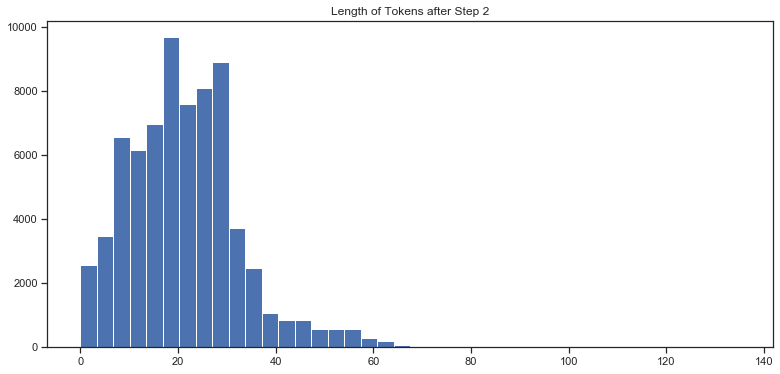


3. Removed the punctuation. Shape is still (71454,). 
 
 Peek: 
 38343    [ever, since, the, latest, watch, os, update, ...
26943    [i, am, working, with, apple, support, but, th...
18403    [so, many, stupid, bugs, in, the, new, update,...
94820                   [it, s, back, thank, you, !, 🍎, 🍏]
19883    [took, my, 7, plus, off, the, charger, to, get...
Name: inbound_text, dtype: object


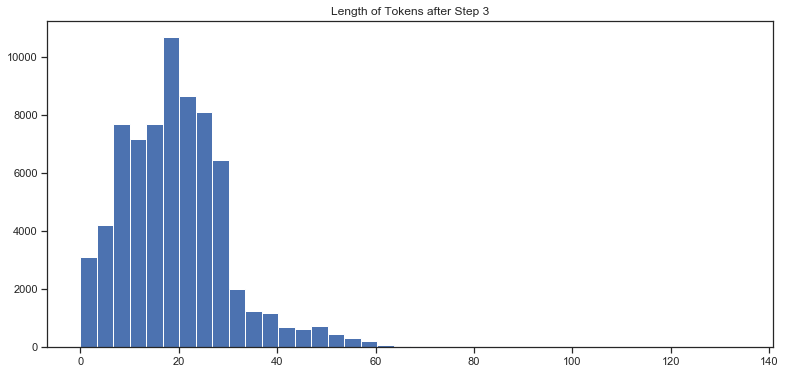

4. Applied automispelling corrections. Shape is still (71454,). 
 
 Peek: 
 38343    [ever, since, the, latest, watch, os, update, ...
26943    [i, am, working, with, apple, support, but, th...
18403    [so, many, stupid, bugs, in, the, new, update,...
94820                   [it, s, back, thank, you, !, 🍎, 🍏]
19883    [took, my, 7, plus, off, the, charger, to, get...
Name: inbound_text, dtype: object



5. Removed the stop words. Shape is still (71454,). 
 
 Peek: 
 38343    [ever, since, latest, watch, os, update, get, ...
26943    [working, apple, support, getting, results, i,...
18403    [many, stupid, bugs, new, update, ready, throw...
94820                               [back, thank, !, 🍎, 🍏]
19883    [took, 7, plus, charger, get, ready, work, the...
Name: inbound_text, dtype: object


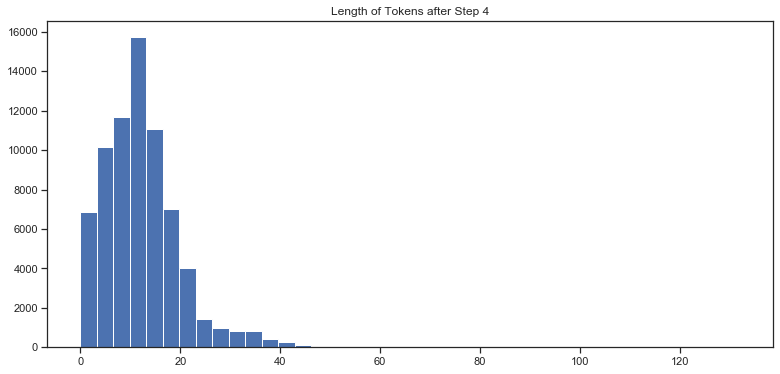


6. Expanded contractions into extra tokens. Shape is still (71454,). 
 
 Peek: 
 38343    [ever, since, latest, watch, os, update, get, ...
26943    [working, apple, support, getting, results, i,...
18403    [many, stupid, bugs, new, update, ready, throw...
94820                               [back, thank, !, 🍎, 🍏]
19883    [took, 7, plus, charger, get, ready, work, the...
Name: inbound_text, dtype: object


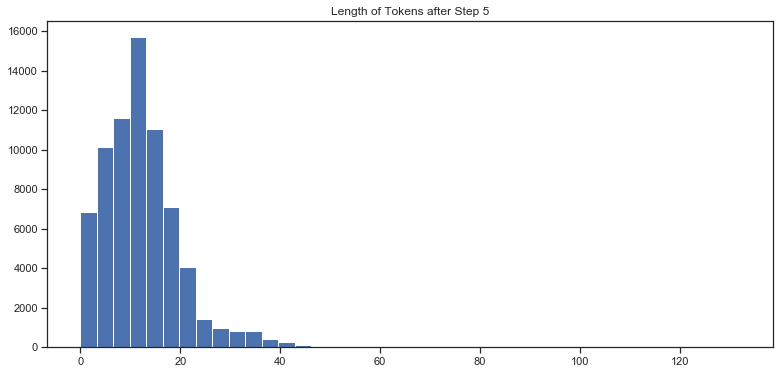

In [214]:
def my_tokenizer(data):
    ''' I am making my own end-to-end tokenizer function for preprocessing that accepts
    a Pandas Series as input and outputs a preprocessed Pandas Series'''
    
    # Making sure input is a series
    assert isinstance(data,pd.Series), 'Input must be a Pandas Series'
    
    def visualize_lengths(data,title):
        '''Visualizing lengths of tokens in each tweet'''
        lengths = [len(i) for i in data]
        plt.figure(figsize=(13,6))
        plt.hist(lengths, bins = 40)
        plt.title(title)
        plt.show()
    
    # 1. Converting all to lower case
    data = data.str.lower()
    
    print(f'1. Original shape of data is {data.shape}')
    
    
    # 2. Tokenizing with NLTK's TweetTokenizer. This limits repeated characters to 
    # three with the reduce lens paramater and strips all the @'s. It also
    # splits it into 1-gram tokens
    tknzr = TweetTokenizer(strip_handles = True, reduce_len = True)
    # Using progress apply to show the progress bar
    data = data.progress_apply(tknzr.tokenize)
    
    print(f'2. Tokenized, removed handles, and reduced the length of repeated characters.\
          \n Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 2')
    
    
    # 3. Removing the punctuation
    def remove_from_list(x, stuff_to_remove):
        ''' Making a function to remove a list of items from a list'''
        for item in stuff_to_remove:
            if item in x:
                x.remove(item)
        return x
    data = data.progress_apply(remove_from_list, stuff_to_remove = puncts)
    
    print(f'3. Removed the punctuation. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 3')

    # 4. Checking for and correcting mispellings
    spell = SpellChecker()
    def correct_spellings(x):
        ''' Takes as input a list and outputs a list of the corrected spelling'''
        corrected_text = []
        for word in x:
            if word in x:
                corrected_text.append(spell.correction(word))
            else:
                corrected_text.append(word)
        return corrected_text
    
    # Skipping this step first because it takes way too long
#     data = data.progress_apply(correct_spellings)
    
    print(f'4. Applied automispelling corrections. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    
    # 5. Removing the stop words, utilizing the same remove_from_list function defined above
    data = data.progress_apply(remove_from_list, stuff_to_remove = stop_words)
    
    print(f'5. Removed the stop words. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 4')
    
    # 6. Expanding contractions and colloquial language
    def replace_from_dict(x,dic):
        ''' Making a function to replace all the items in a list based on a dictionary. I made sure to use the insert
            method to insert the longer-gram replacement as distinct items in the list at that specific index'''
        replaced_counter = 0
        for item in dic.items():
            for i, e in enumerate(x):
                if e == item[0]:
                    replaced_counter+=1
                    # Inserting the expanded tokens in a way that preserves the order
                    del x[i]
                    for ix, token in enumerate(item[1].split()):
                        x.insert(i+ix,token)
#         print(f"Amount of words replaced: {replaced_counter}")
        return x
    data = data.progress_apply(replace_from_dict, dic = contraction_colloq_dict)
    print(f'6. Expanded contractions into extra tokens. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    visualize_lengths(data, 'Length of Tokens after Step 5')
    
    # 7. Lemmatization
    
    
    return data
    
my_tokenizer(X_train);

## Testing the functions I wrote above, and brief explanations

### Testing contraction and colloquial langauge expansion step

In [178]:
def replace_from_dict(x,dic):
    ''' Making a function to replace all the items in a list based on a dictionary. I made sure to use the insert
        method to insert the longer-gram replacement as distinct items in the list at that specific index'''
    x = x.str.lower() 
    x = list(x)
    replaced_counter = 0
    for item in dic.items():
        for i, e in enumerate(x):
            if e == item[0]:
                replaced_counter+=1
                # Inserting the expanded tokens in a way that preserves the order
                del x[i]
                for ix, token in enumerate(item[1].split()):
                    x.insert(i+ix,token)
    print(f"Amount of words replaced: {replaced_counter}")
    return pd.Series(x)

trial = pd.Series(["Ain't","nobody","is","as", "cute", "as", "you"])
replace_from_dict(trial,contraction_dict)

Amount of words replaced: 1


0        is
1       not
2    nobody
3     loves
4       you
dtype: object

### Testing out the Spell Checker

In [212]:
from spellchecker import SpellChecker

test = ['Cna','you', 'twy', 'to', 'spel', 'check','and','fux', 'tihs']

spell = SpellChecker()
def correct_spellings(x):
    ''' Takes as input a list and outputs a list of the corrected spelling'''
    corrected_text = []
    for word in x:
        if word in x:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return corrected_text
        
text = "speling correctin"
correct_spellings(test)

['can', 'you', 'two', 'to', 'spell', 'check', 'and', 'fun', 'this']

So here we see that the function generally does a good job, however it miscorrected twy as try and fux as fix because it doesn't understand context and uses Levianathon distance as it's measure of incorrectly spelt words, but that's okay and generally I think it'll do a good job as a preprocessing step.

### Testing out the WordNetLemmatizer works. 

This following lemmatizer tries to break down the word down to it's lemma or dictionary form.

In [200]:
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatizer.lemmatize('loving', 'v')

'love'

### Cleaning the numbers with regular expressions

In [286]:
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

### Limiting the length of each tweet
Based on the distribution of the tokens we have been seeing at each step above, I think a good cutoff point would be at 50 tokens. I am going to try something like 75 or 100 because you generally don't want to drop too much data. If you don't drop the data, when you use Keras tokenizer and pad sequences, if it's longer than 100 words it will stop there.

### Removing frequent words


In [ ]:
from collections import Counter
cnt = Counter()
for text in df["text_wo_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

In [ ]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["text_wo_stop"].apply(lambda text: remove_freqwords(text))
df.head()

Creates a dictionary of all the words in the vocab, and it stores the index. For each sequence it passes in the sequence and converts each word into the index that refers to the Keras word dictionary. When you feed in sentences into the model, they all have to be the same length. But some tweets are going to be longer than others, so pad_sequences just pad all the other ones so they are on the same length. It padding the messages with 0s until they are the same length as the longest message. They might set a max-length that are shorter because longer sequences are harder to train on.

In coding you are taking it from elsewhere. This is how people learn. Recommends writing all these functions yourself. What we frown upon are long codes that are taken from elsewhere.

Seq-to-seq is just the neural network bit.

## N Grams
Pairs are always better usually.

# Embedding in a Meaningful Way

### Pretrained word embeddings
Useful source: https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92

https://pypi.org/project/zeugma/0.41/

In [ ]:
from zeugma.embeddings import EmbeddingTransformer

glove = EmbeddingTransformer('glove')
x_train = glove.transform(corpus_train)

model = LogisticRegression()
model.fit(x_train, y_train)

x_test = glove.transform(corpus_test)
model.predict(x_test)

# Clustering

### Advice
Try to do clustering or topic modelling on this to pull out major themes and manually label these clusters.
Different vectorization methods: word2vec (developed using NNs), countvectorizer, tfidf. Up to us for finding the clusters and the quality of the results and infer what the general topic might be.

* K-means (most widely used)
* DBscan (a bit slower but we don't have to determine the clusters ahead of time)

You will have more success if you find one around the same type of domain. If they're all the same domain, they will capture the nuances. Generally the bot is going to be good at conversing topics on the language it's trained on. Maybe once you've trained it to detect a greeting they are more universal. If merge you might have to make your own IDs for this.

## 1. K Means Appraoch
My first approach for the word embedding will be to use K-Means, and for this I have to get my data in a format that Scikitlearn understands.

In [ ]:
# Transform with countvectorizer

# Predict with the K Means Clustering object

# How do you check how it's performing, visualizing with PCA


Gensim containts pretrained word embeddings and load them in. They have a special data format where you can basically load it in as a numpy array. Word2Vec is a NN architecture which basically trains Word2Vec method to generate word embeddings.

Someone has run this on a massive data and released the embeddings the model learned on the internet. Takes in various website and different contexts with learning. When you trained it to learn the words from like academic papers, the meaning of the word it learns is different than general twitter data. But a good thing about the word embeddigns is that they are usualyl trained on pretrained.

Glove is another algorithm for calculating word vectors. BERT, etc. Fast text is quite popular as well. You'll get some kind of file with those words and you'll basically generate this word-to-word embedding matrix and you pass it in as the weights layer in your NN.

Starting with K-Means. Use Scikitlearn's tokenizer. Transform the text into vector representation like tfidf or CountVectorizer. You have a matrix of all your rows, you have your pretrained word embeddings, you'll have to manually match up each word with the word vector.



When you build NN, when you use K fold it will take a LONG time so you can probably get away without doing CV with your NN and hyperparamater optimization. These embedding transformer has pretrained word embeddings, it will fit the data with that.

Do more exploration on your data. Sometimes when you have NLTK on tweets it gets weird. Because they have been trained on actual text.

## 2. LDA (Latent Dirichlet Allocation)
My second approach for the clustering is LDA topic modelling (Latent Dirichlet Allocation). It basically takes your data and splits it into topics. My goal is still to cluster, but with this method I hope to get more useful, distinct topics.

Useful article:
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

## 3. DBScan

# Questions
* For word embeddings in the vector space, would one point be one tweet? Or would it be the other way around? 

# Modelling intents
Using Keras to classify intents of new, unseen data that a user might type up.

Got this tokenizer function from https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [109]:
# tf.keras.preprocessing.text.Tokenizer(
#     num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,
#     split=' ', char_level=False, oov_token=None, document_count=0
# )

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

tokenized = tokenize(cleaned)

# Other datasets I explored:

## Ubuntu

In [39]:
# Reading in Ubuntu data
df = pd.read_csv('data/Ubuntu-dialogue-corpus/dialogueText.csv')

In [40]:
# Visualizing the tables, applying styling so that the table is more readable
show = lambda x: x.tail(50).style.set_properties(**{'background-color': 'black',                                                   
                                    'color': 'lawngreen',                       
                                    'border-color': 'white'})\
.applymap(lambda x: f"color: {'lawngreen' if isinstance(x,str) else 'red'}")\
.background_gradient(cmap='Blues')

In [41]:
show(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038324 entries, 0 to 1038323
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   folder      1038324 non-null  int64 
 1   dialogueID  1038324 non-null  object
 2   date        1038324 non-null  object
 3   from        1038311 non-null  object
 4   to          566035 non-null   object
 5   text        1038237 non-null  object
dtypes: int64(1), object(5)
memory usage: 47.5+ MB


In [16]:
df['text']

0          Hello folks, please help me a bit with the fol...
1          Did I choose a bad channel? I ask because you ...
2          the second sentence is better english   and we...
3                                               Sock Puppe?t
4                                                       WTF?
                                 ...                        
1038319                                           anyone on?
1038320                                                  yes
1038321    can I get a pastebin of someones menu.lst with...
1038322                         http://pastebin.com/fe921690
1038323                                               thanks
Name: text, Length: 1038324, dtype: object

## Relational Services in Customer Service (RSICS)

In [16]:
!ls data/rsics_dataset

1_1_align.csv                     5_4_align.csv
1_2_align.csv                     6_1_align.csv
1_3_align.csv                     6_2_align.csv
1_4_align.csv                     6_3_align.csv
2_1_align.csv                     6_4_align.csv
2_2_align.csv                     7_1_align.csv
2_3_align.csv                     7_2_align.csv
2_4_align.csv                     7_3_align.csv
3_1_align.csv                     7_4_align.csv
3_2_align.csv                     8_1_align.csv
3_3_align.csv                     8_2_align.csv
3_4_align.csv                     8_3_align.csv
4_1_align.csv                     8_4_align.csv
4_2_align.csv                     LICENSE.md
4_3_align.csv                     README.md
4_4_align.csv                     all_data_by_threshold.csv
5_1_align.csv                     all_multi_intent.csv
5_2_align.csv                     rsics.bib
5_3_align.csv                     tagged_selections_by_sentence.csv


In [18]:
pd.read_csv('data/rsics_dataset/1_2_align.csv')

Annotator A ID  Annotator B ID  Parition ID  Corpora ID  Sentence ID  \
0                     1        7.000000          2.0         2.0       7506.0   
1                     1        7.000000          2.0         2.0       7507.0   
2                     1        7.000000          2.0         2.0       7509.0   
3                     1        7.000000          2.0         2.0       7510.0   
4                     1        7.000000          2.0         2.0       7511.0   
...                 ...             ...          ...         ...          ...   
2658                NaN             NaN          NaN         NaN          NaN   
2659     Average Length       97.922122          NaN         NaN          NaN   
2660      Average Error        0.076430          NaN         NaN          NaN   
2661  Average Alignment        0.923570          NaN         NaN          NaN   
2662  Average Agreement        0.787434          NaN         NaN          NaN   

                                                   Text  \
0     what is the price for round trip between toron...   
1     trying to find a good deal and good timing to ...   
2     trying to plan route penn ny to montgomery ny....   
3     Hi does the 54 Vermonter train go from Newark,...   
4     is there a train service from los angeles ca t...   
...                                                 ...   
2658                                                NaN   
2659                                                NaN   
2660                                                NaN   
2661                                                NaN   
2662                                                NaN   

                                       Annotator A Text  \
0     what is the price for round trip between toron...   
1     trying to find a good deal and good timing to ...   
2     trying to plan route penn ny to montgomery ny....   
3     [Hi ]does the 54 Vermonter train go from Newar...   
4     is there a train service from los angeles ca t...   
...                                                 ...   
2658                                                NaN   
2659                                                NaN   
2660                                                NaN   
2661                                                NaN   
2662                                                NaN   

                                       Annotator B Text  Length  Error  \
0     what is the price for round trip between toron...    61.0    0.0   
1     [trying to find a ]good deal and good timing t...    81.0   17.0   
2     trying to plan route penn ny to montgomery ny....    63.0   16.0   
3     [Hi ]does the 54 Vermonter train go from Newar...    87.0   10.0   
4     is there a train service from los angeles ca t...    64.0    0.0   
...                                                 ...     ...    ...   
2658                                                NaN     NaN    NaN   
2659                                                NaN     NaN    NaN   
2660                                                NaN     NaN    NaN   
2661                                                NaN     NaN    NaN   
2662                                                NaN     NaN    NaN   

      Alignment Score  Agreement  
0            1.000000        1.0  
1            0.790123        0.0  
2            0.746032        0.0  
3            0.885057        1.0  
4            1.000000        1.0  
...               ...        ...  
2658              NaN        NaN  
2659              NaN        NaN  
2660              NaN        NaN  
2661              NaN        NaN  
2662              NaN        NaN  

[2663 rows x 12 columns]